## Converting object-labeled wisdom dataset to cluttered omniglot format

In [1]:
import os
import cv2
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dataset_utils import mkdir_if_missing
from PIL import Image
from skimage import io
from tqdm import tqdm
import pprint
import json

In [3]:
# input directories
AMODAL_MASK_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/dataset"
SCENE_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/depth_ims"
JSON_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/color_ims"
MASK_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/modal_segmasks"

# output directories
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001"
mkdir_if_missing(OUT_DIR)
mkdir_if_missing(os.path.join(OUT_DIR, "train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-one-shot"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-one-shot"))

# real dataset parameters
NUM_IMS = 1  # 400

# original image shape
IM_WIDTH = 1032
IM_HEIGHT = 772

# 1:3 ratio between im_size and tar_size
IM_SIZE = 384
TAR_SIZE = 128

# Image distortion
ANGLE = 0
SHEAR = 0

# For storage purposes
BLOCK_SIZE = 1

In [4]:
def rot_x(phi, theta, ptx, pty):
    return np.cos(phi+theta)*ptx + np.sin(phi-theta)*pty


def rot_y(phi, theta, ptx, pty):
    return -np.sin(phi+theta)*ptx + np.cos(phi-theta)*pty


def prepare_img(img, angle=100, shear=2.5, scale=2):
    # Apply affine transformations and scale characters for data augmentation
    phi = np.radians(np.random.uniform(-angle, angle))
    theta = np.radians(np.random.uniform(-shear, shear))
    a = scale**np.random.uniform(-1, 1)
    b = scale**np.random.uniform(-1, 1)
    (x, y) = img.shape
    x = a * x
    y = b * y
    xextremes = [rot_x(phi, theta, 0, 0), rot_x(phi, theta, 0, y), rot_x(phi, theta, x, 0), rot_x(phi, theta, x, y)]
    yextremes = [rot_y(phi, theta, 0, 0), rot_y(phi, theta, 0, y), rot_y(phi, theta, x, 0), rot_y(phi, theta, x, y)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)

    aff_bas = np.array([[a*np.cos(phi+theta), b*np.sin(phi-theta), -mnx], [-a*np.sin(phi+theta), b*np.cos(phi-theta), -mny], [0, 0, 1]])
    aff_prm = np.linalg.inv(aff_bas)
    pil_img = Image.fromarray(img)
    pil_img = pil_img.transform((int(mxx - mnx),int(mxy - mny)),
                                    method=Image.AFFINE,
                                    data=np.ndarray.flatten(aff_prm[0:2, :]))
    pil_img = pil_img.resize((int(TAR_SIZE * (mxx - mnx) / 100), int(TAR_SIZE * (mxy - mny) / 100)))

    return np.array(pil_img)


def bbox(im):
    # get bounding box coordinates
    rows = np.any(im, axis=1)
    cols = np.any(im, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def make_target(modal_mask, angle=0, shear=0, scale=1):
    # make target image by cropping
    # formula: use the bigger bounding box length plus half of the smaller
    # margin between the edge of the image and the bbox
    transformed_mask = prepare_img(modal_mask, angle, shear, scale)
    top, bot, left, right = bbox(transformed_mask)
    obj_size = max(bot - top, right - left)
    if bot - top > right - left:
        right += (bot - top - (right - left)) // 2
        left -= (bot - top - (right - left)) // 2
    else:
        bot += (right - left - (bot - top)) // 2
        top -= (right - left - (bot - top)) // 2
    margin = min(top, left, IM_HEIGHT - bot, IM_WIDTH - right)
    
    return cv2.resize(
        transformed_mask[max(0, top - margin):min(transformed_mask.shape[0], bot + margin),
                         max(0, left - margin):min(transformed_mask.shape[1], right + margin)],
        (TAR_SIZE, TAR_SIZE),
        interpolation=cv2.INTER_NEAREST)

def resize_scene(im):
    if len(im.shape) == 2:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0)), mode="constant")
    elif len(im.shape) == 3:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0), (0, 0)), mode="constant")
    else:
        raise Exception("image dimensions not valid for scene/ground truth, shape: {}".format(im.shape))
    return cv2.resize(
        im,
        (IM_SIZE, IM_SIZE),
        interpolation=cv2.INTER_NEAREST)

  0%|          | 0/30 [00:00<?, ?it/s]

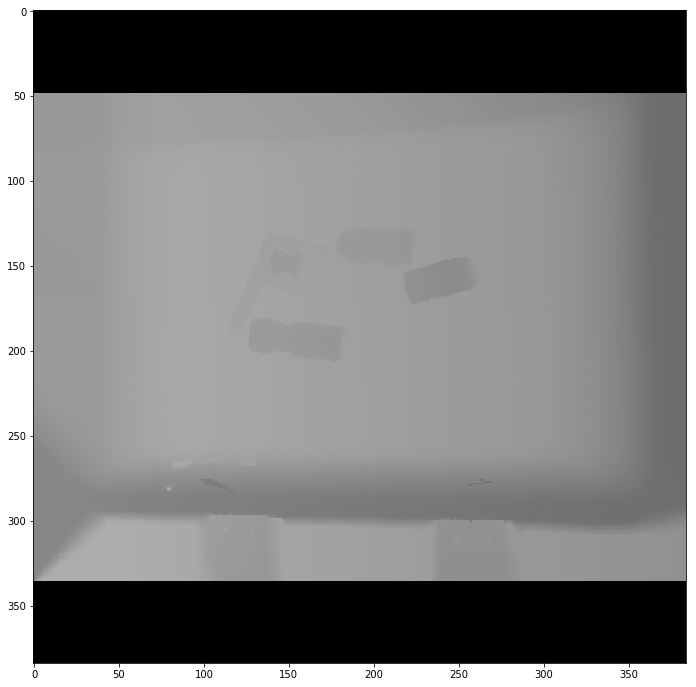

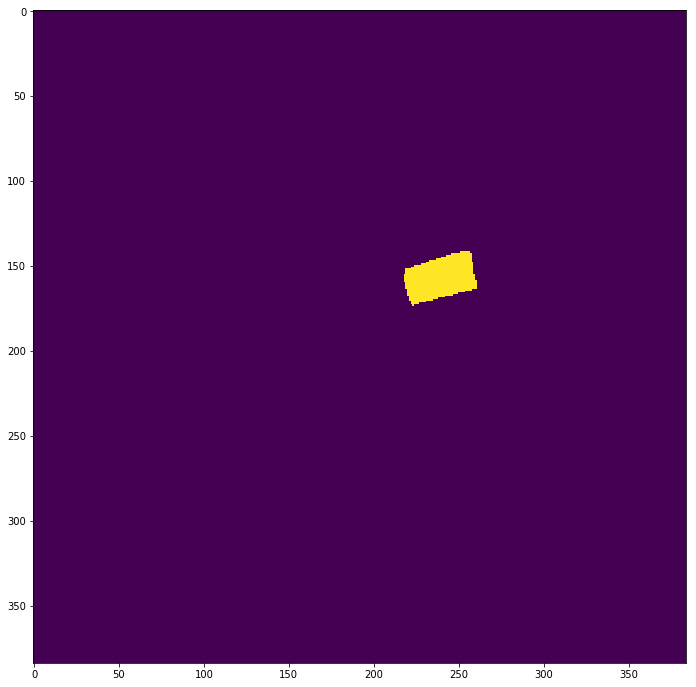

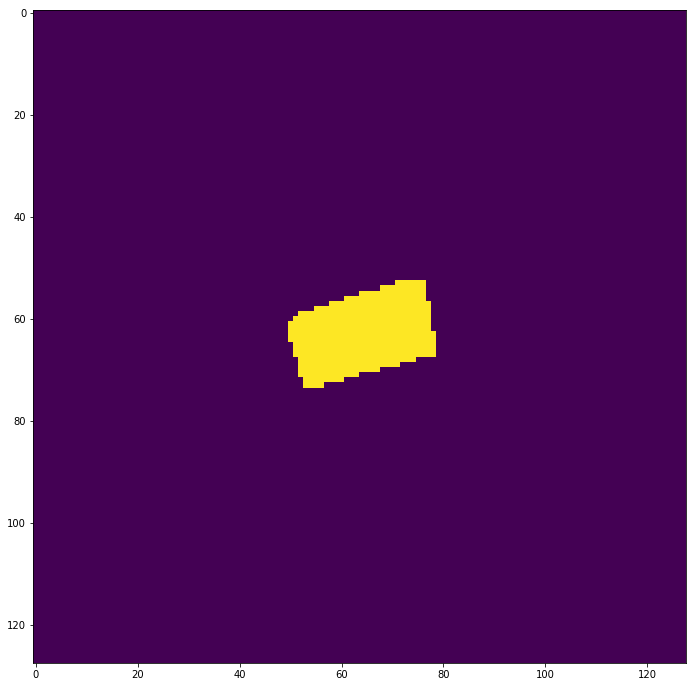

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000000

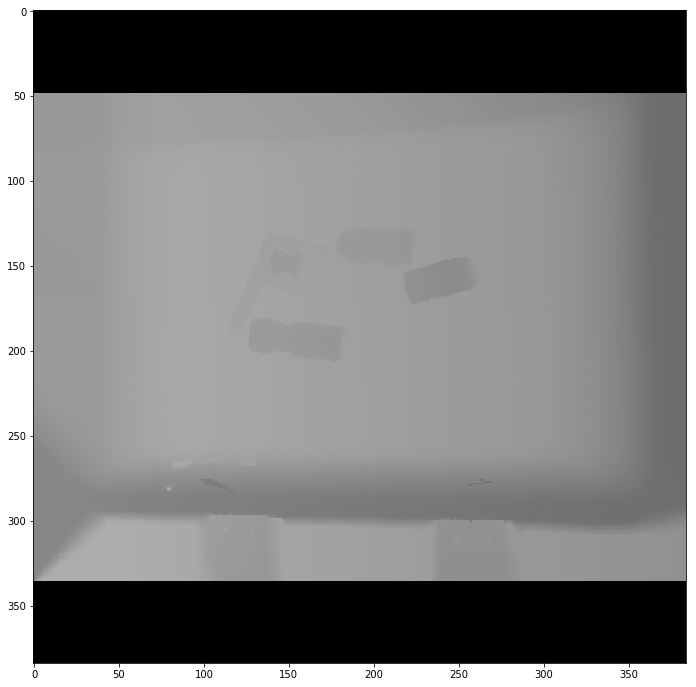

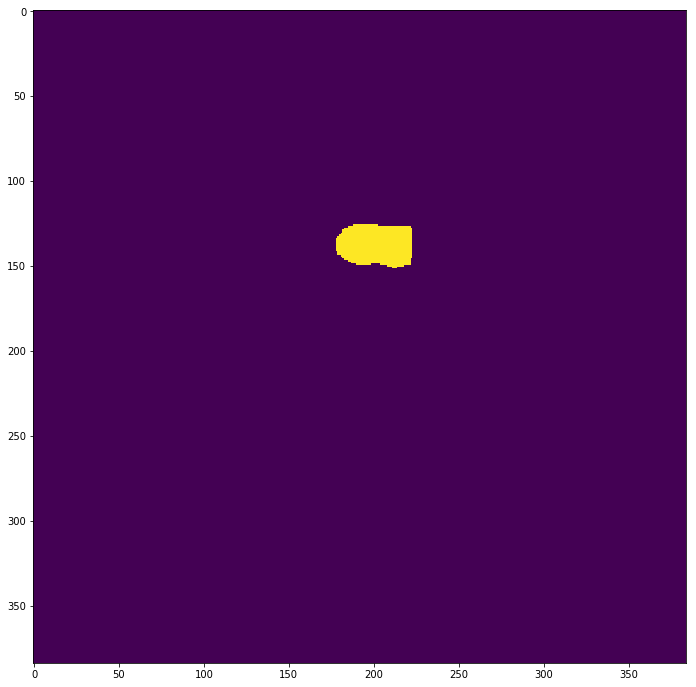

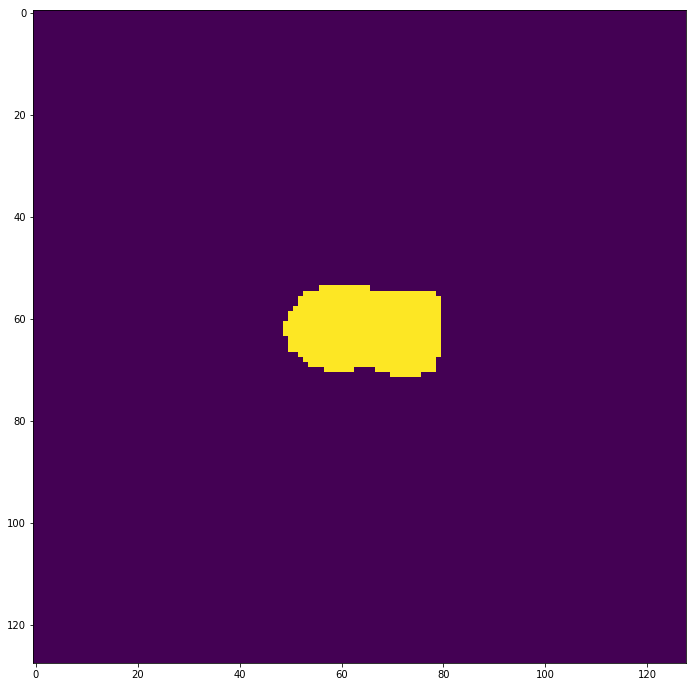

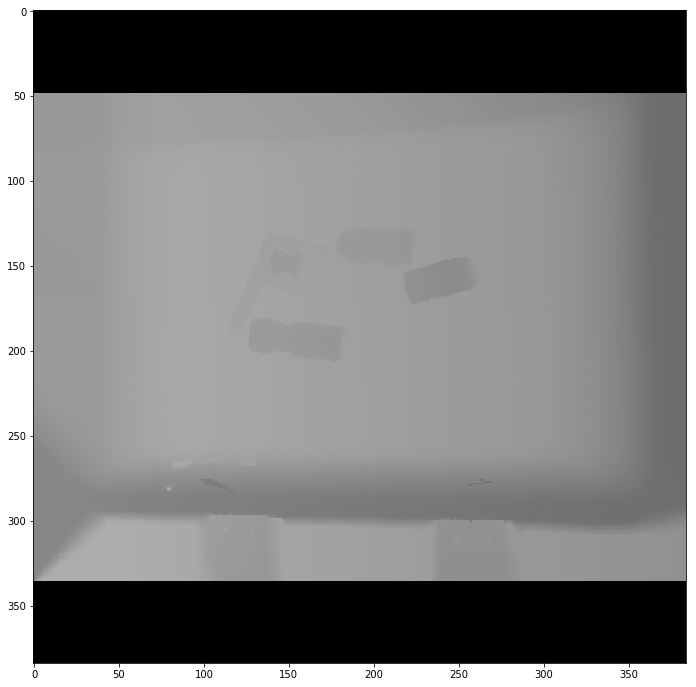

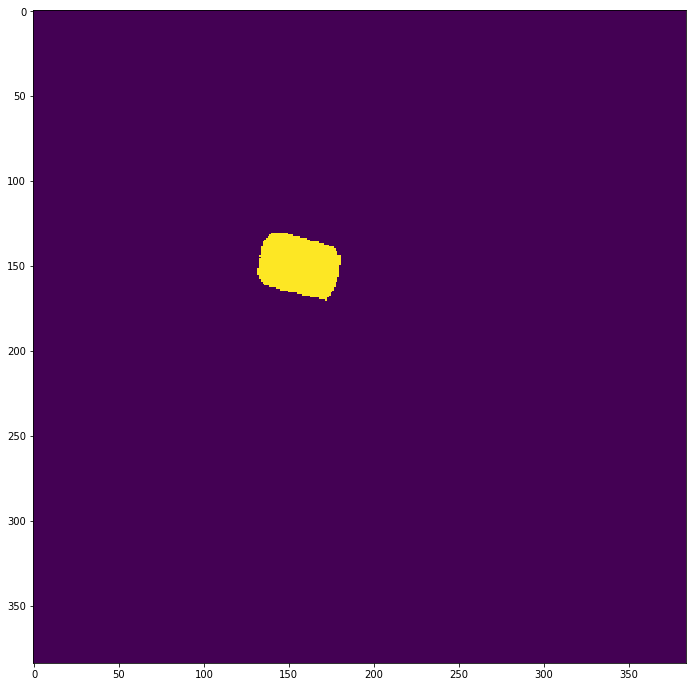

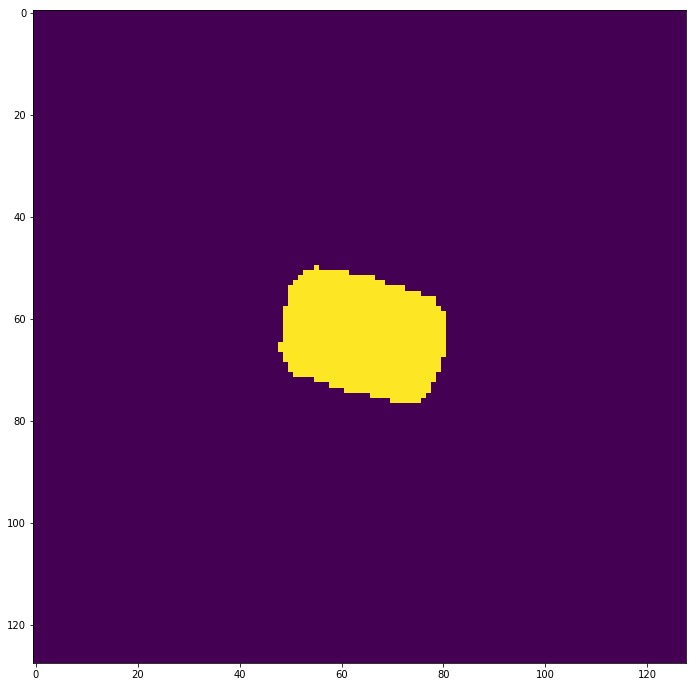

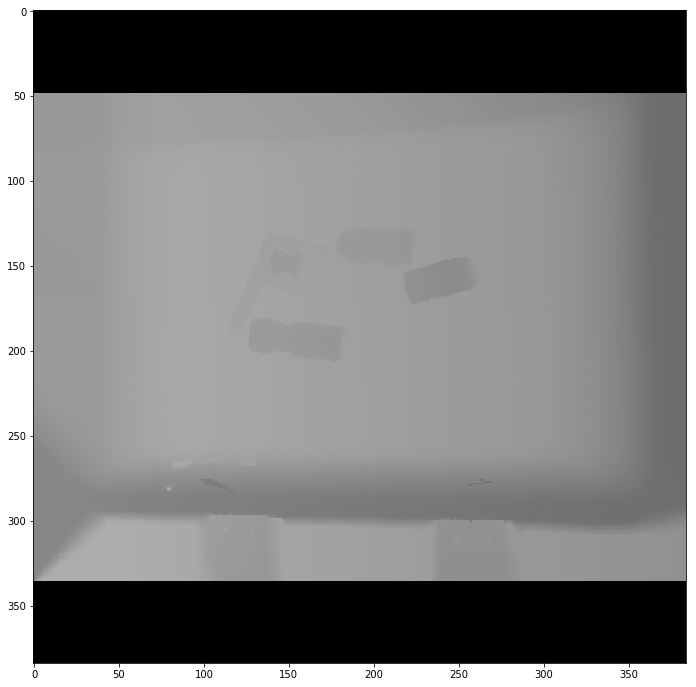

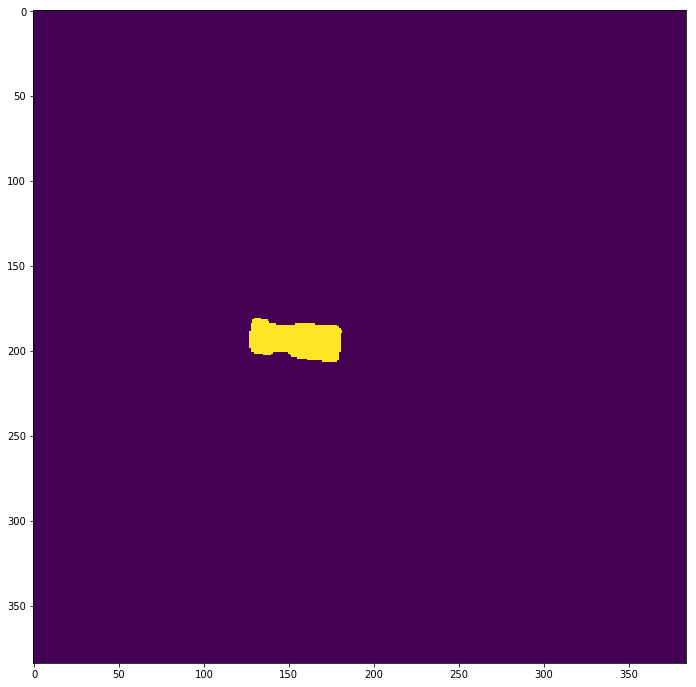

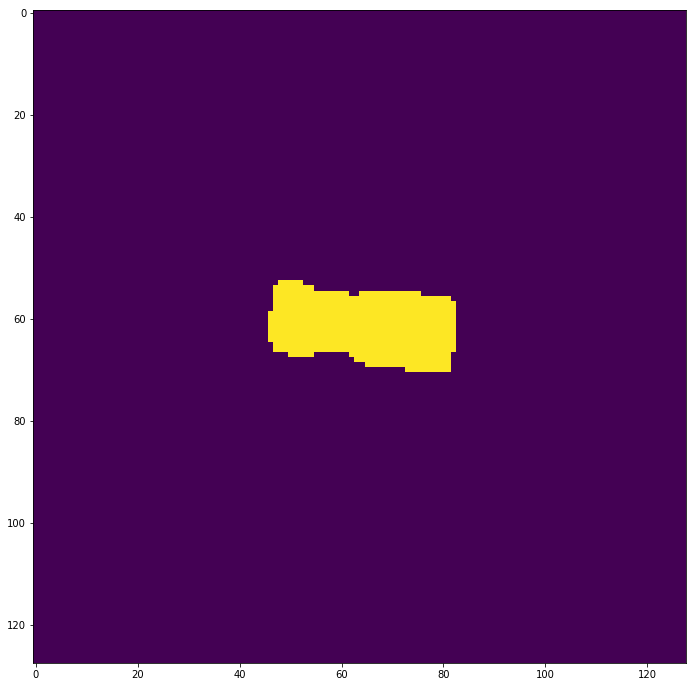

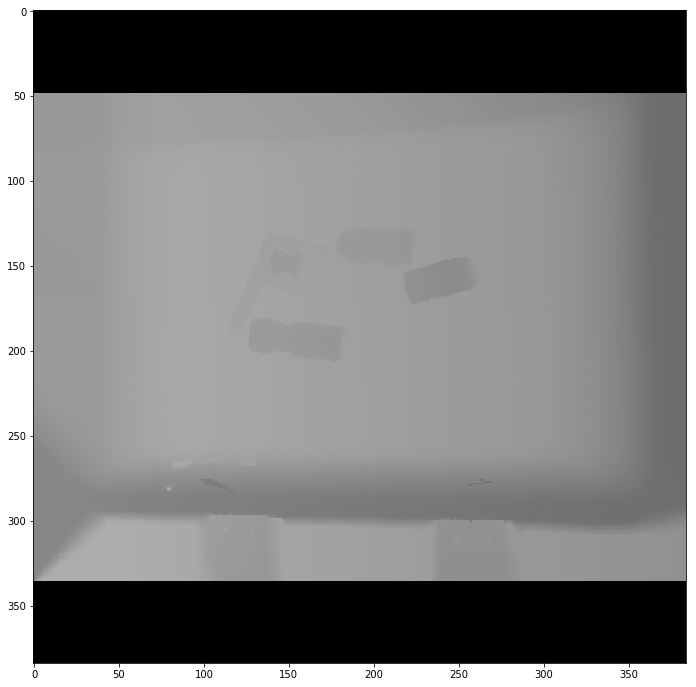

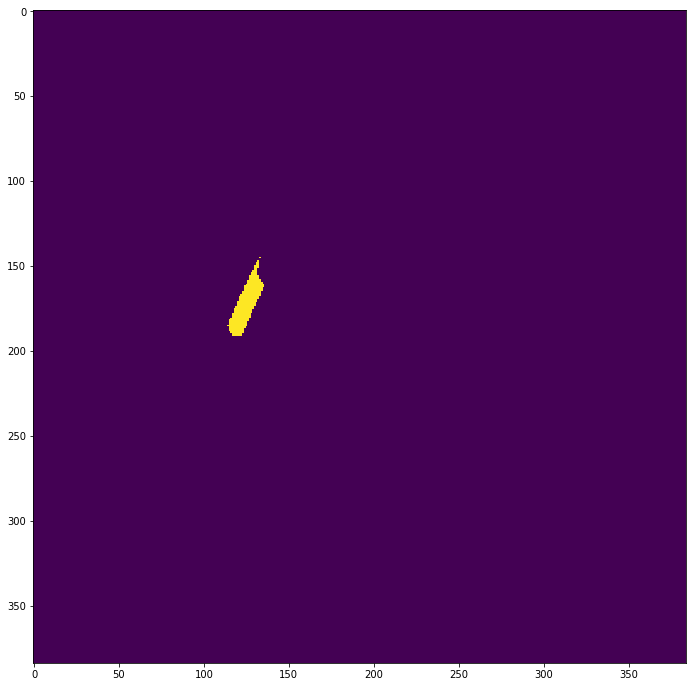

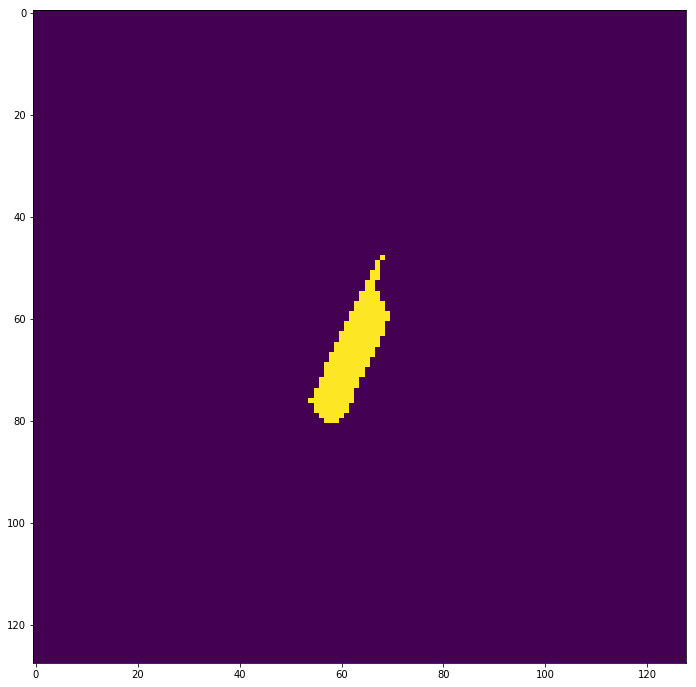

  3%|▎         | 1/30 [00:03<01:39,  3.44s/it]

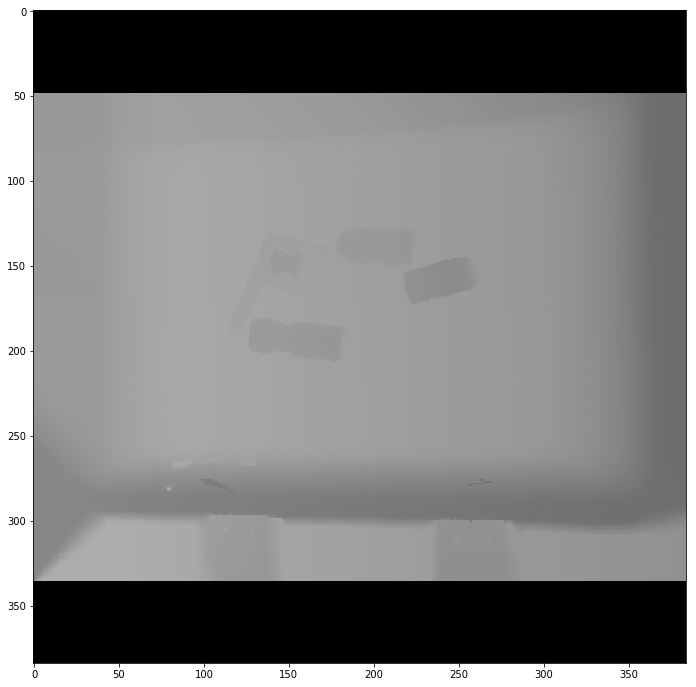

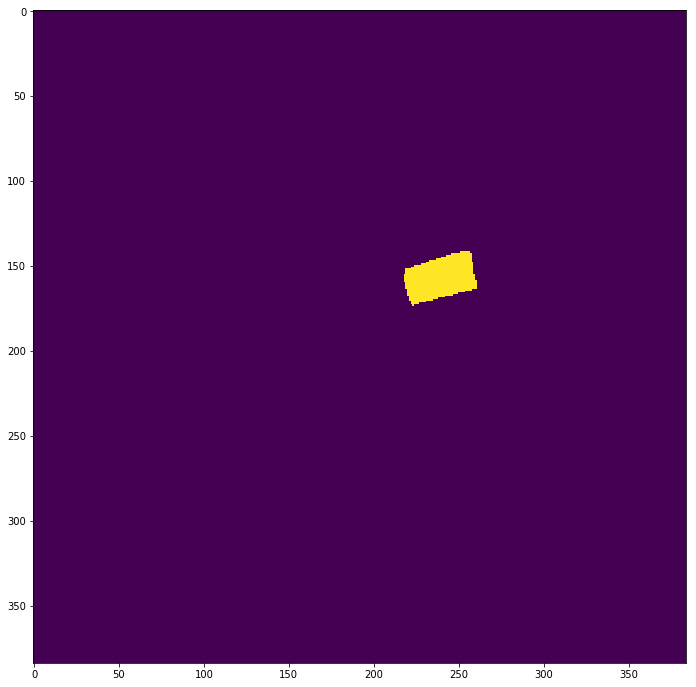

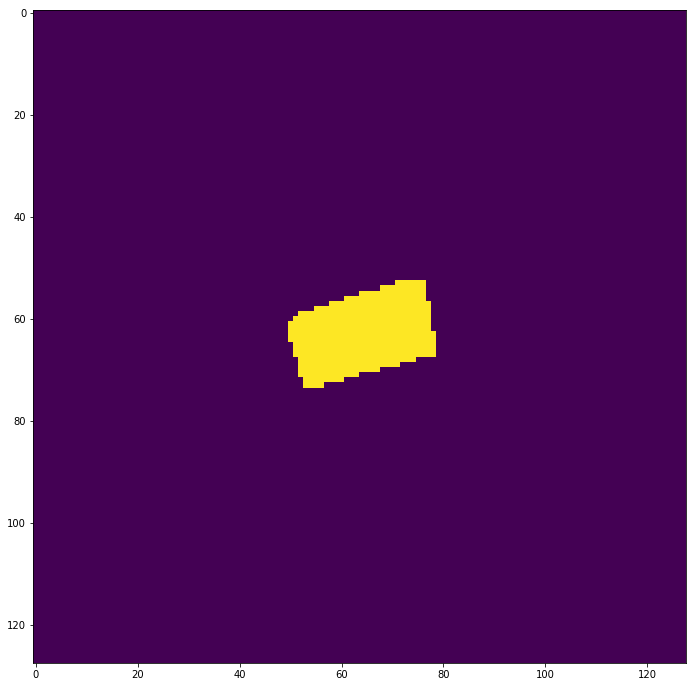

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000001

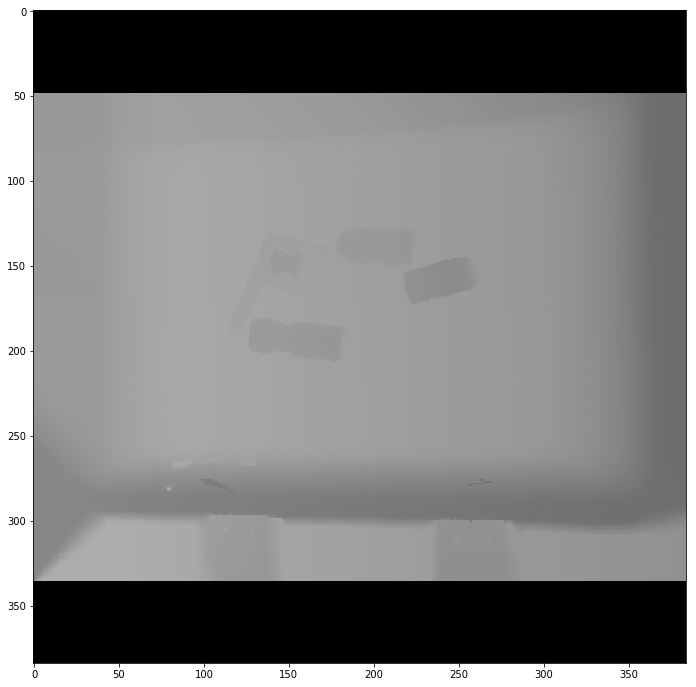

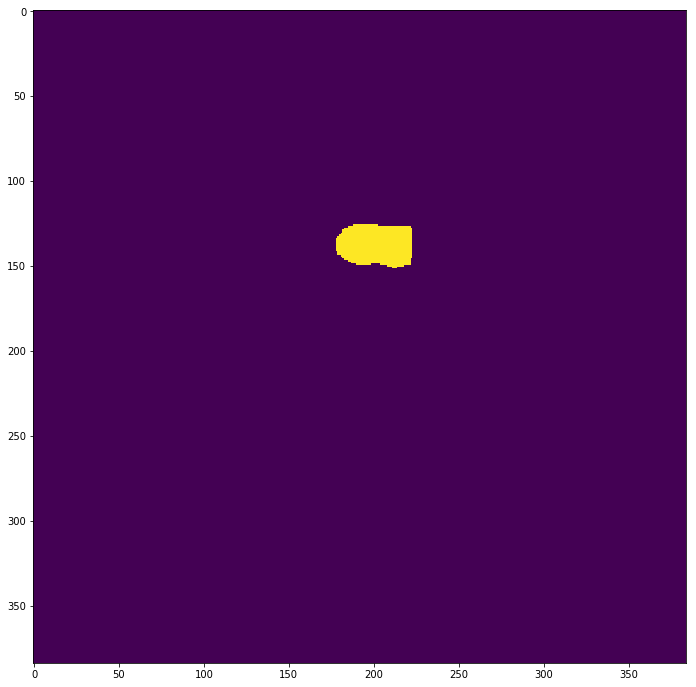

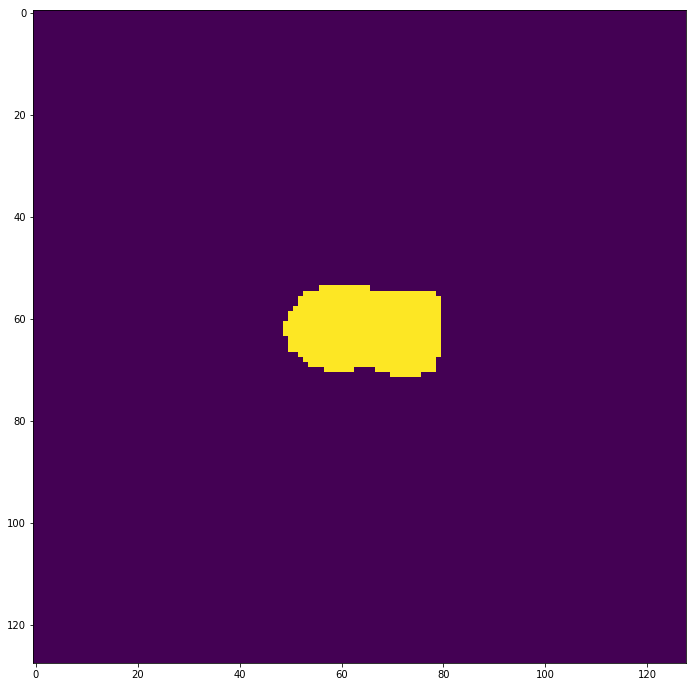

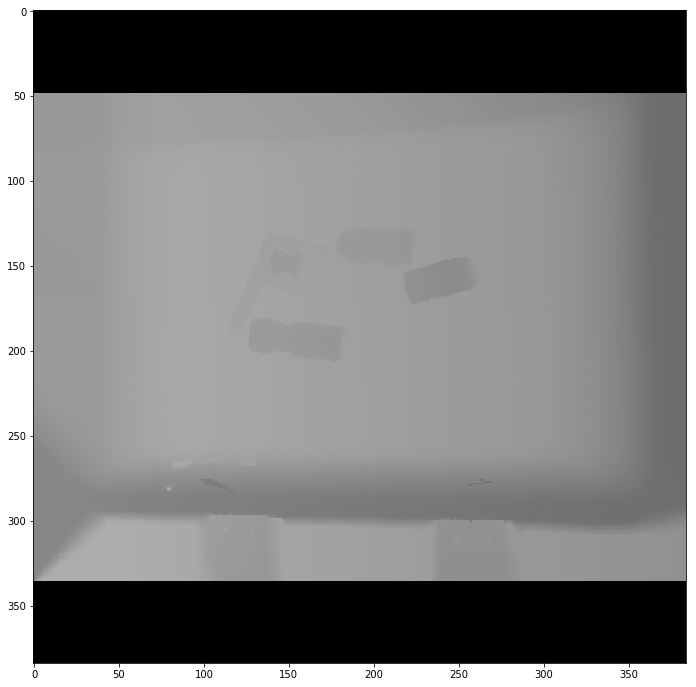

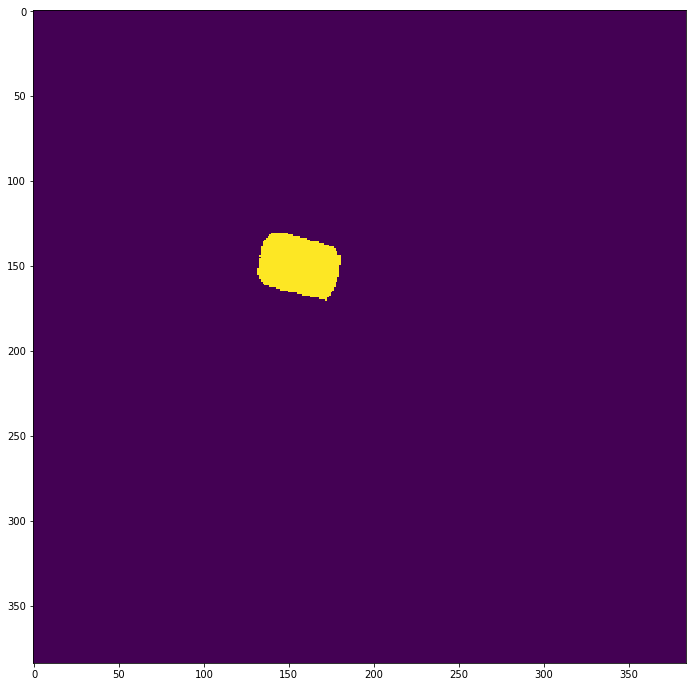

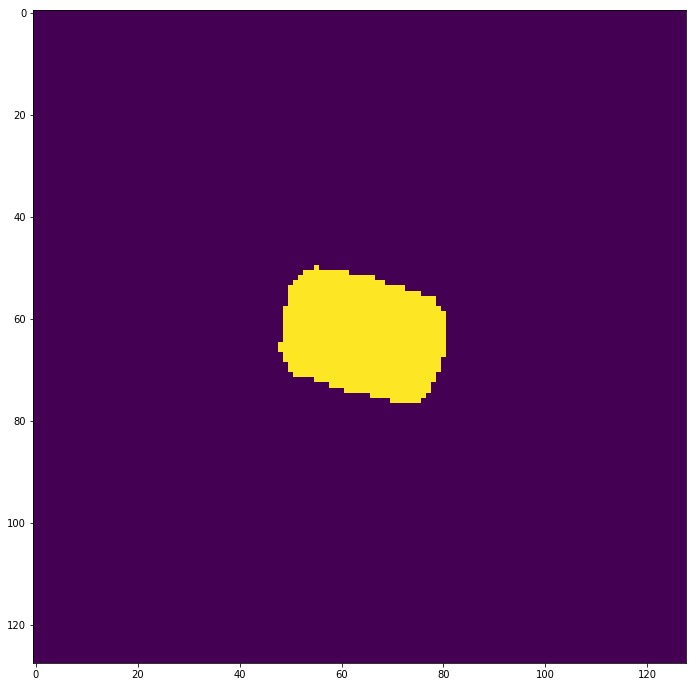

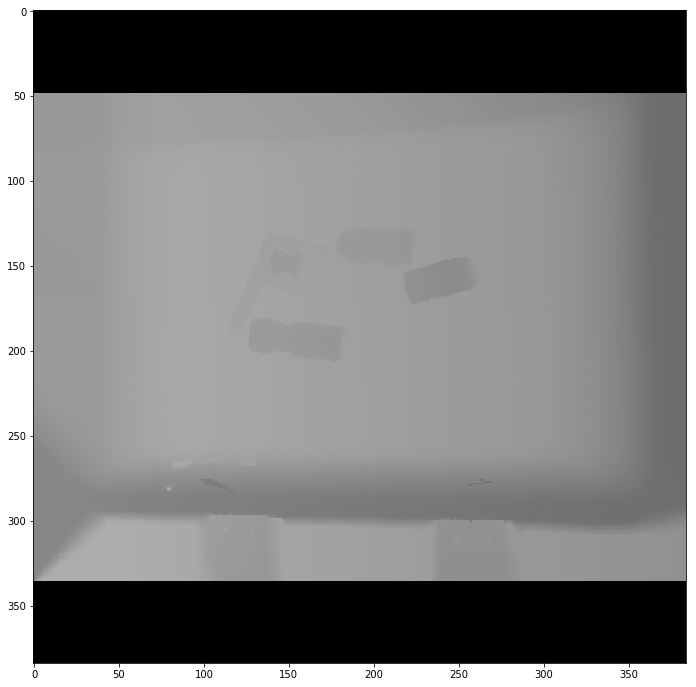

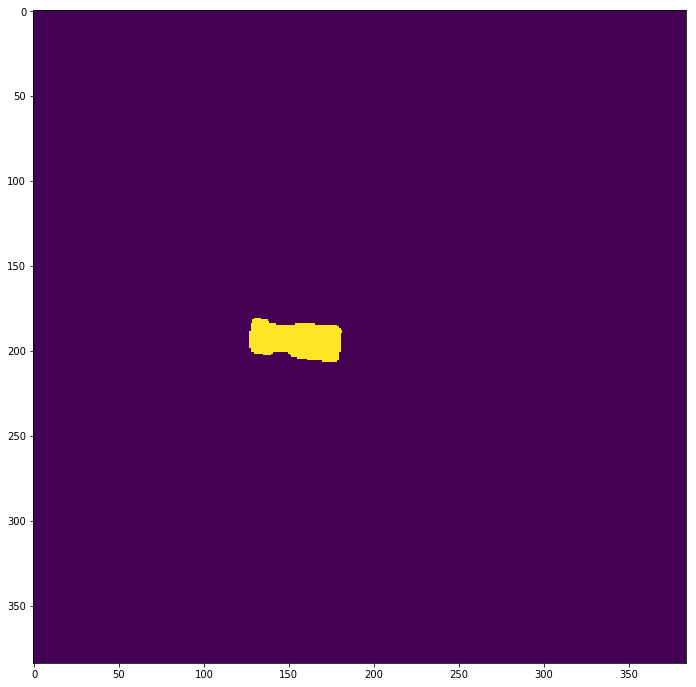

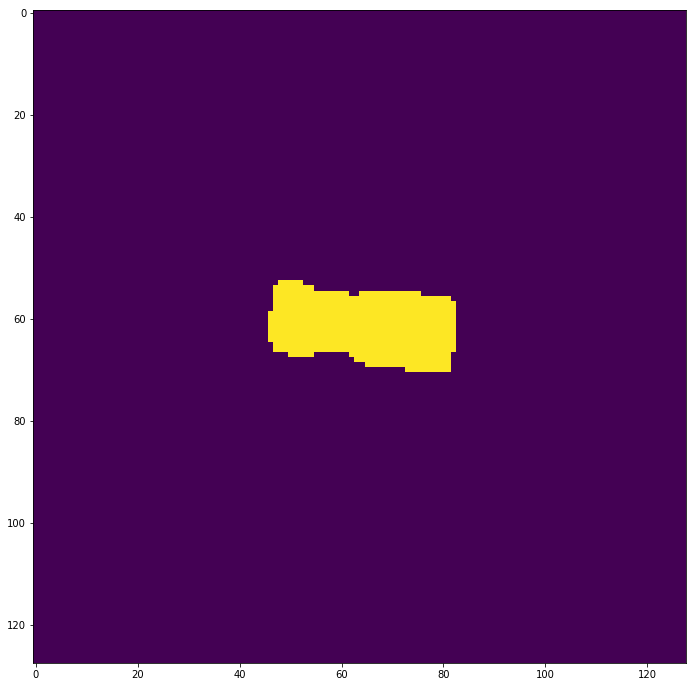

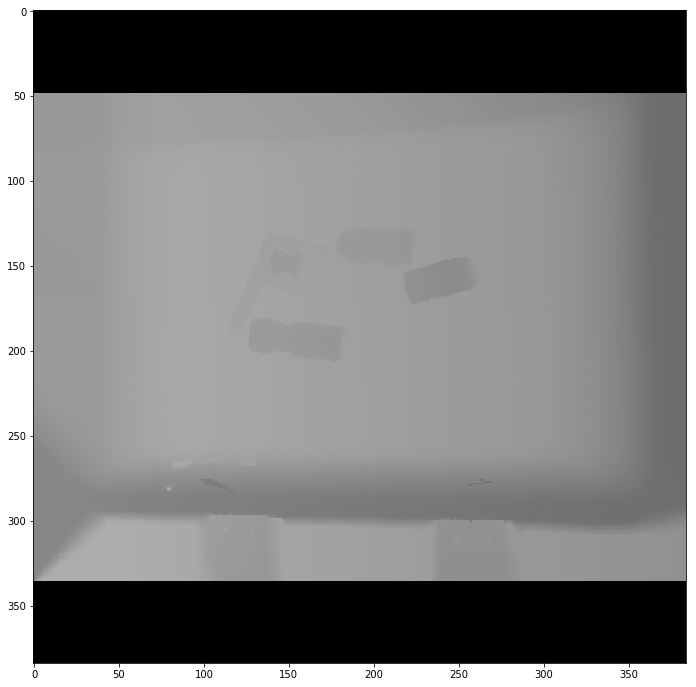

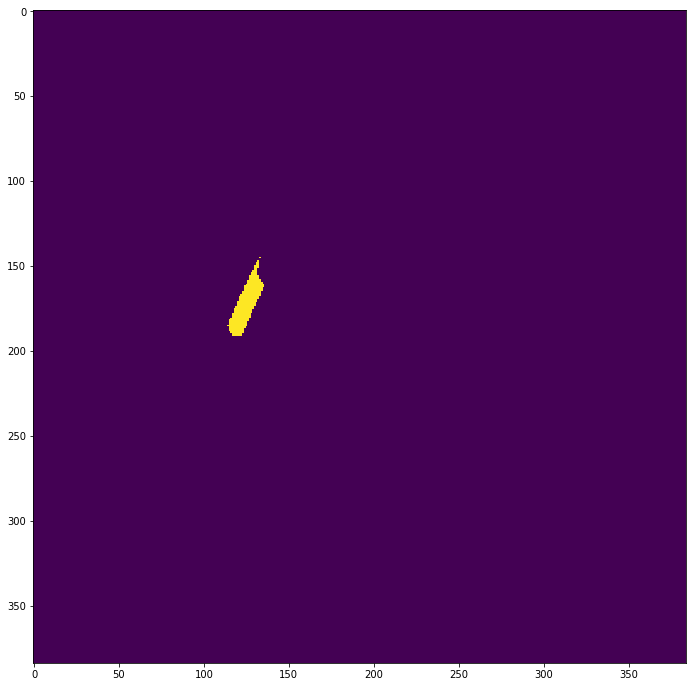

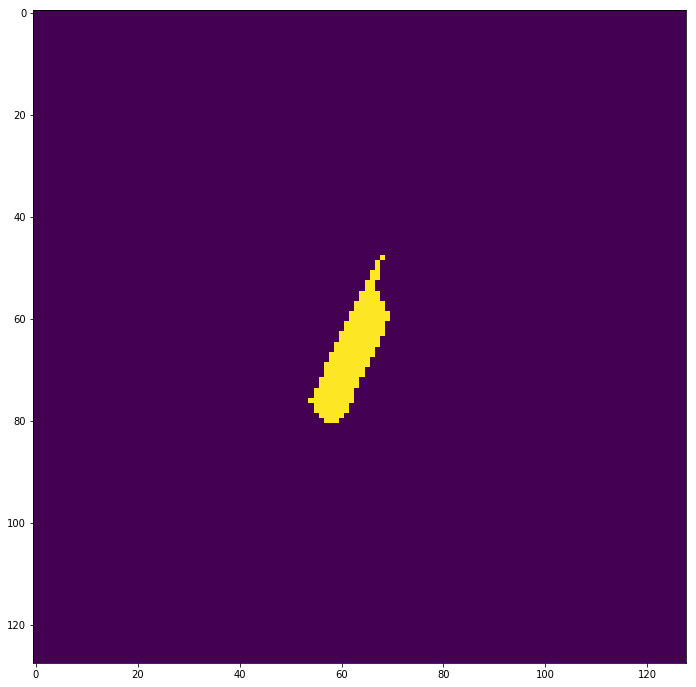

  7%|▋         | 2/30 [00:06<01:34,  3.36s/it]

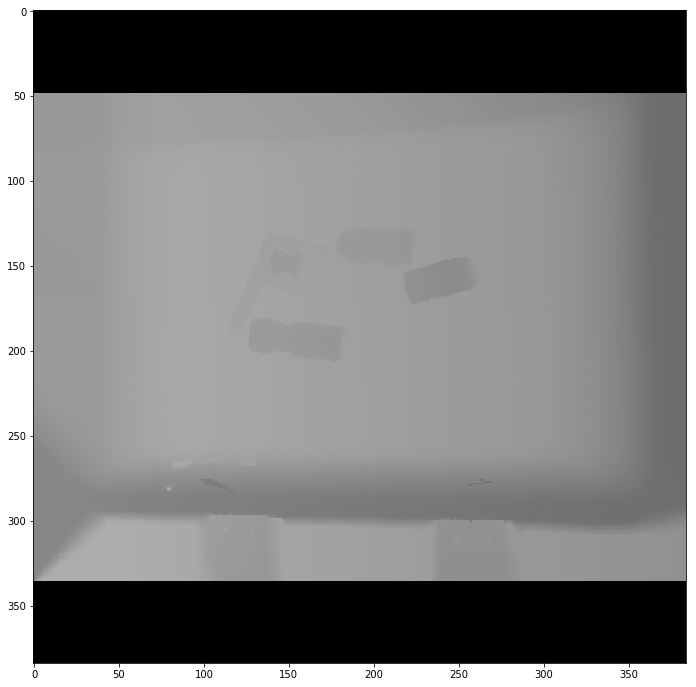

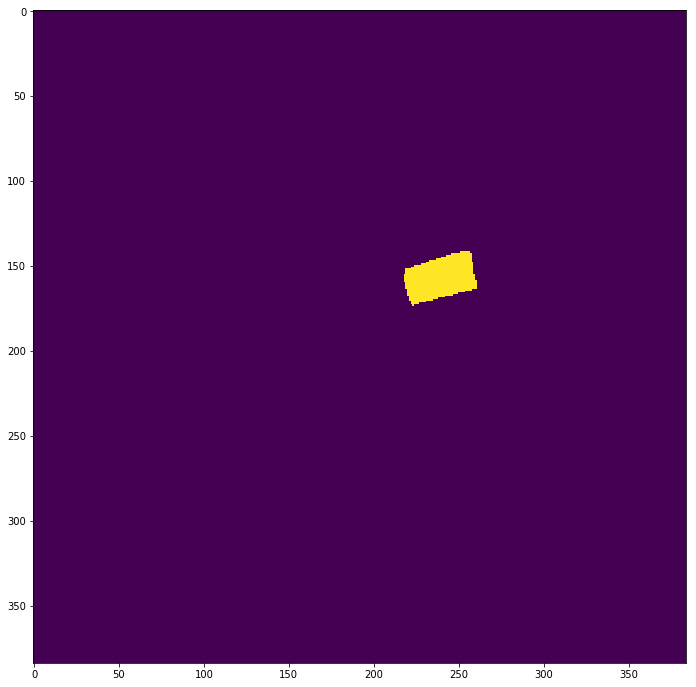

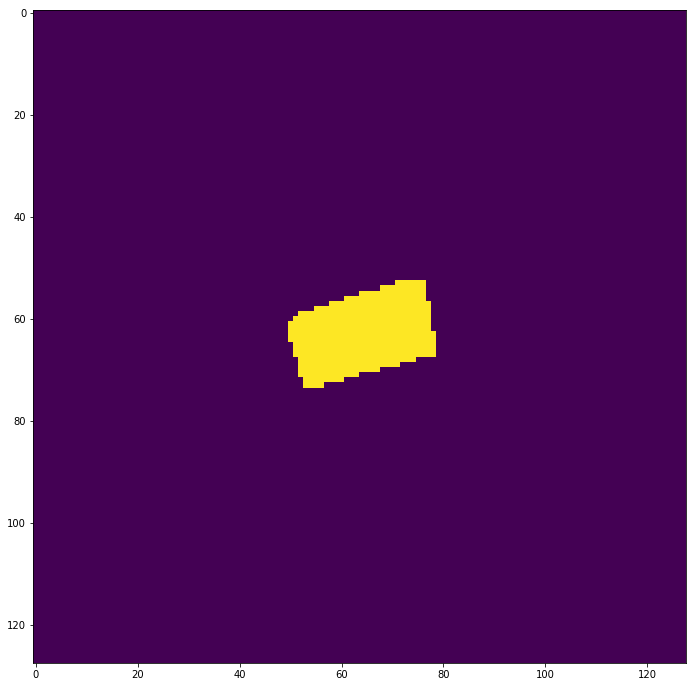

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000002

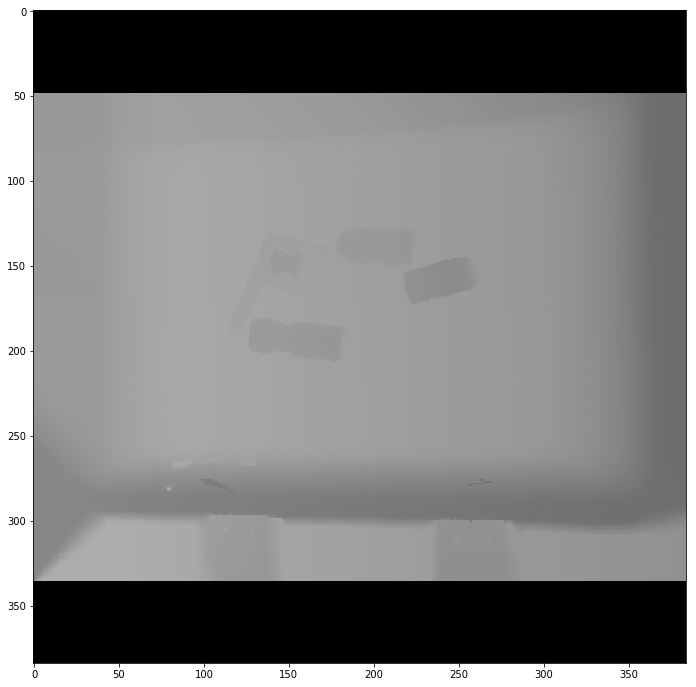

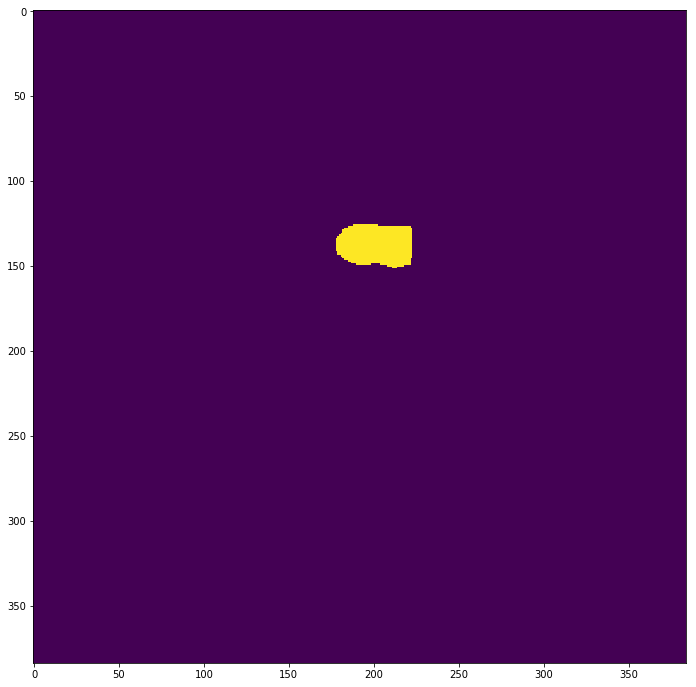

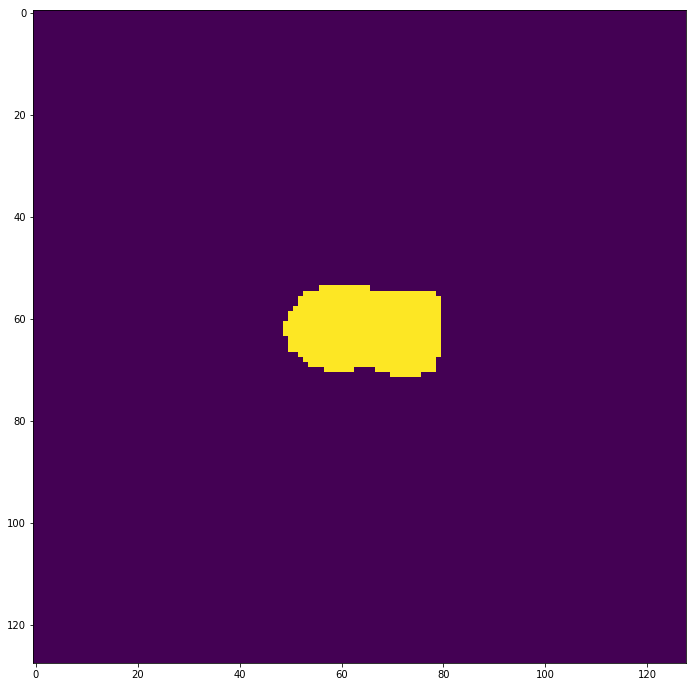

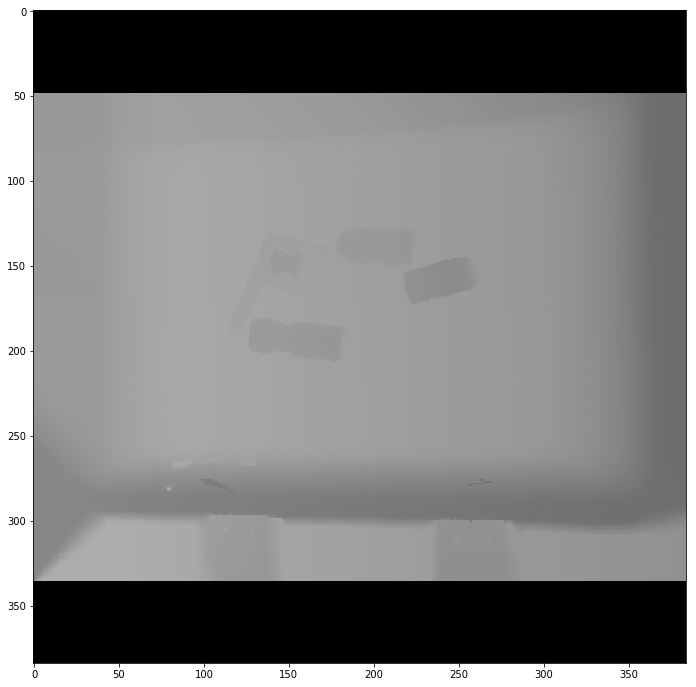

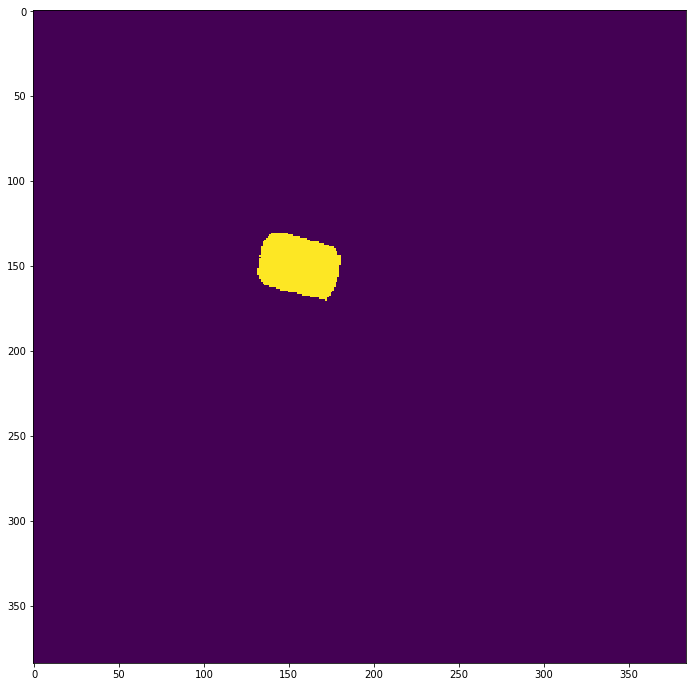

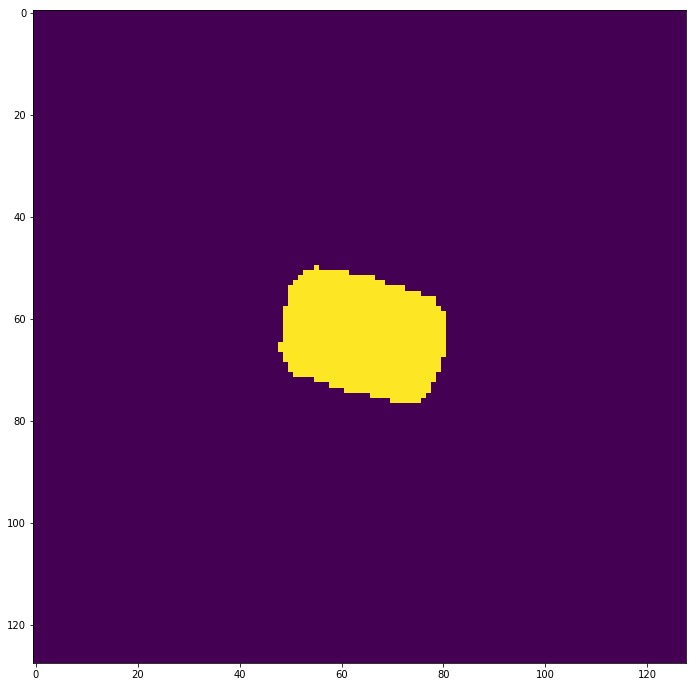

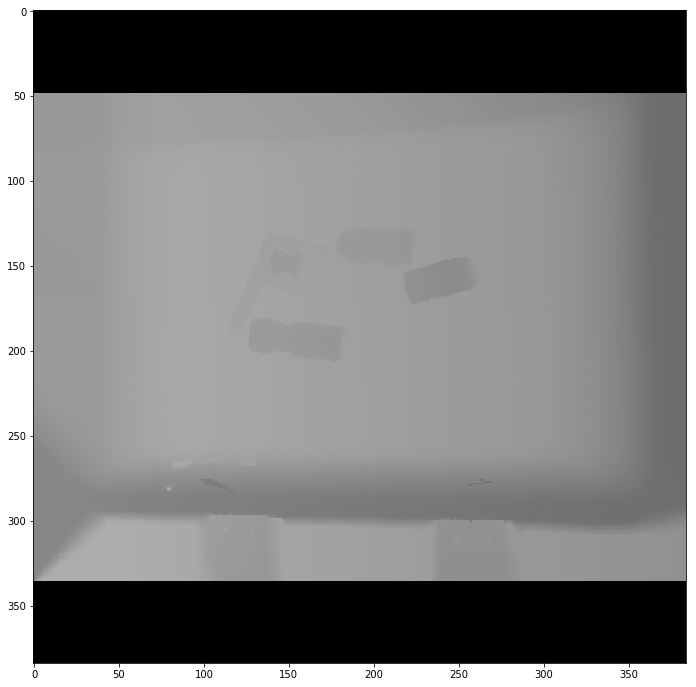

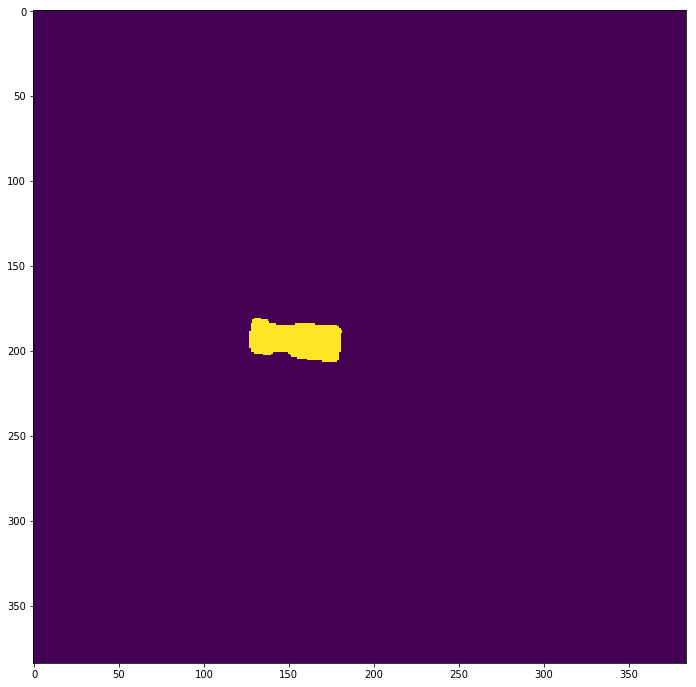

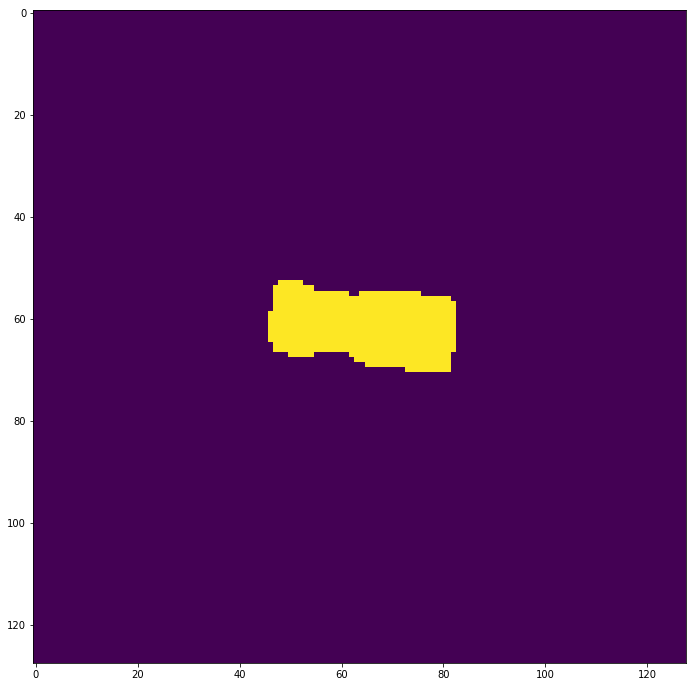

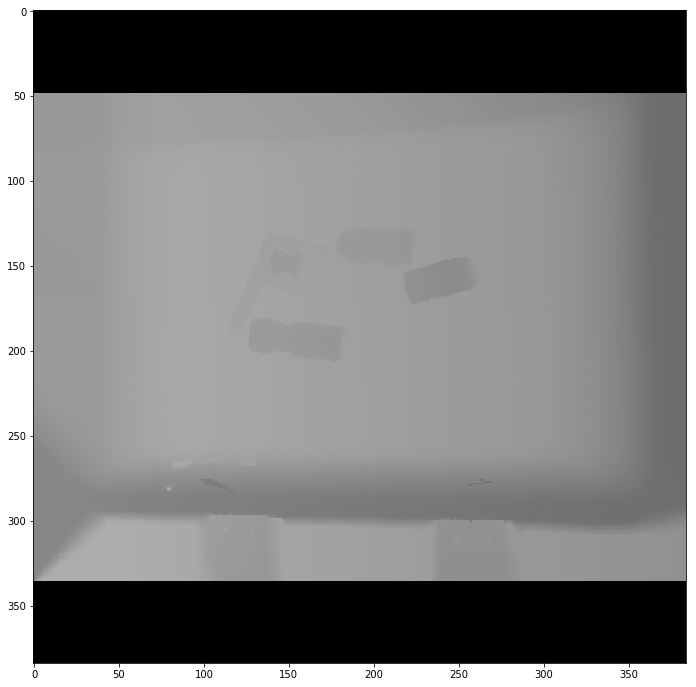

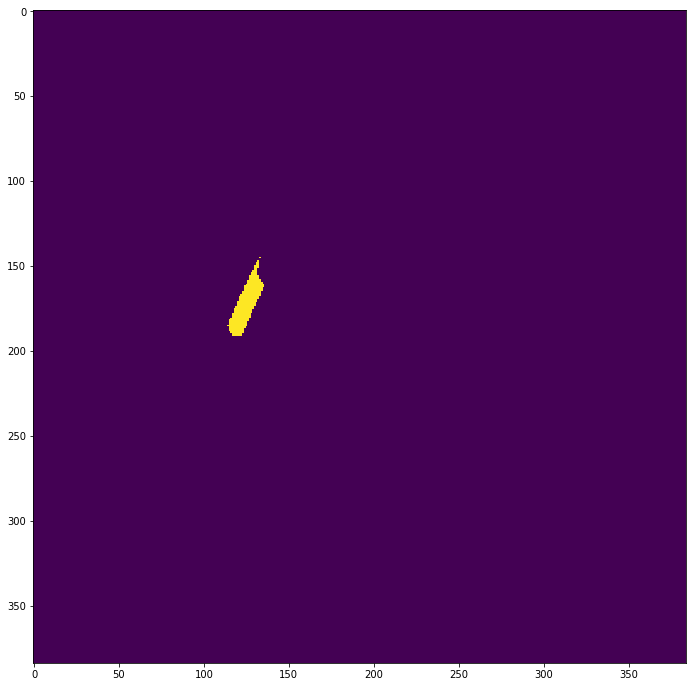

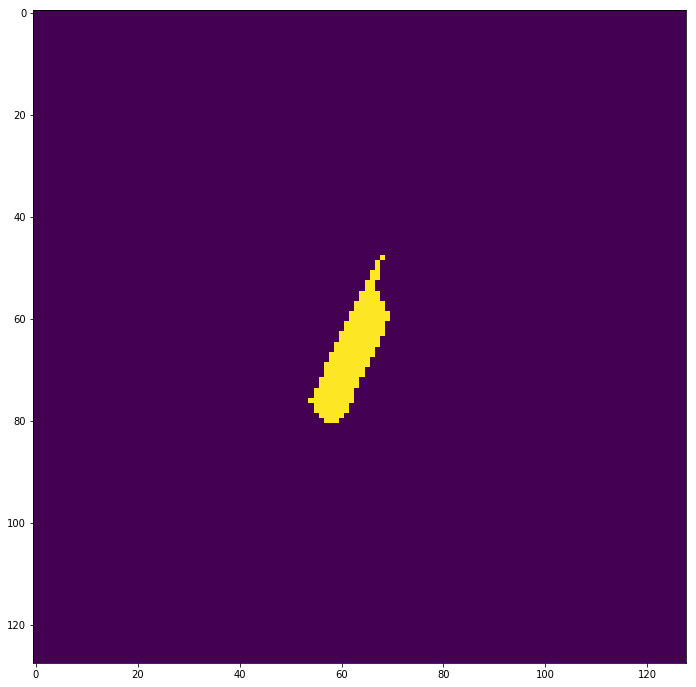

 10%|█         | 3/30 [00:09<01:29,  3.30s/it]

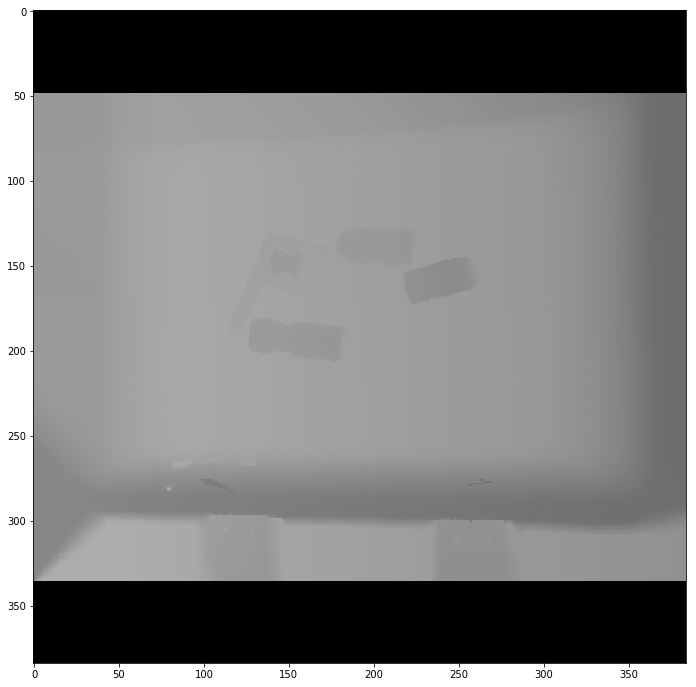

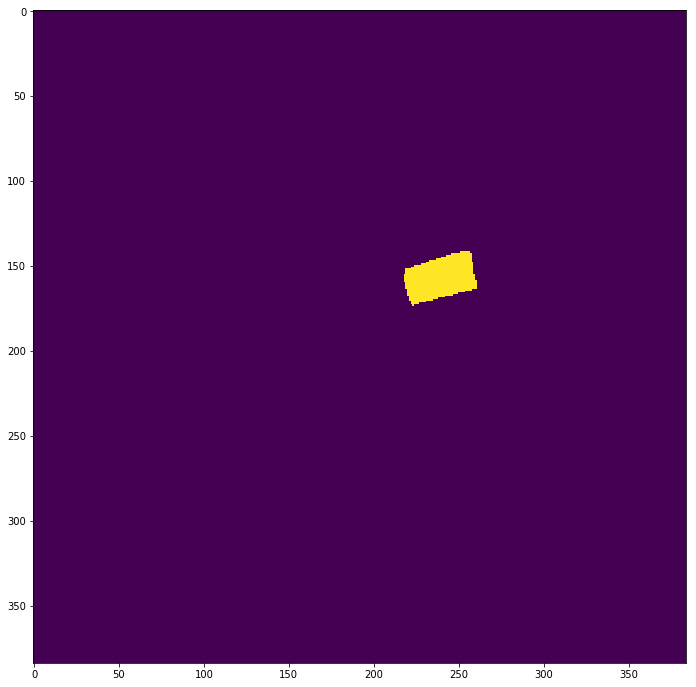

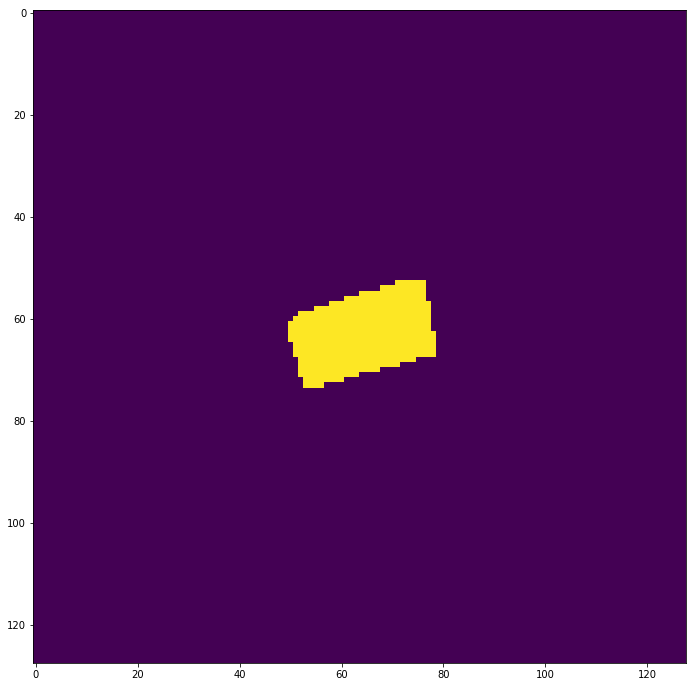

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000003

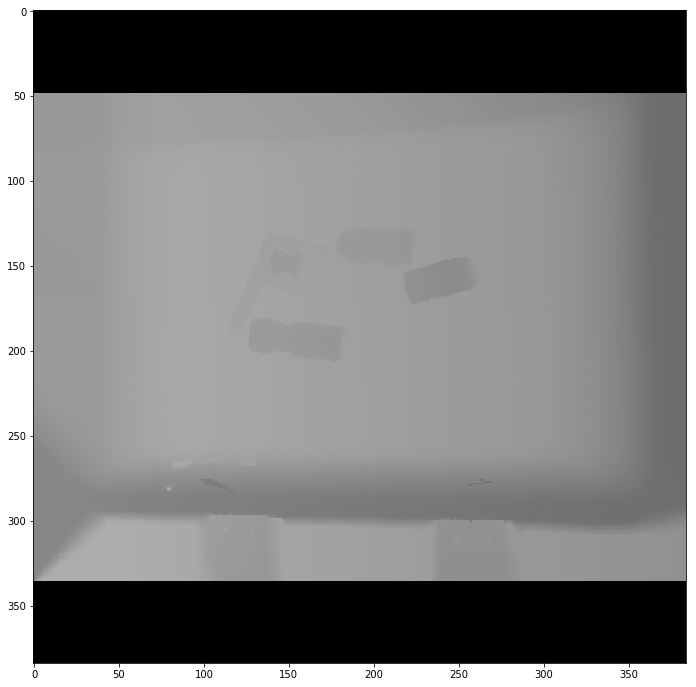

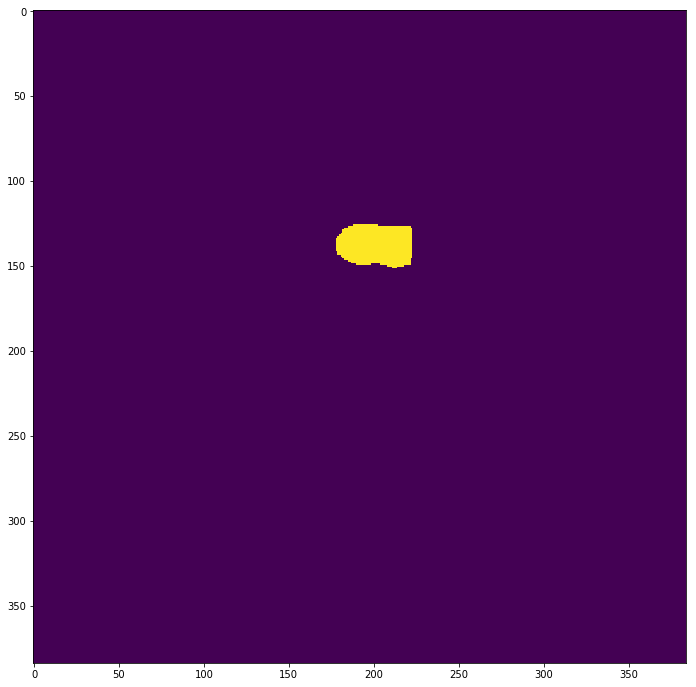

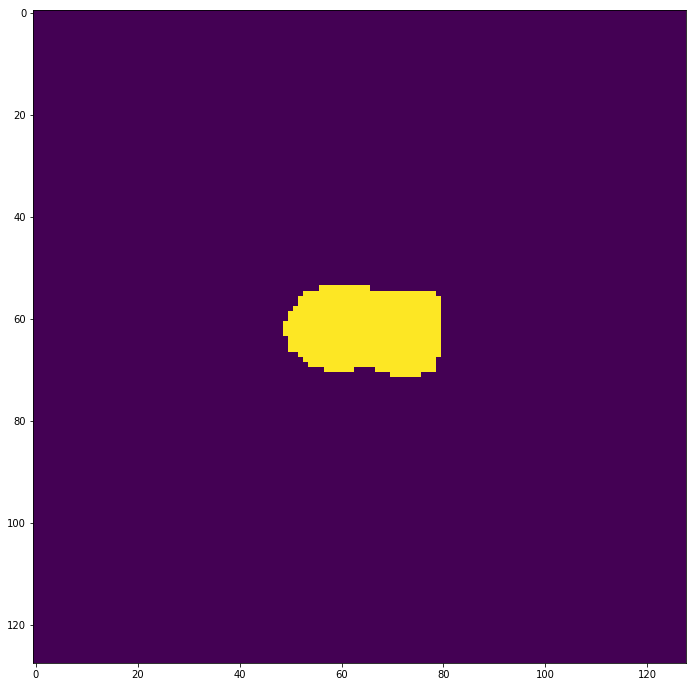

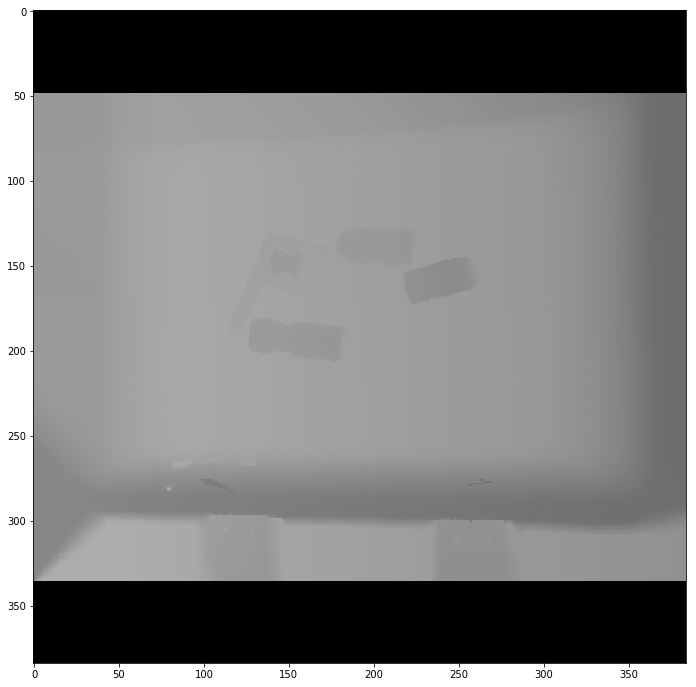

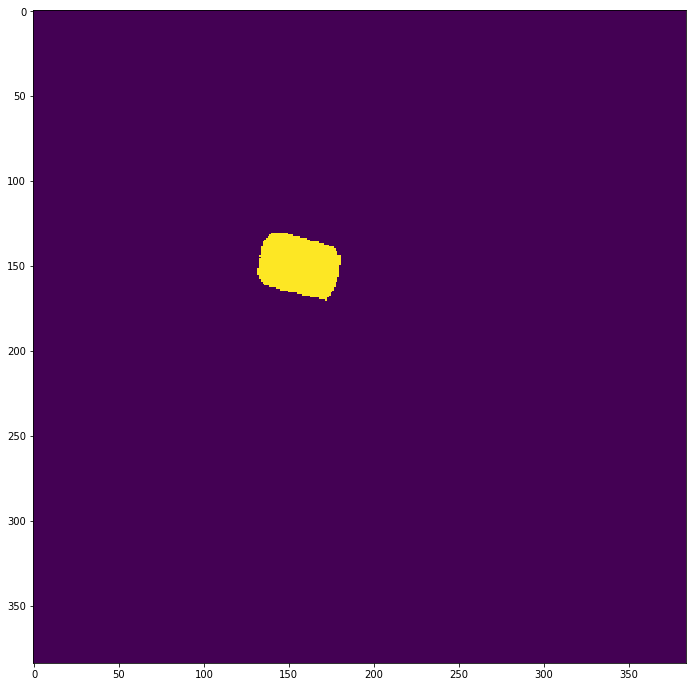

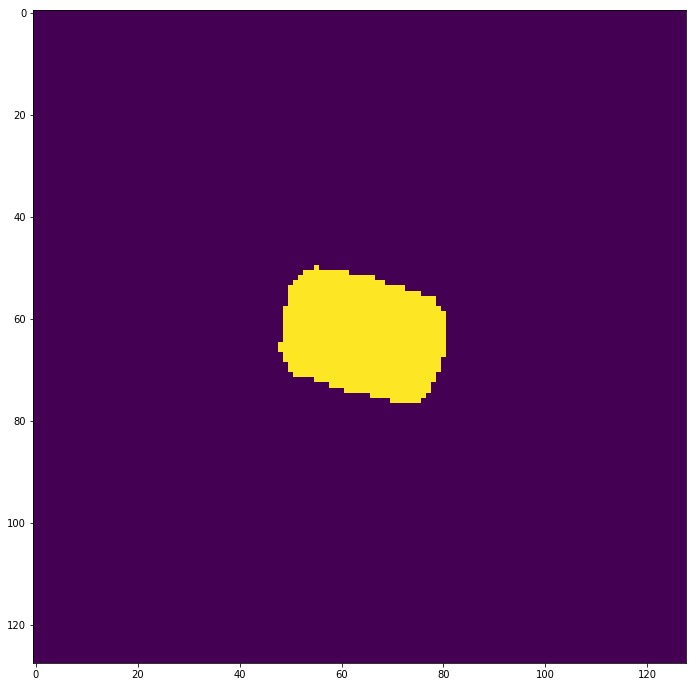

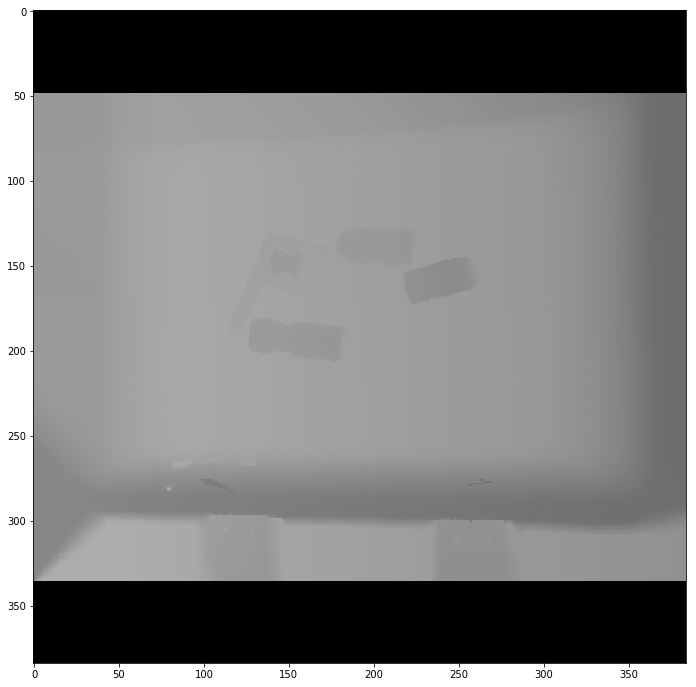

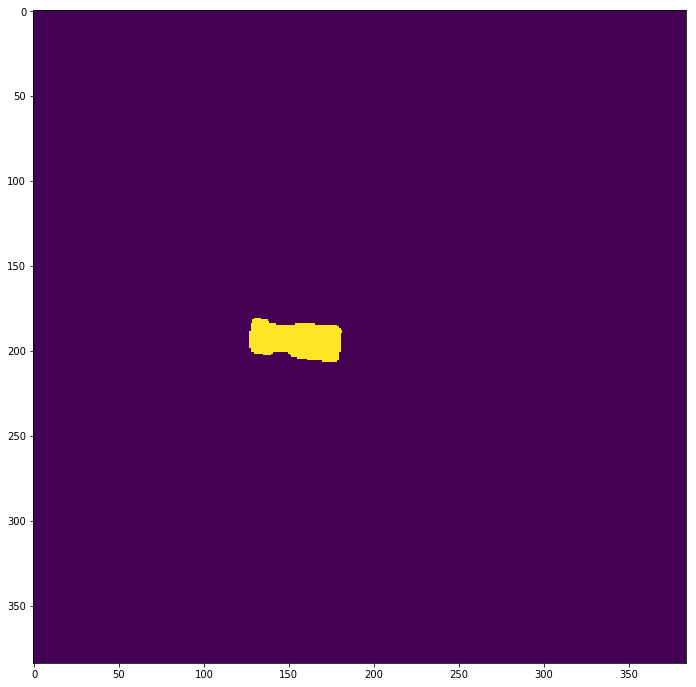

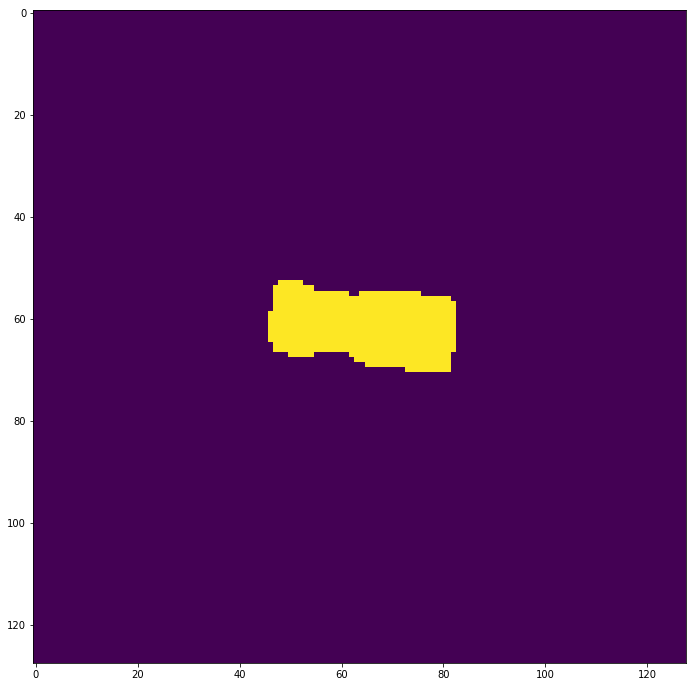

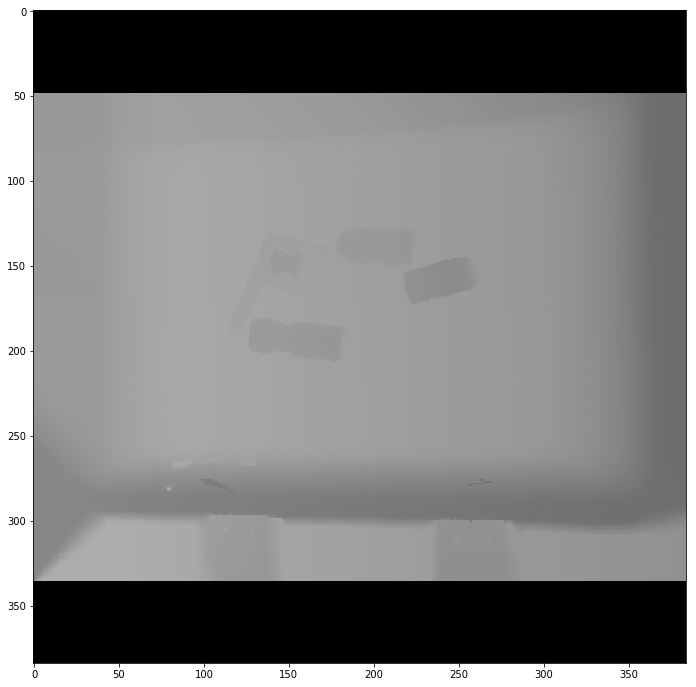

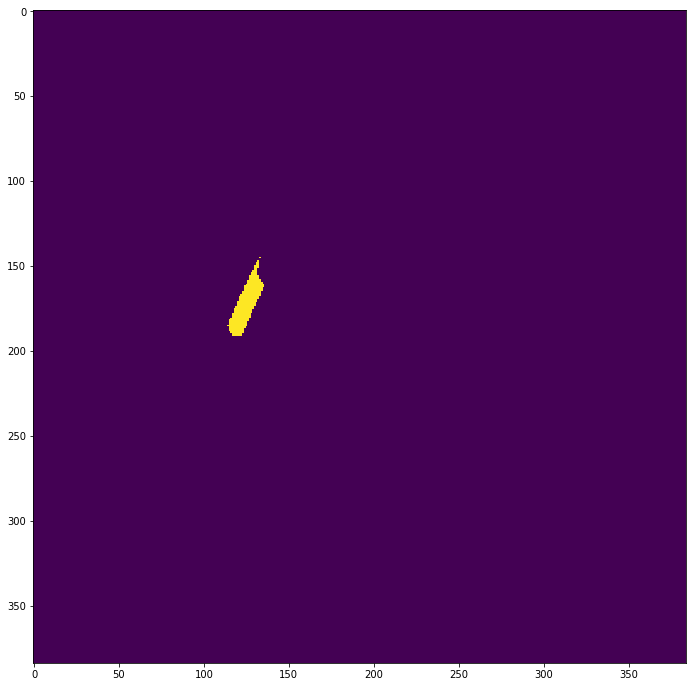

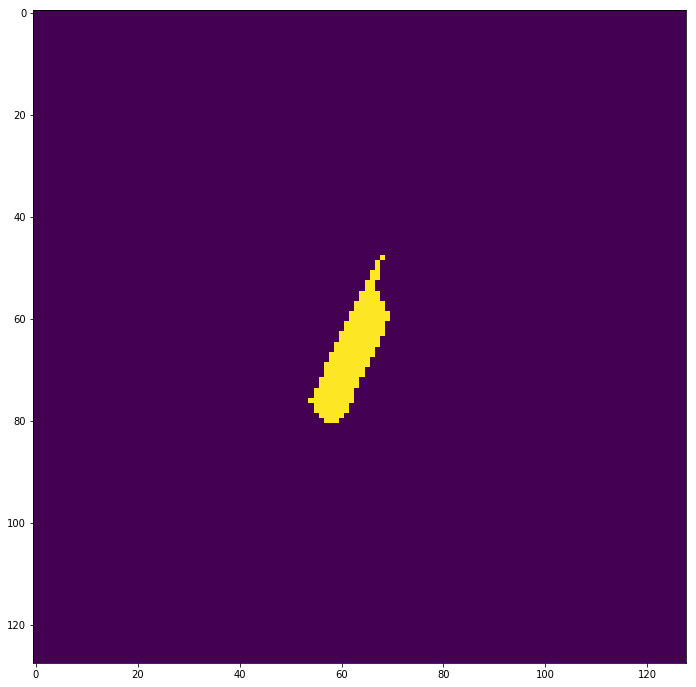

 13%|█▎        | 4/30 [00:12<01:24,  3.26s/it]

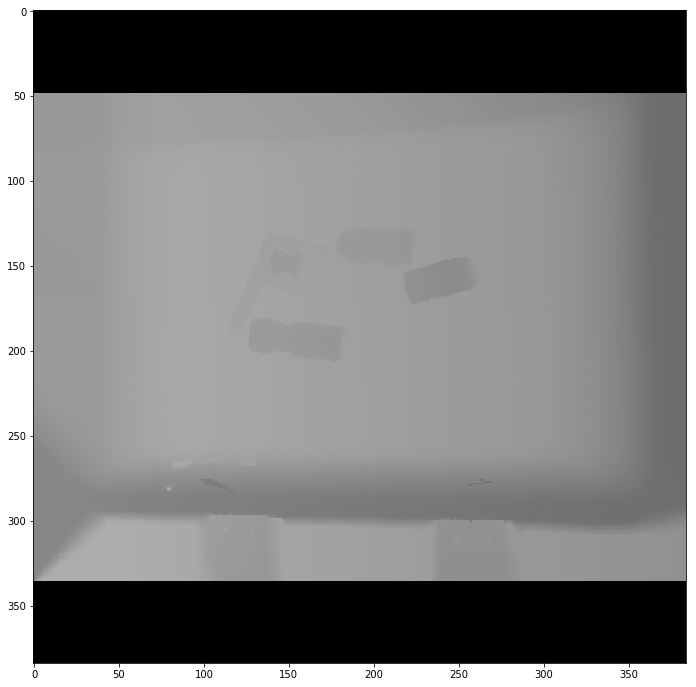

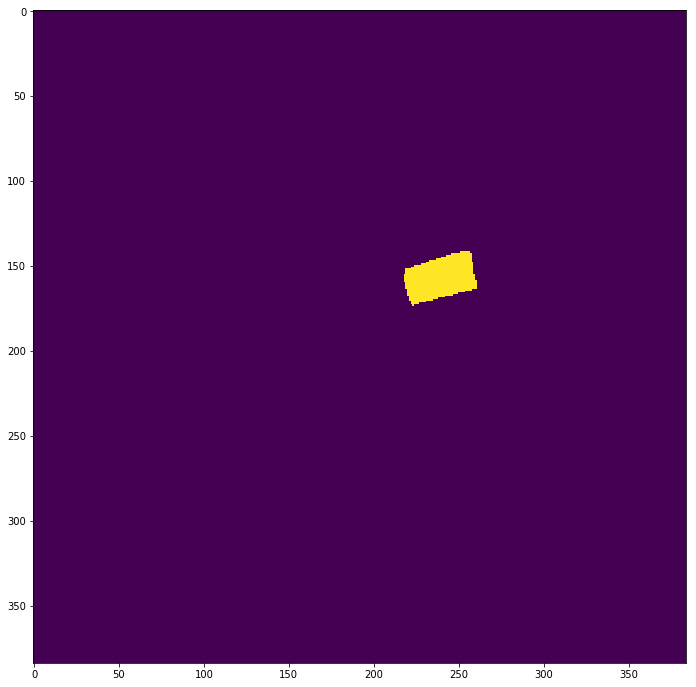

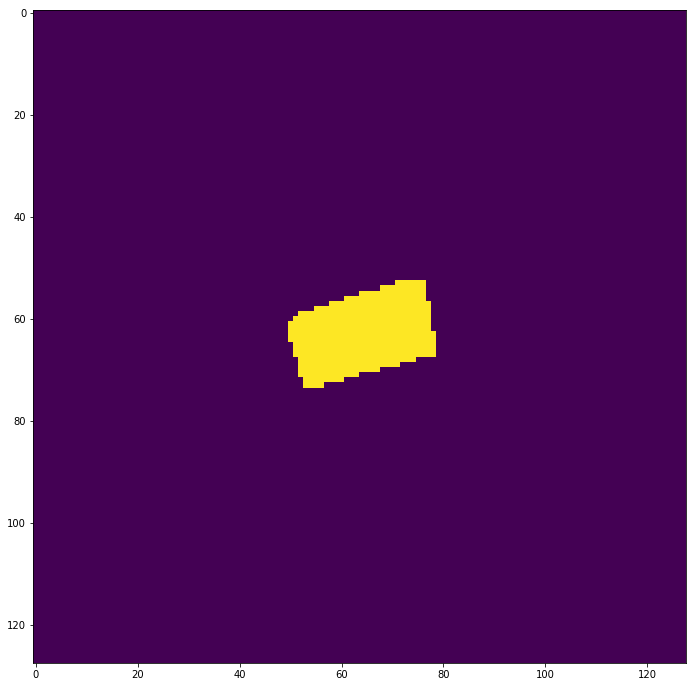

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000004

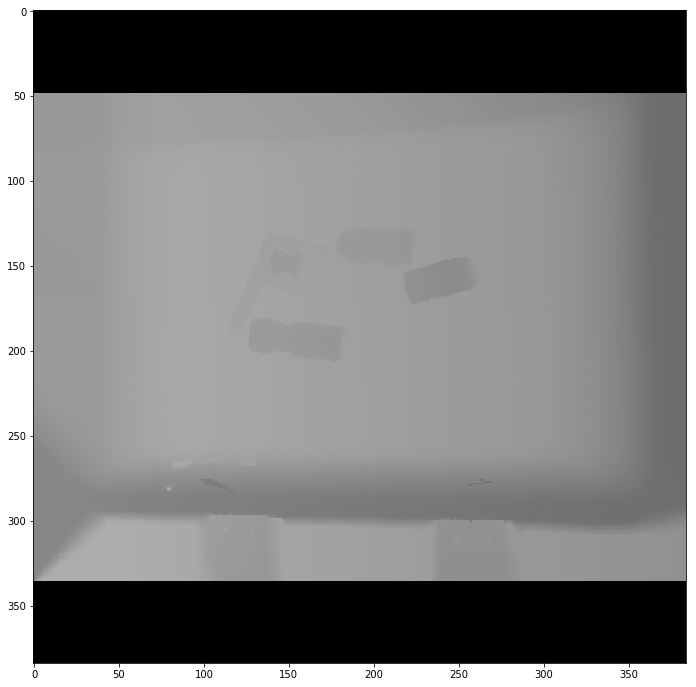

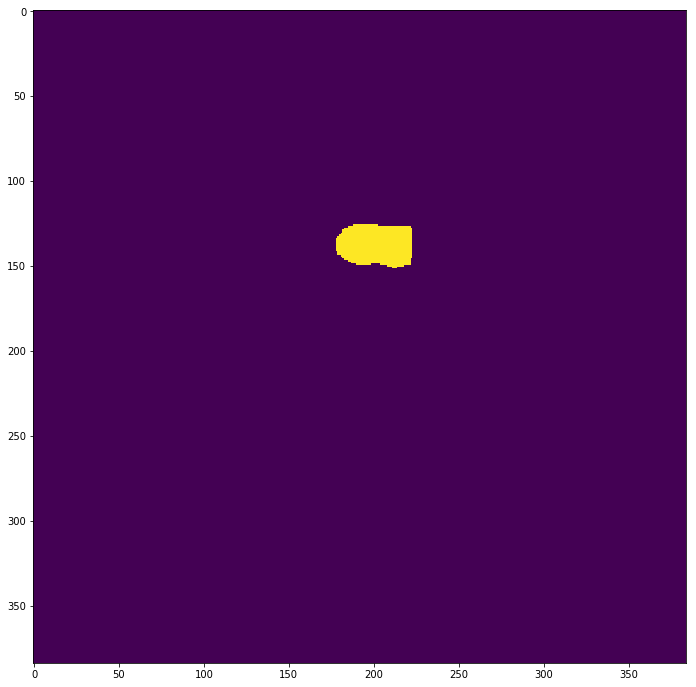

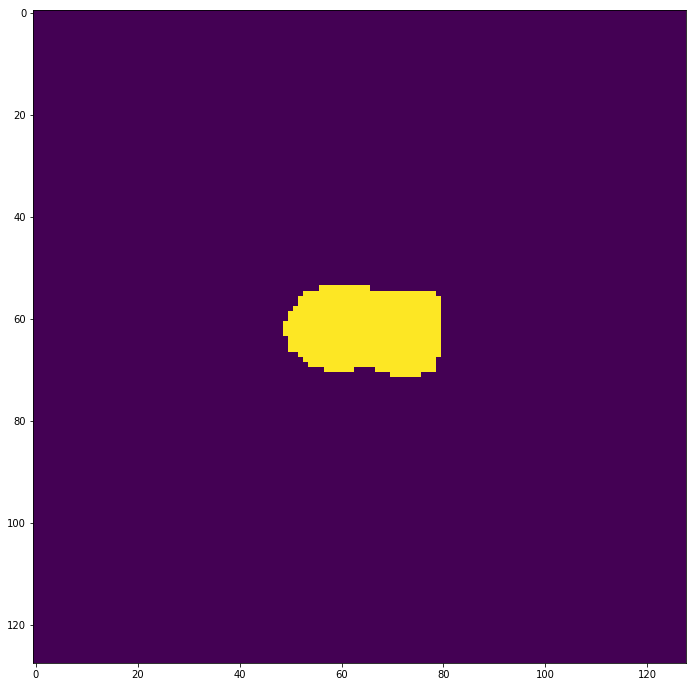

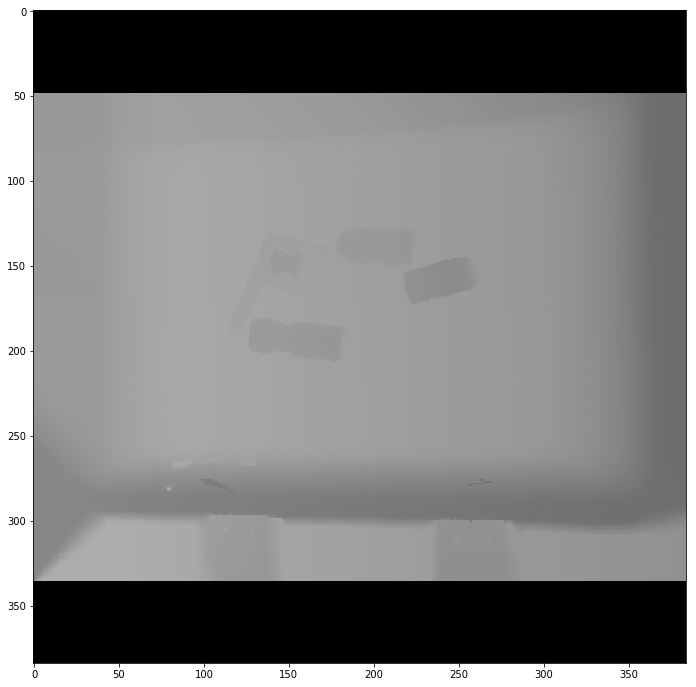

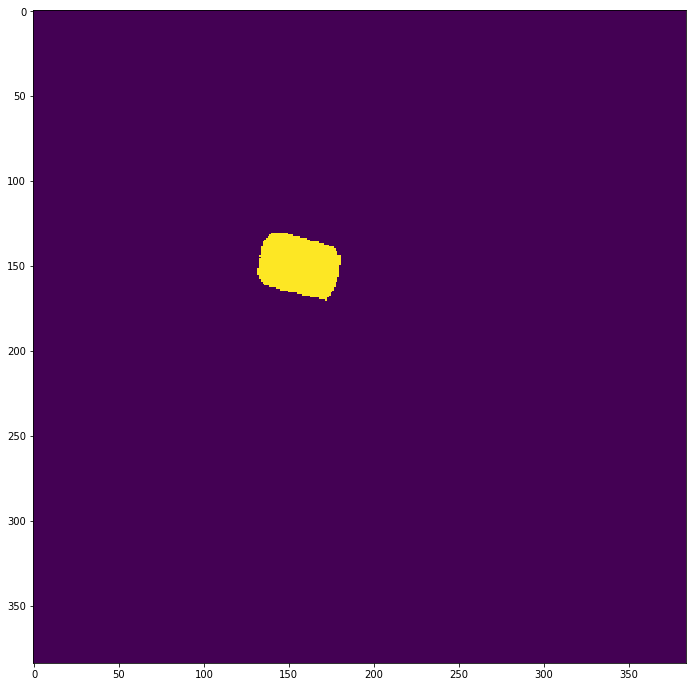

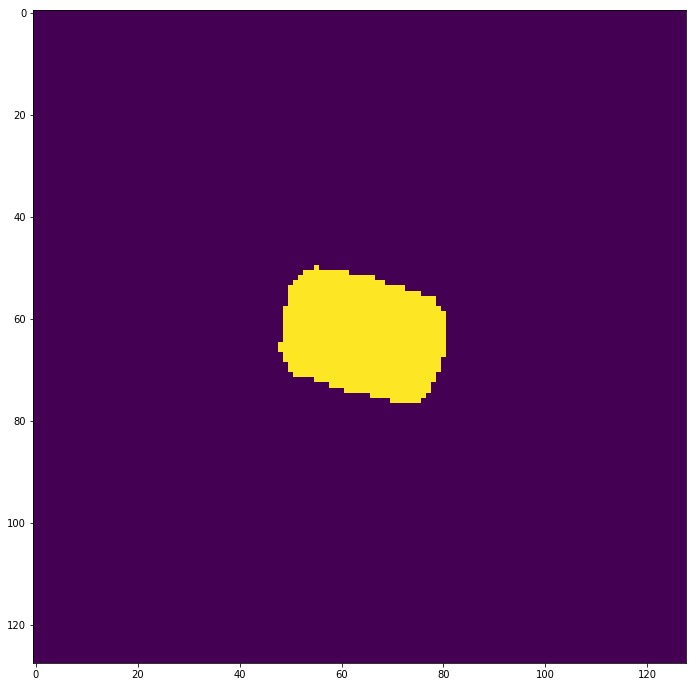

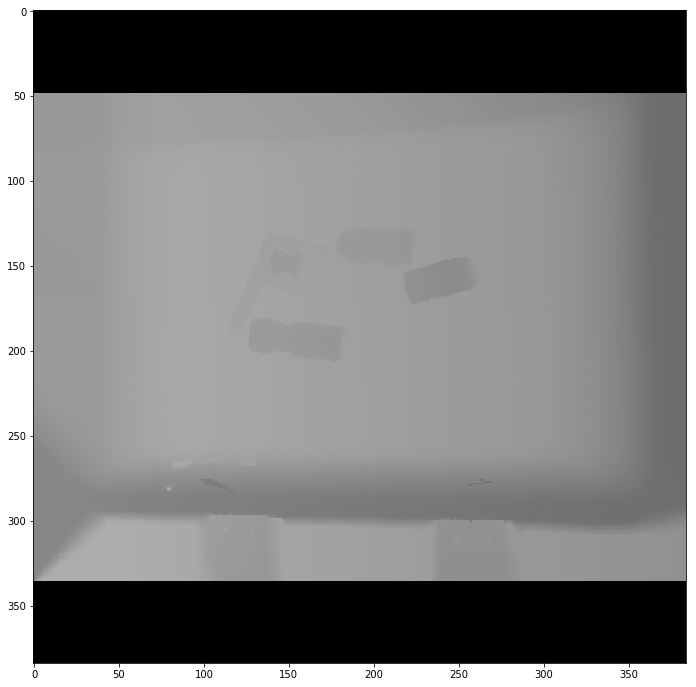

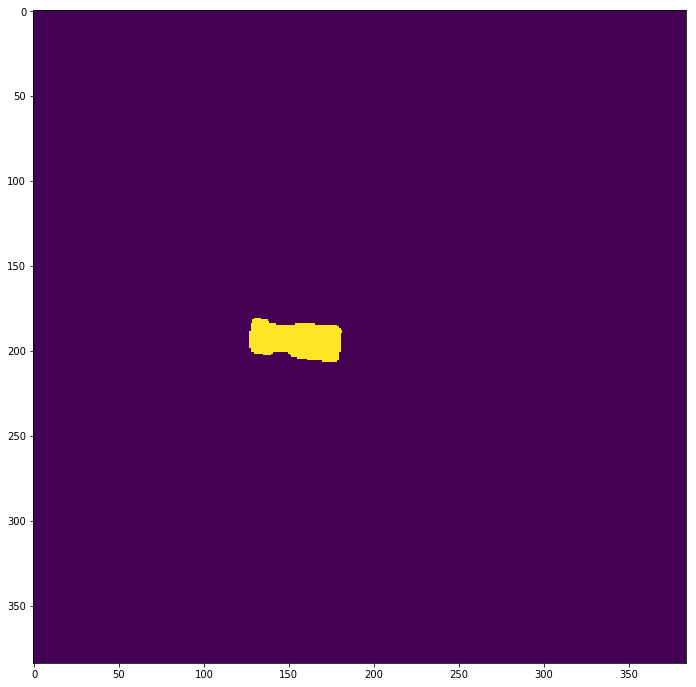

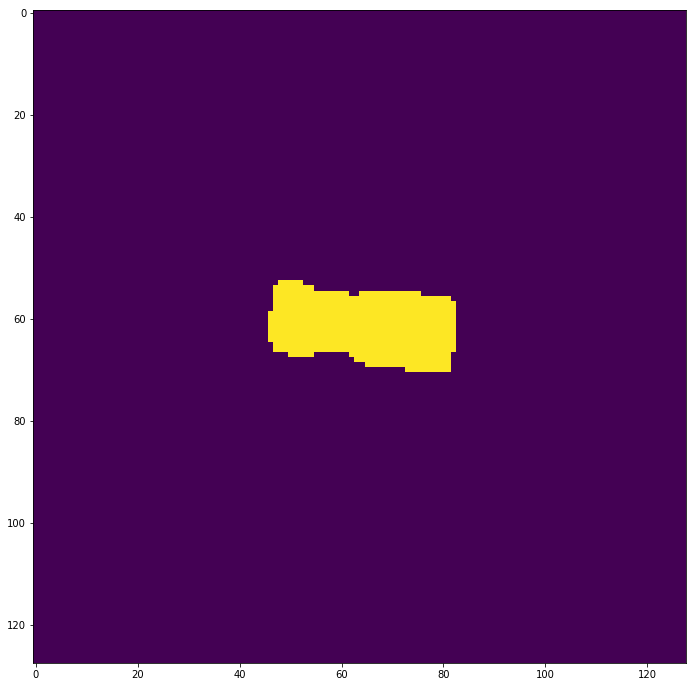

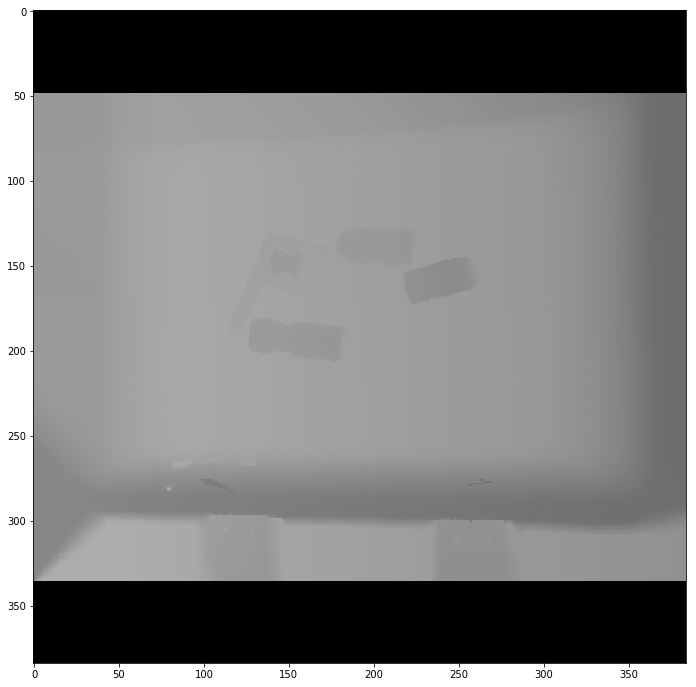

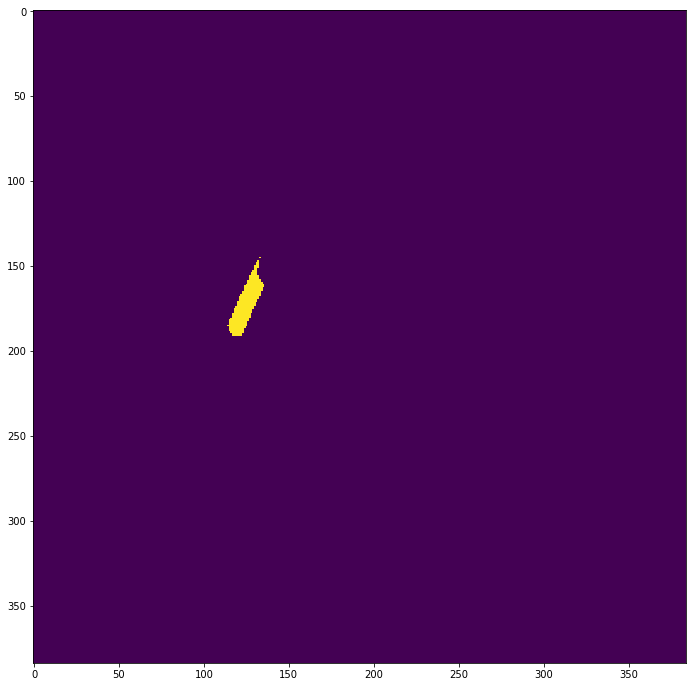

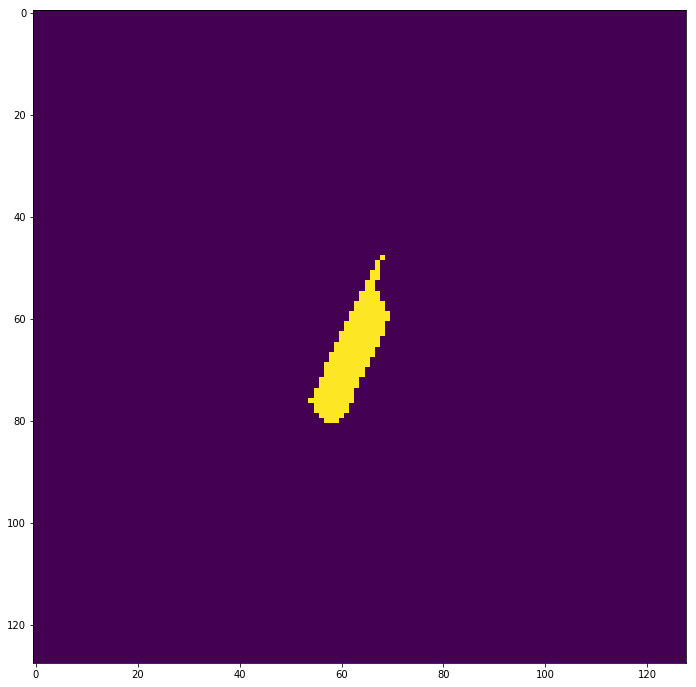

 17%|█▋        | 5/30 [00:16<01:20,  3.21s/it]

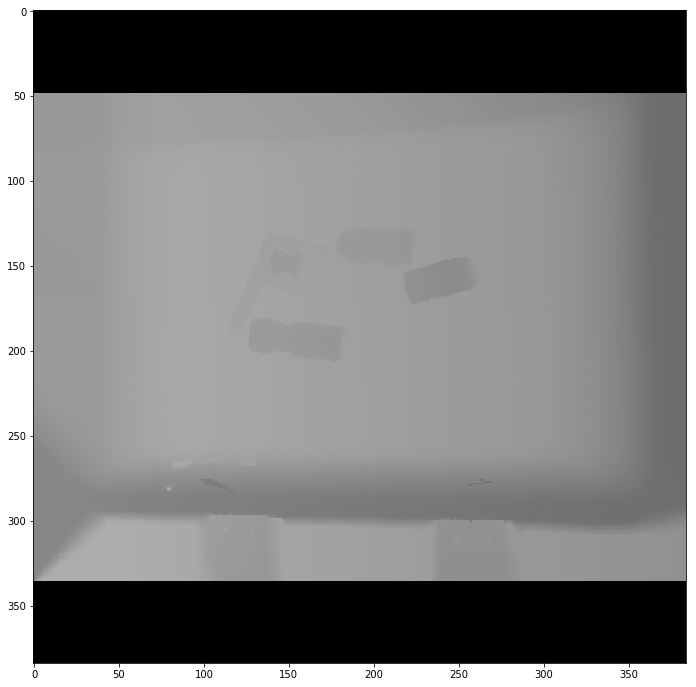

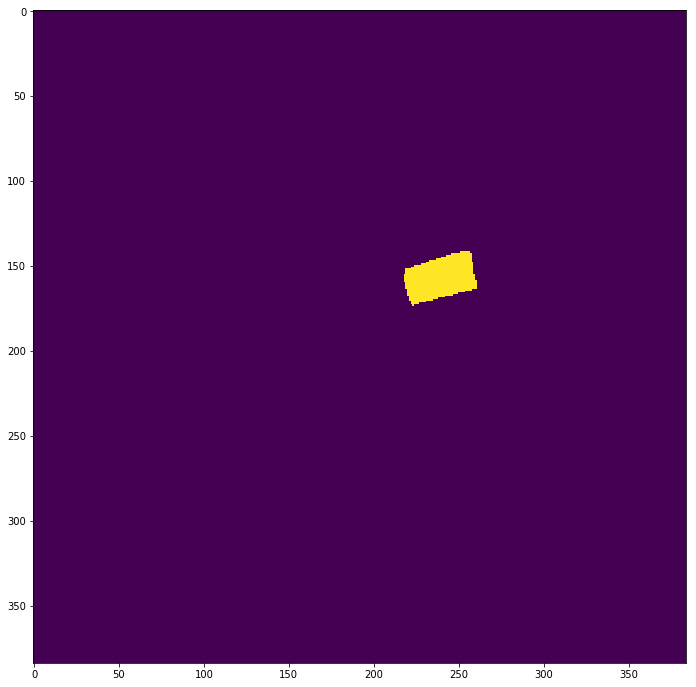

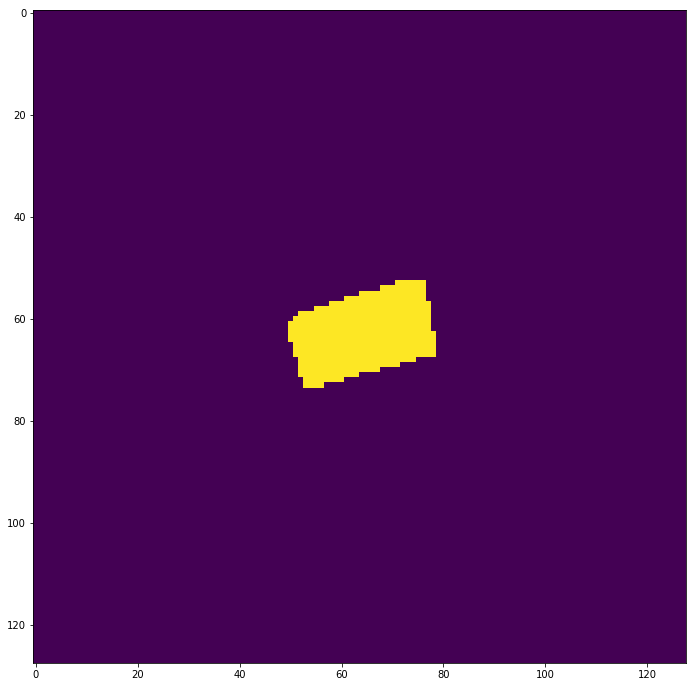

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000005

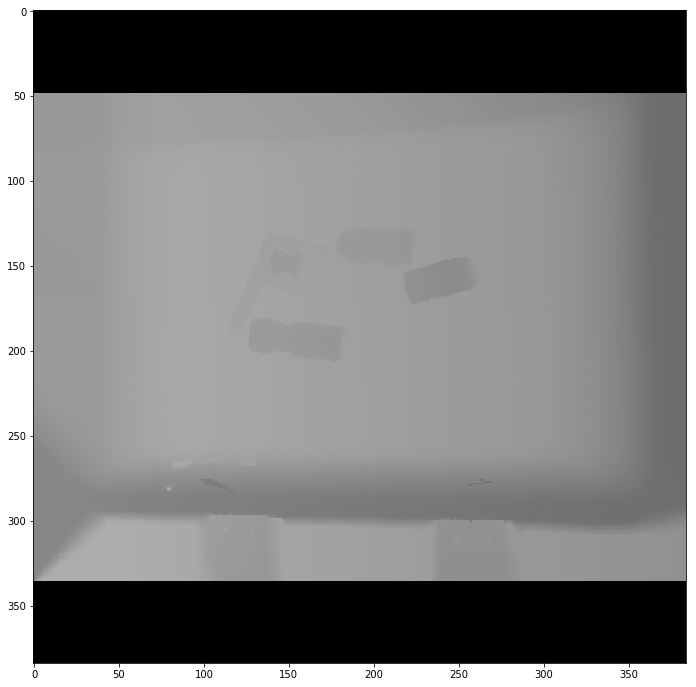

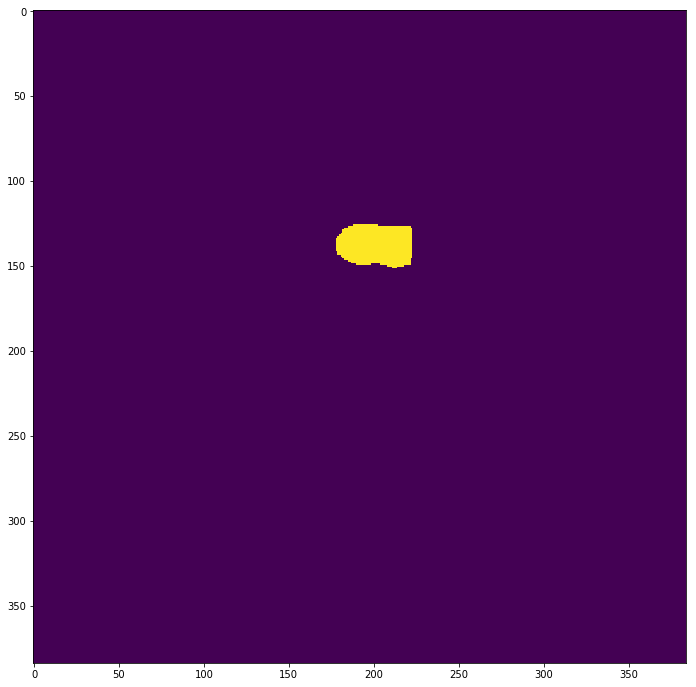

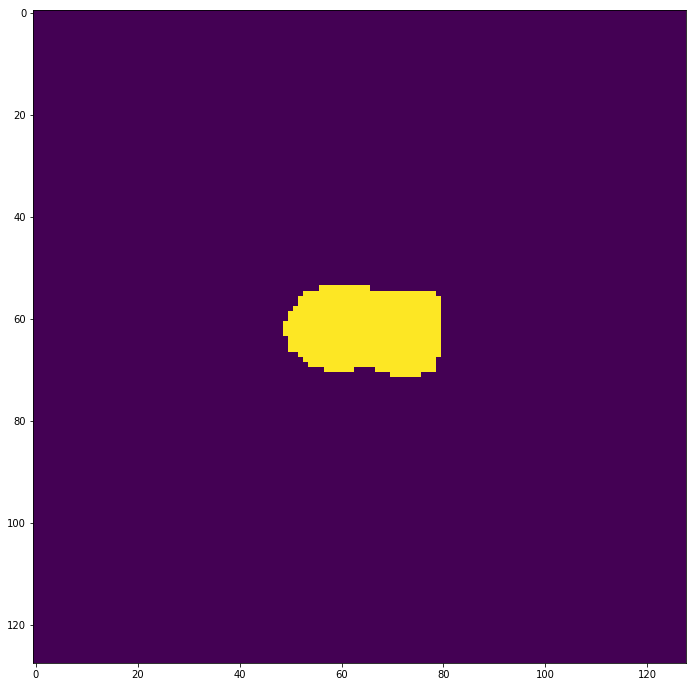

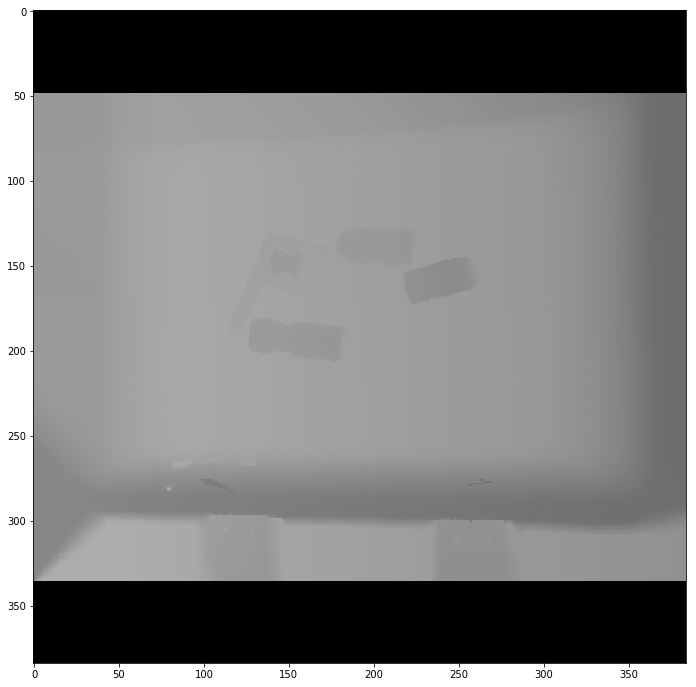

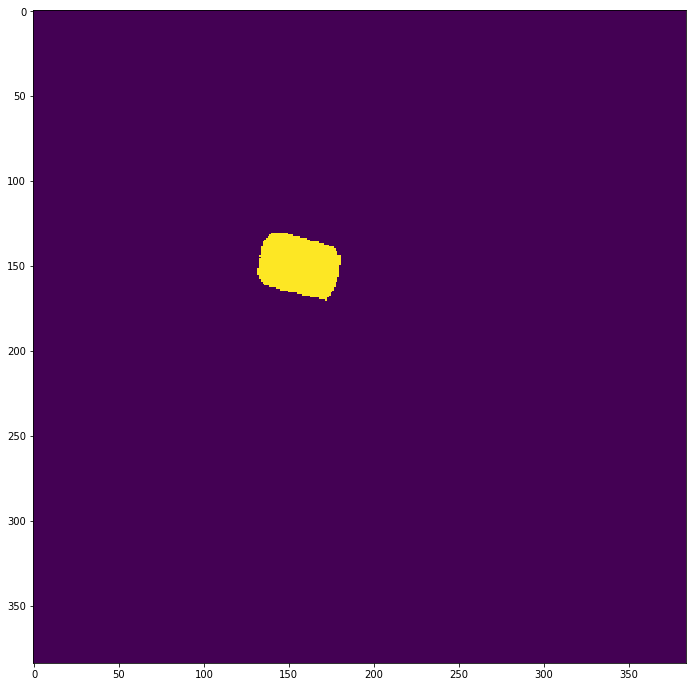

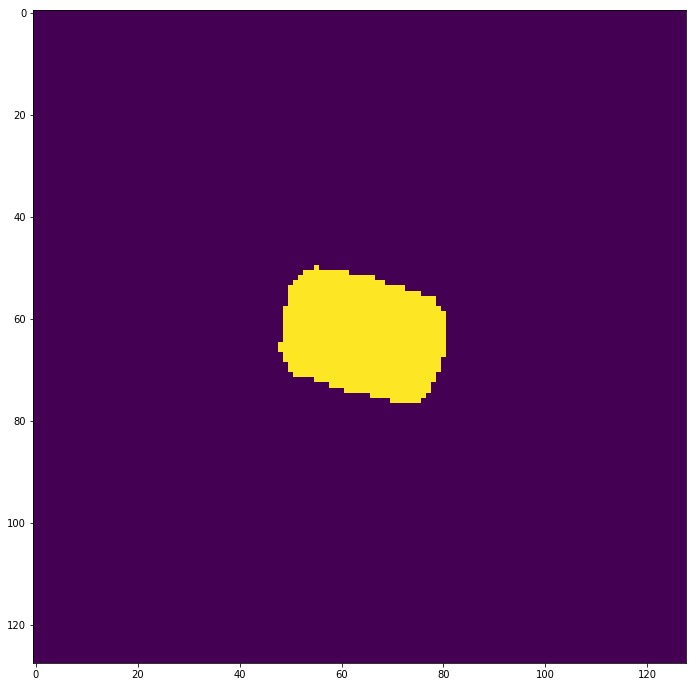

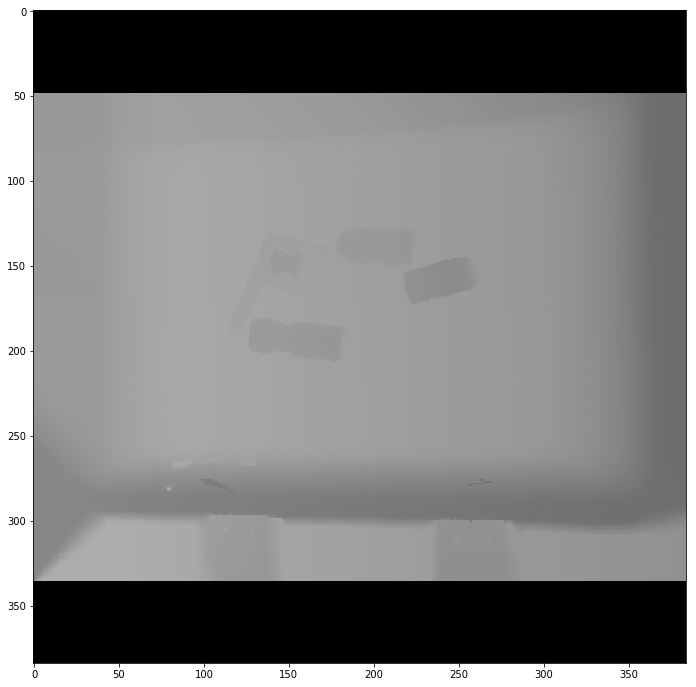

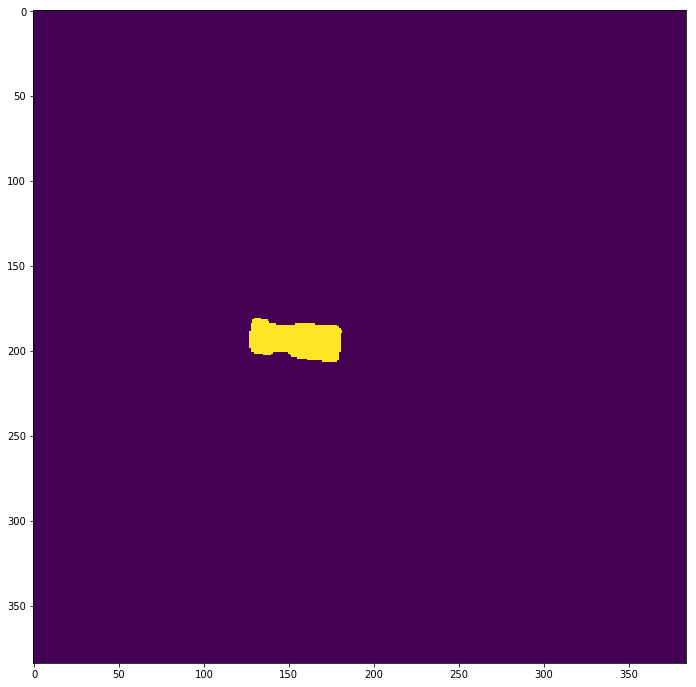

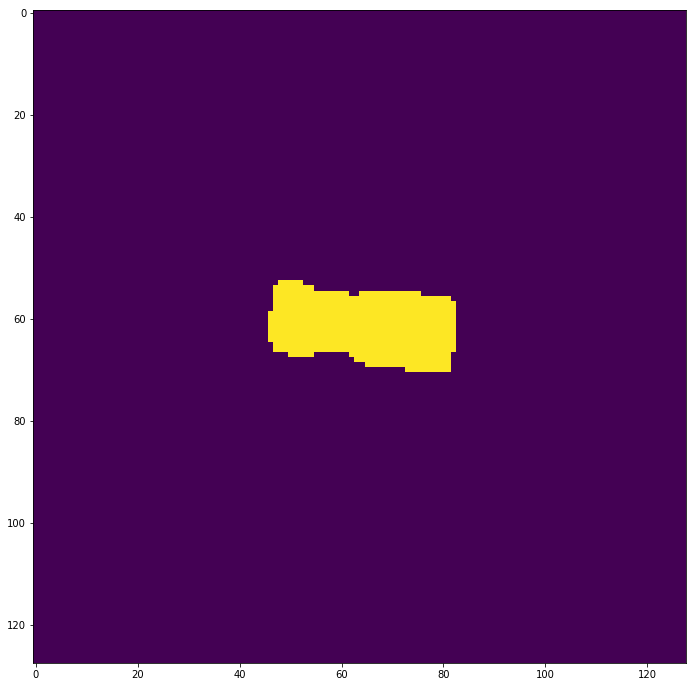

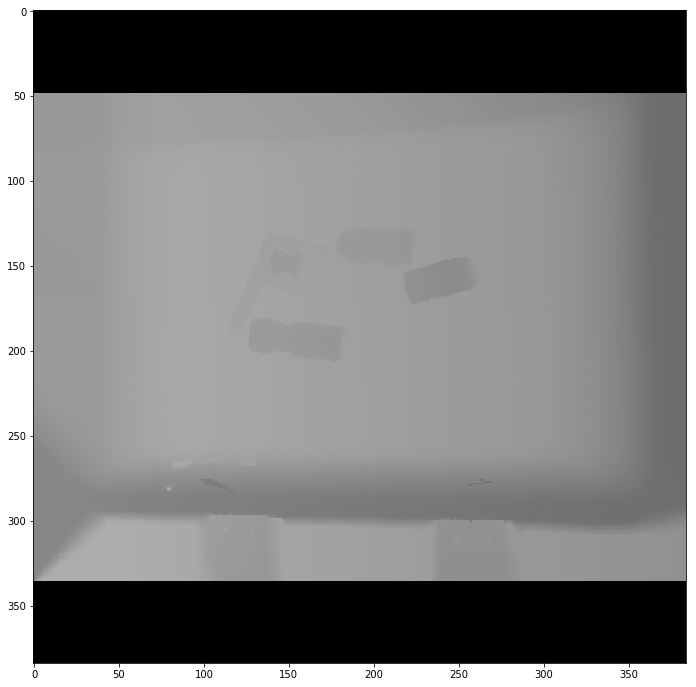

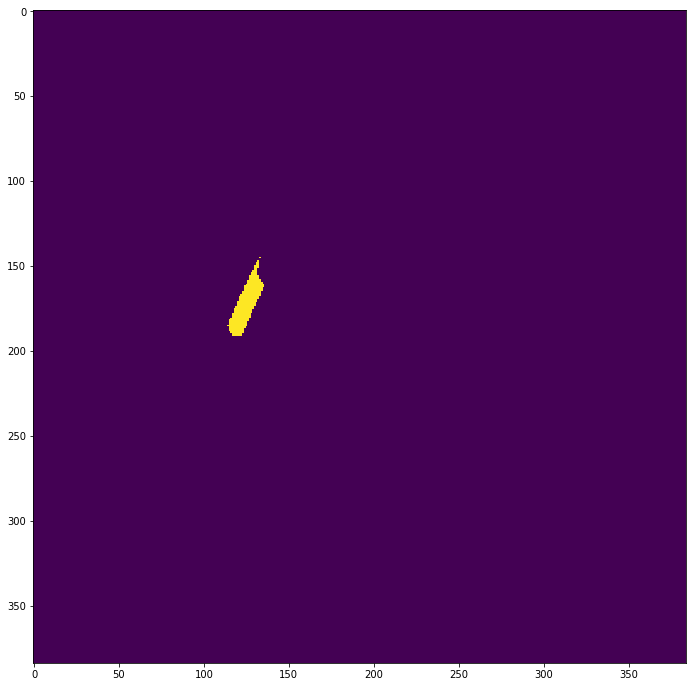

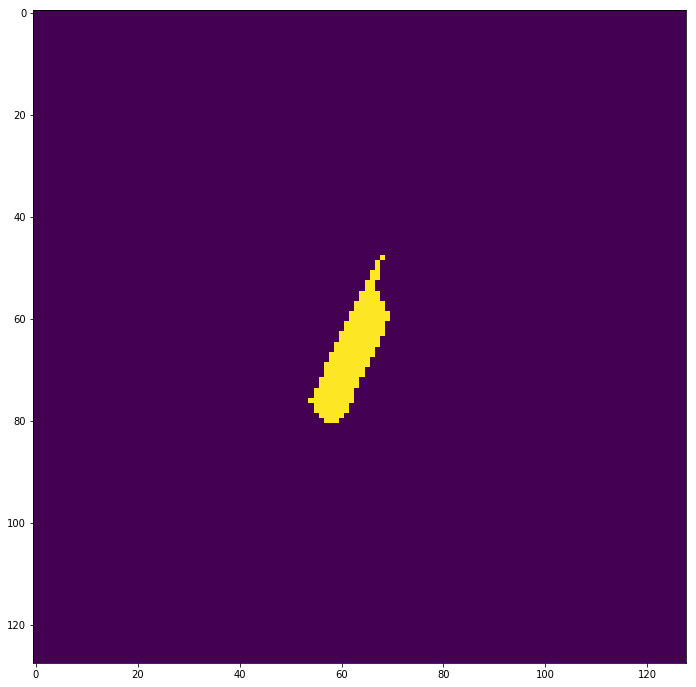

 20%|██        | 6/30 [00:19<01:16,  3.18s/it]

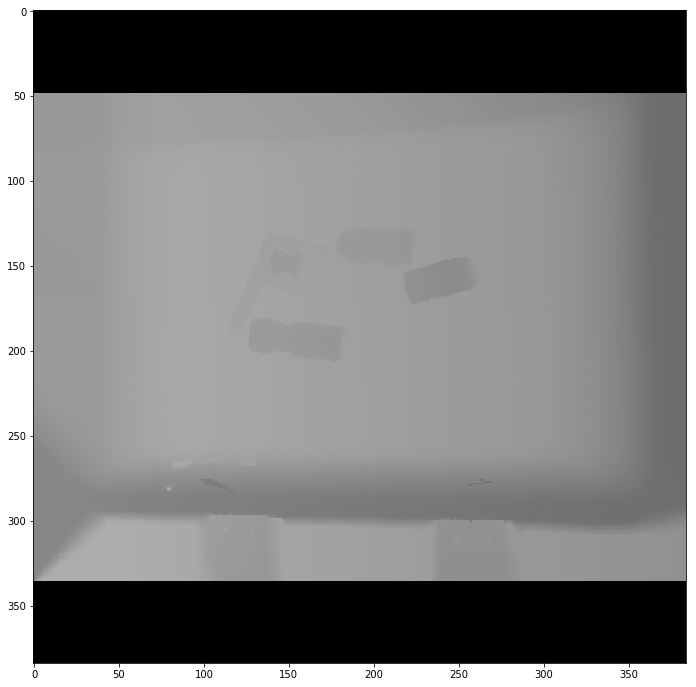

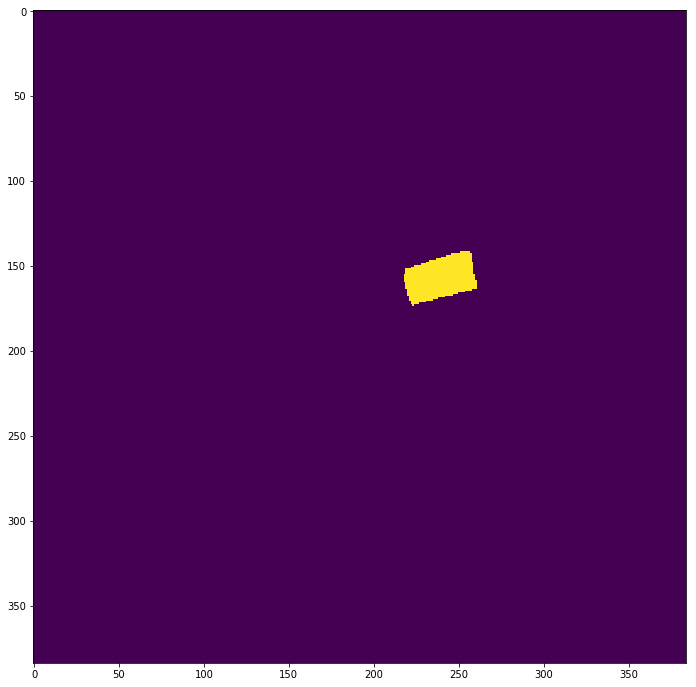

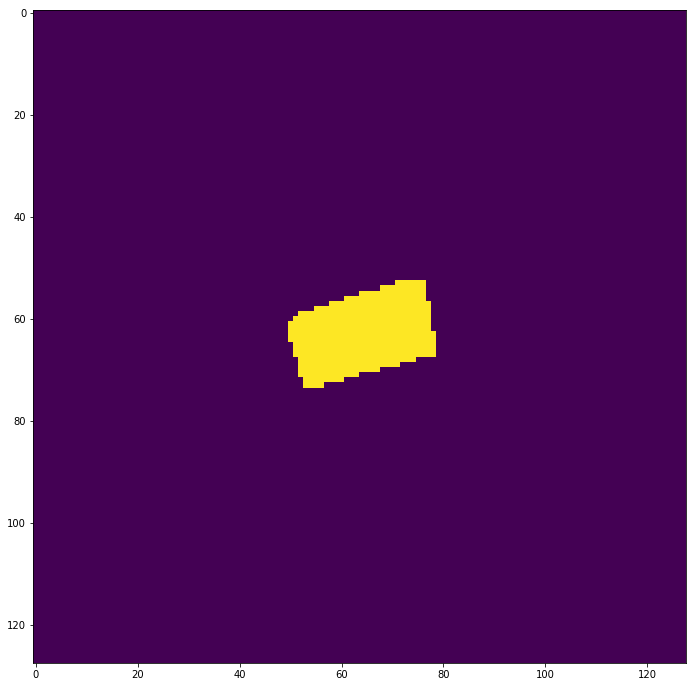

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000006

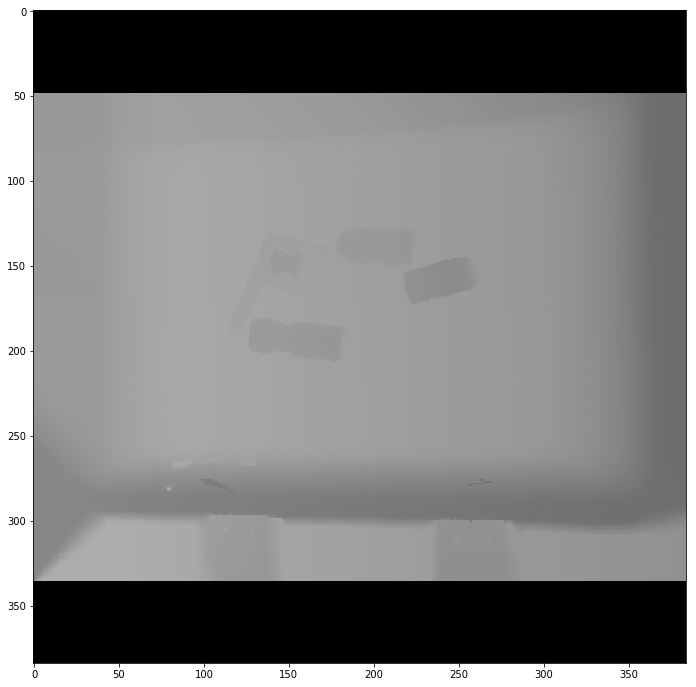

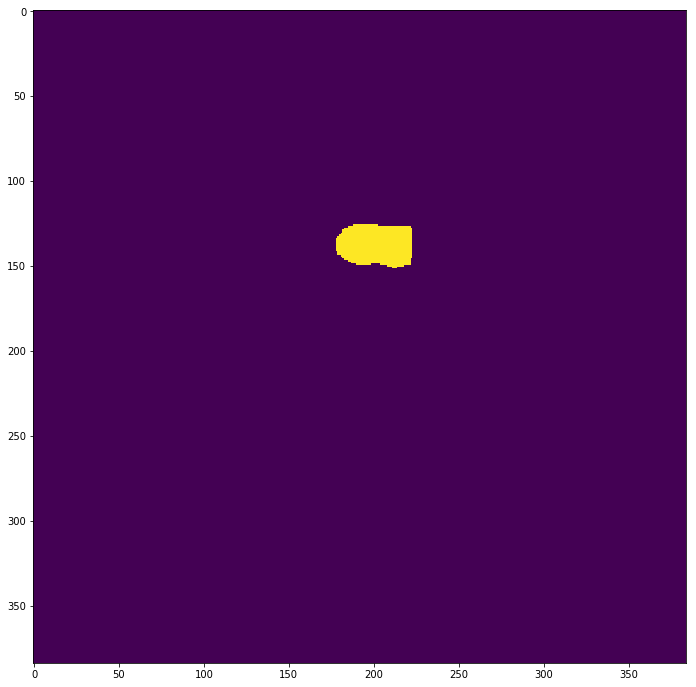

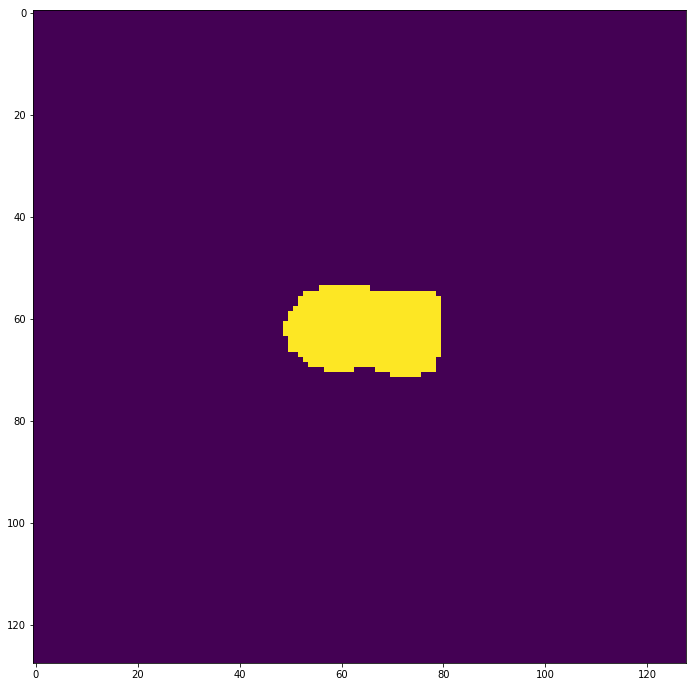

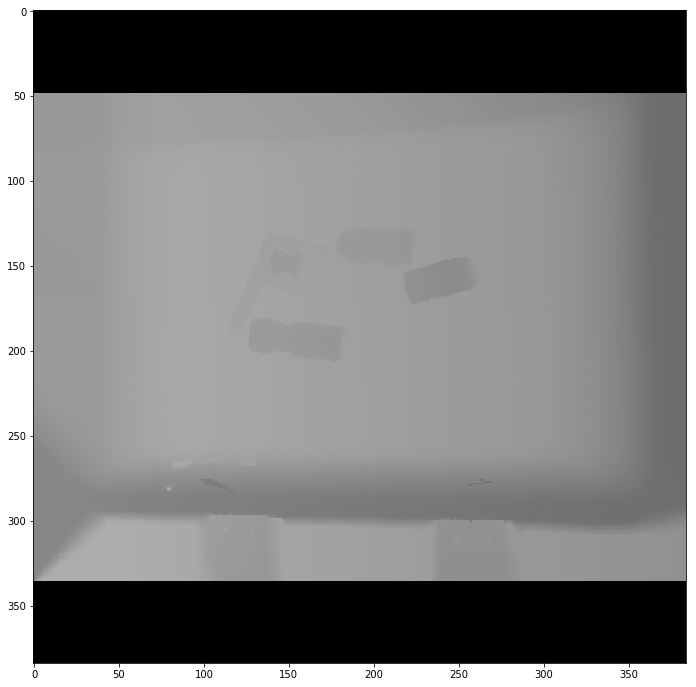

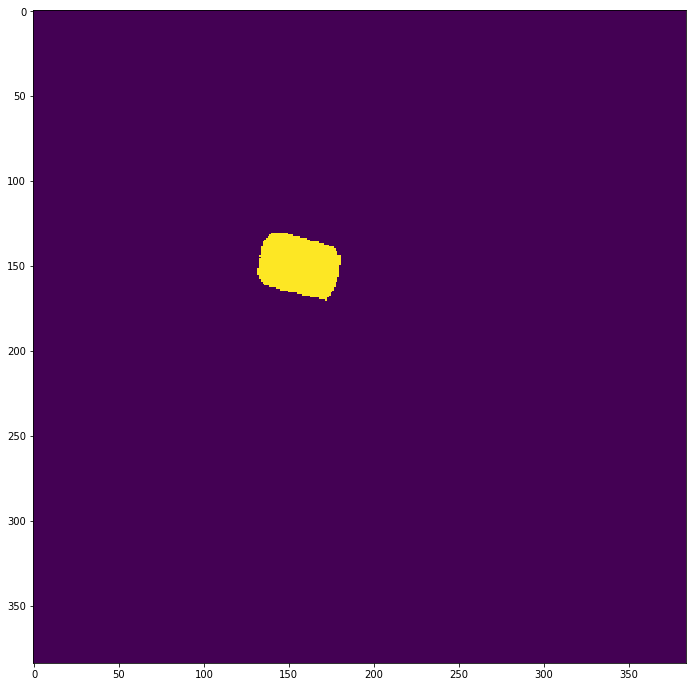

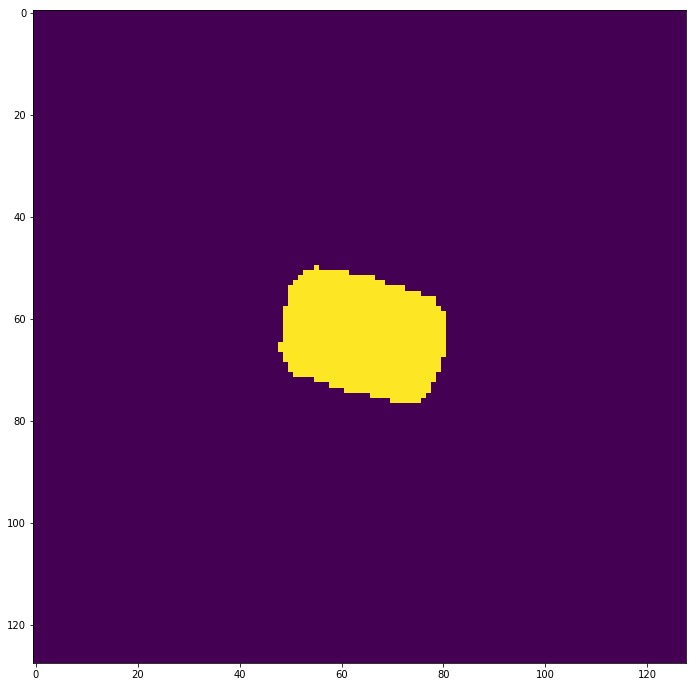

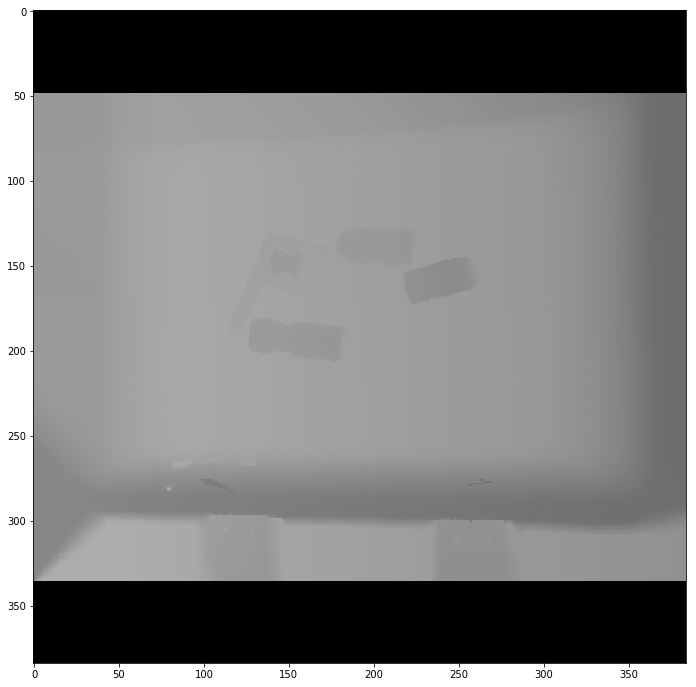

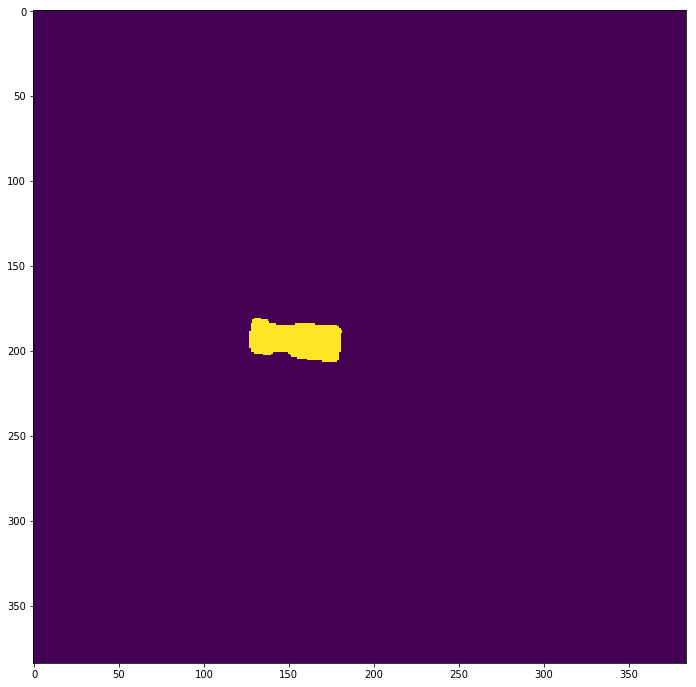

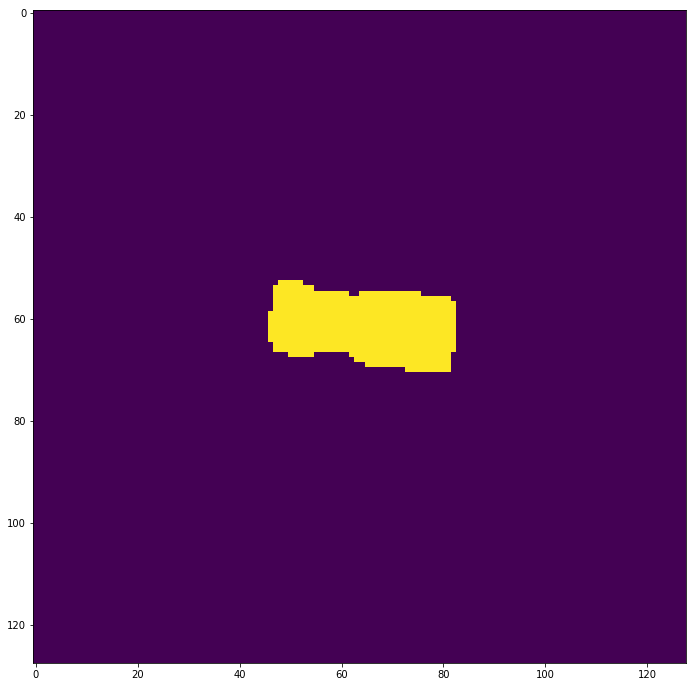

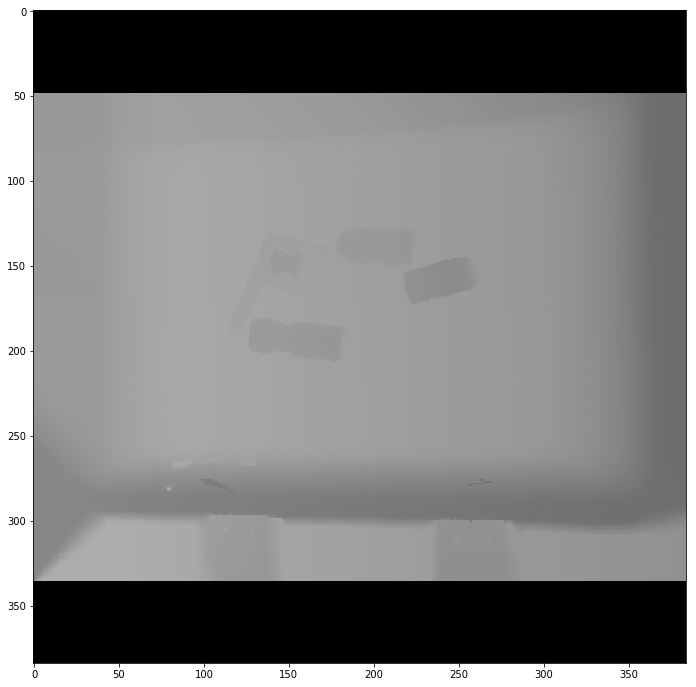

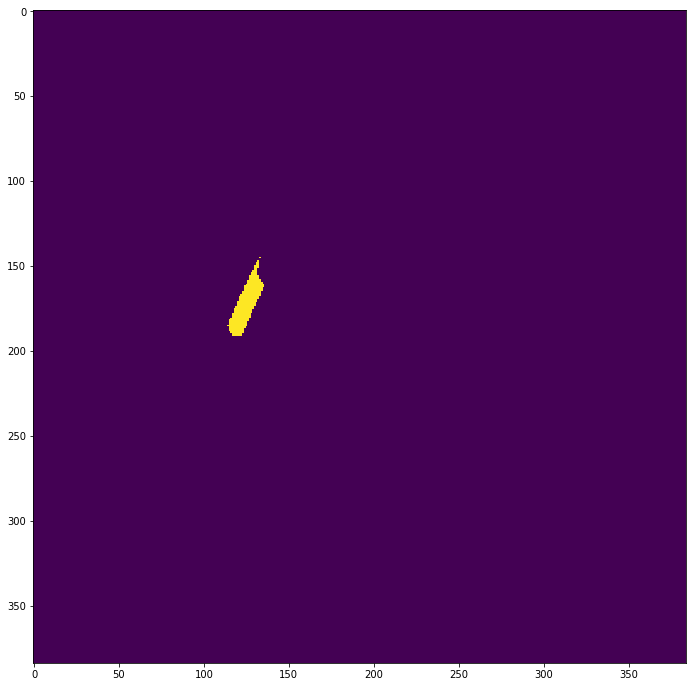

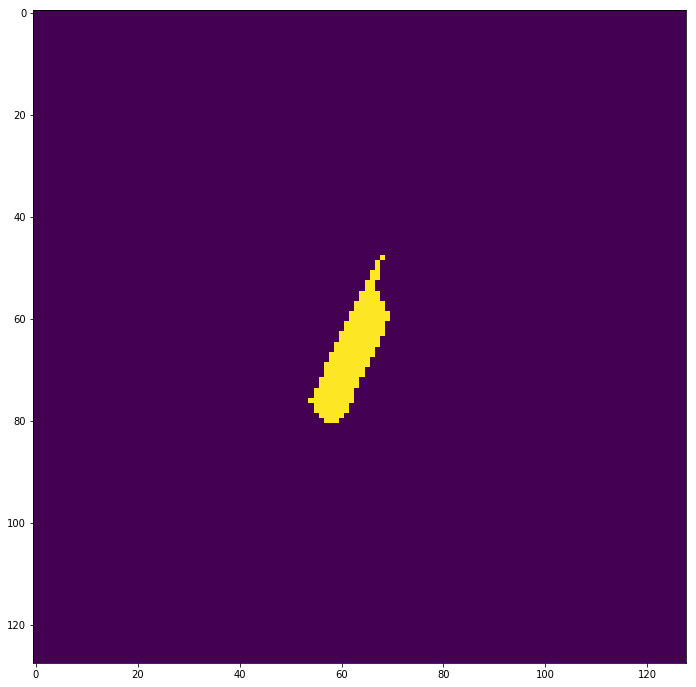

 23%|██▎       | 7/30 [00:22<01:13,  3.20s/it]

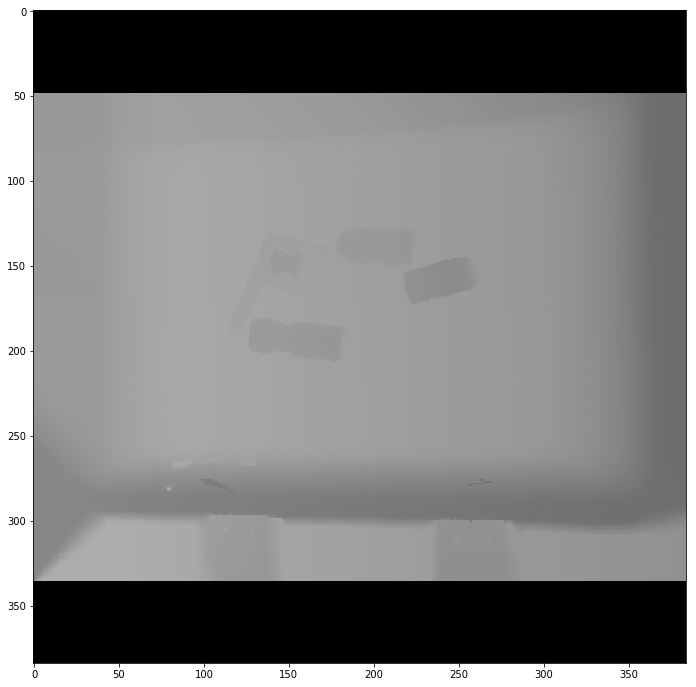

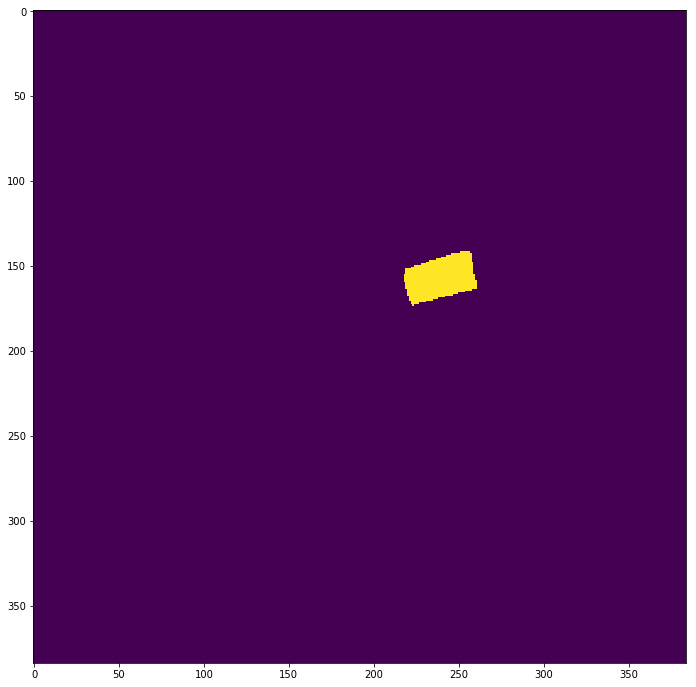

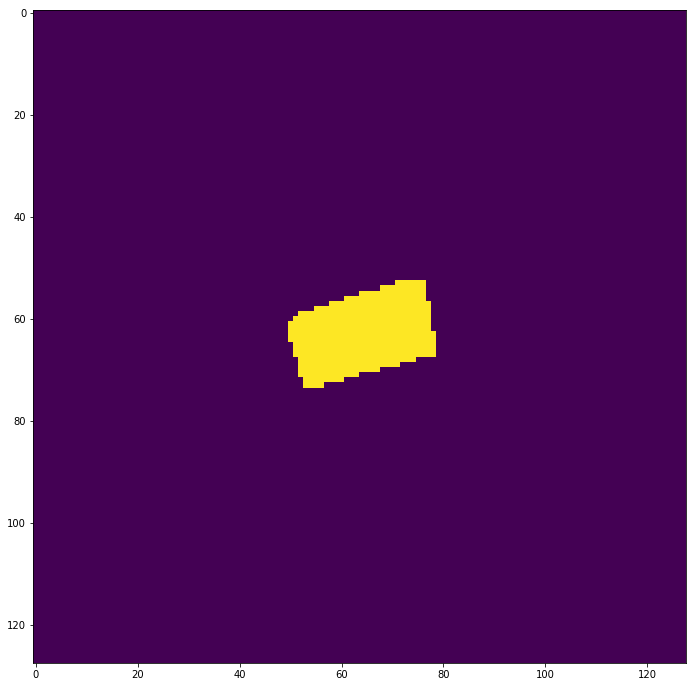

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000007

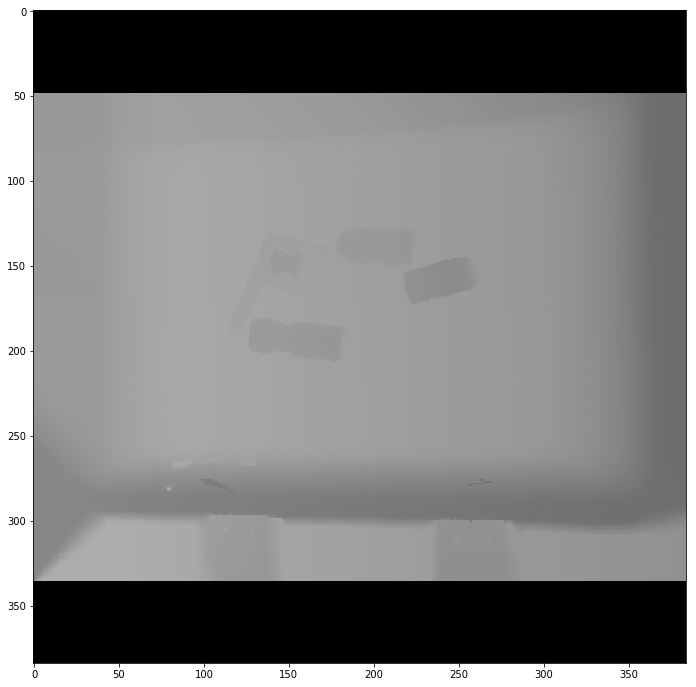

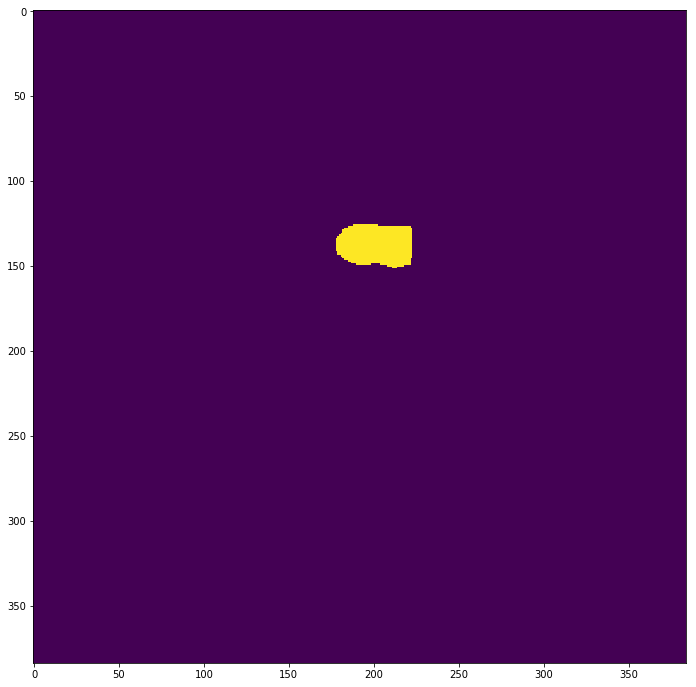

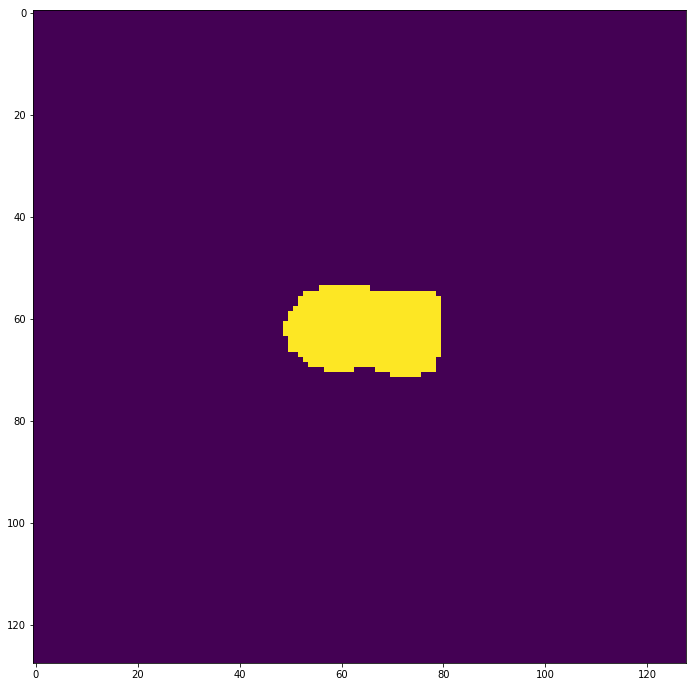

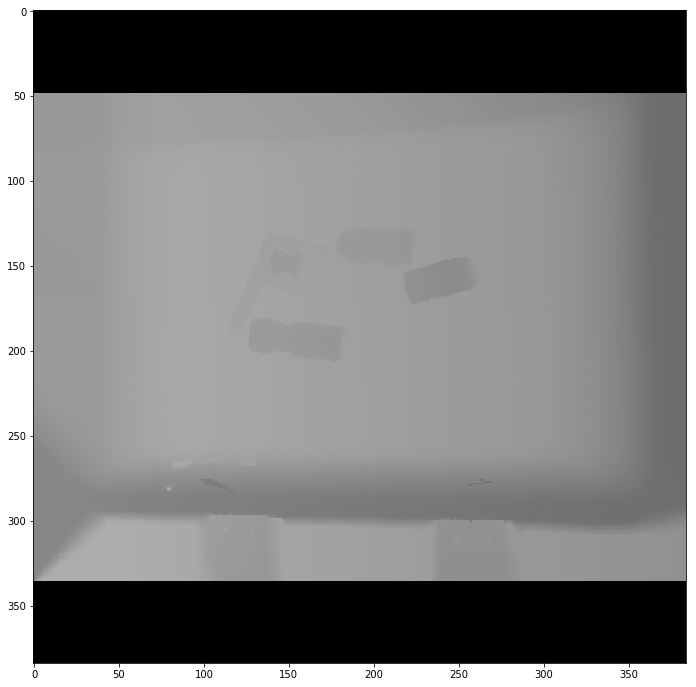

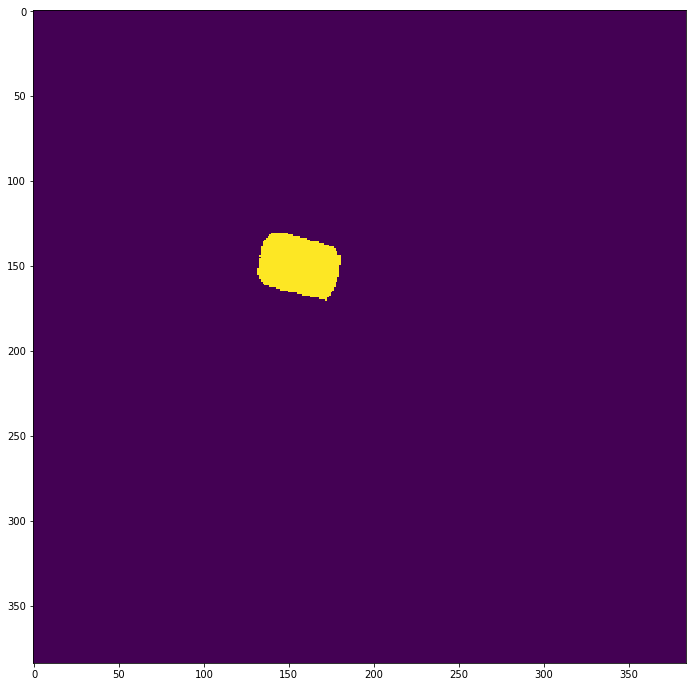

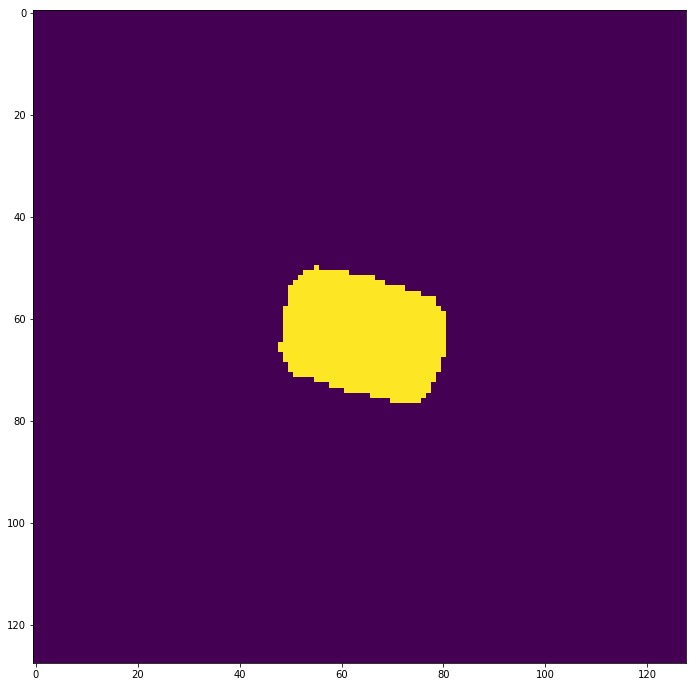

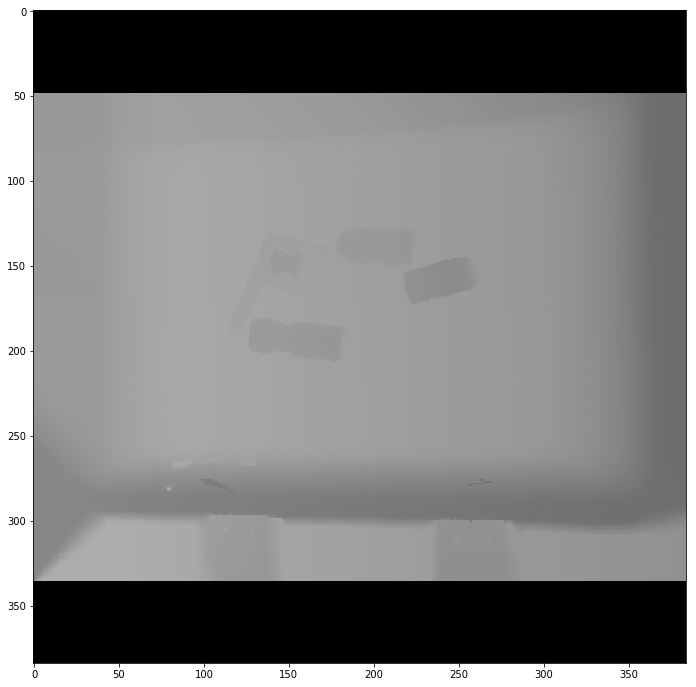

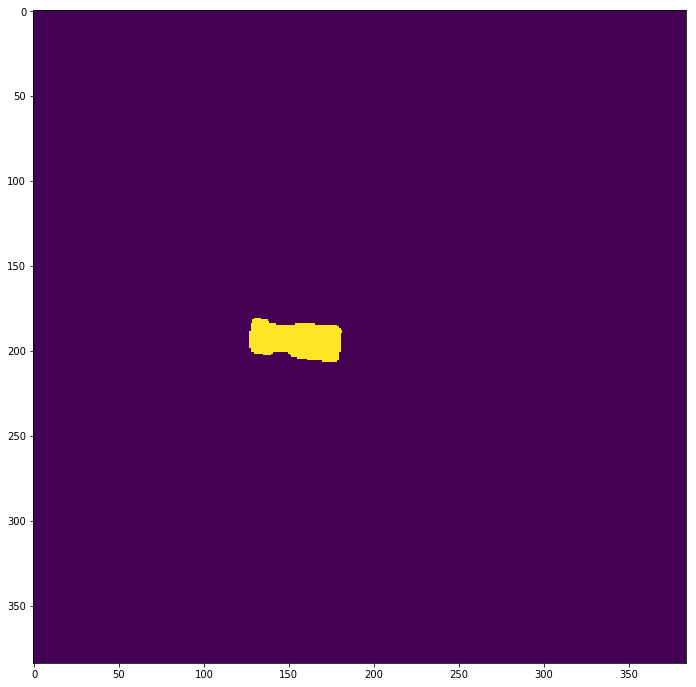

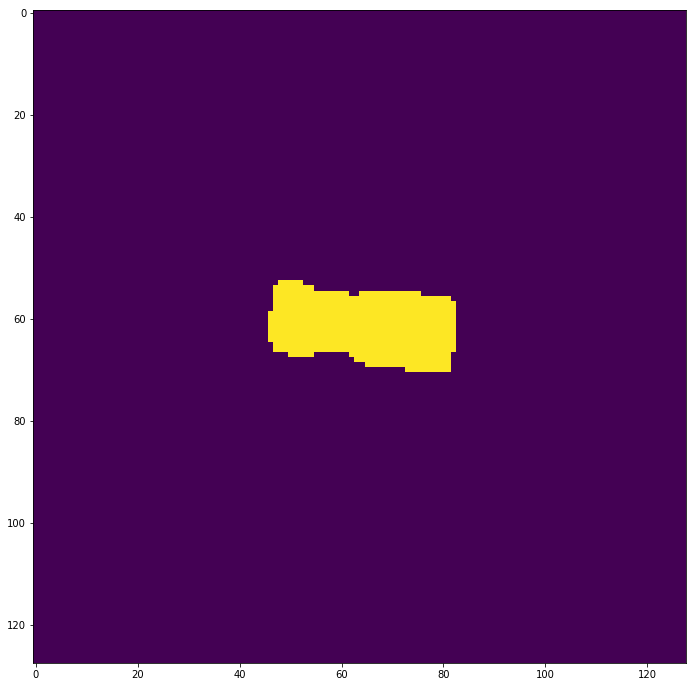

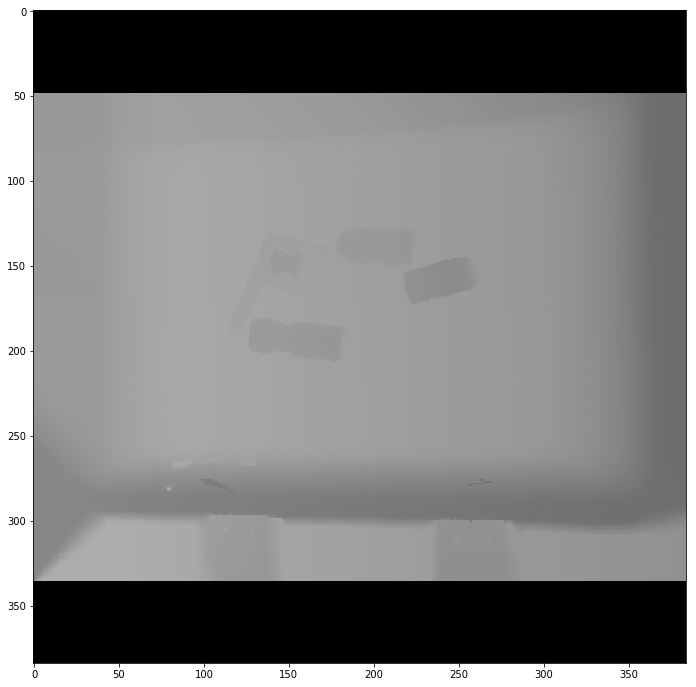

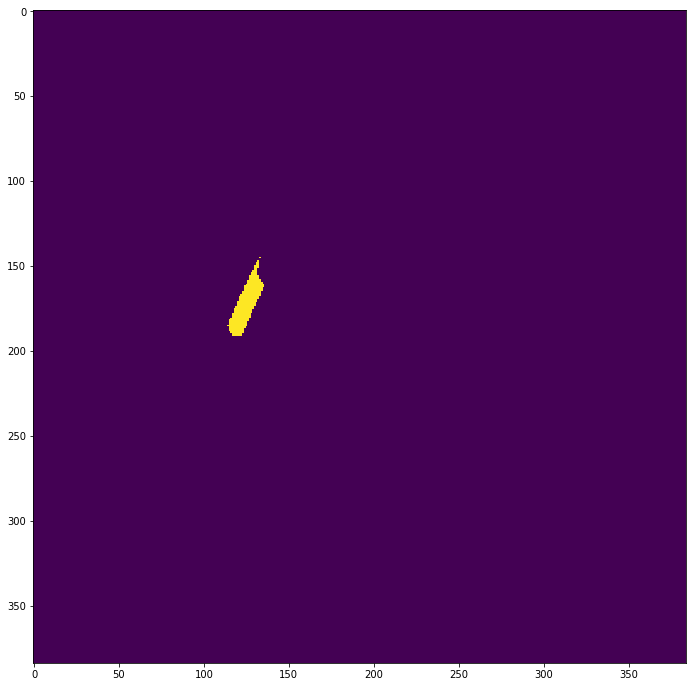

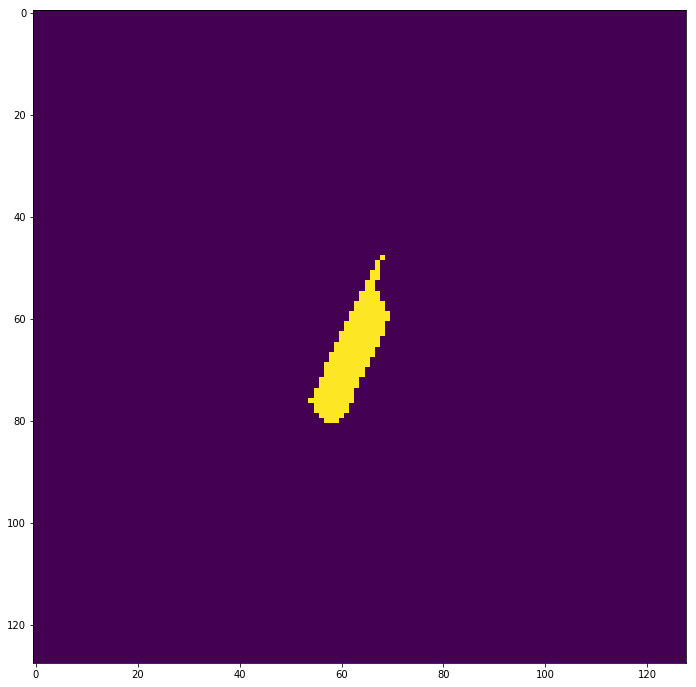

 27%|██▋       | 8/30 [00:25<01:09,  3.17s/it]

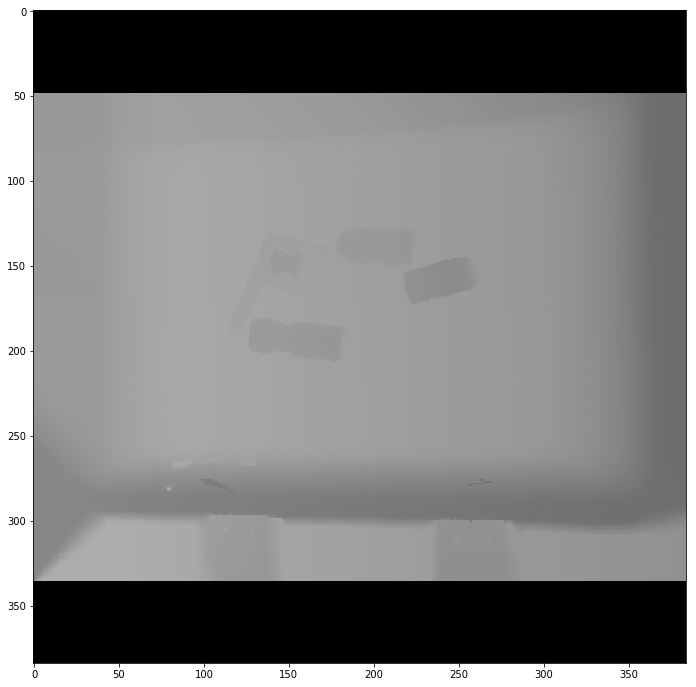

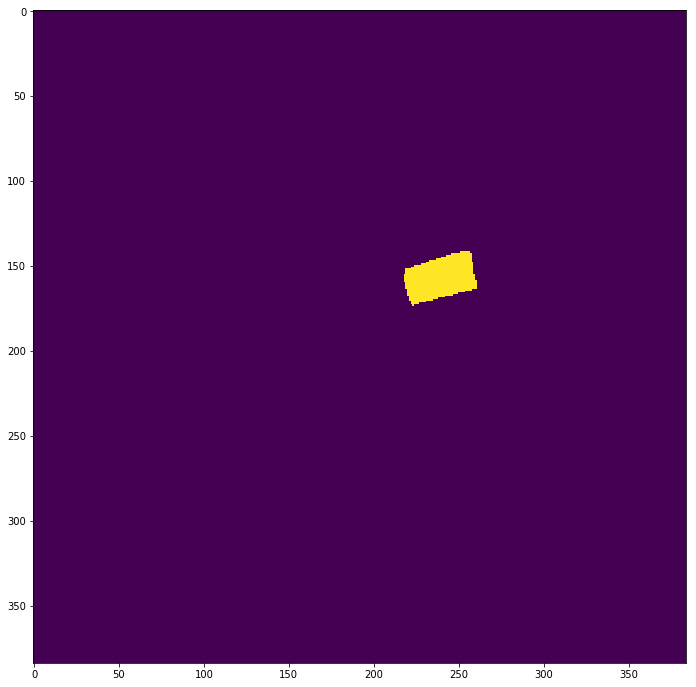

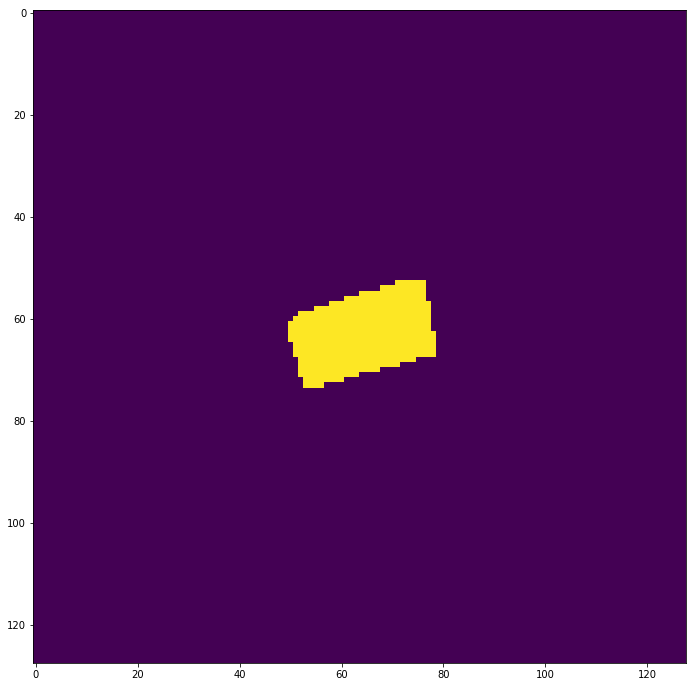

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000008

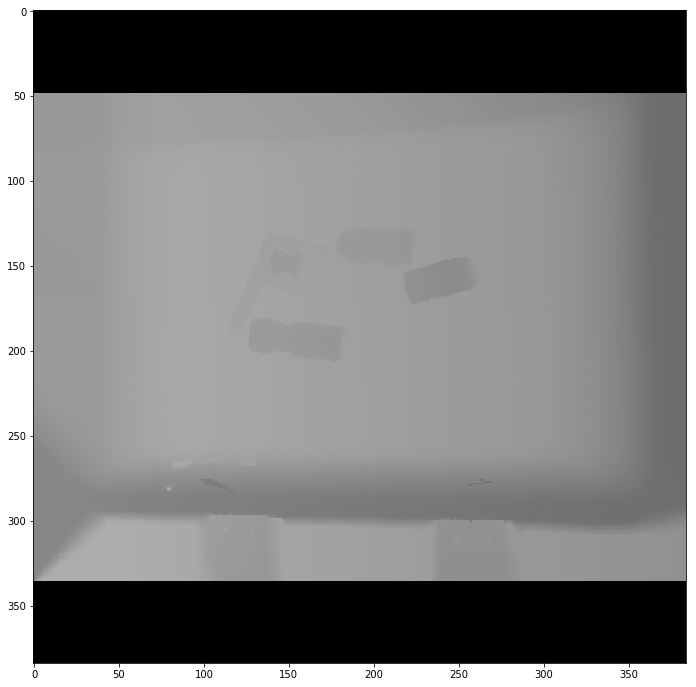

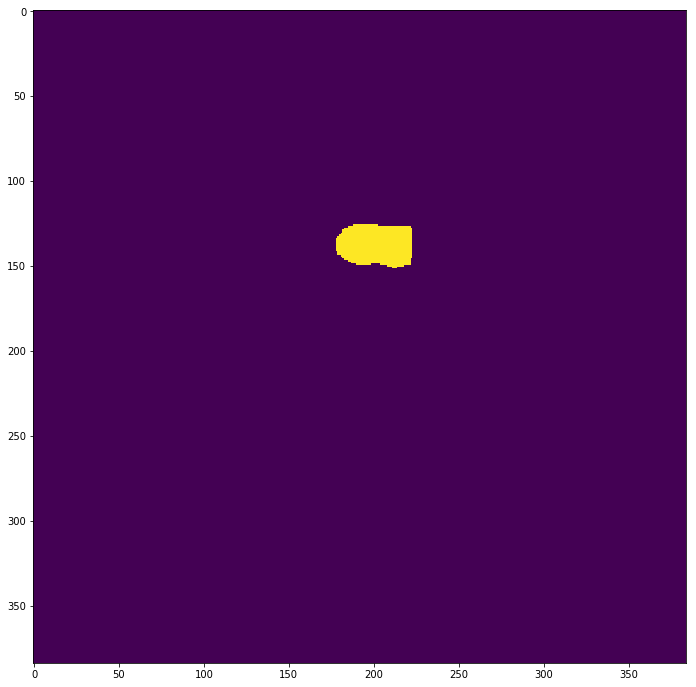

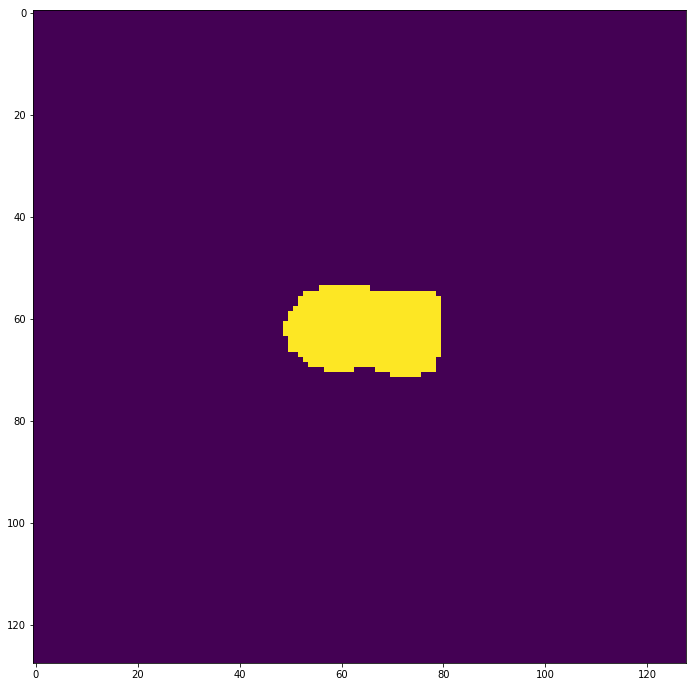

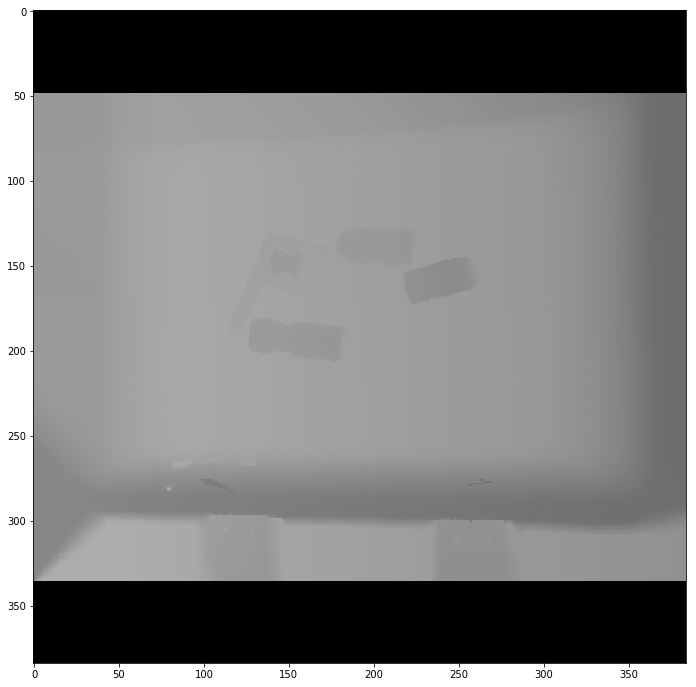

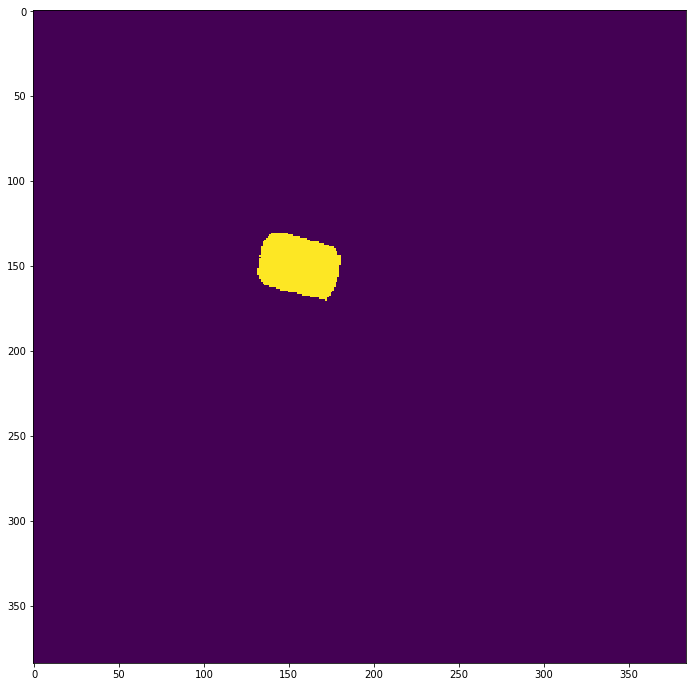

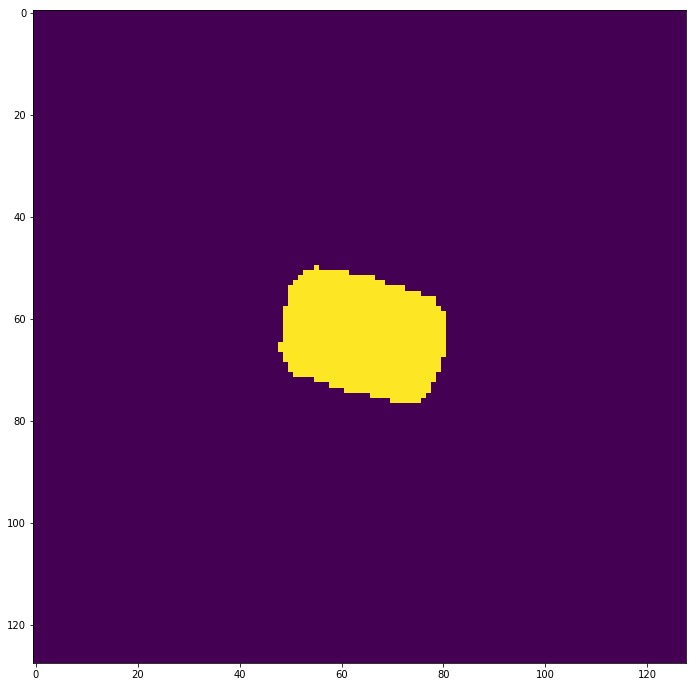

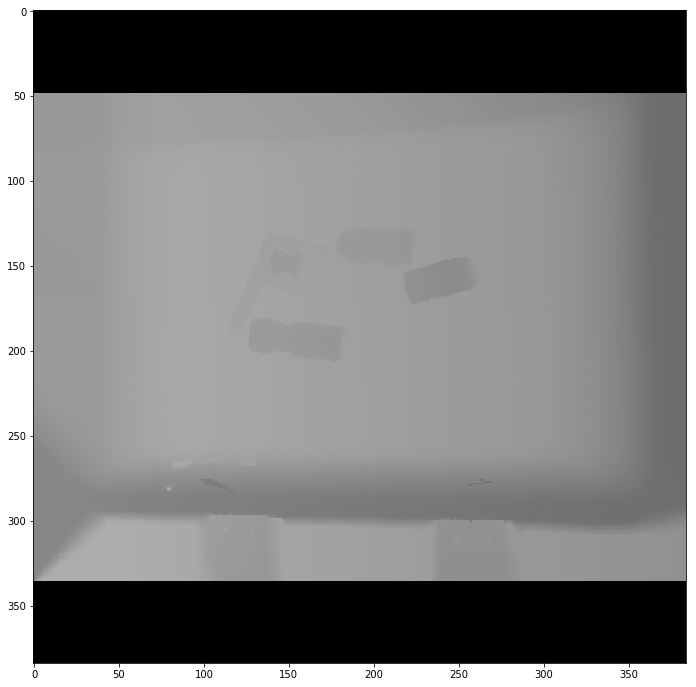

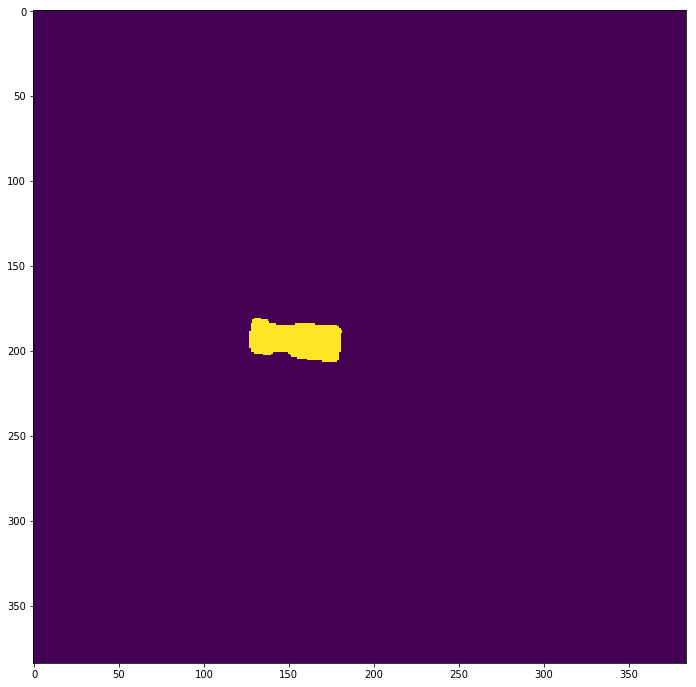

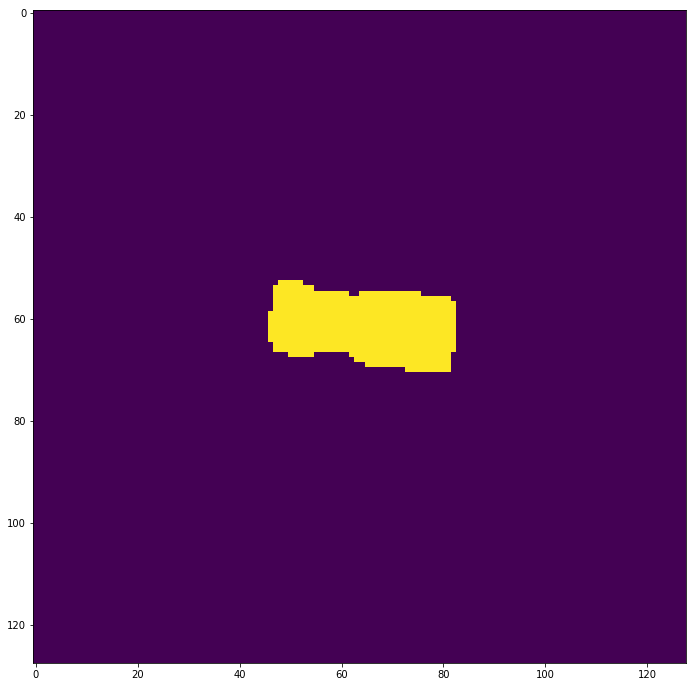

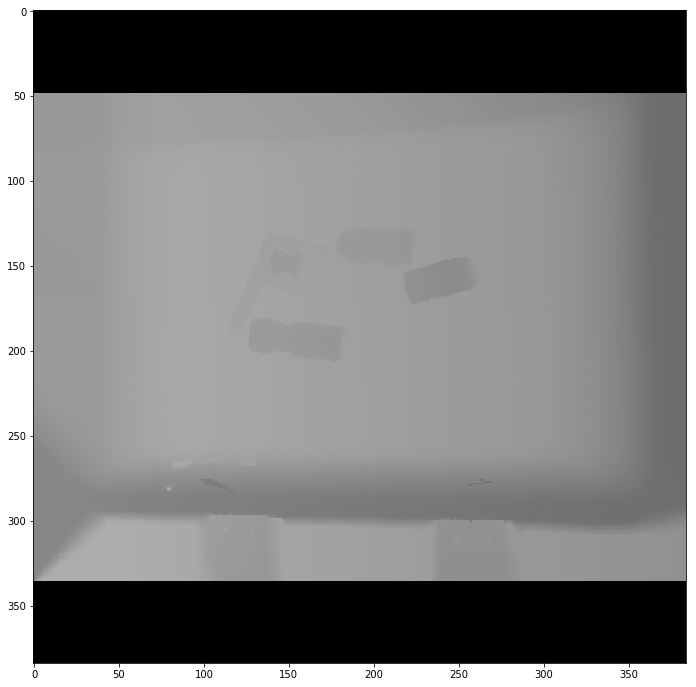

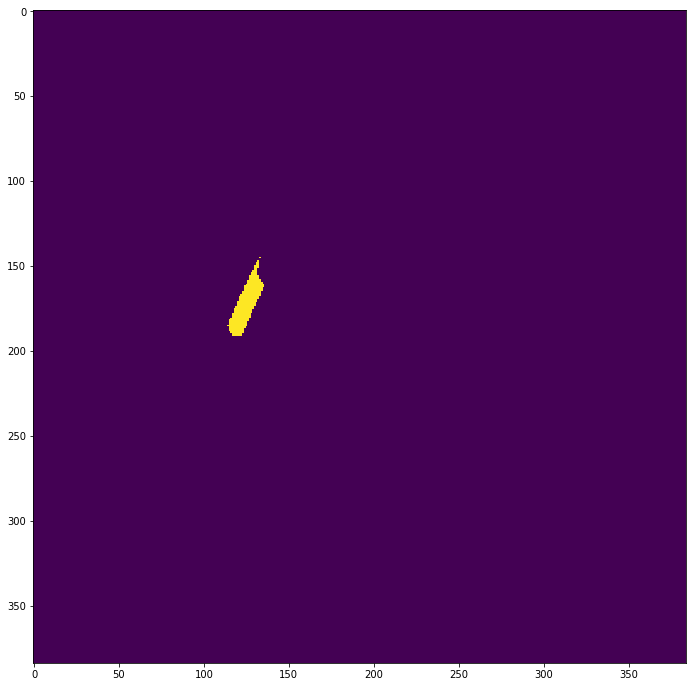

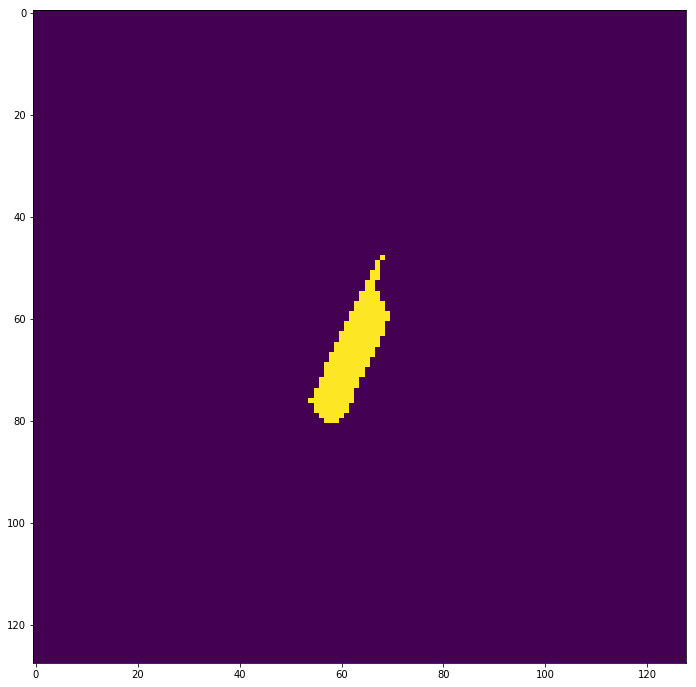

 30%|███       | 9/30 [00:28<01:06,  3.18s/it]

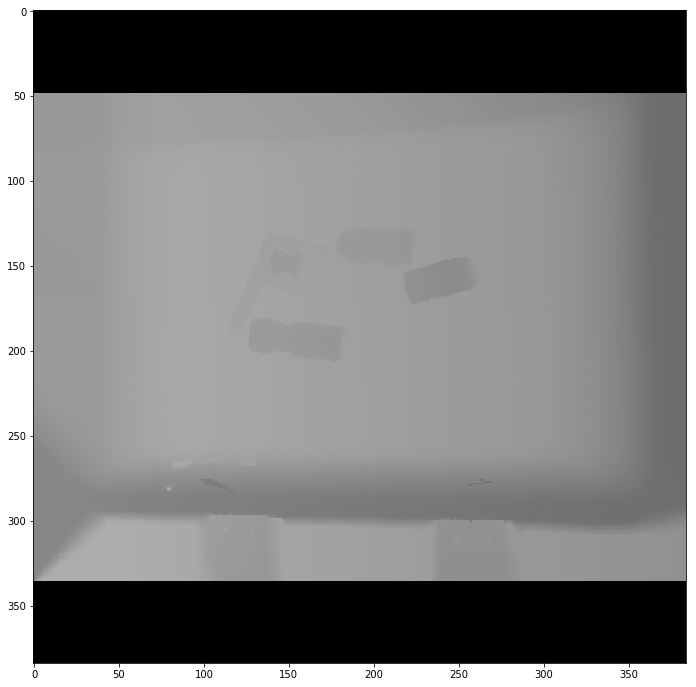

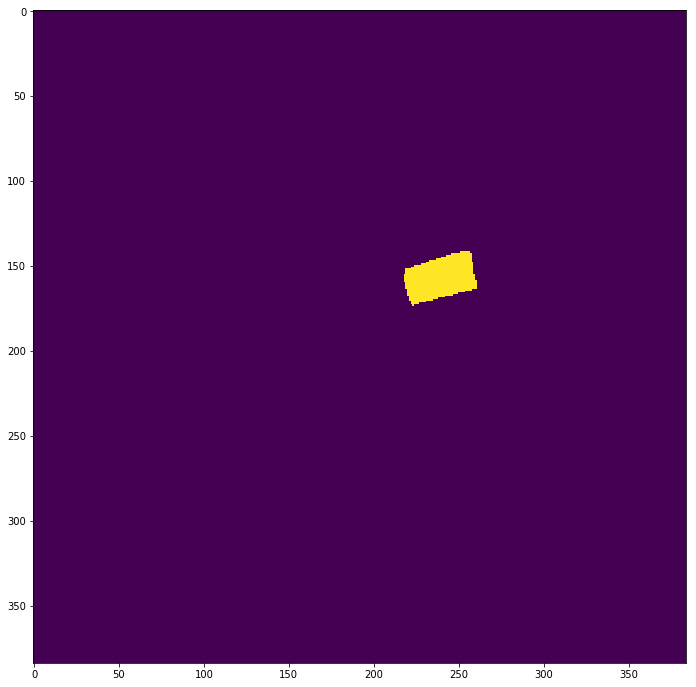

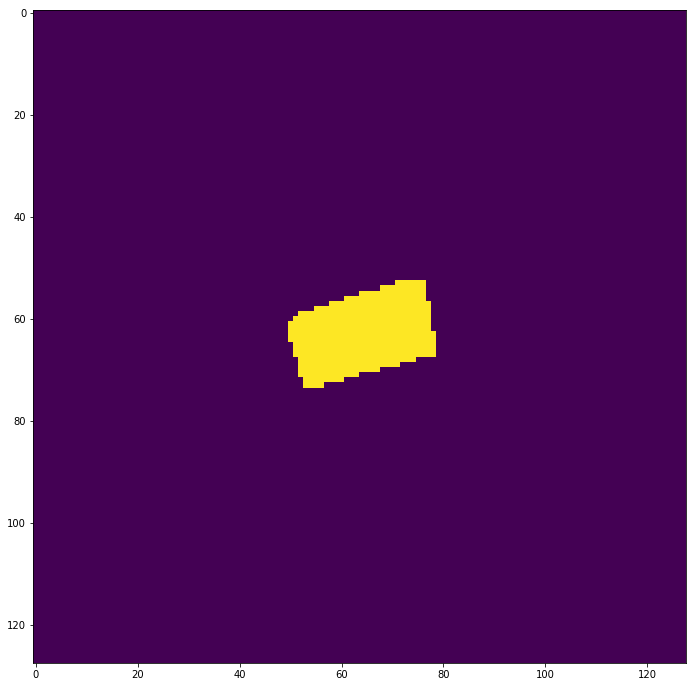

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000009

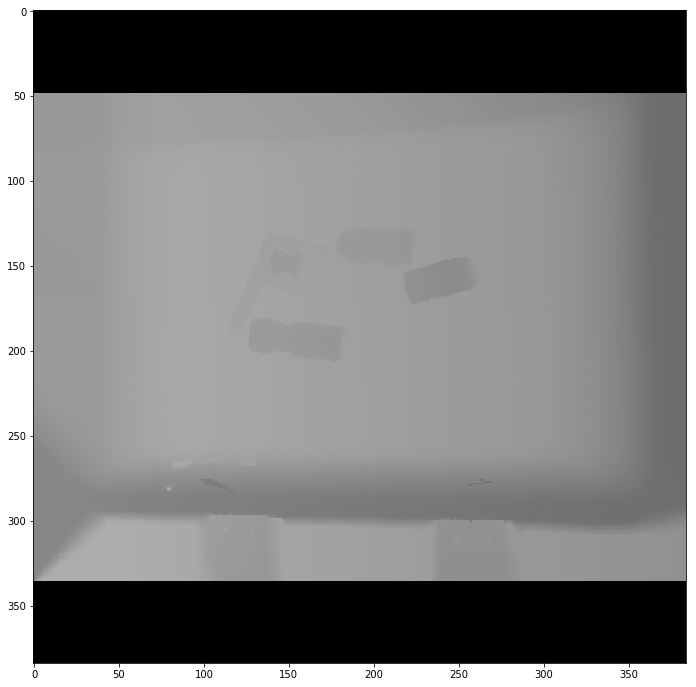

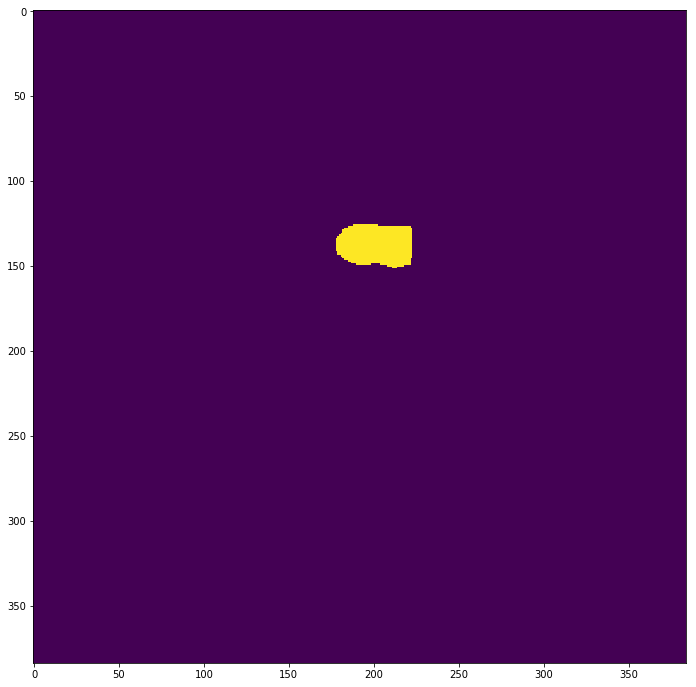

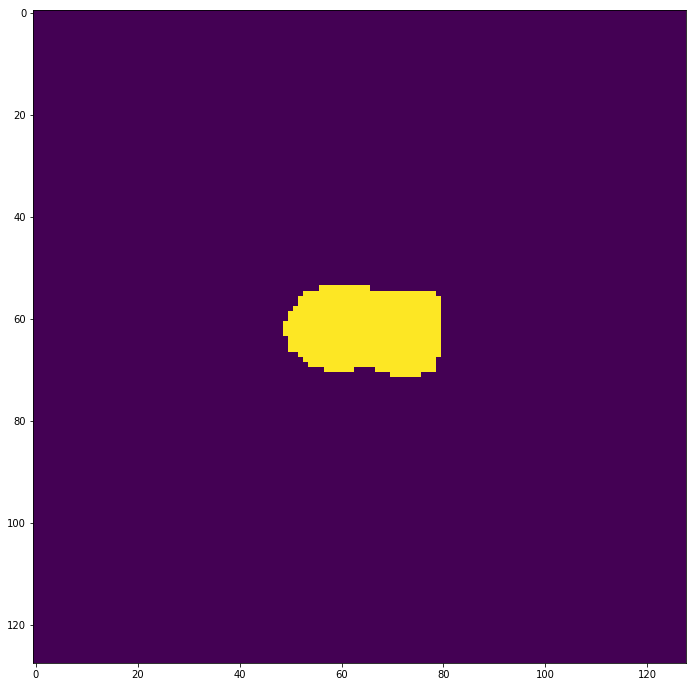

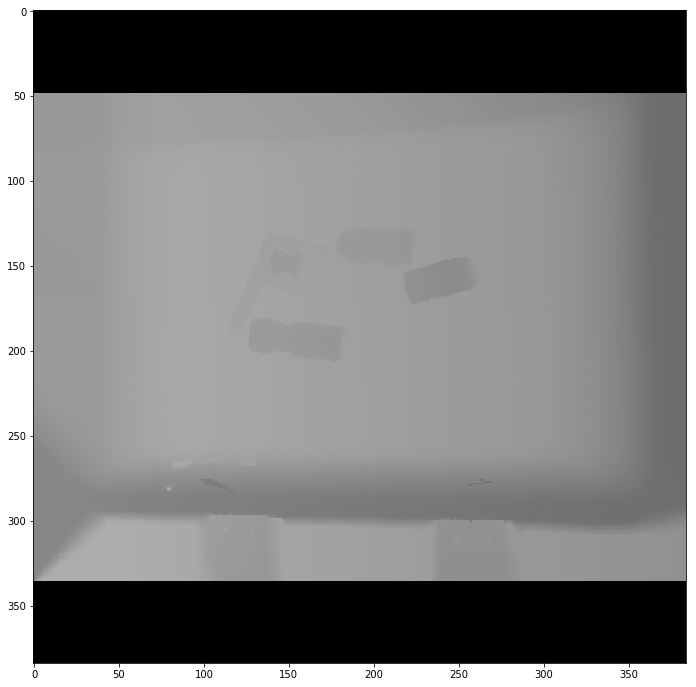

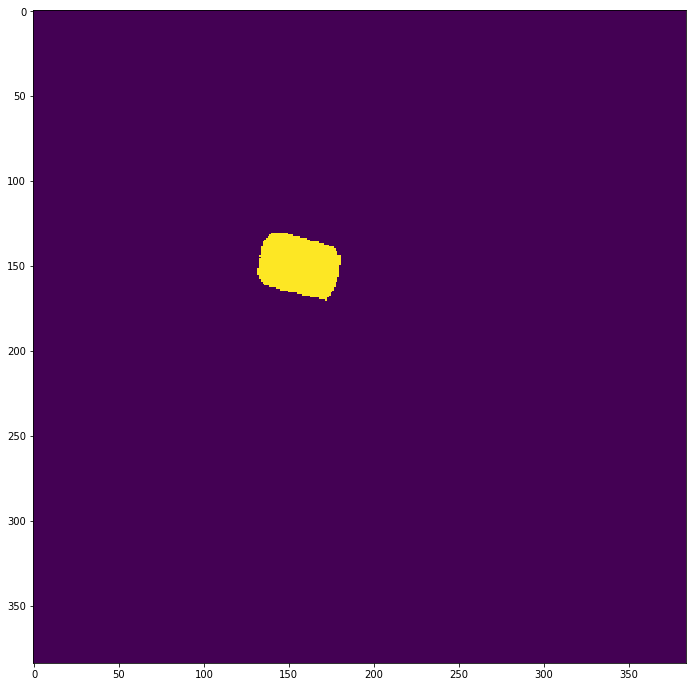

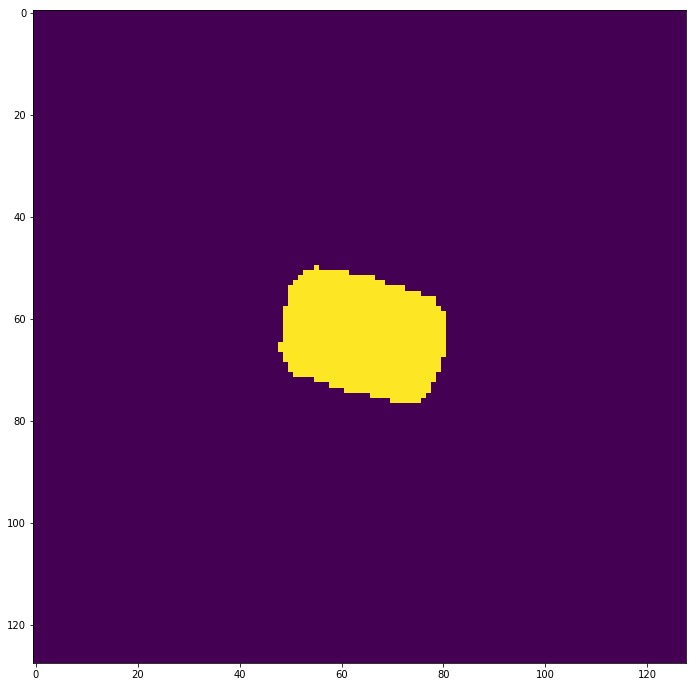

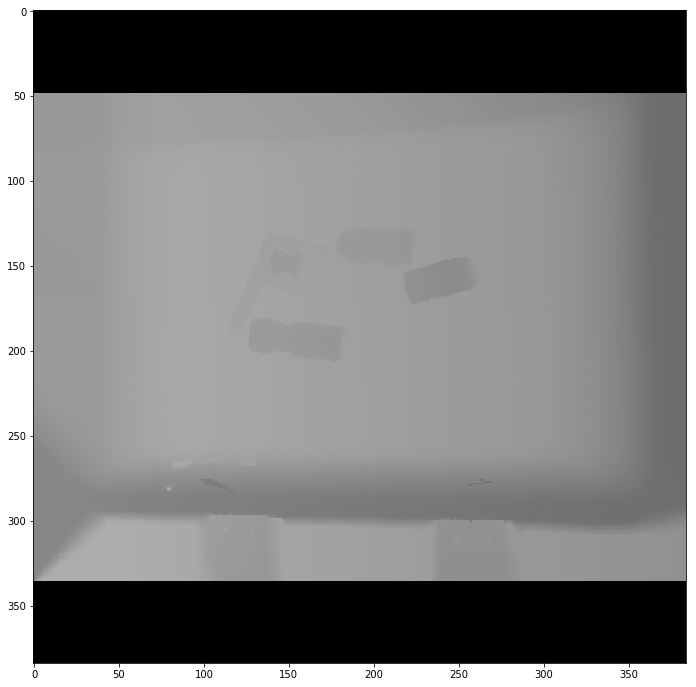

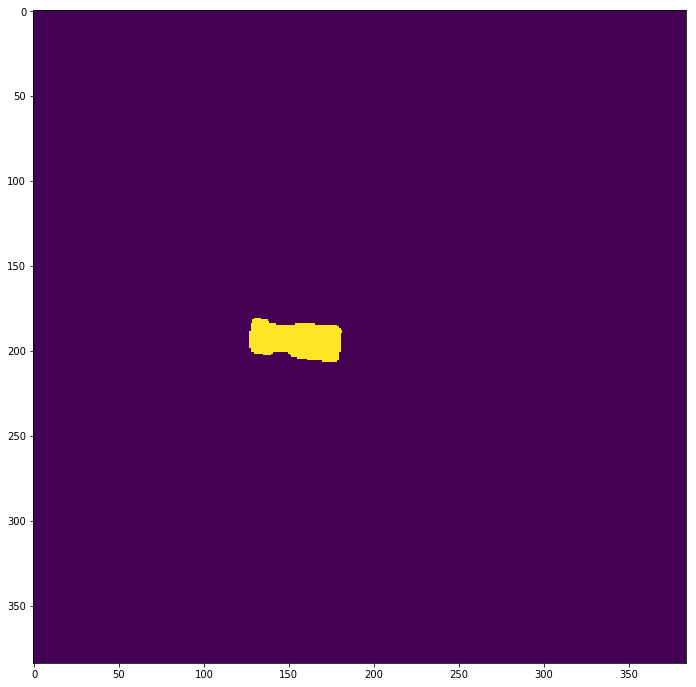

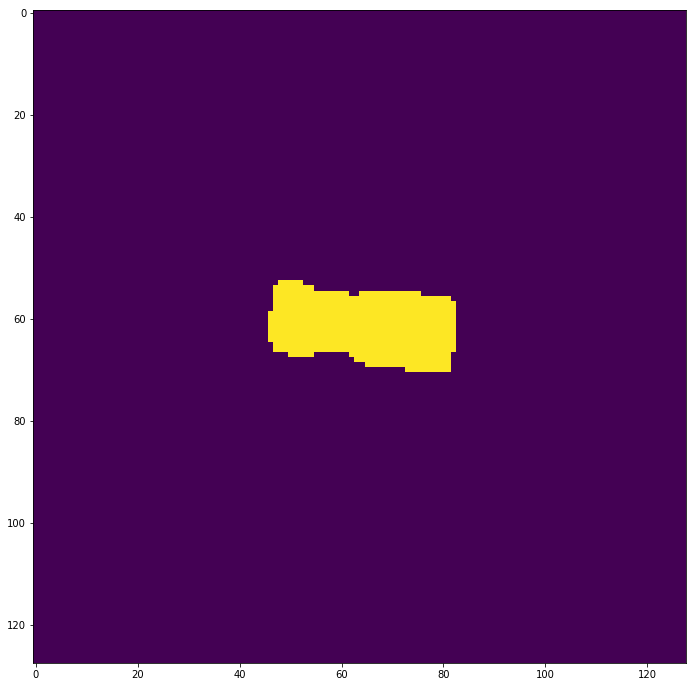

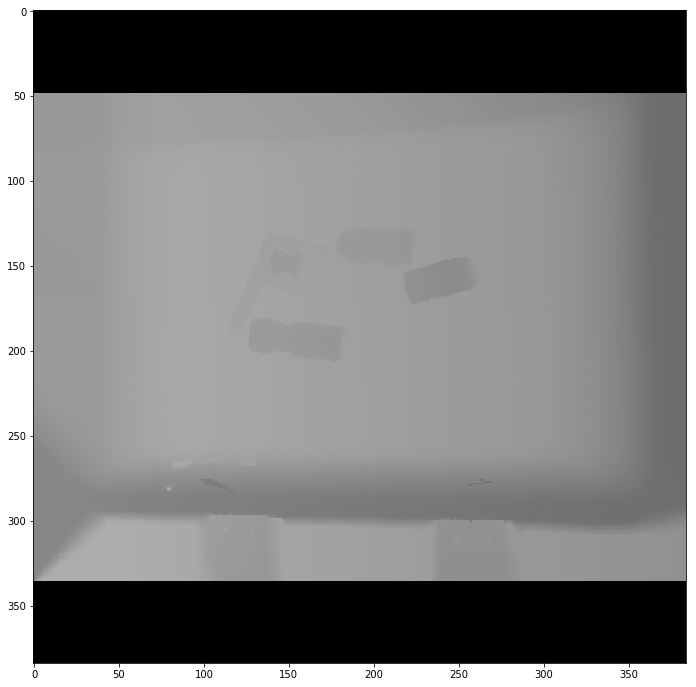

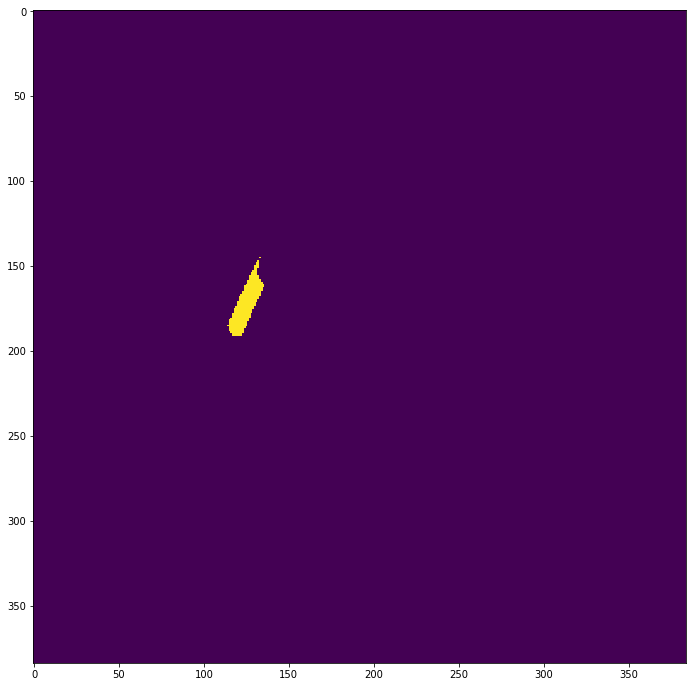

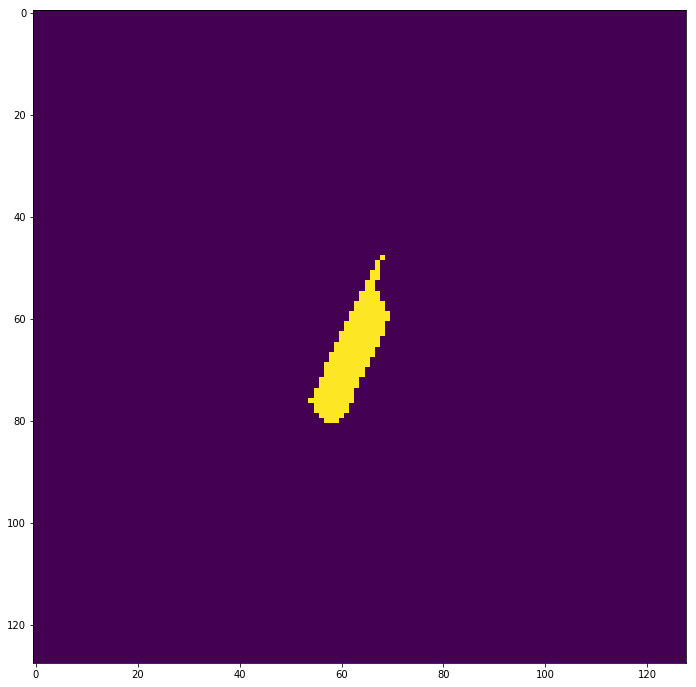

 33%|███▎      | 10/30 [00:31<01:03,  3.18s/it]

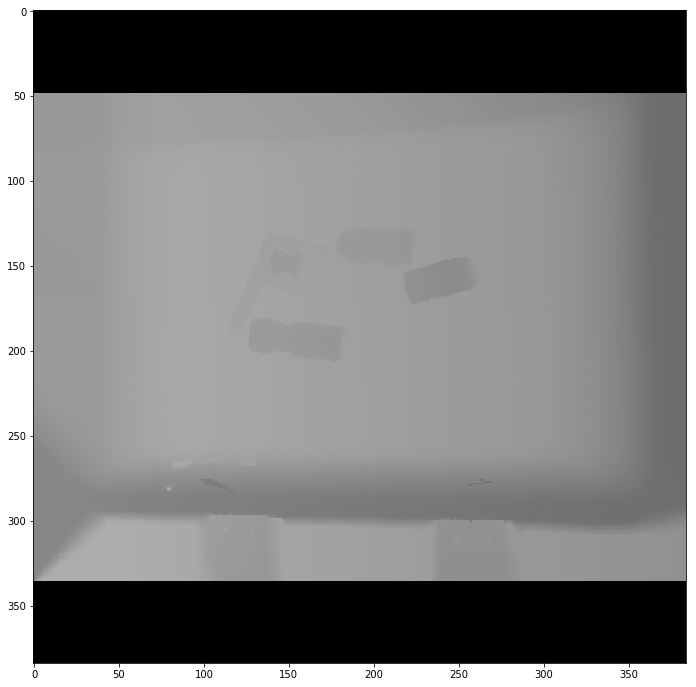

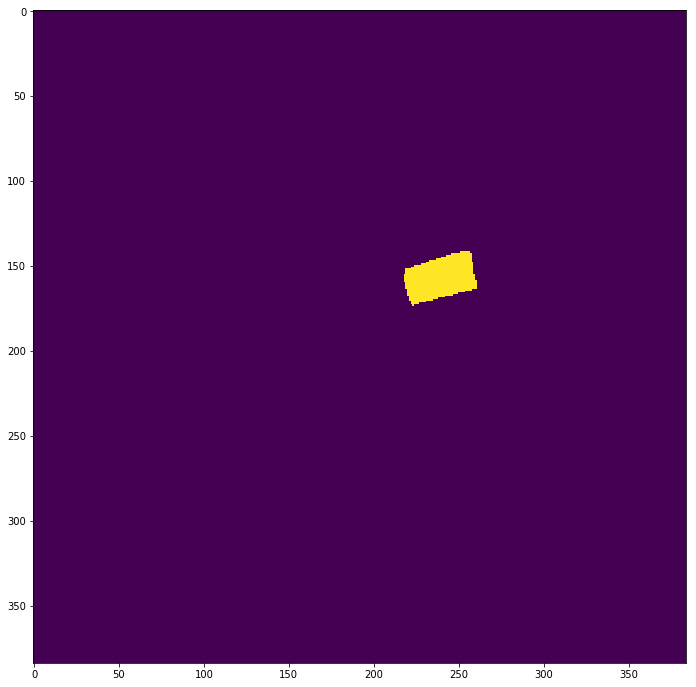

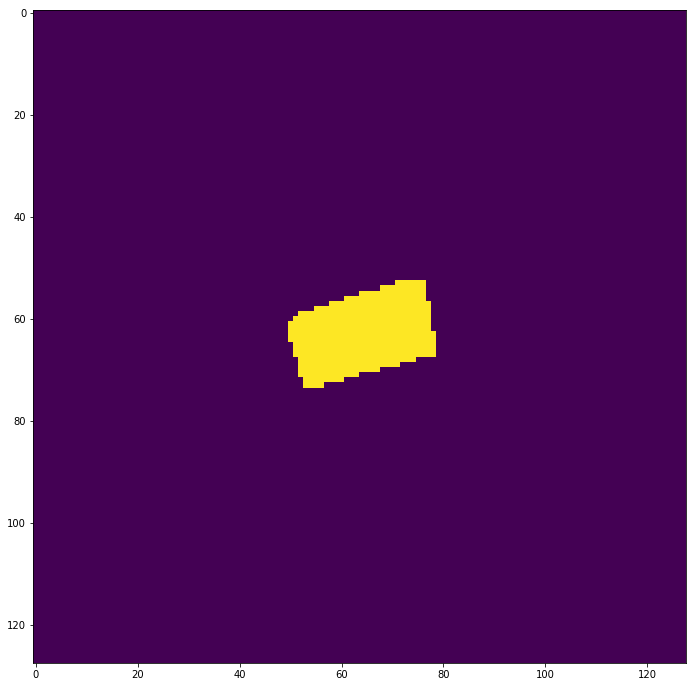

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000010

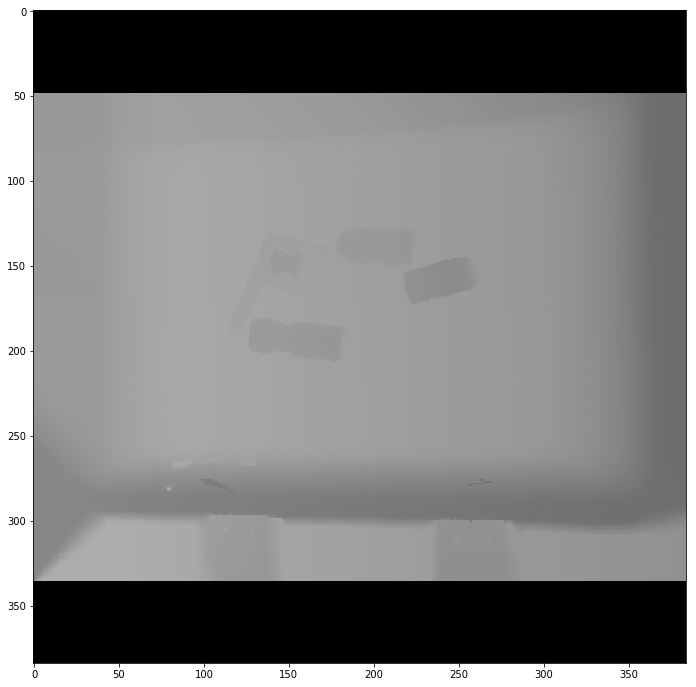

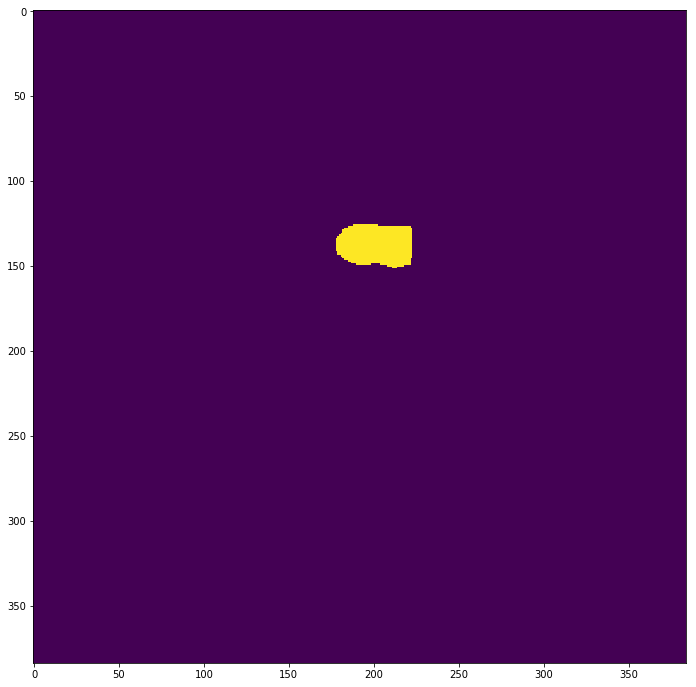

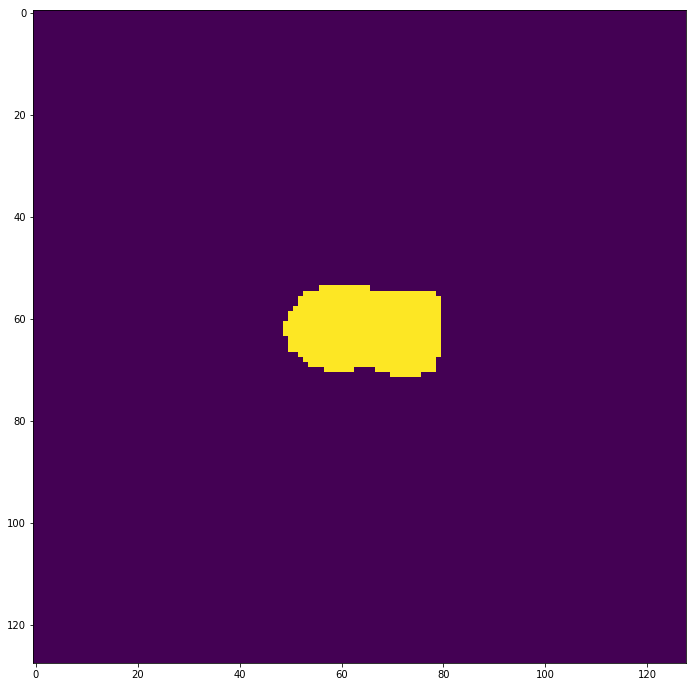

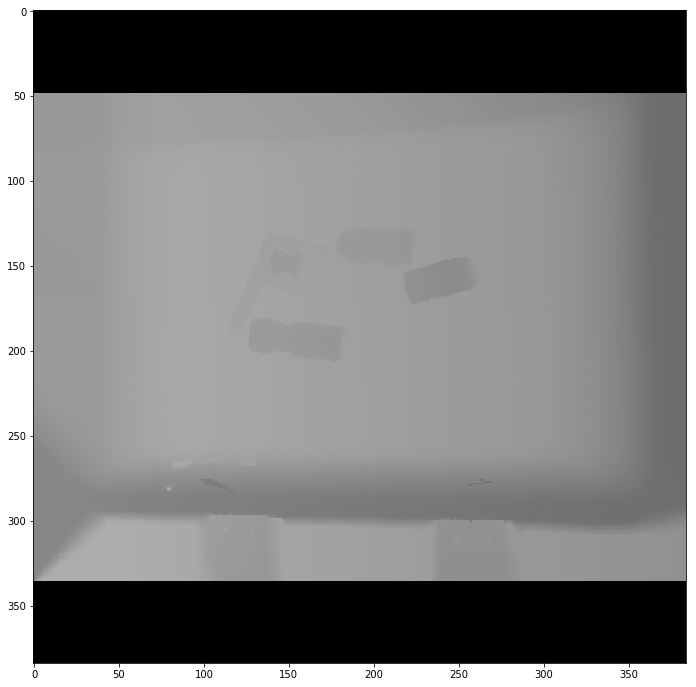

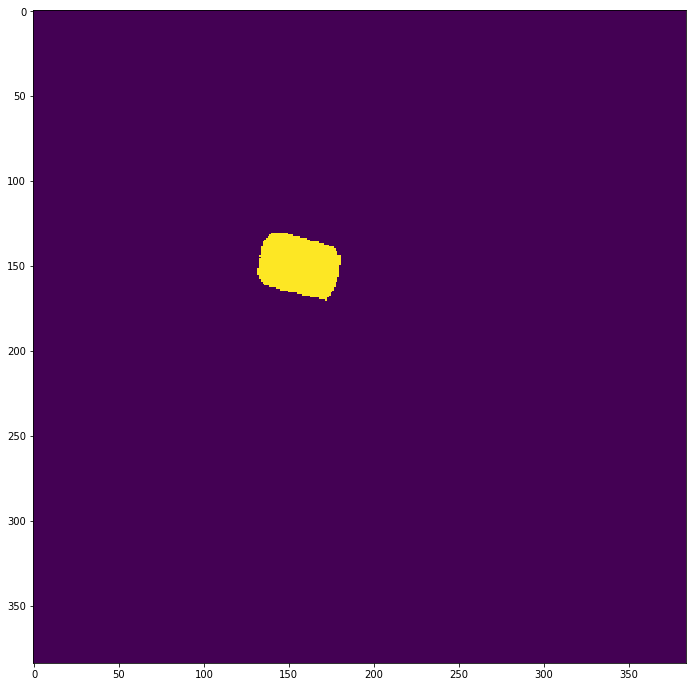

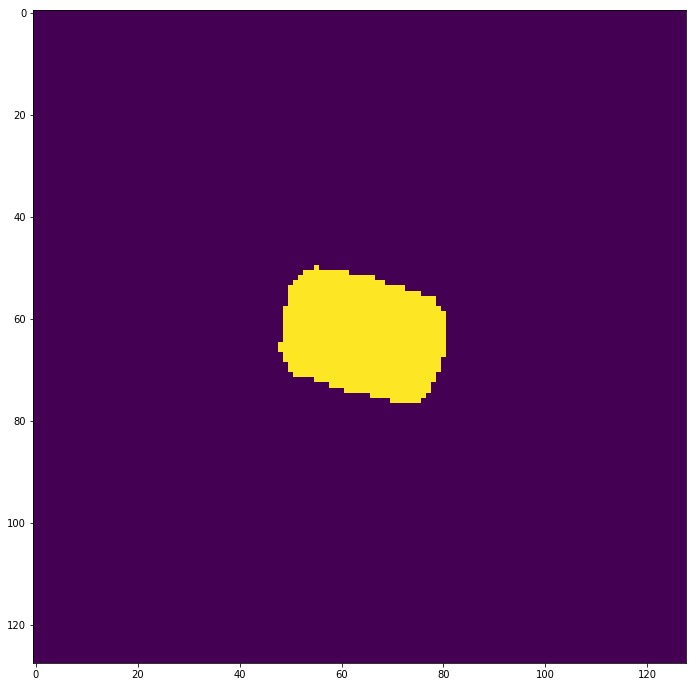

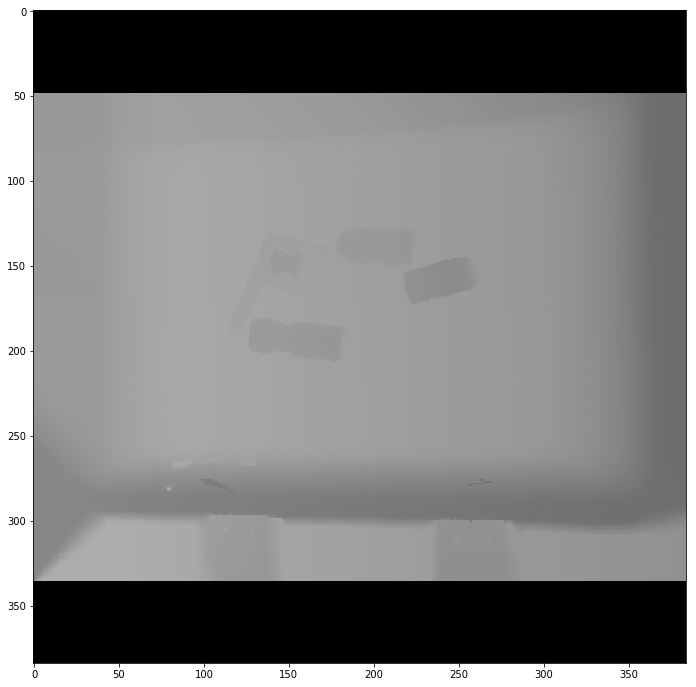

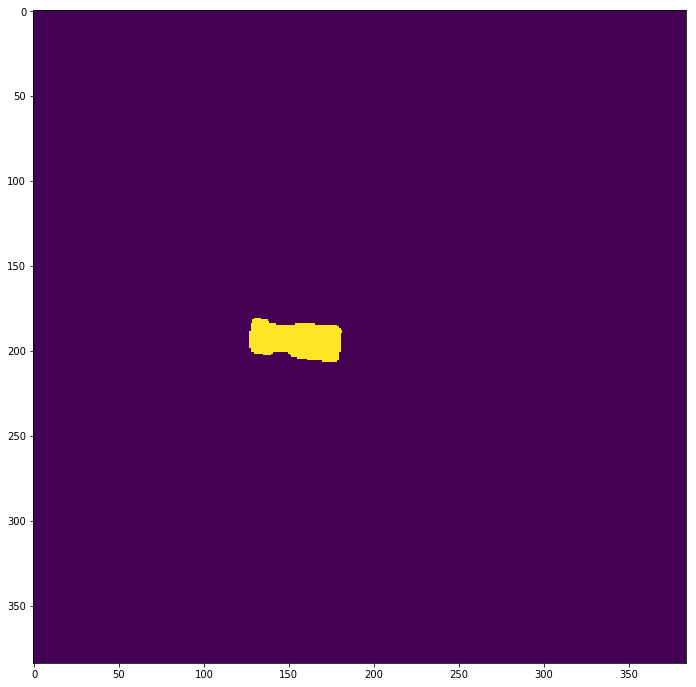

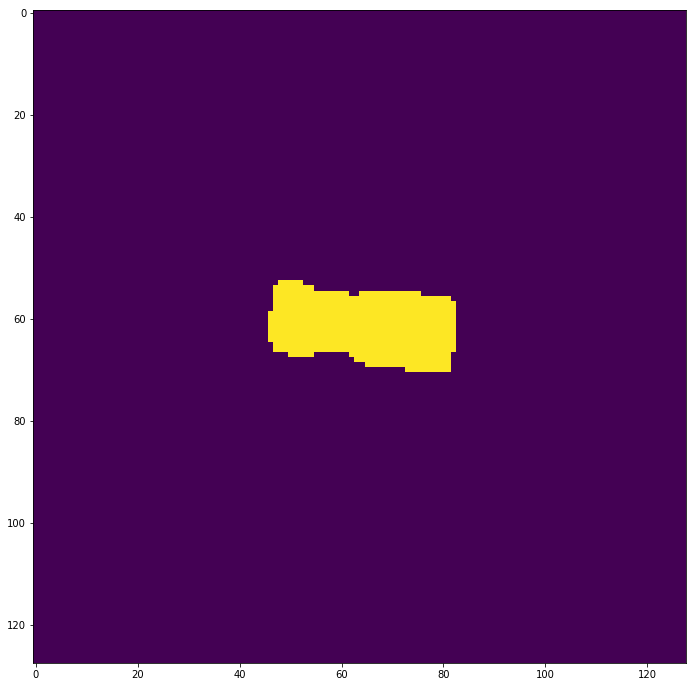

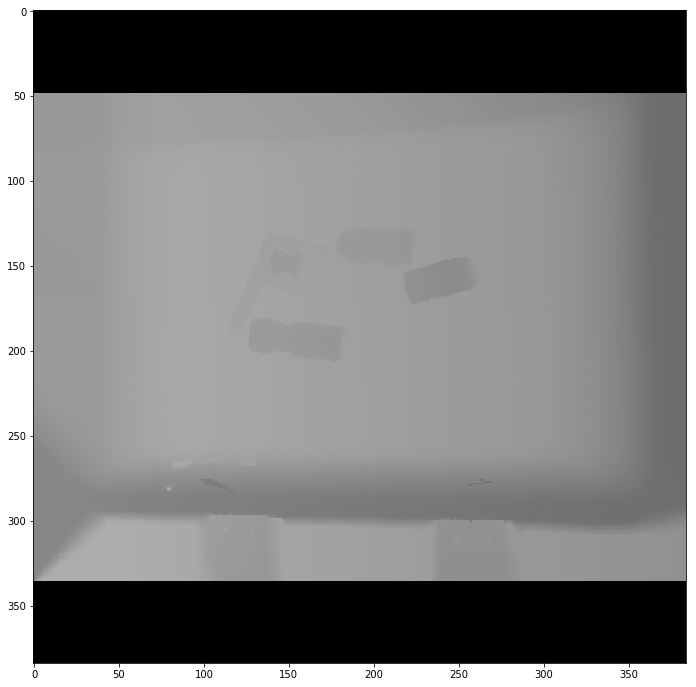

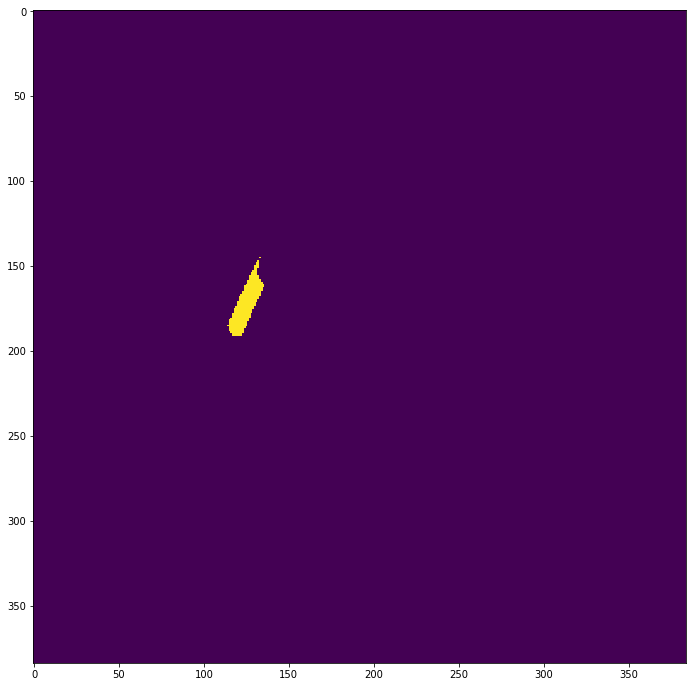

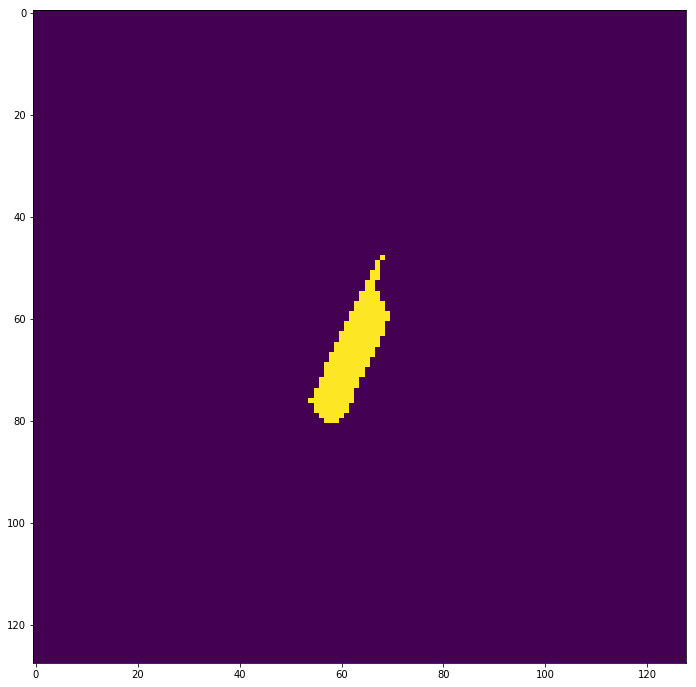

 37%|███▋      | 11/30 [00:34<00:59,  3.15s/it]

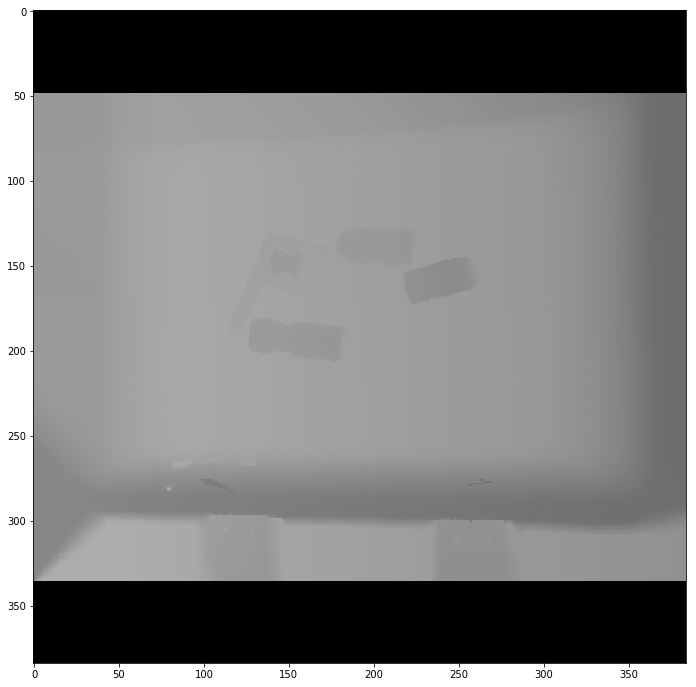

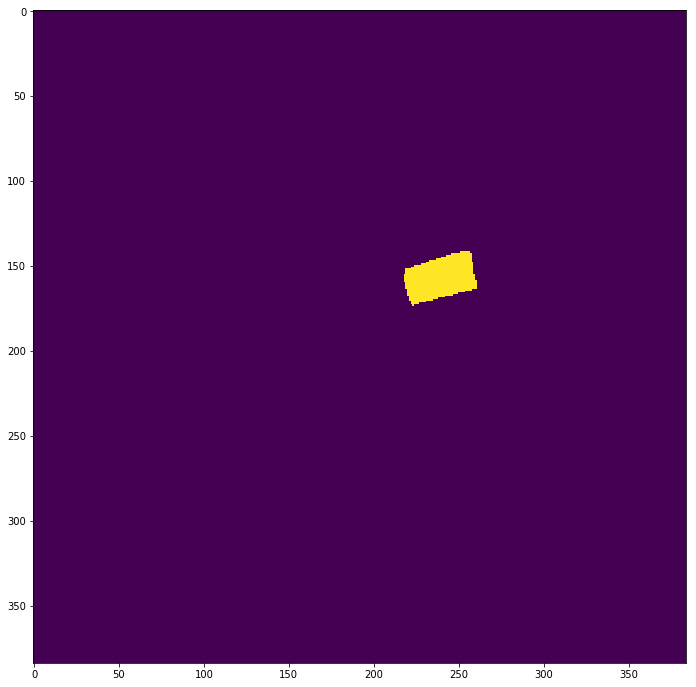

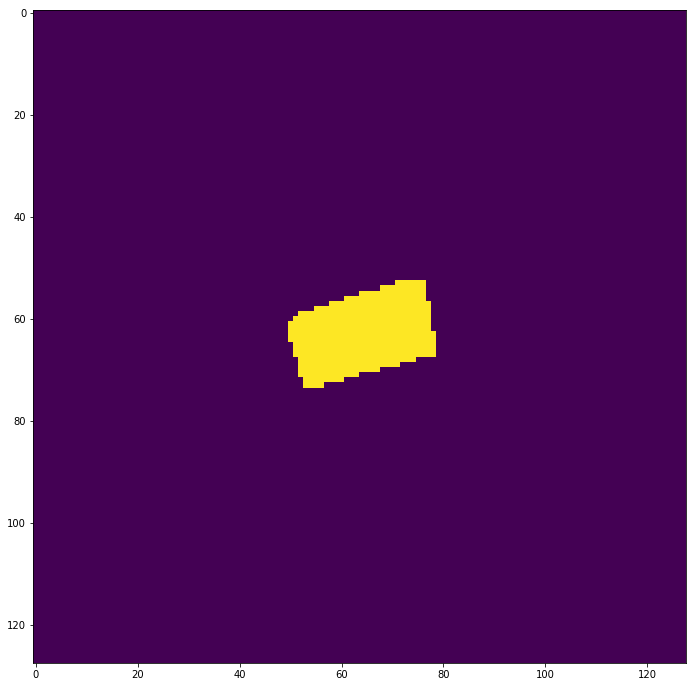

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000011

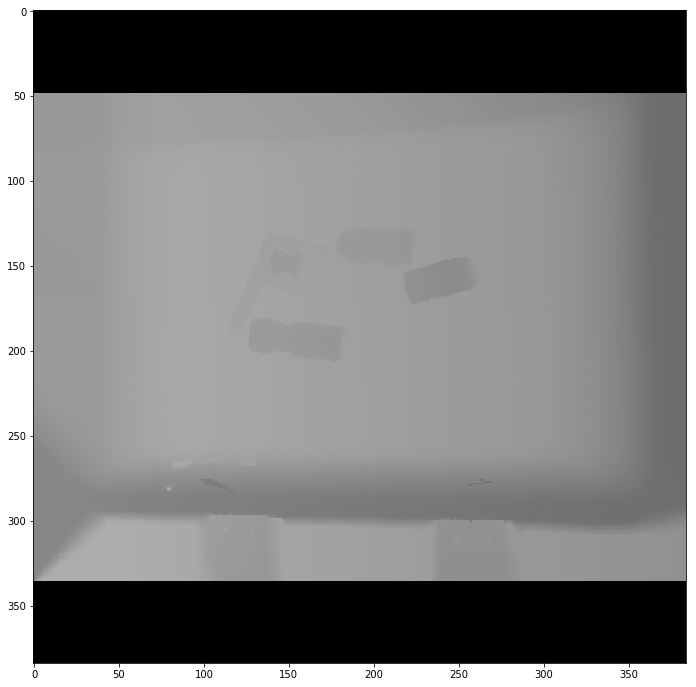

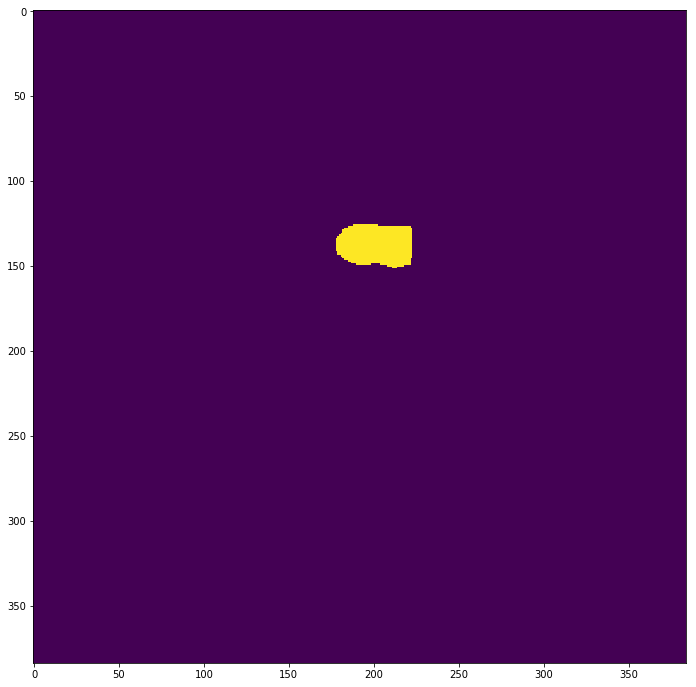

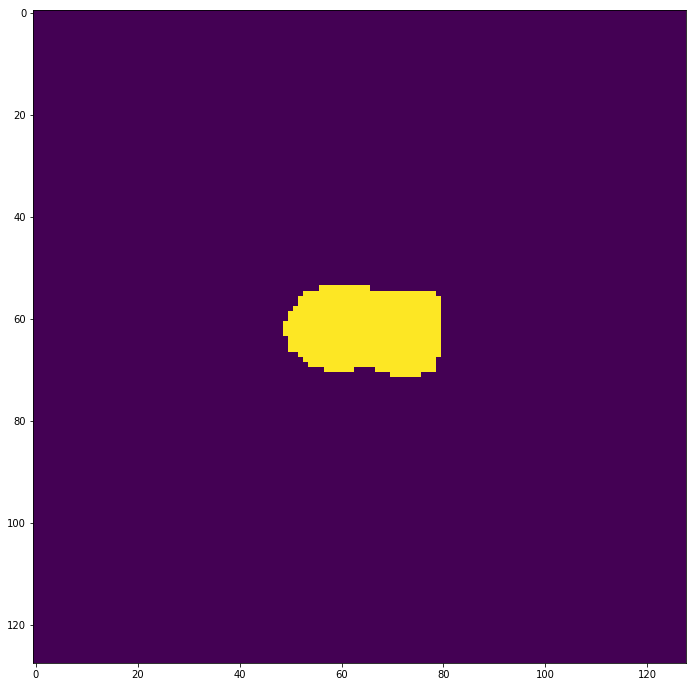

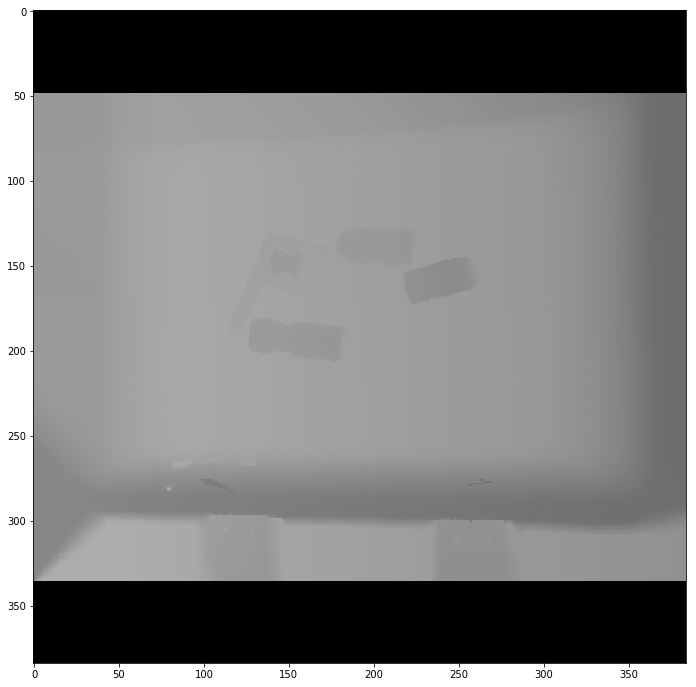

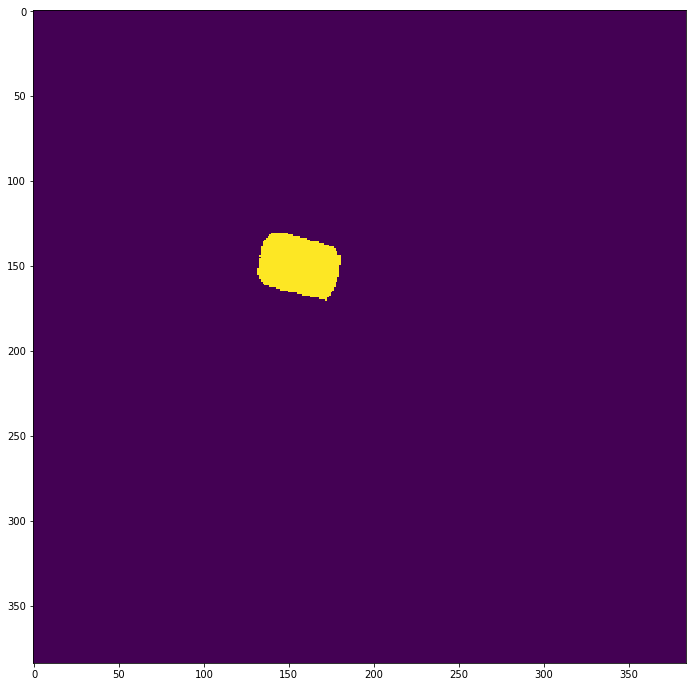

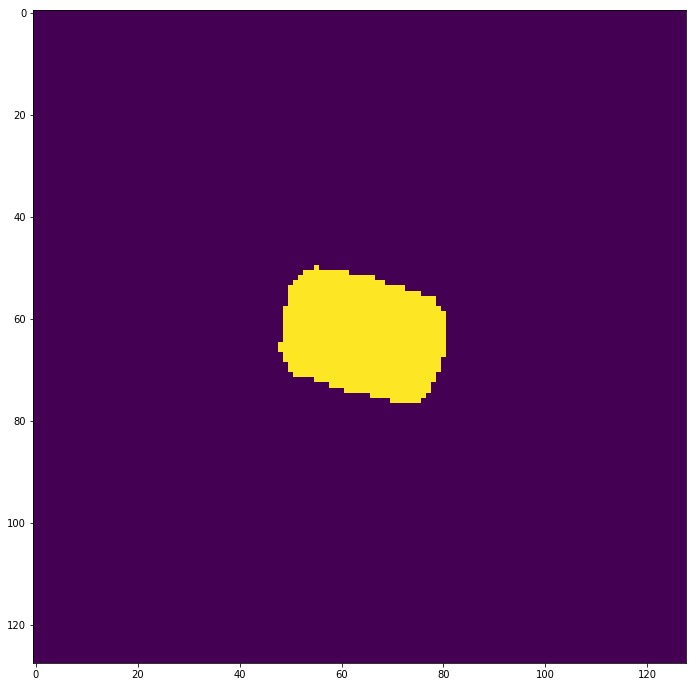

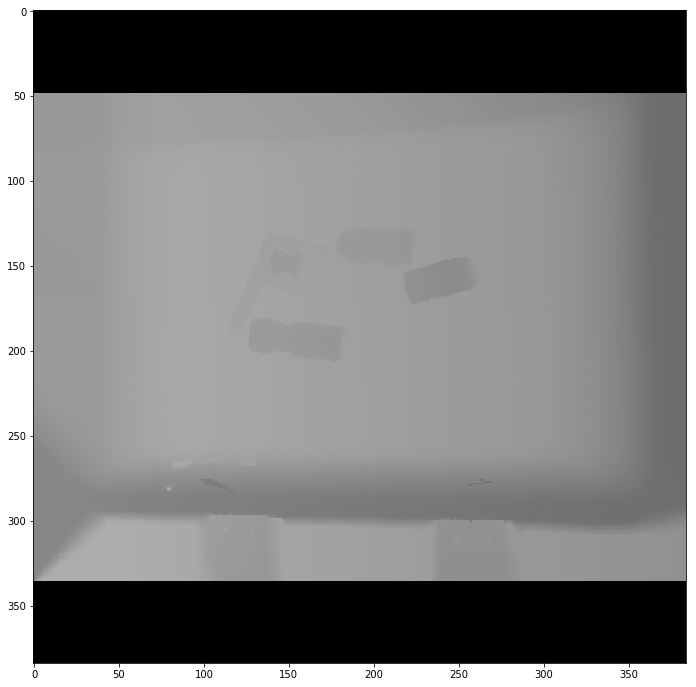

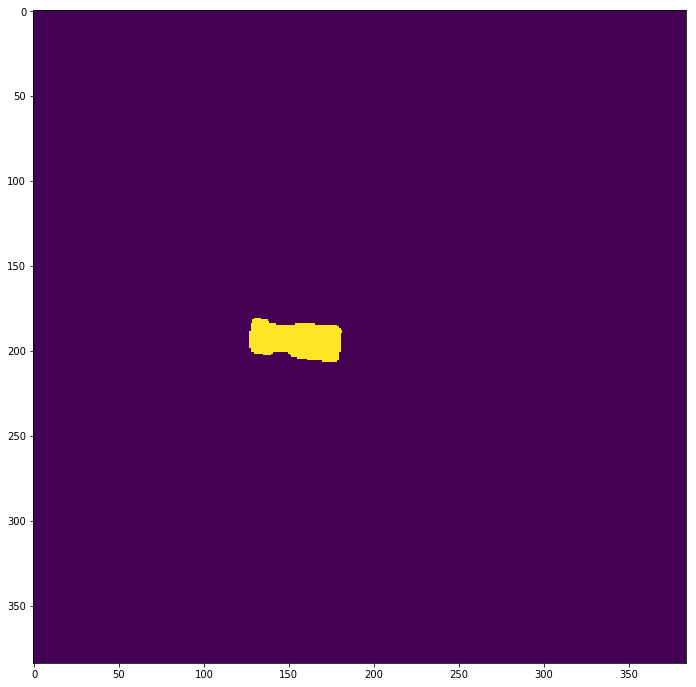

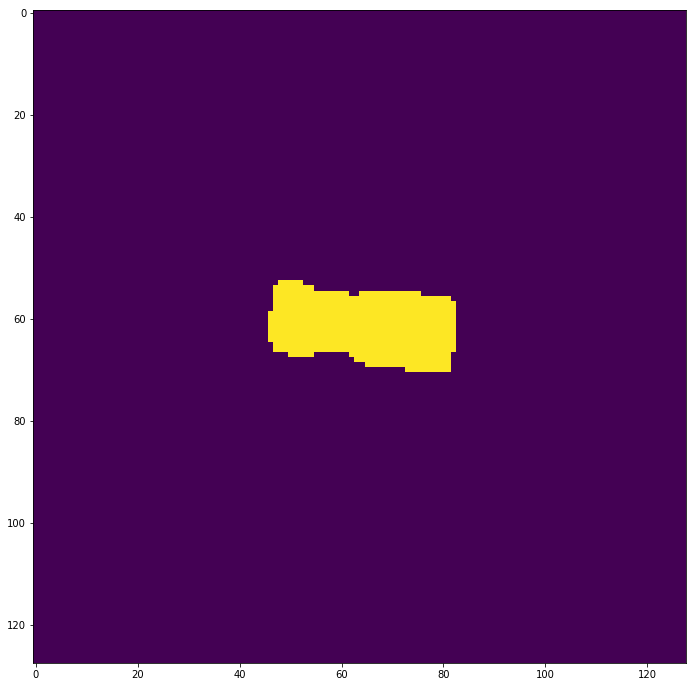

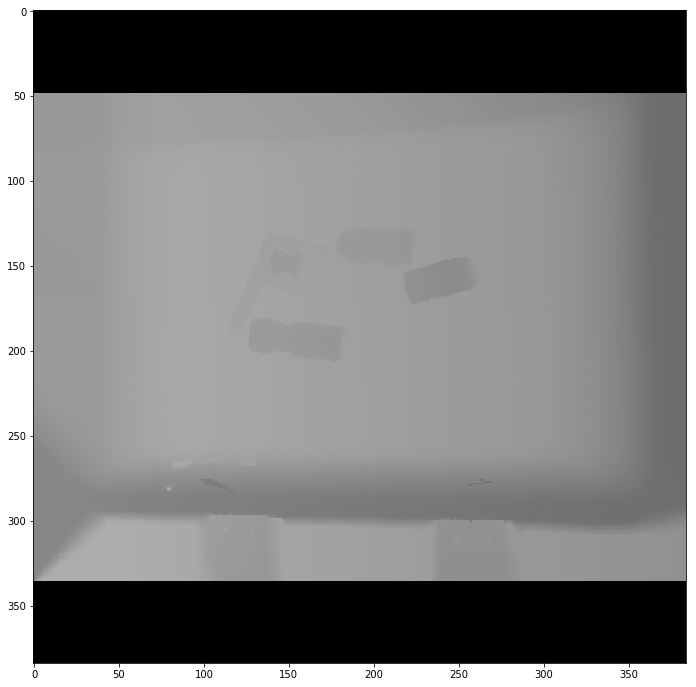

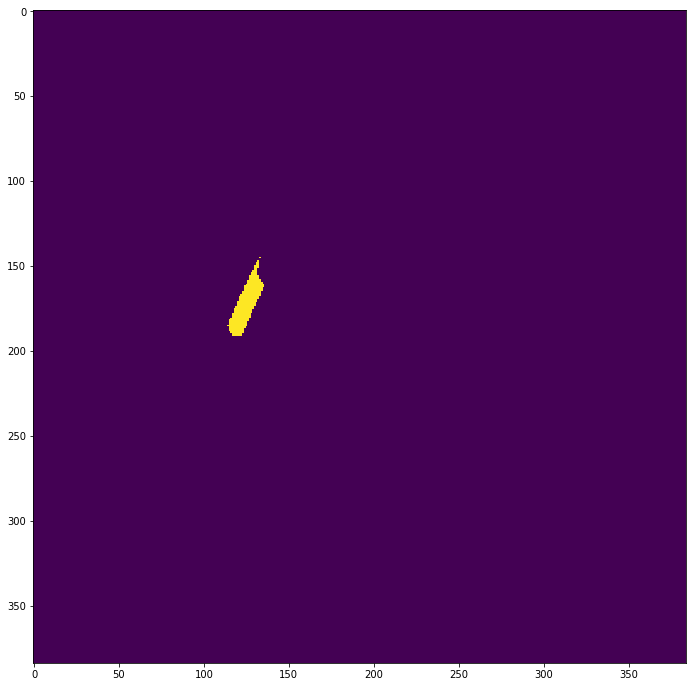

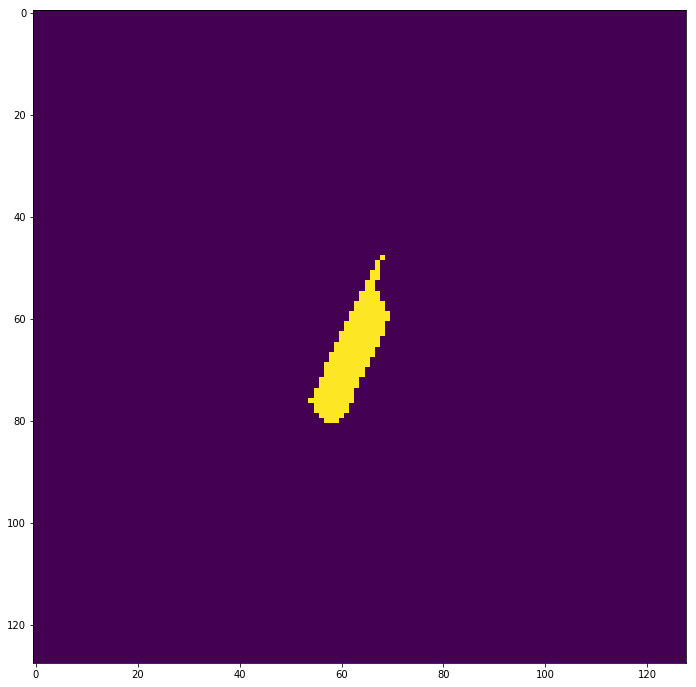

 40%|████      | 12/30 [00:38<00:57,  3.18s/it]

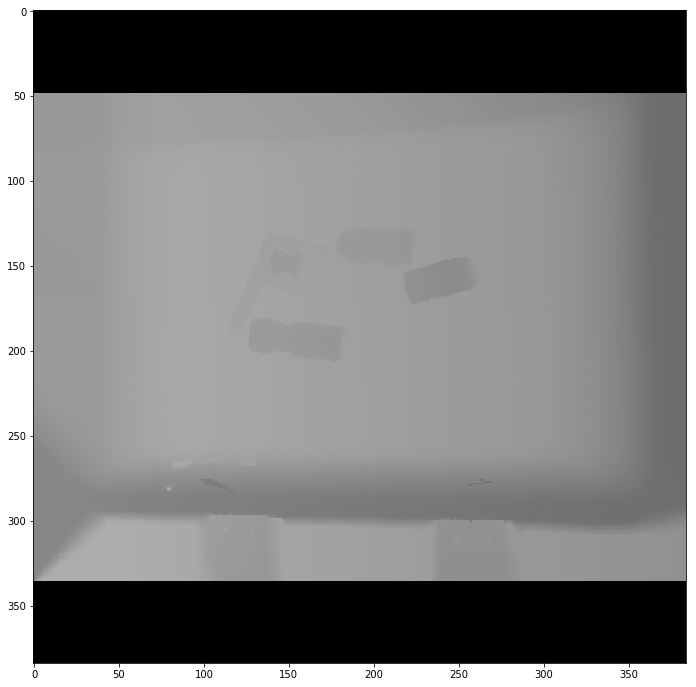

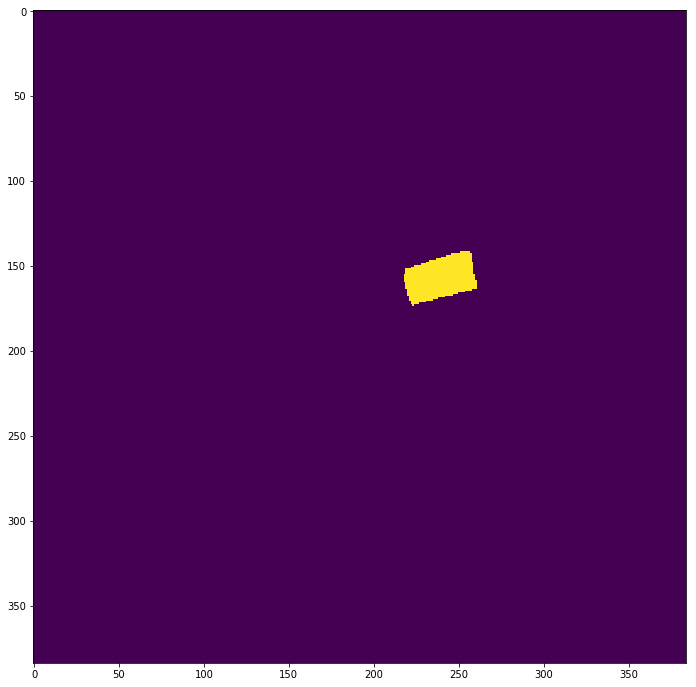

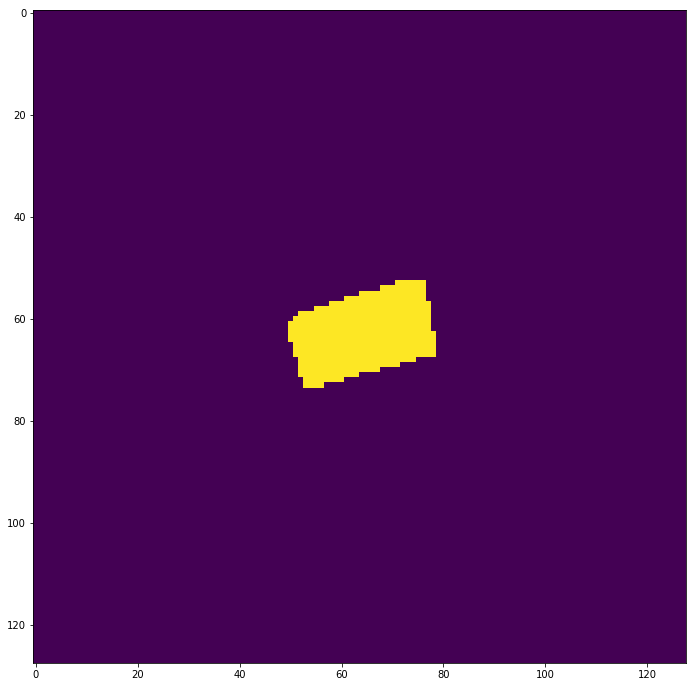

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000012

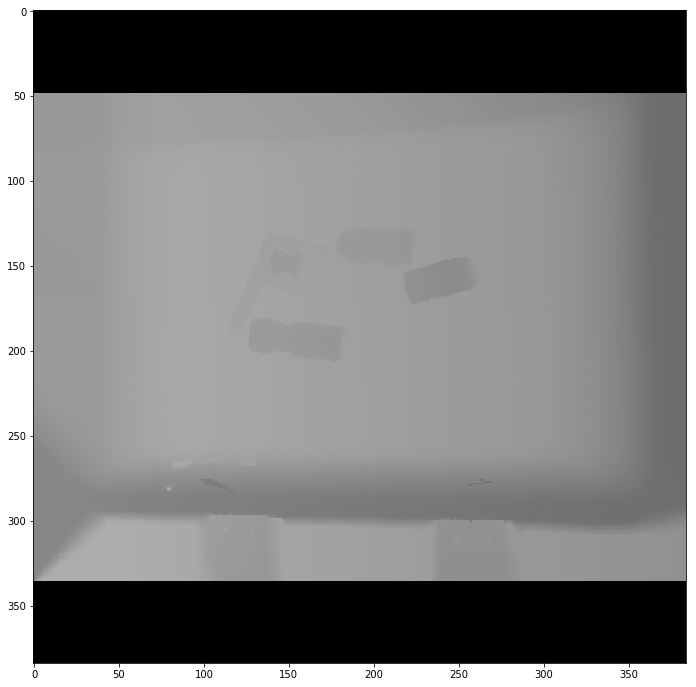

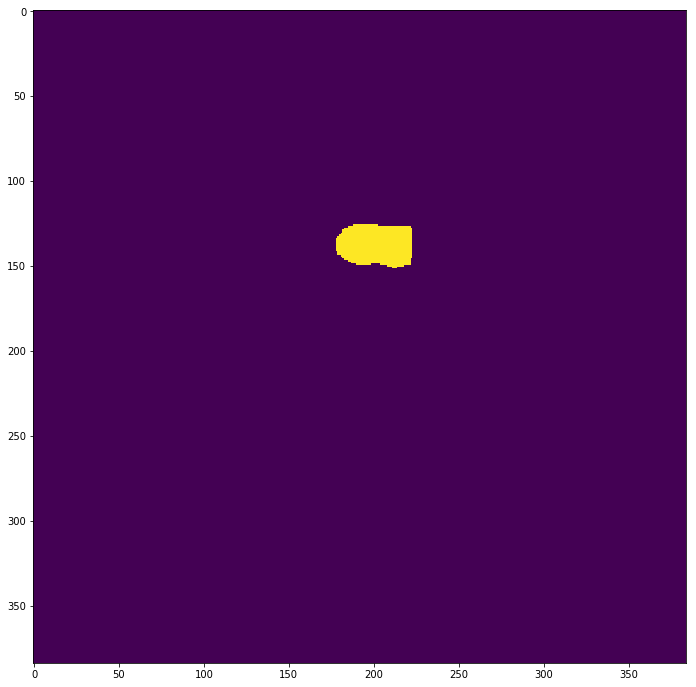

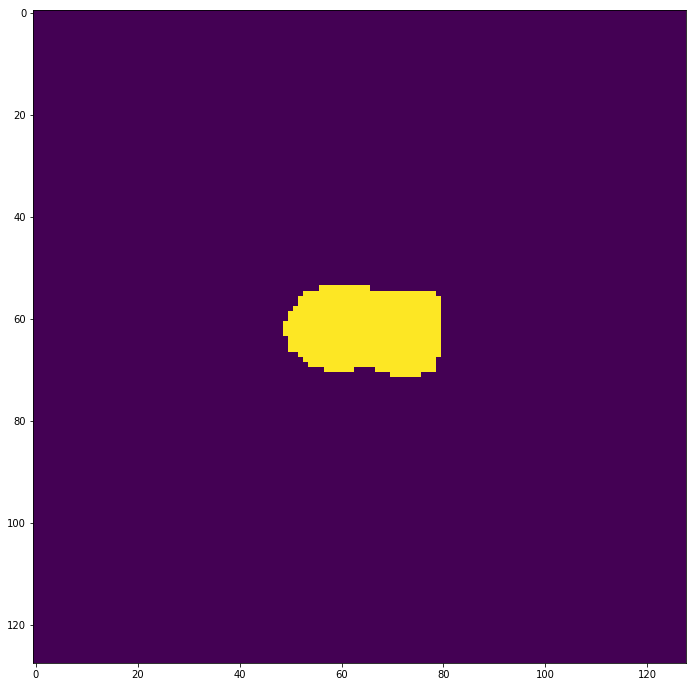

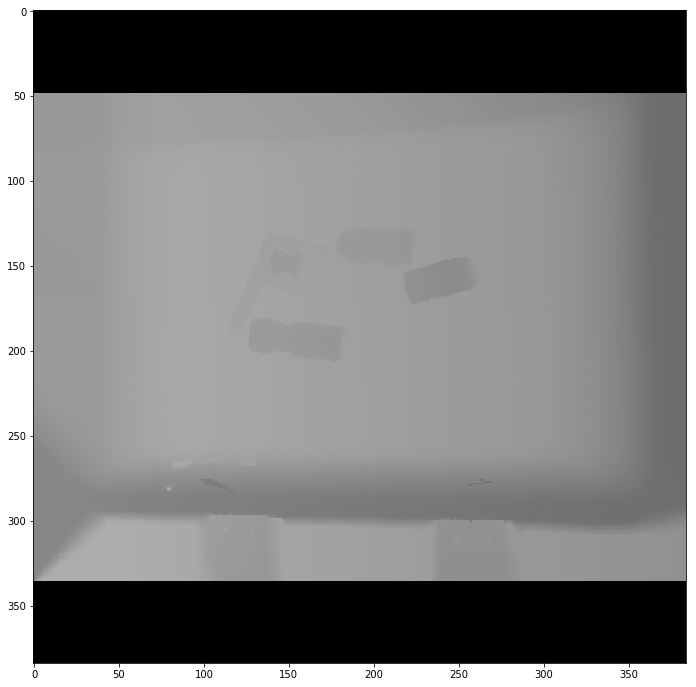

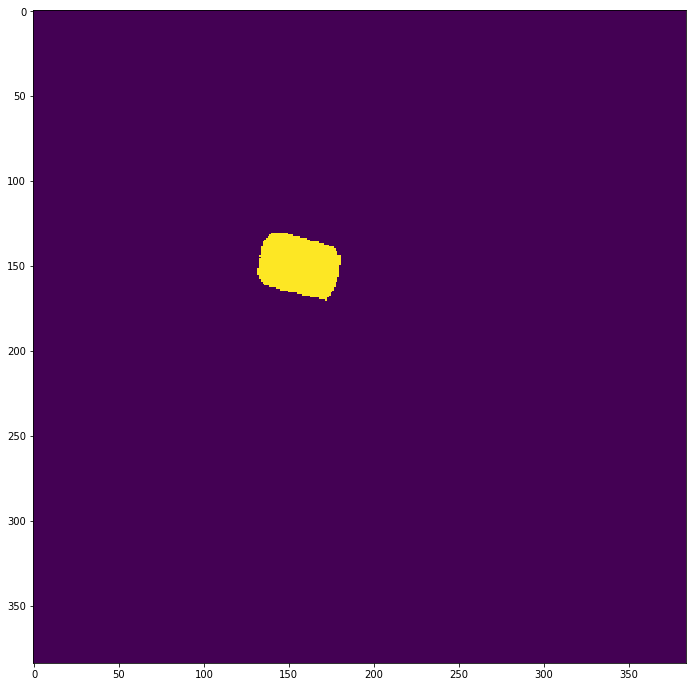

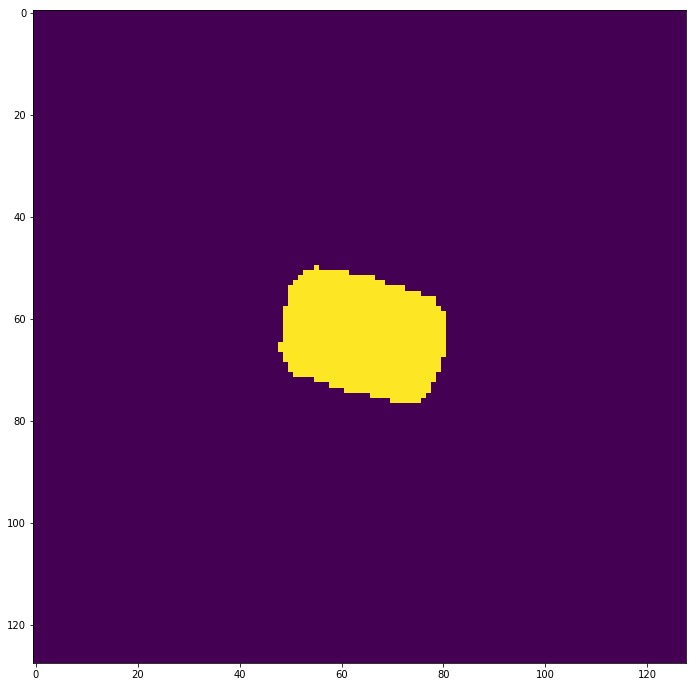

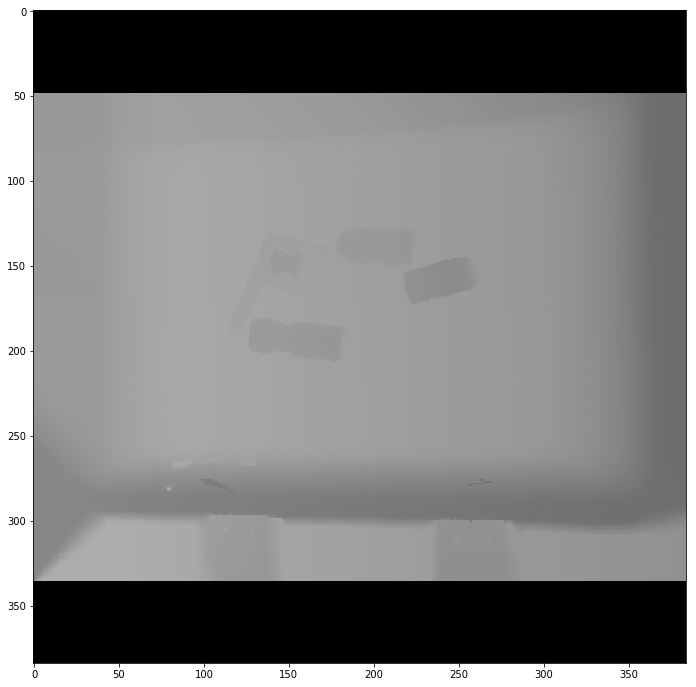

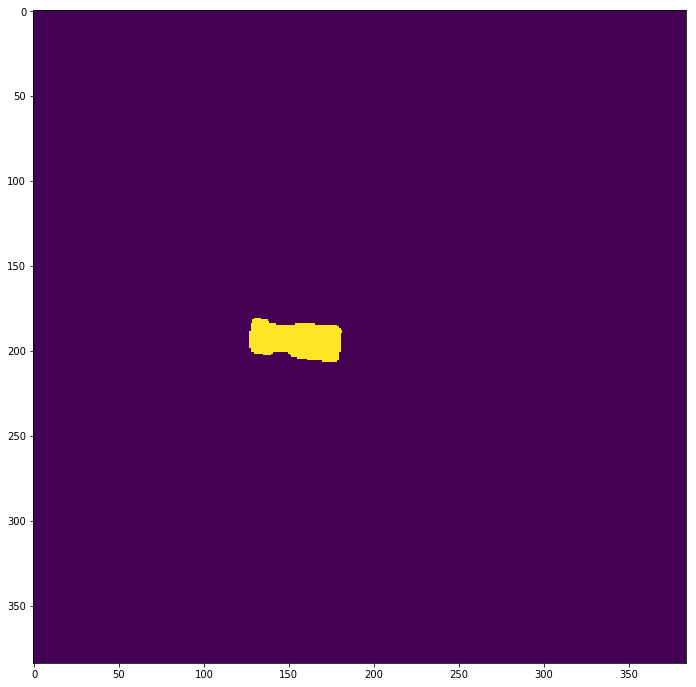

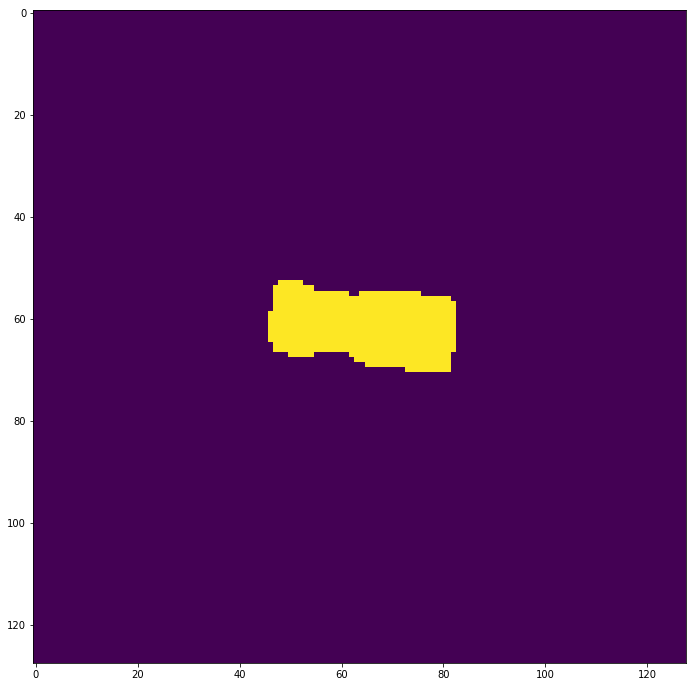

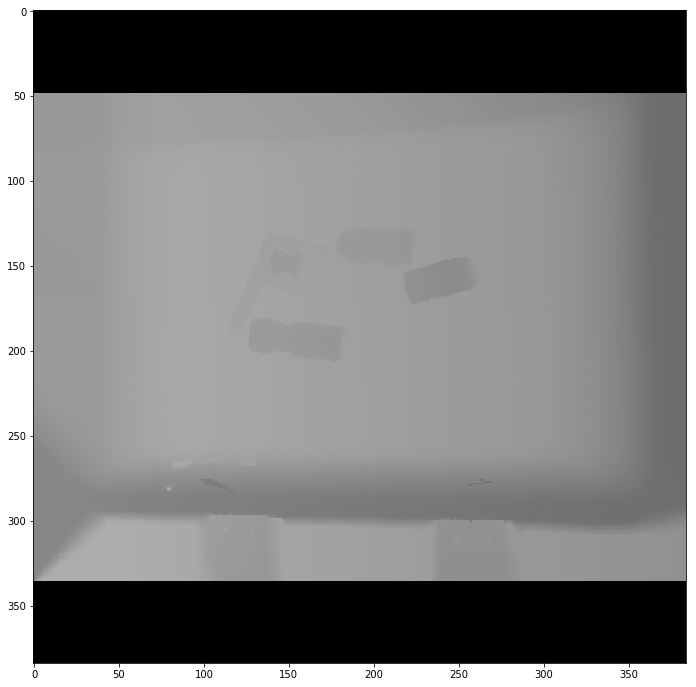

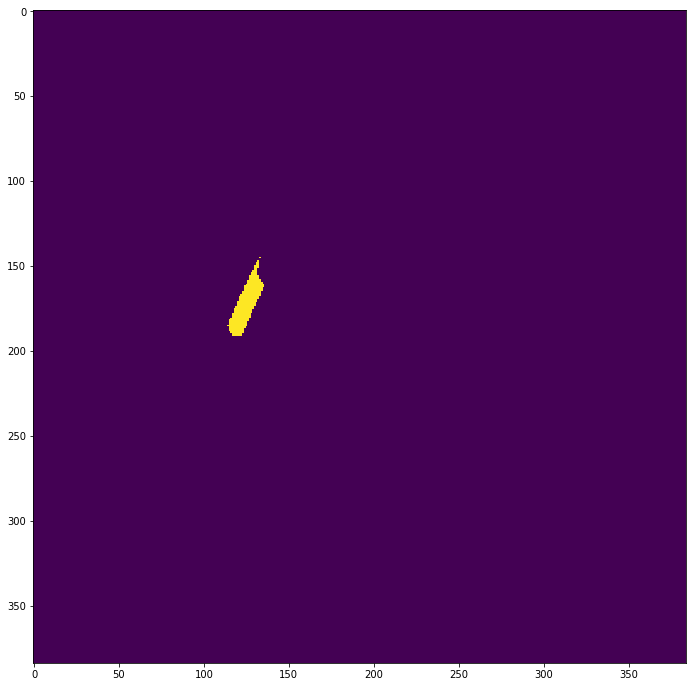

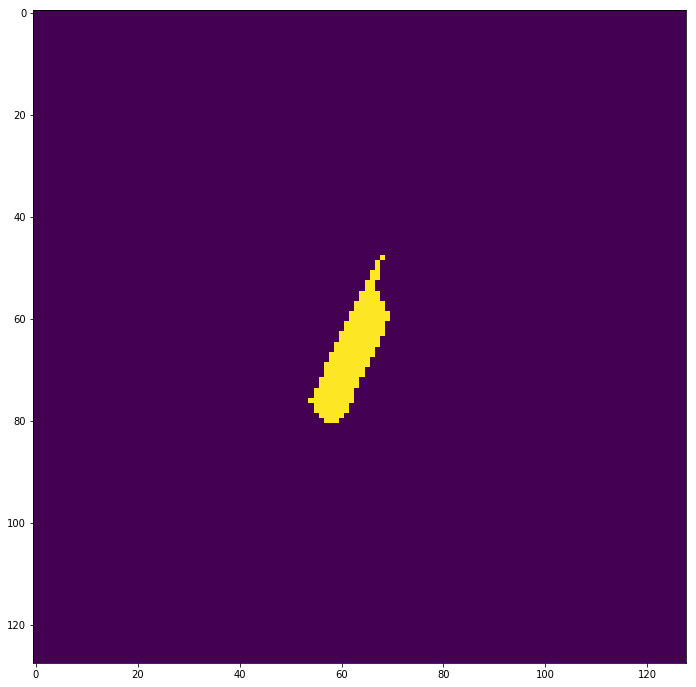

 43%|████▎     | 13/30 [00:41<00:54,  3.18s/it]

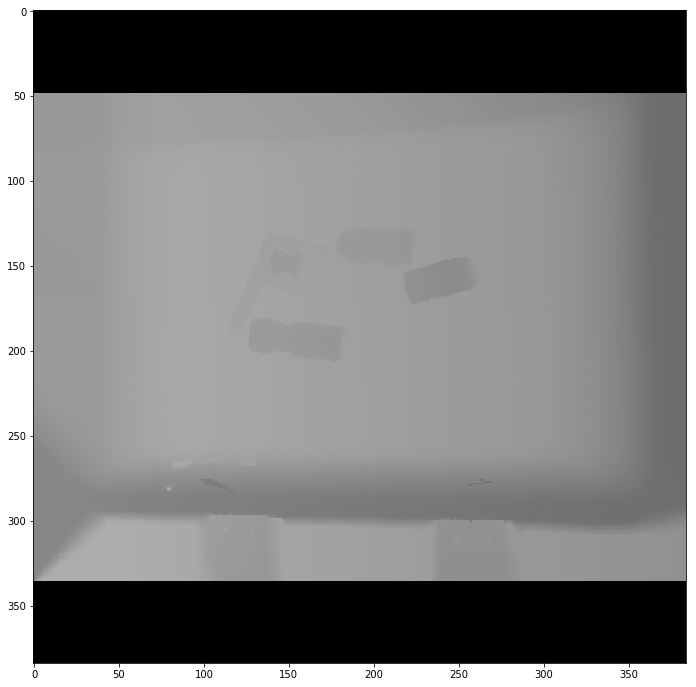

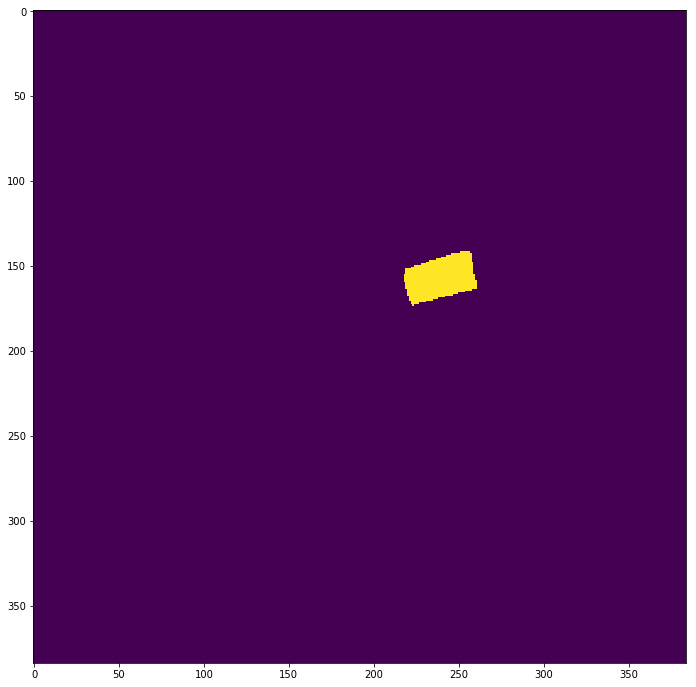

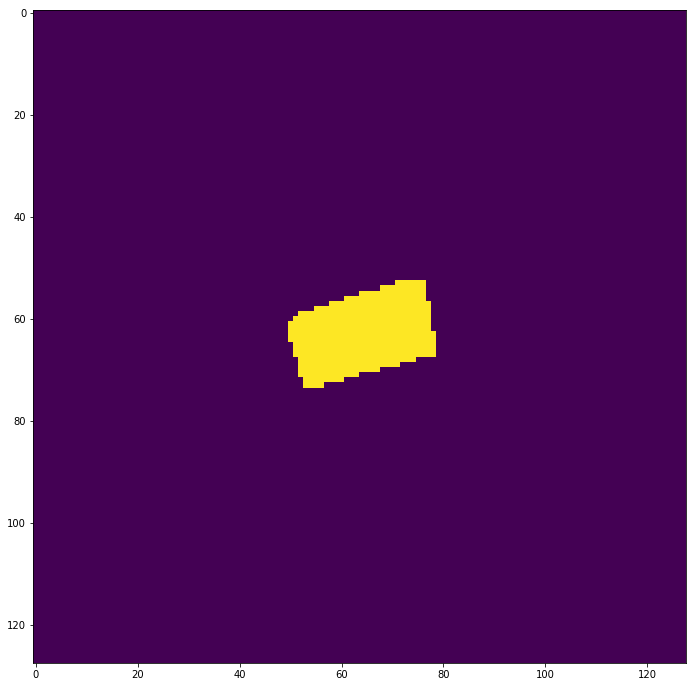

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000013

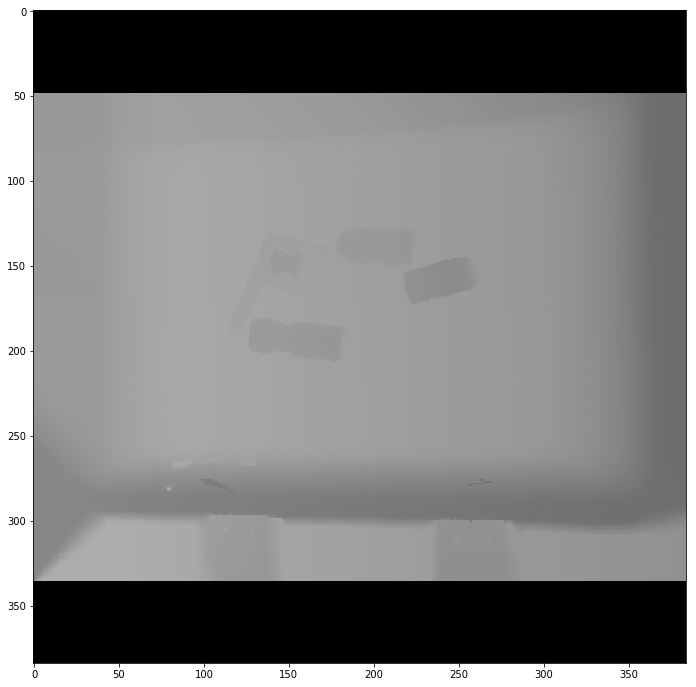

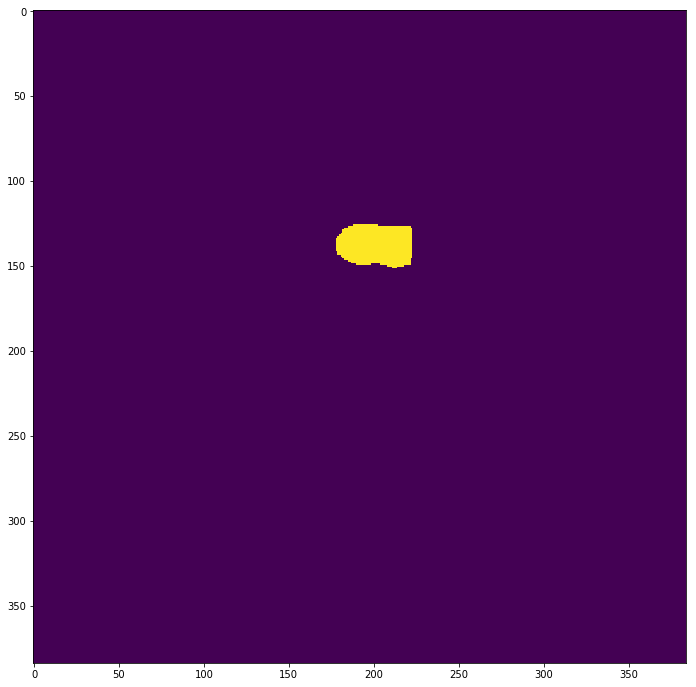

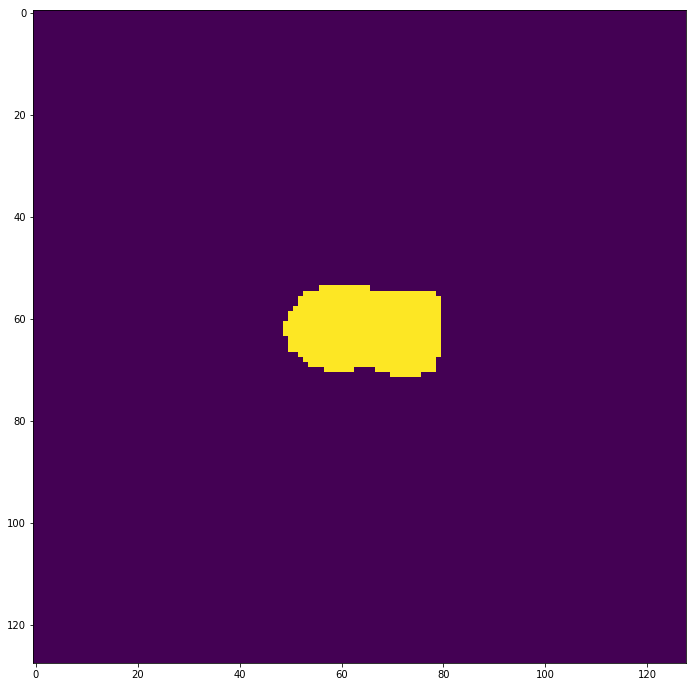

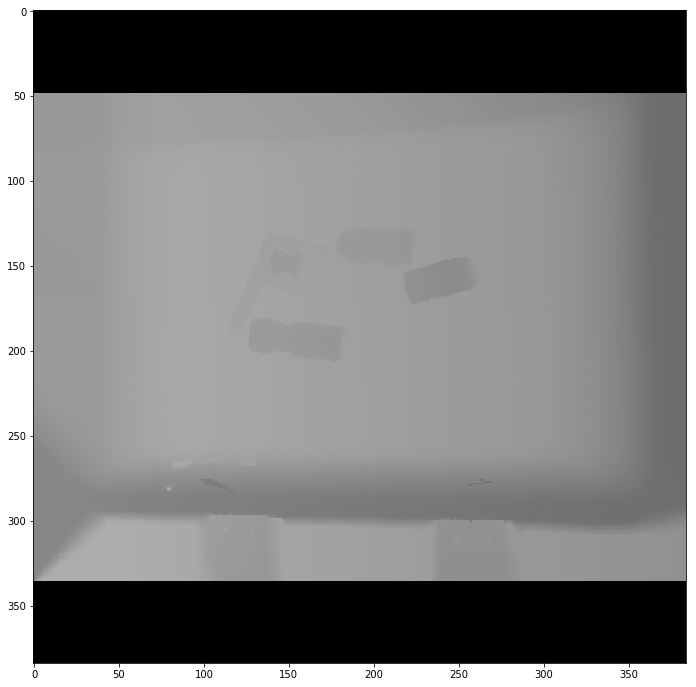

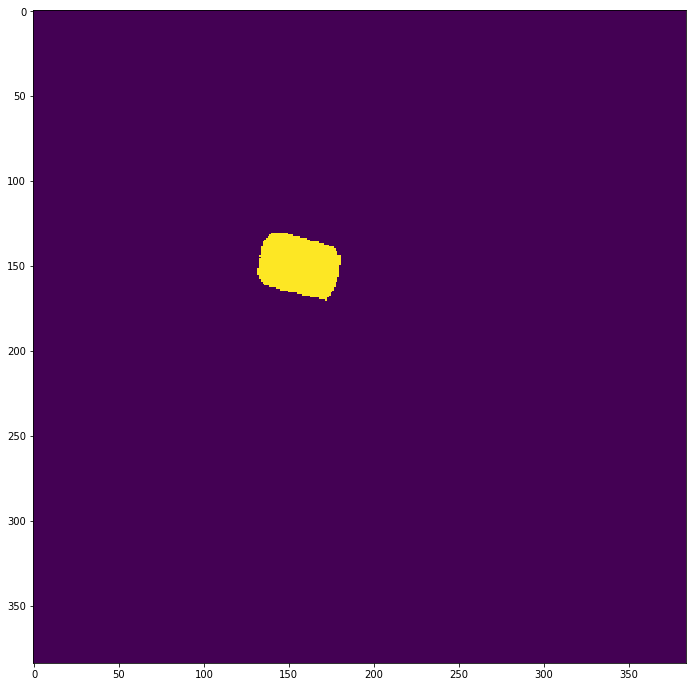

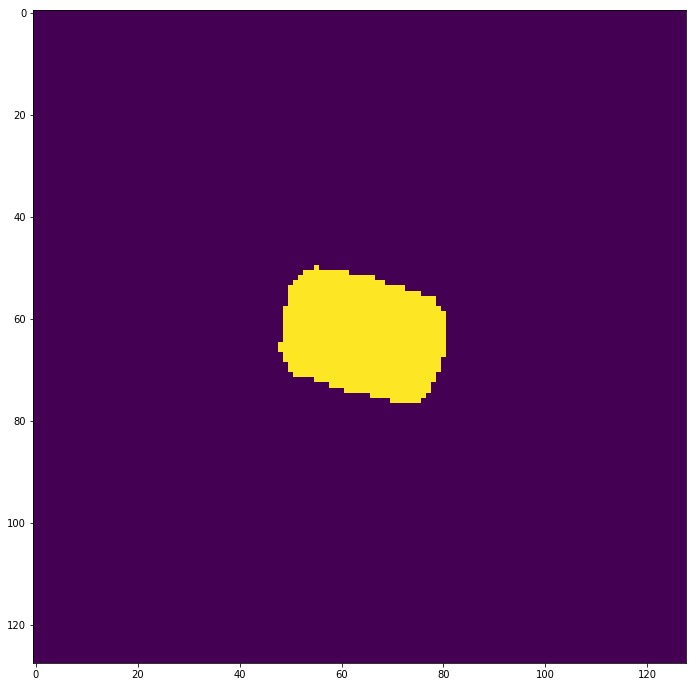

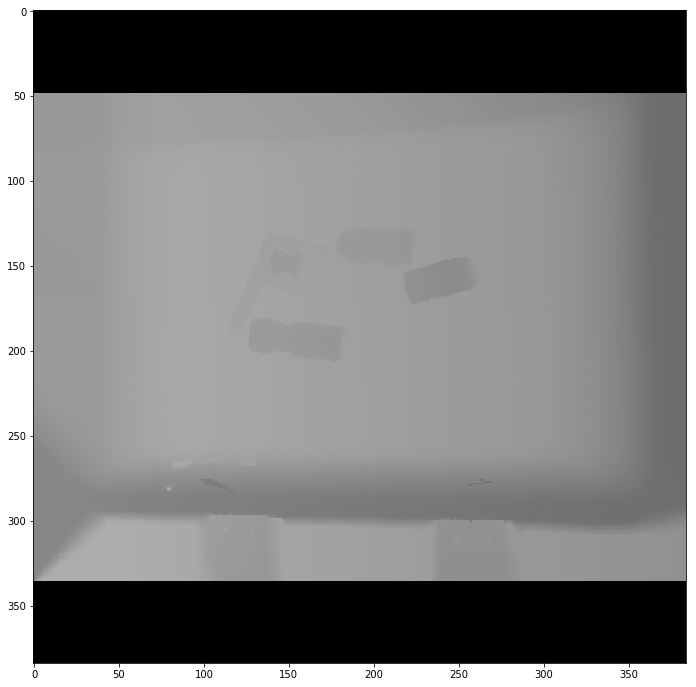

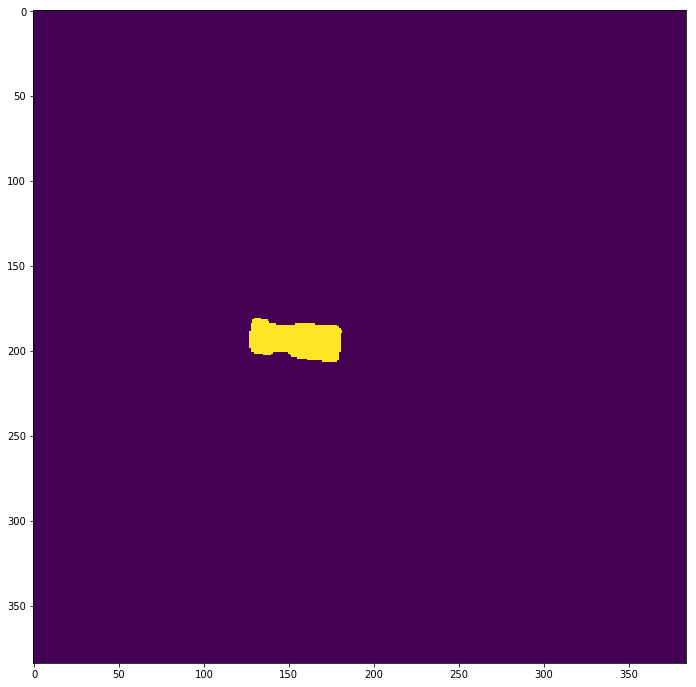

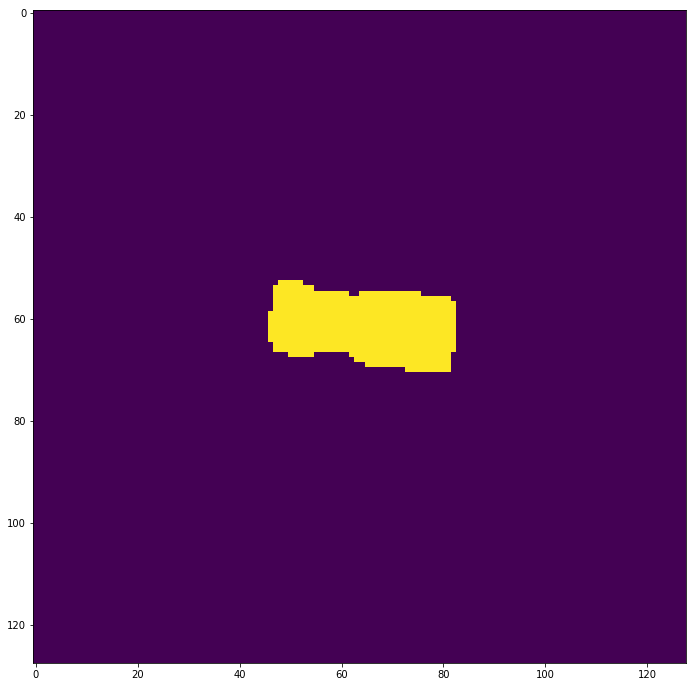

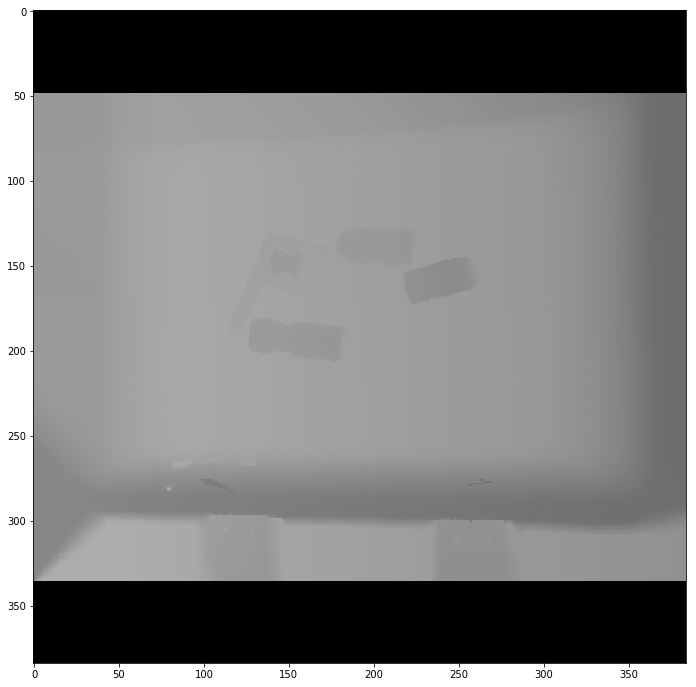

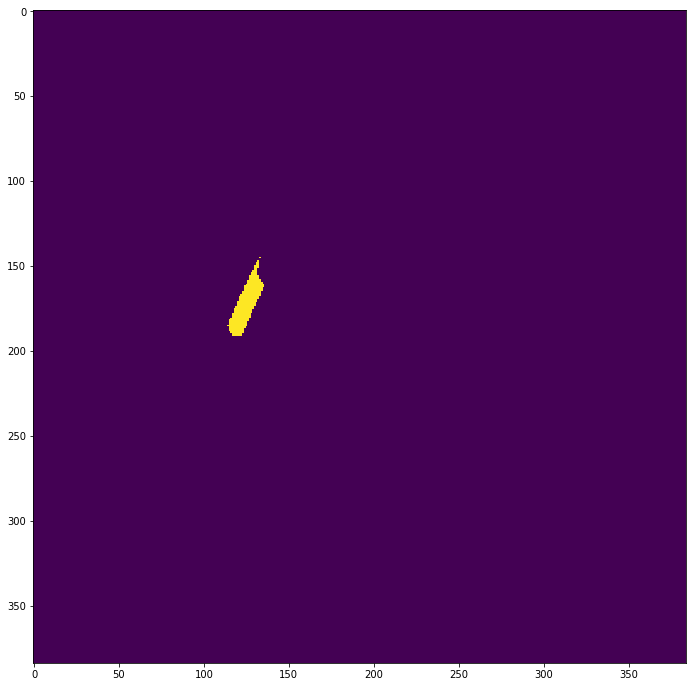

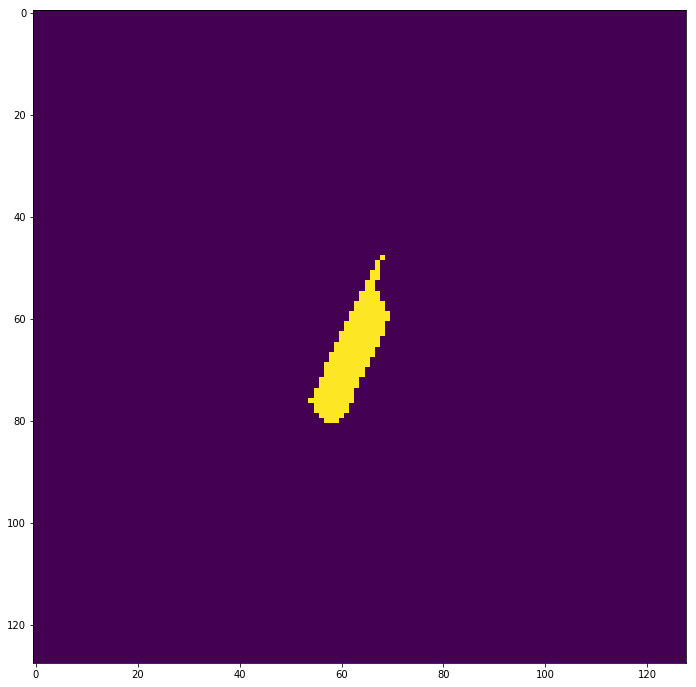

 47%|████▋     | 14/30 [00:44<00:50,  3.18s/it]

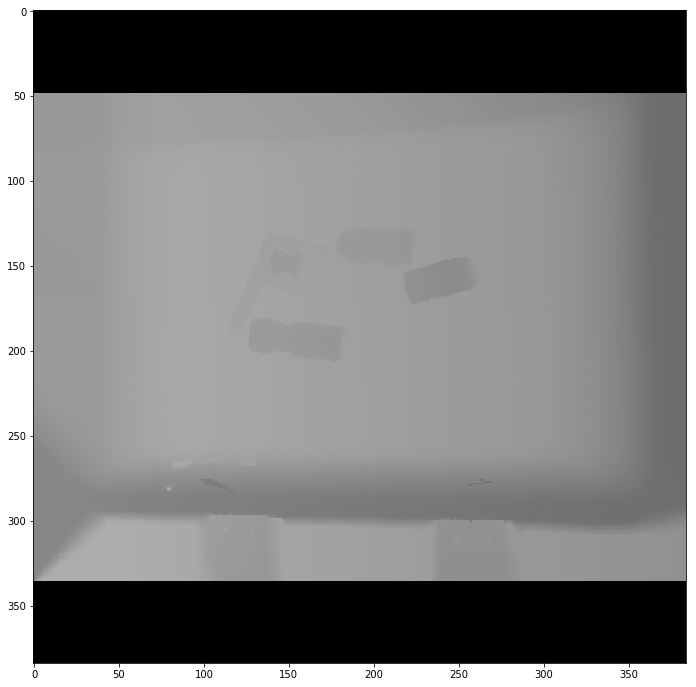

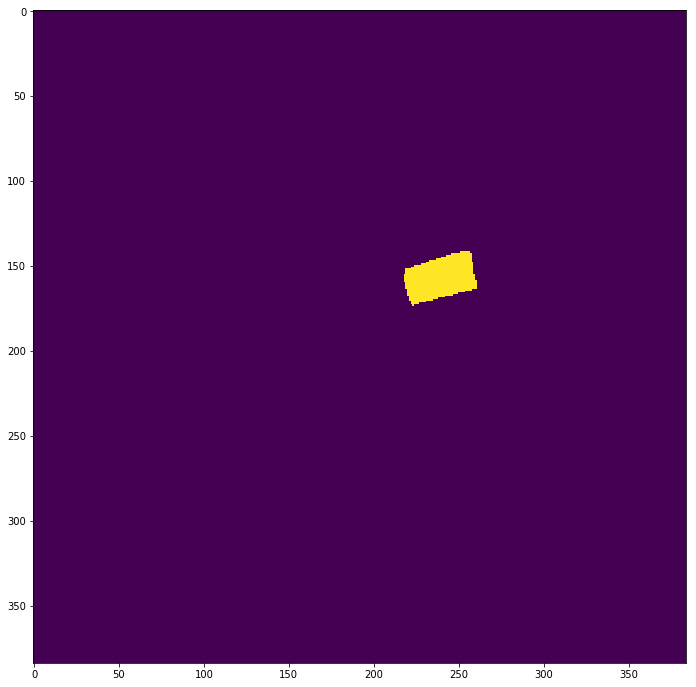

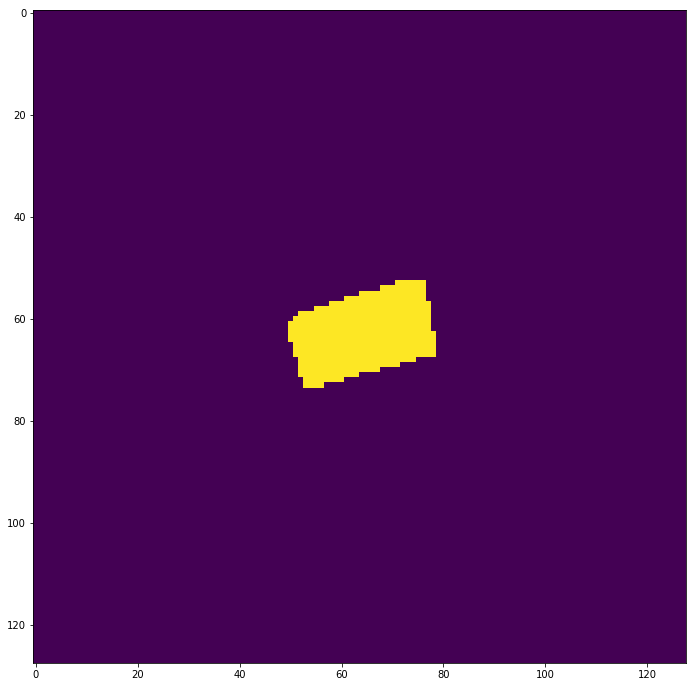

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000014

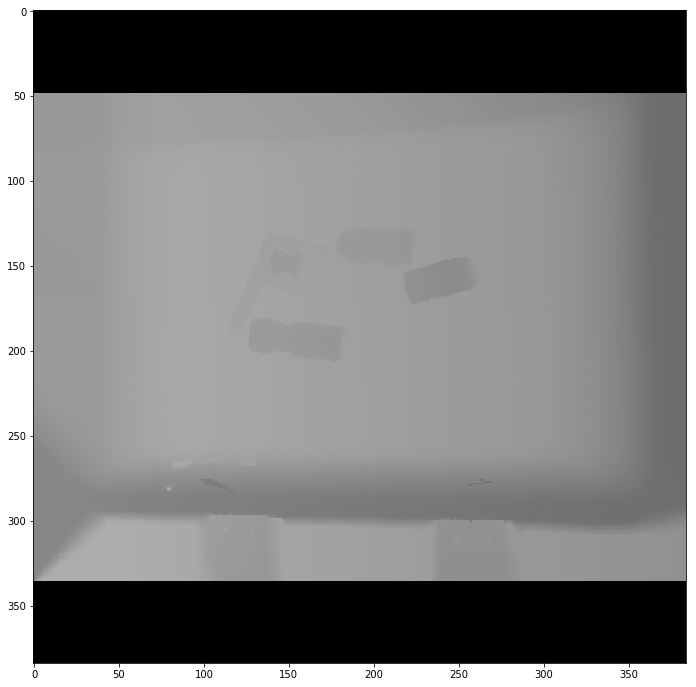

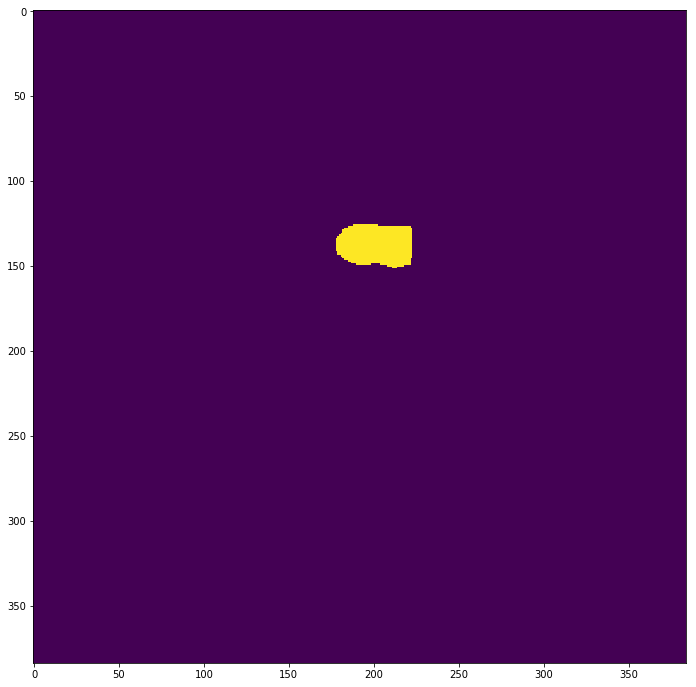

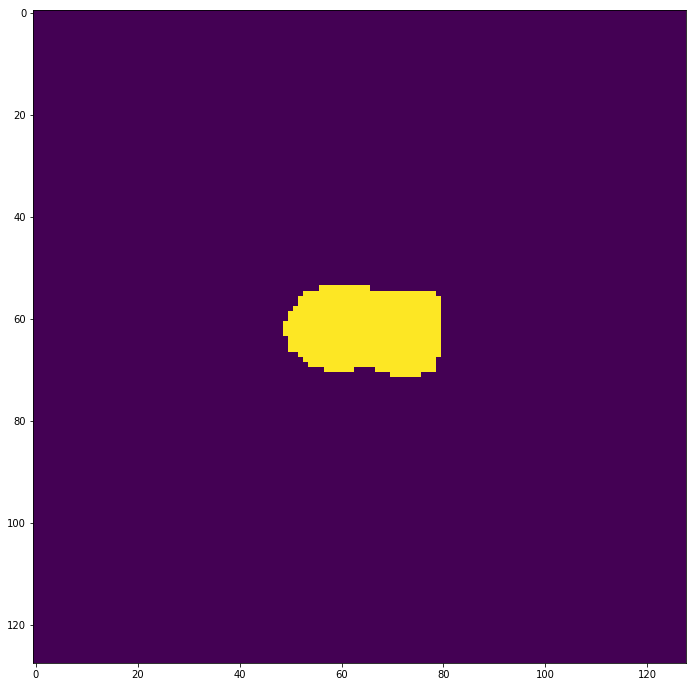

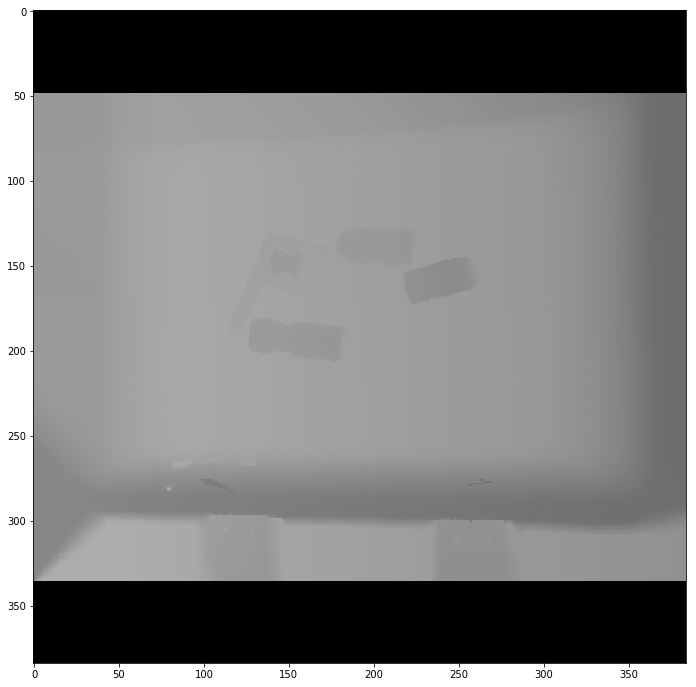

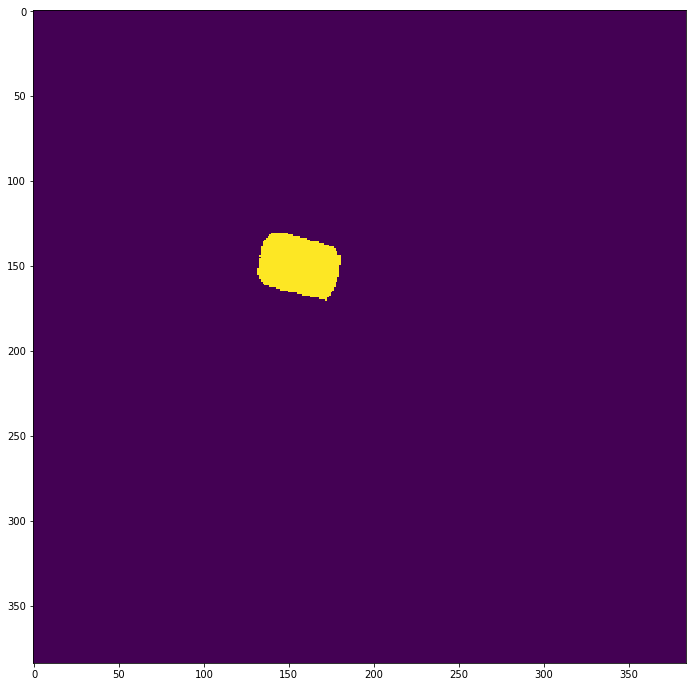

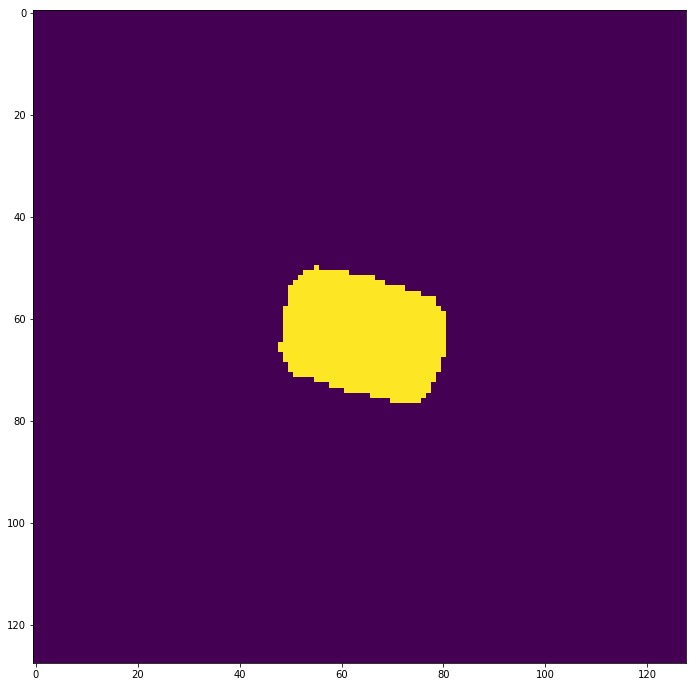

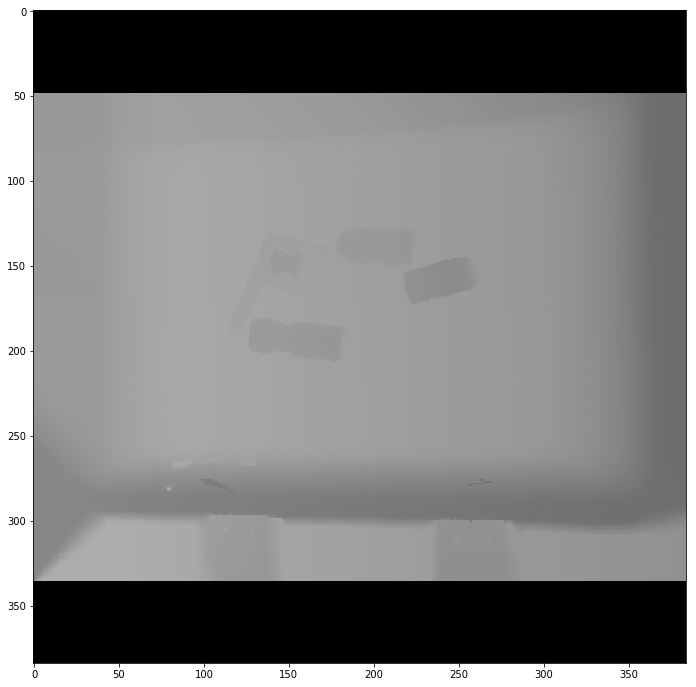

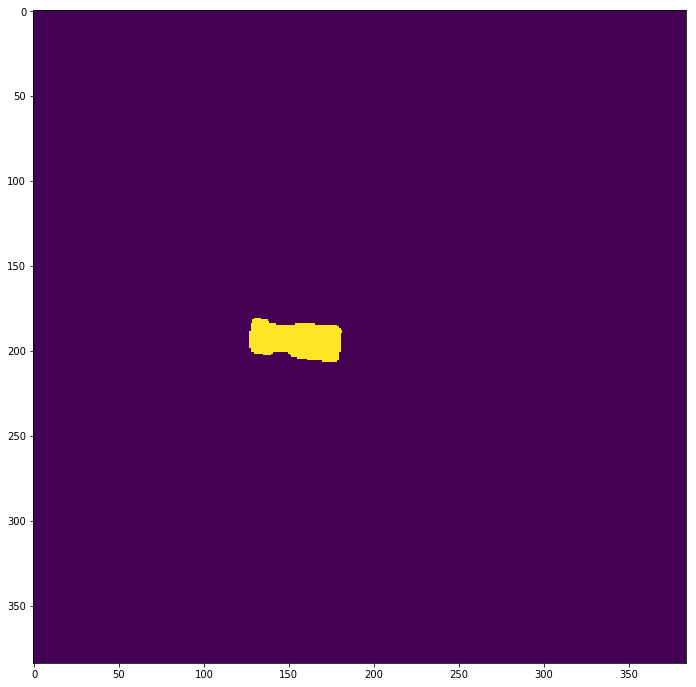

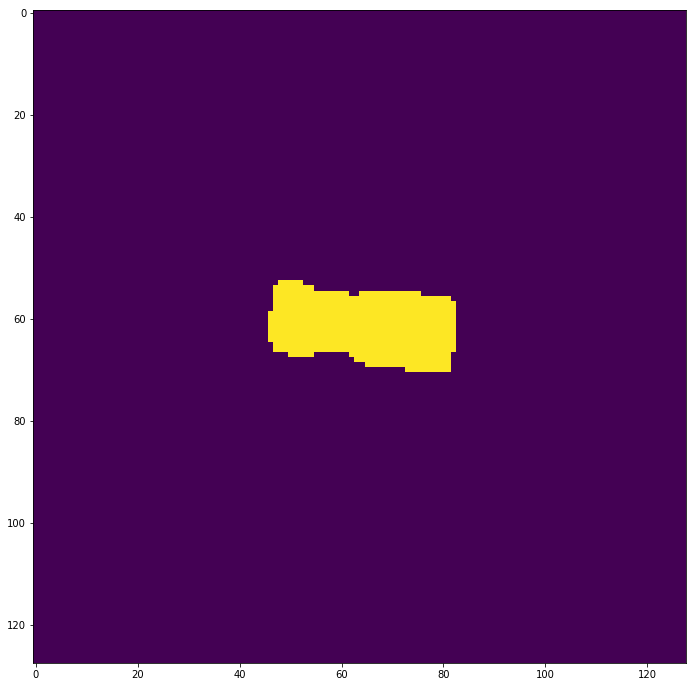

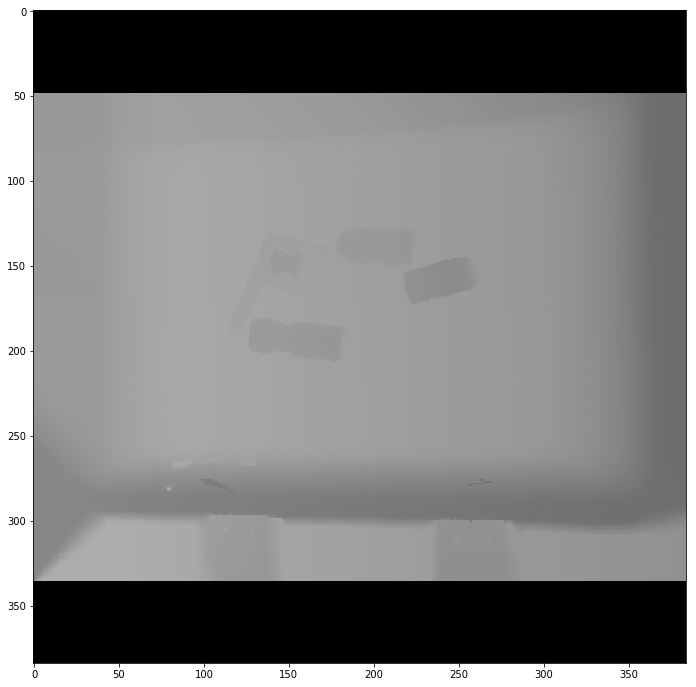

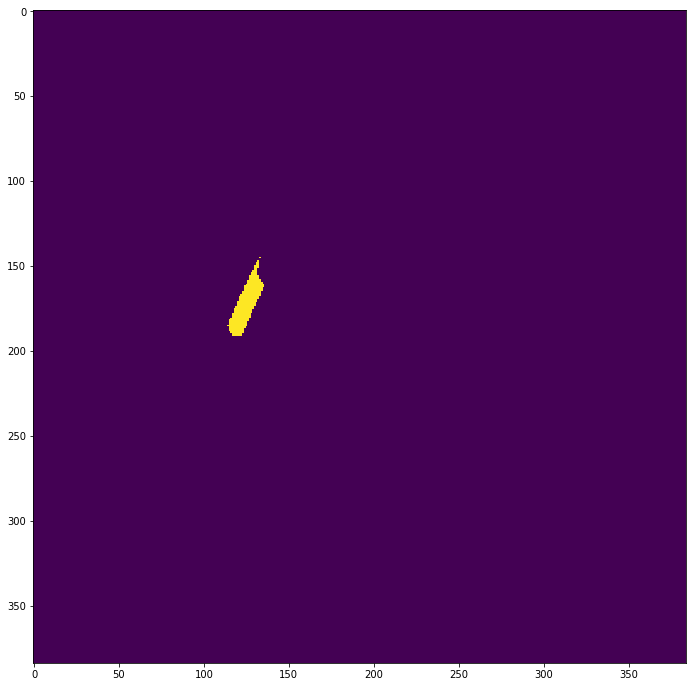

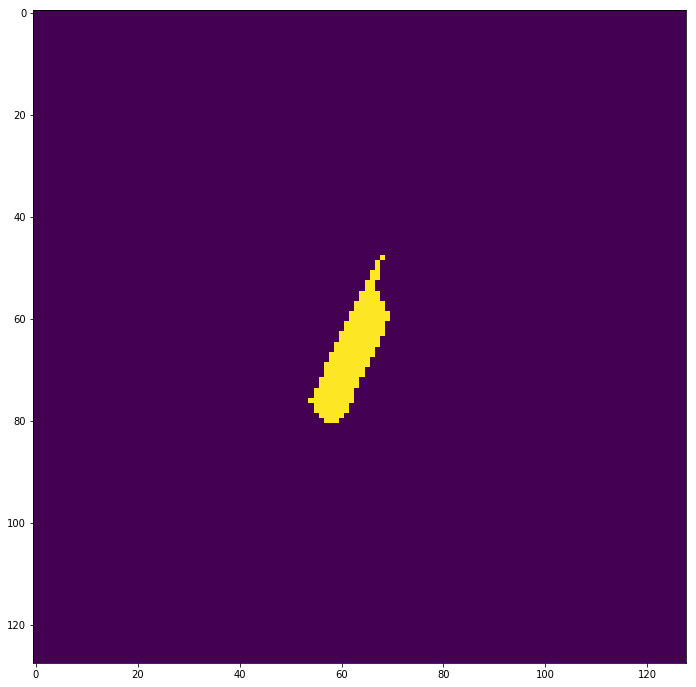

 50%|█████     | 15/30 [00:47<00:48,  3.20s/it]

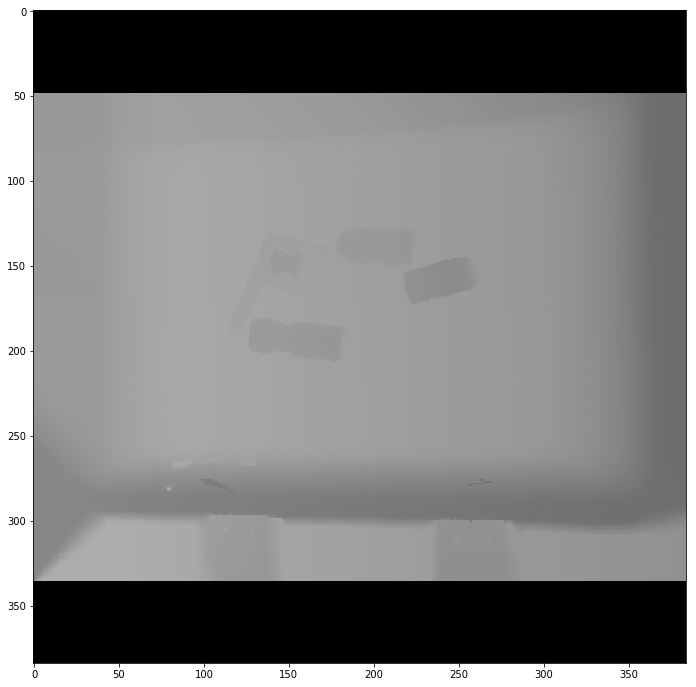

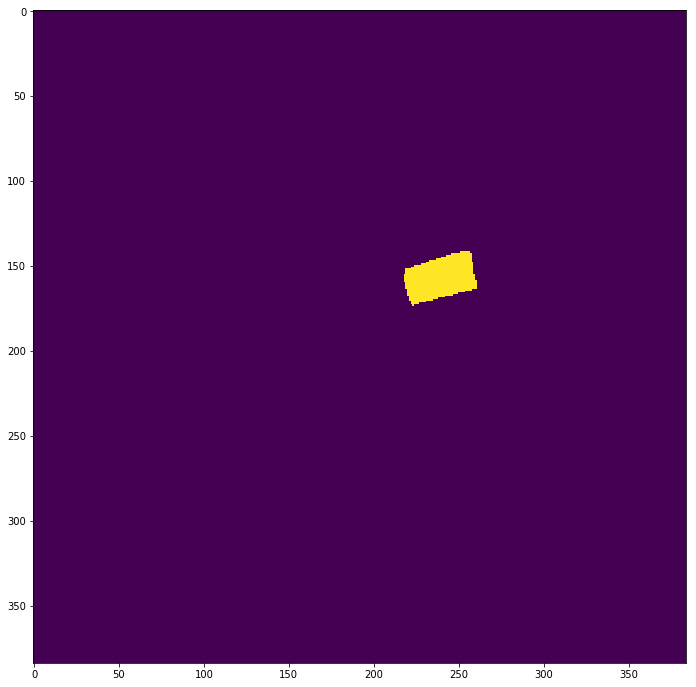

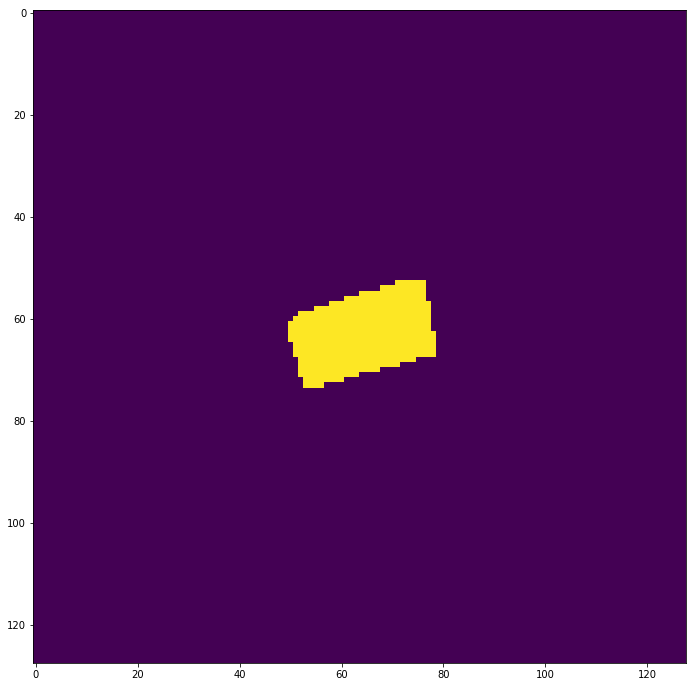

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000015

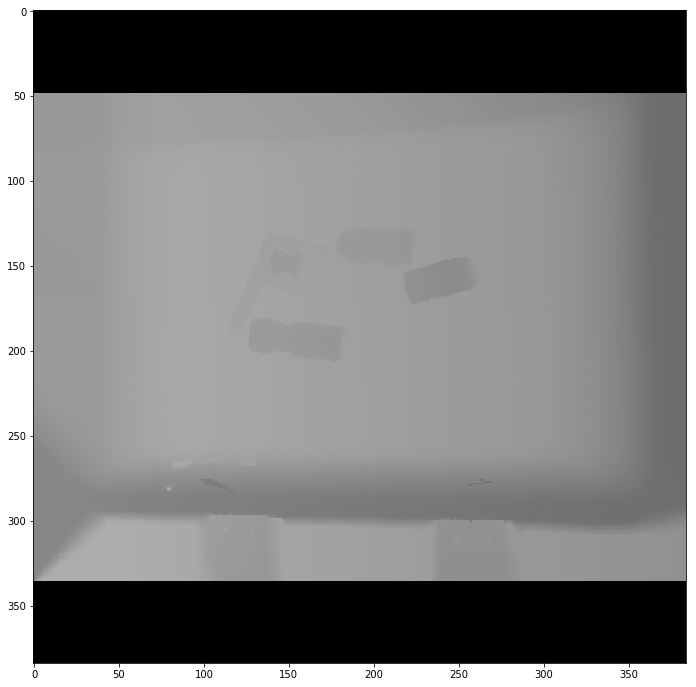

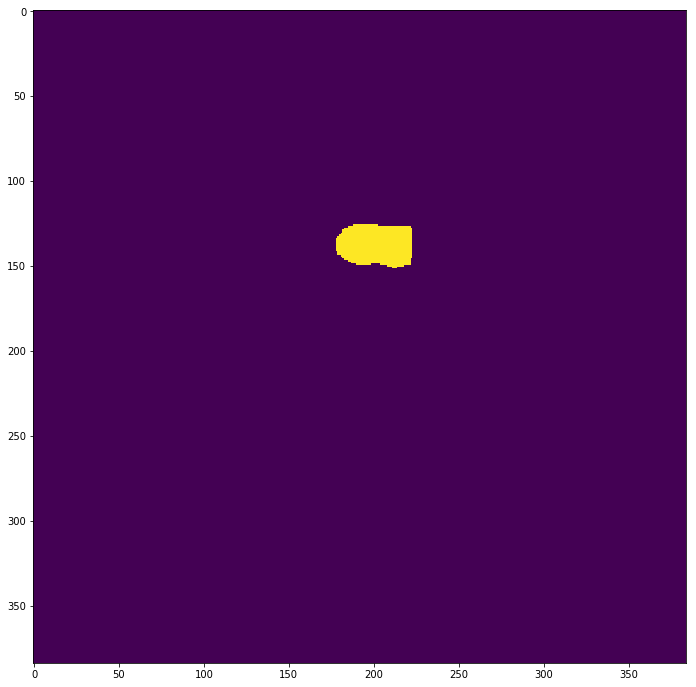

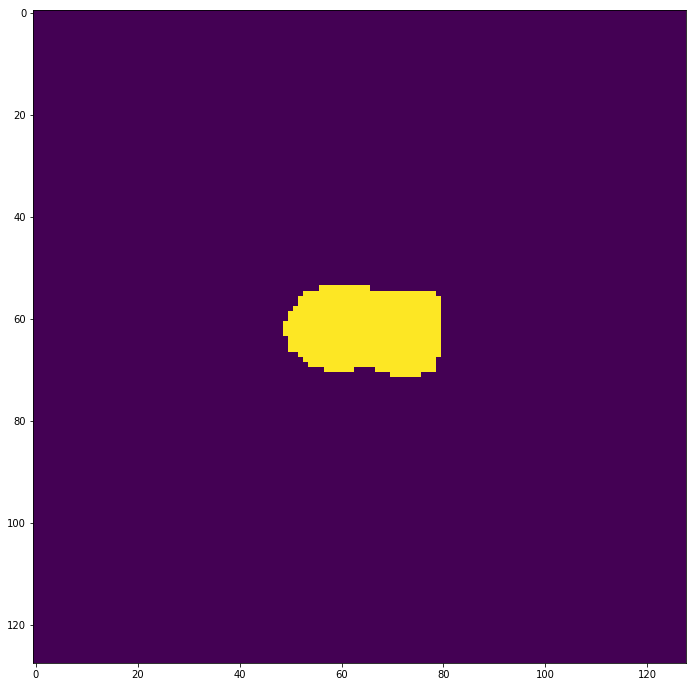

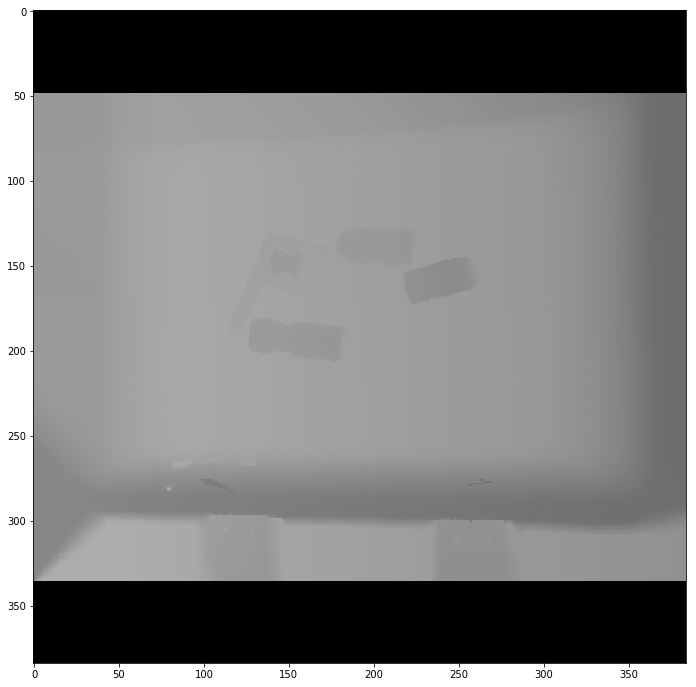

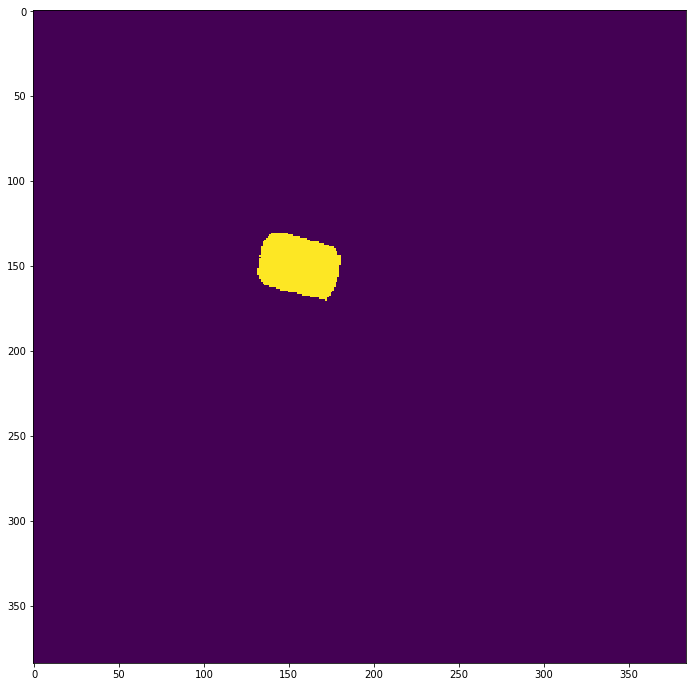

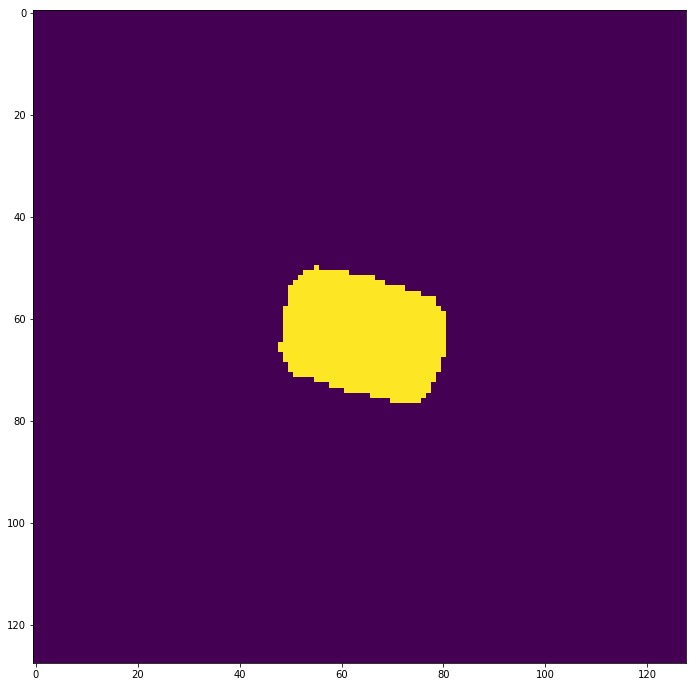

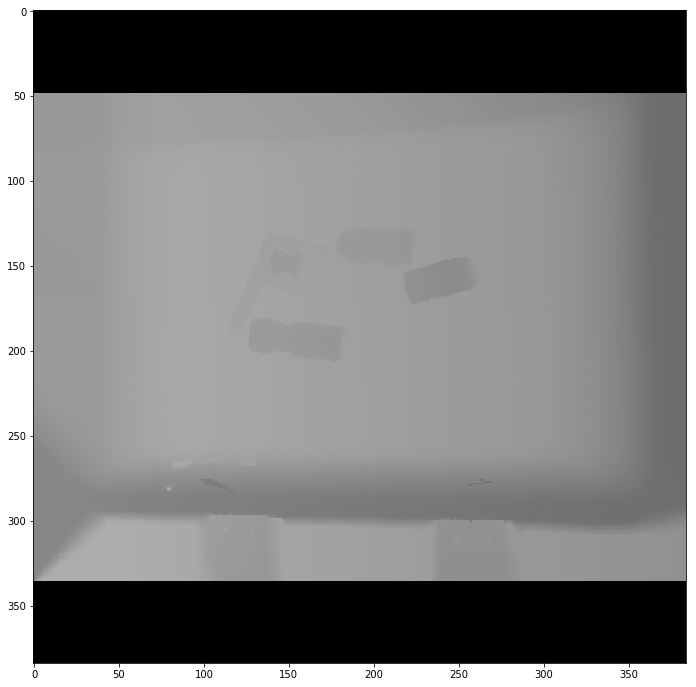

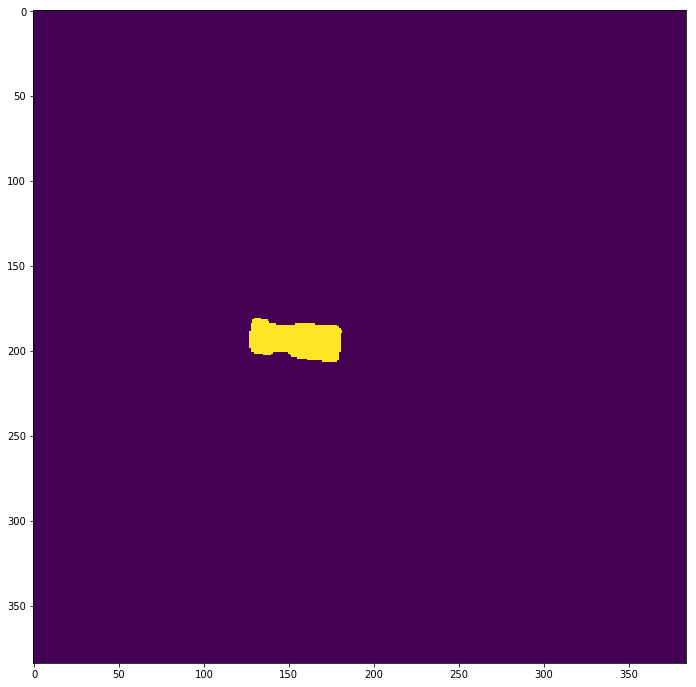

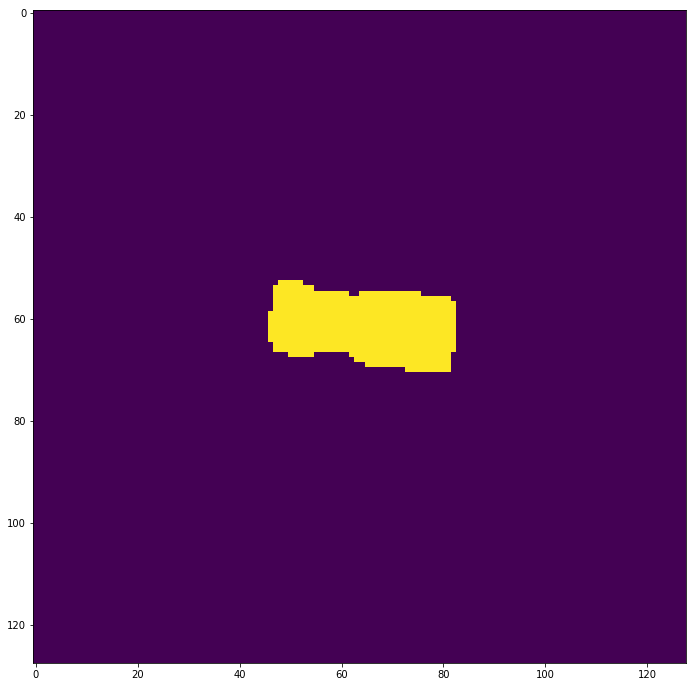

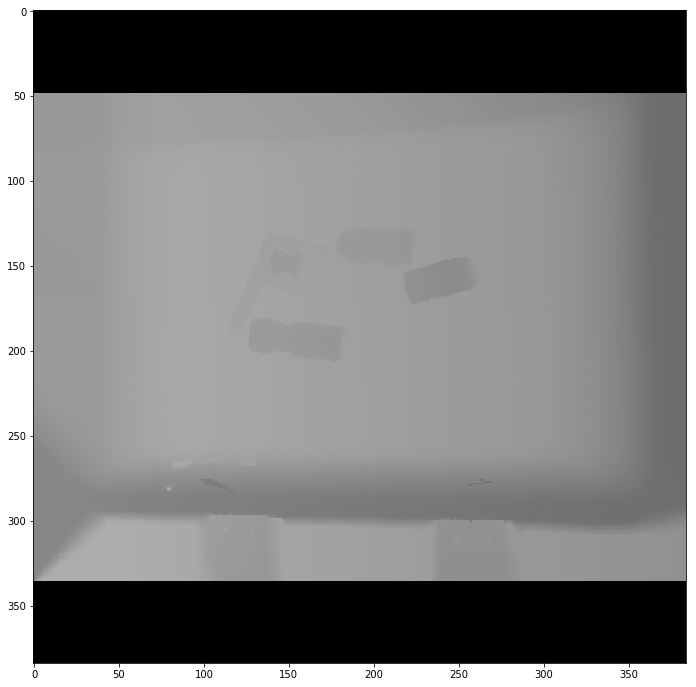

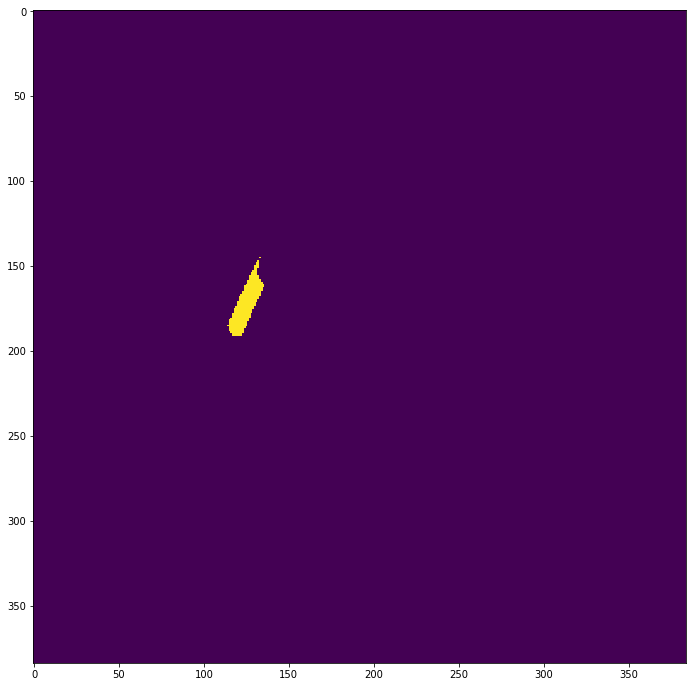

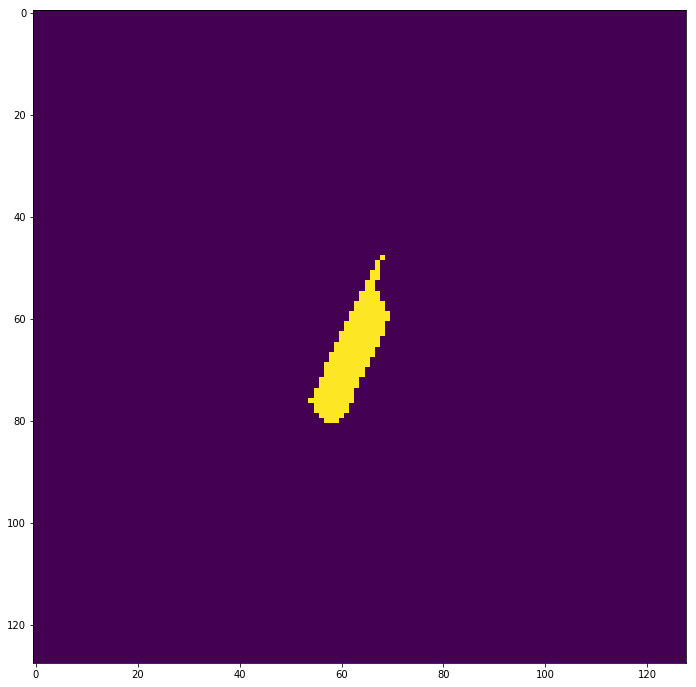

 53%|█████▎    | 16/30 [00:51<00:45,  3.22s/it]

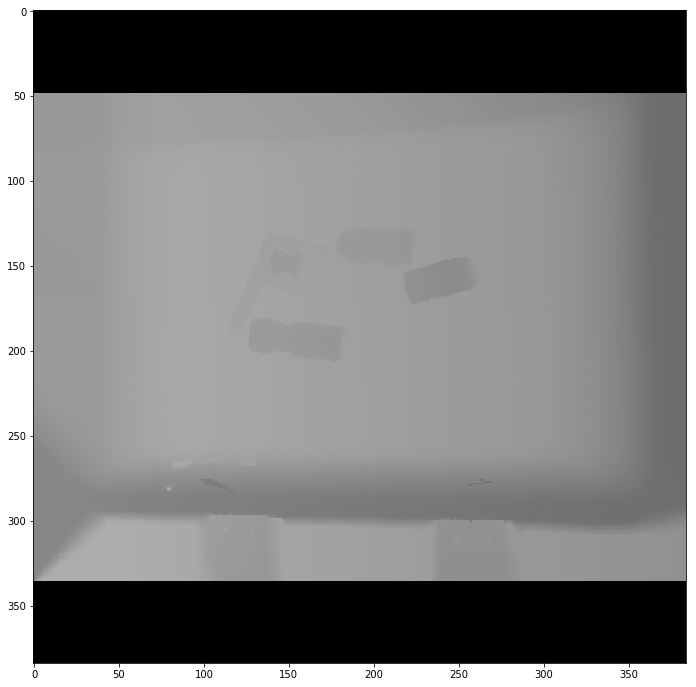

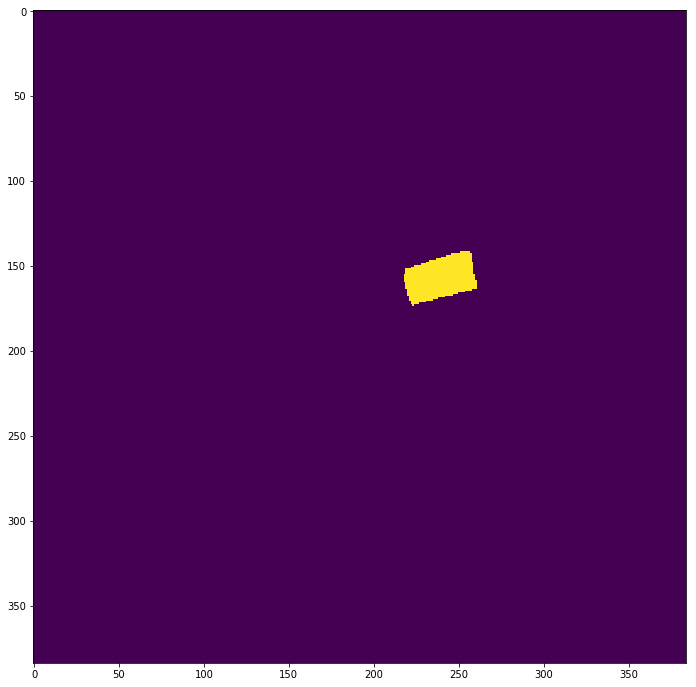

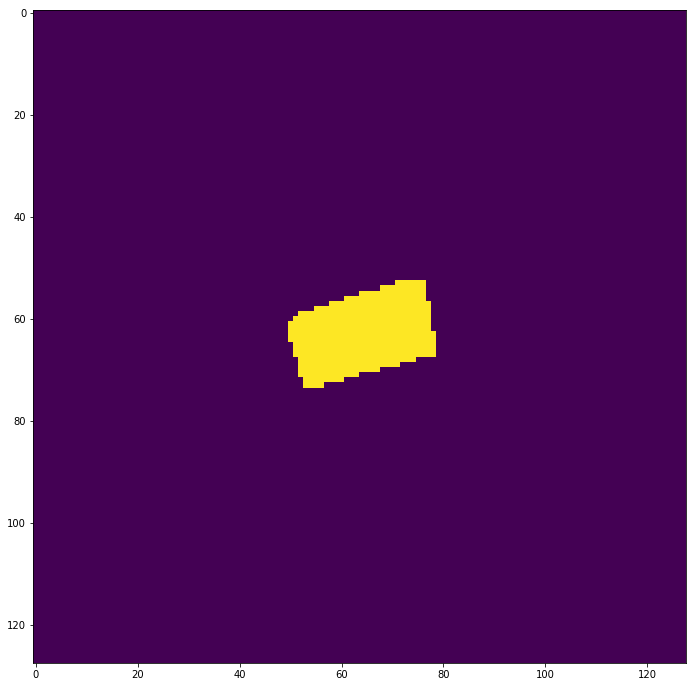

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000016

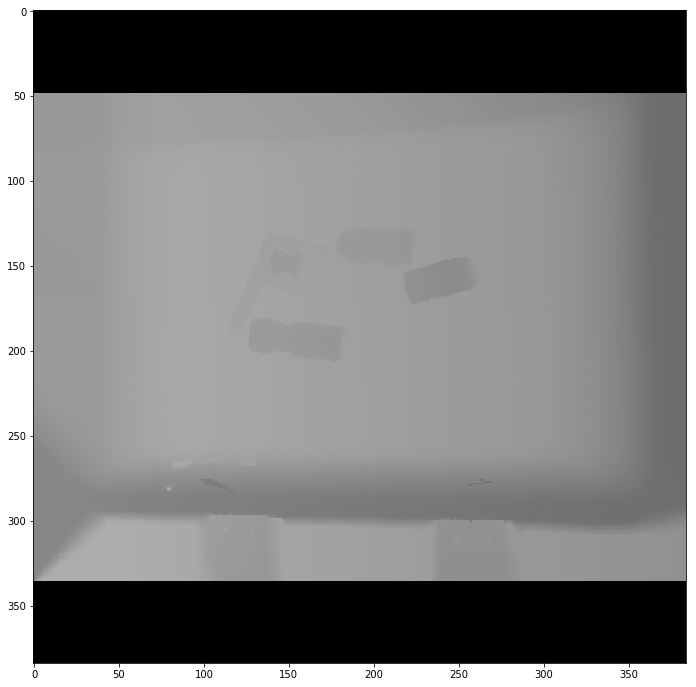

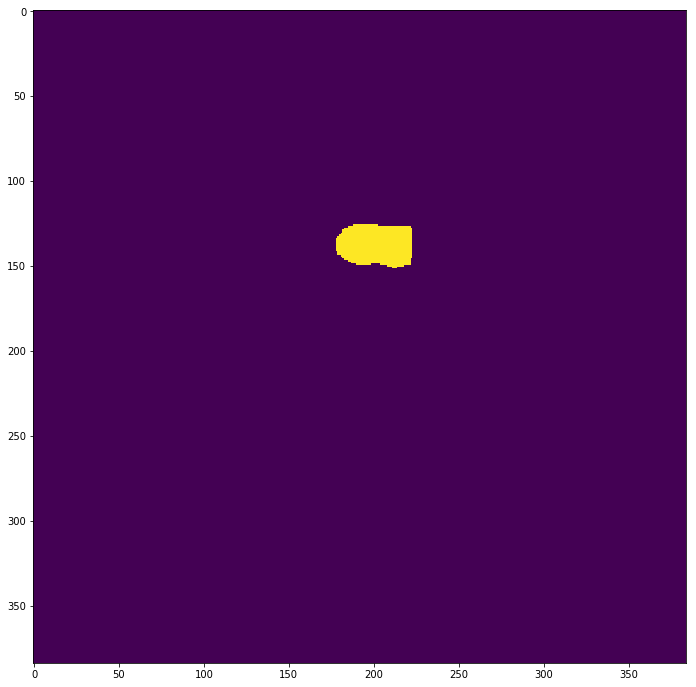

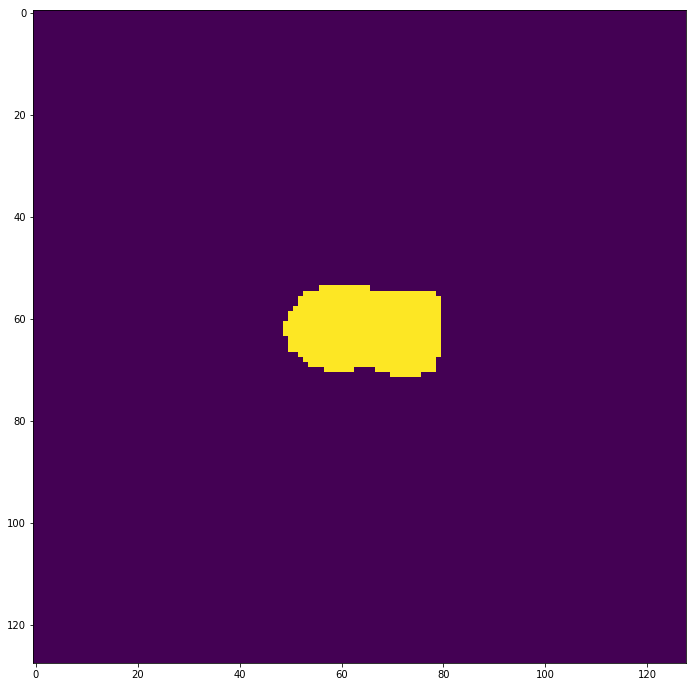

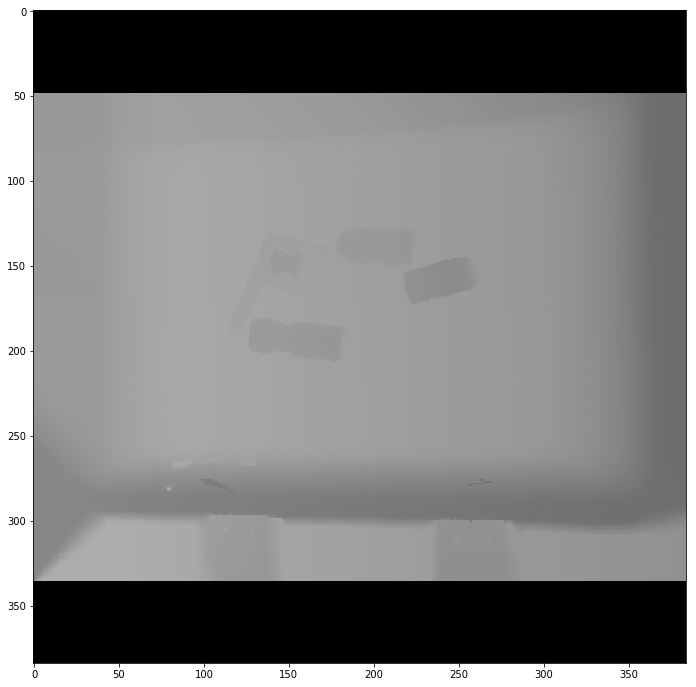

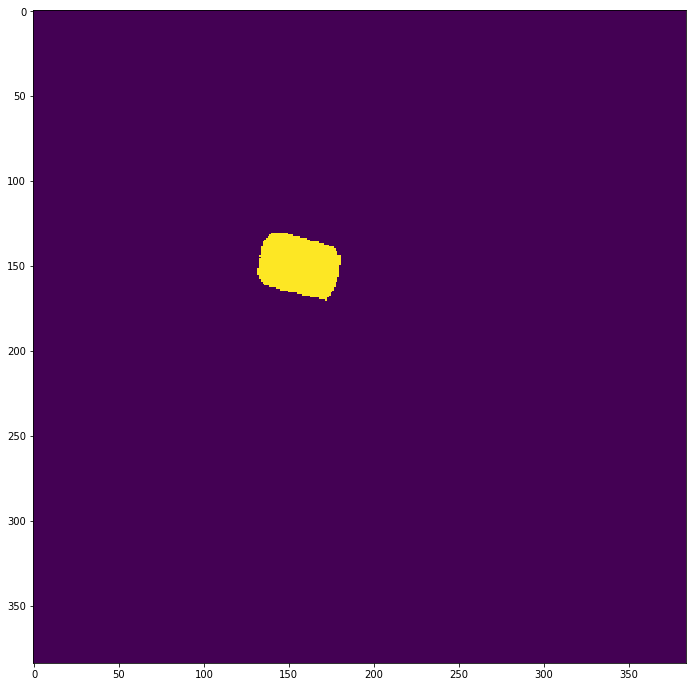

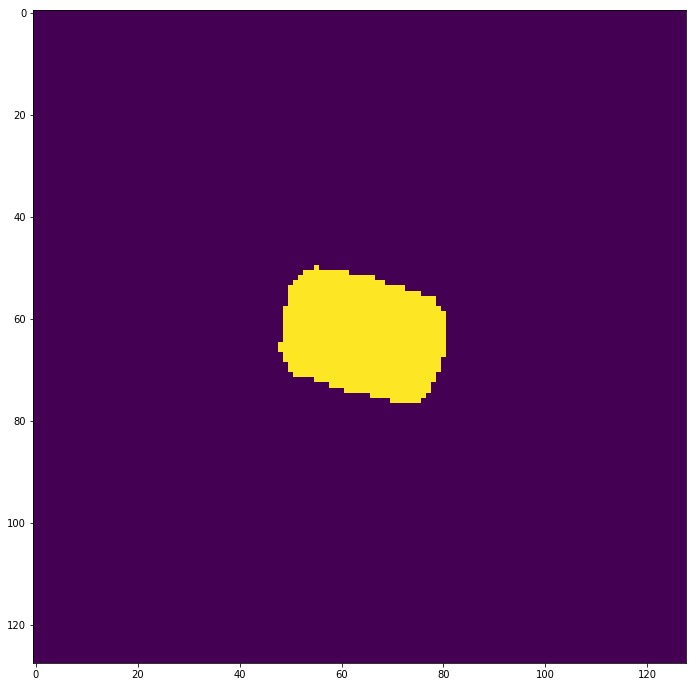

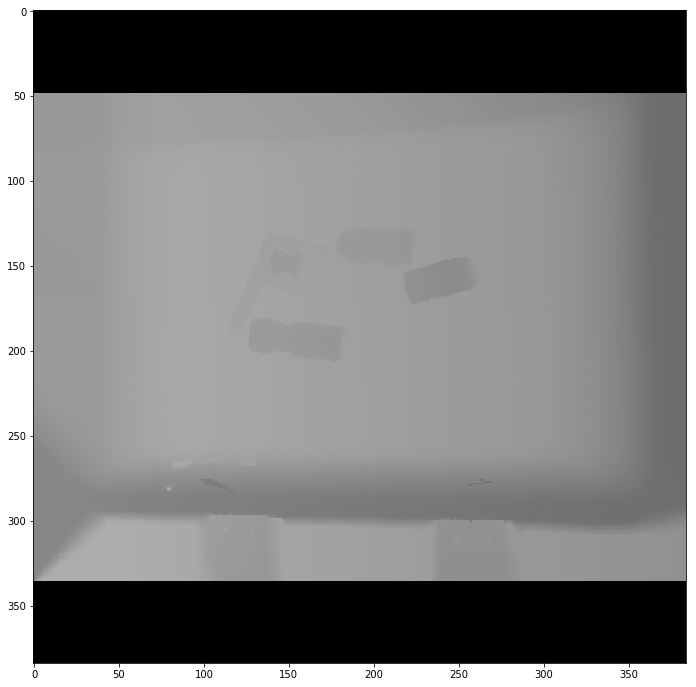

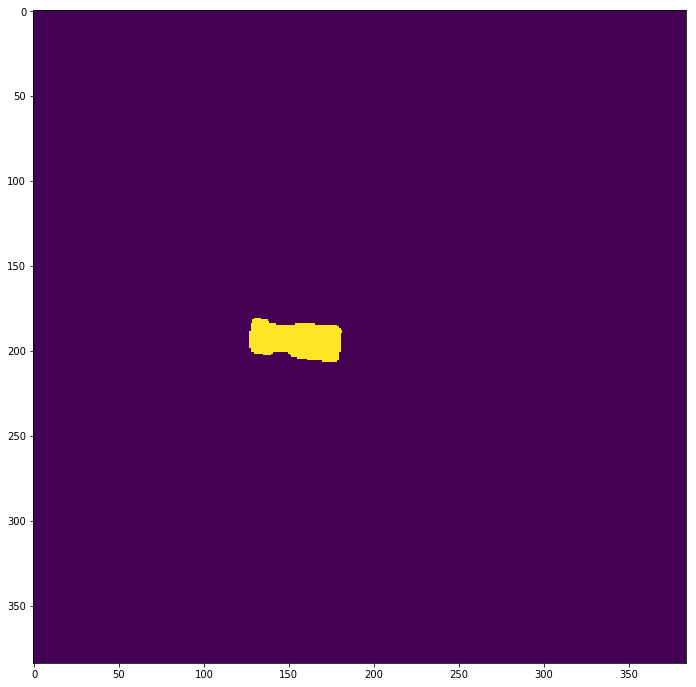

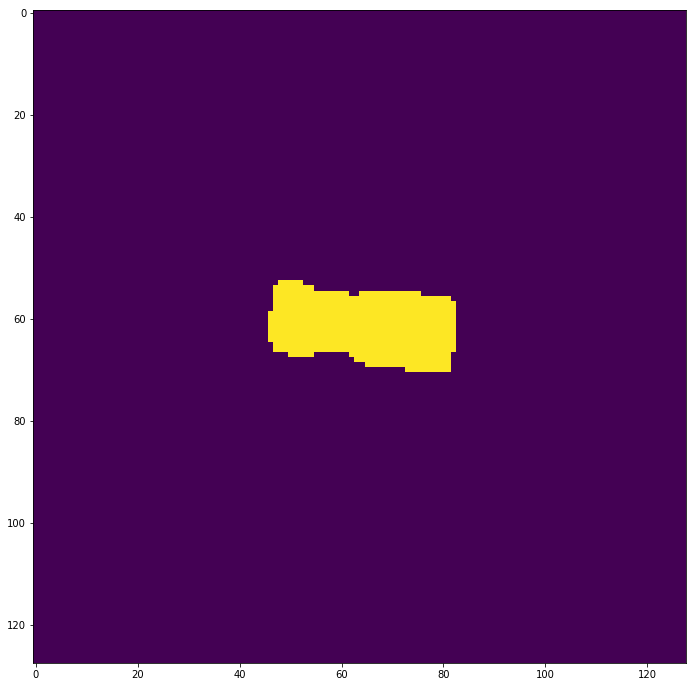

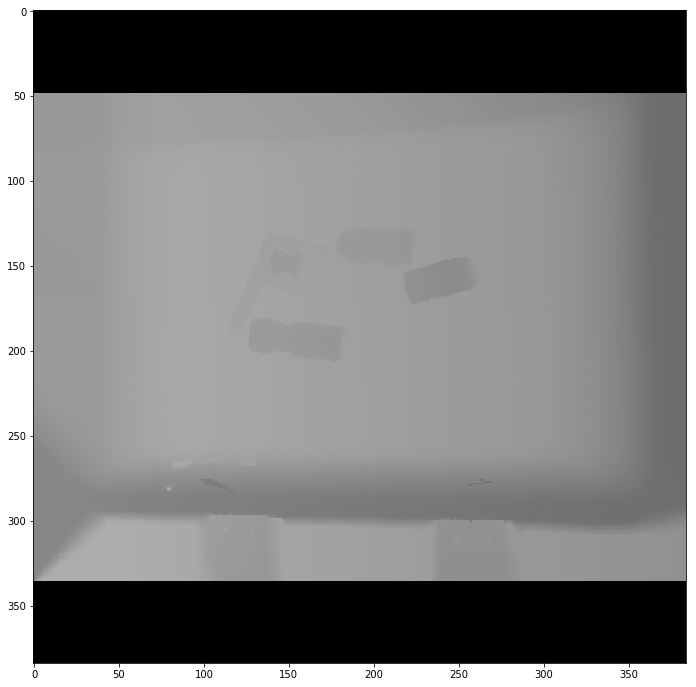

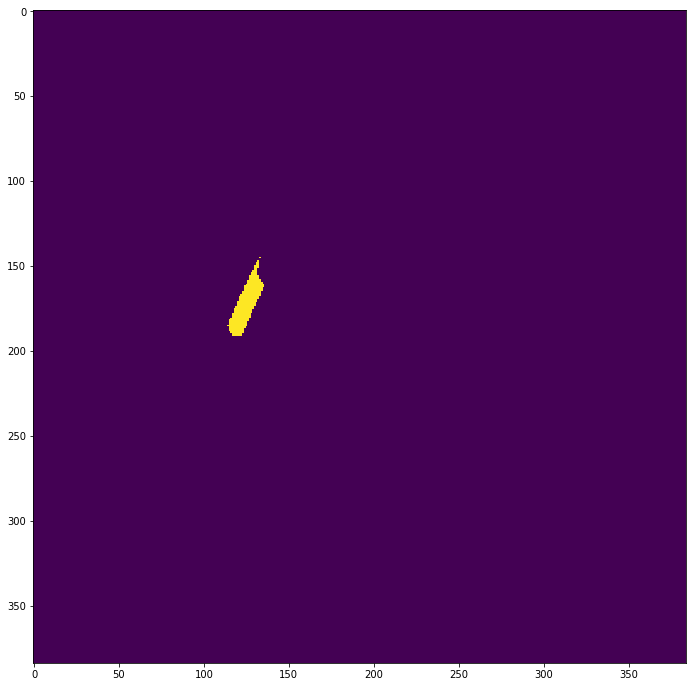

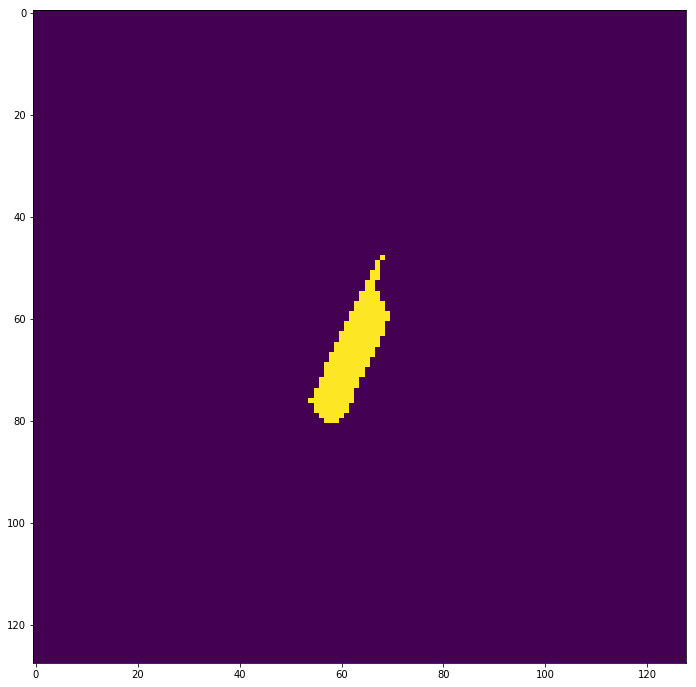

 57%|█████▋    | 17/30 [00:54<00:42,  3.24s/it]

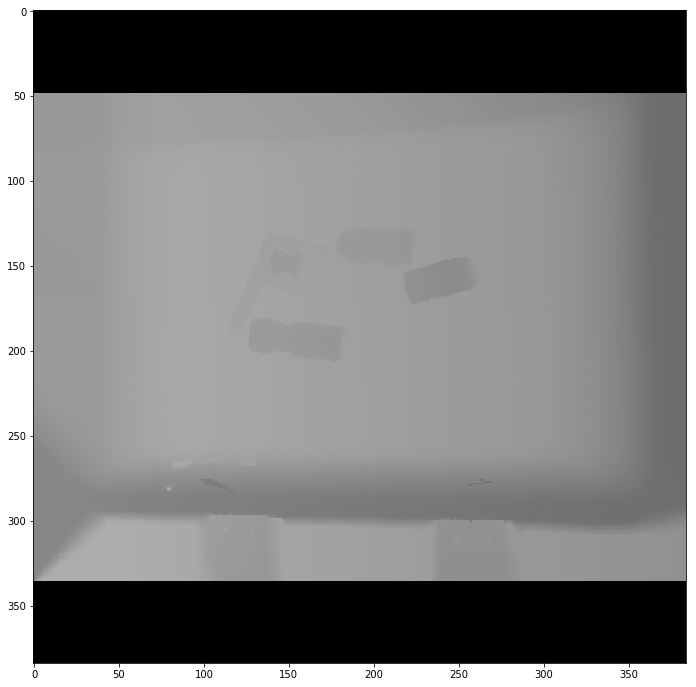

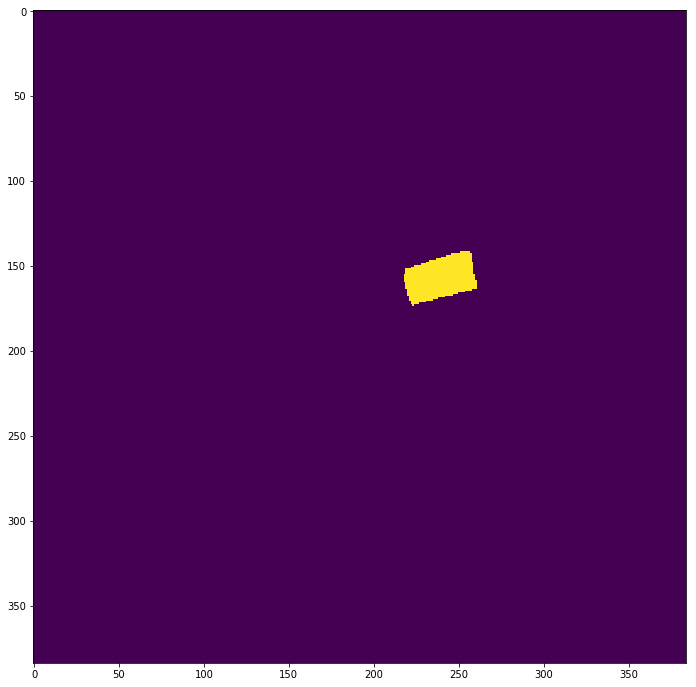

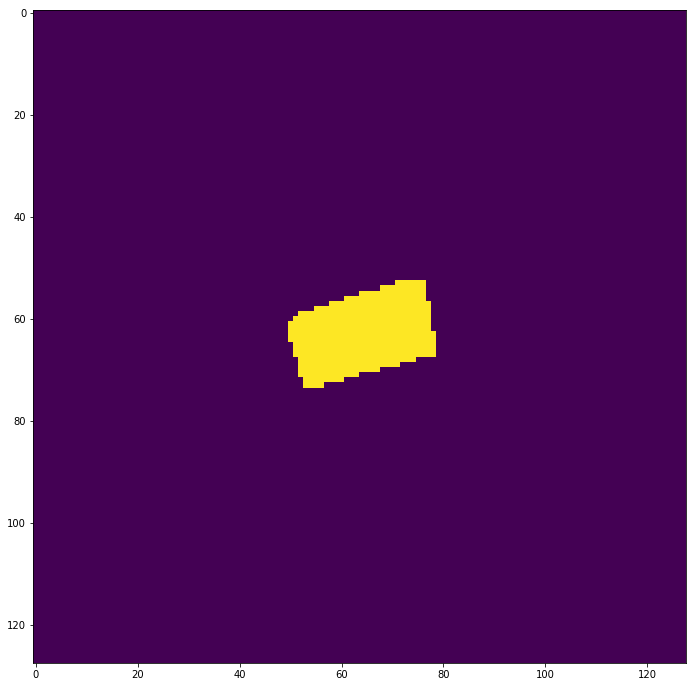

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000017

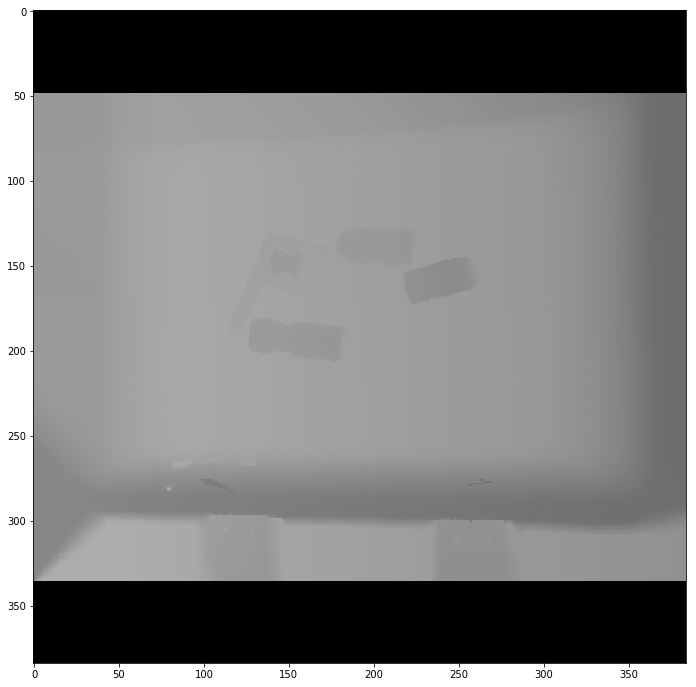

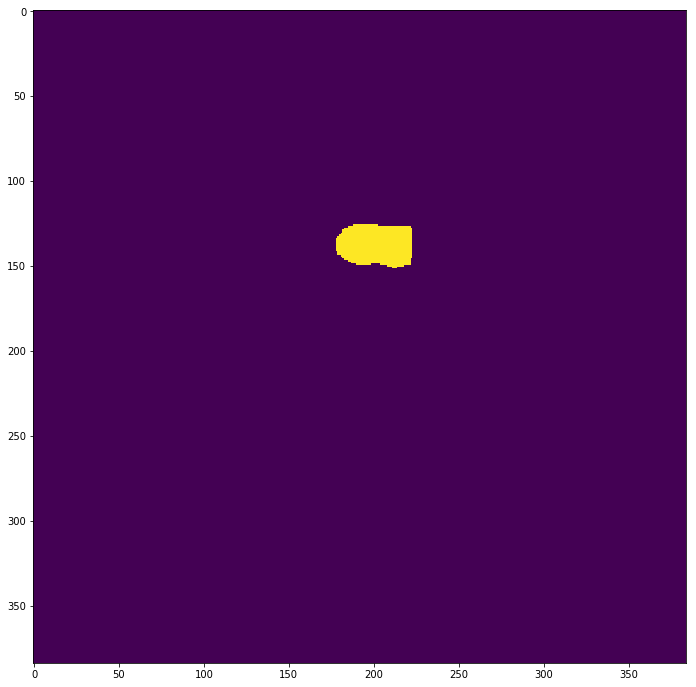

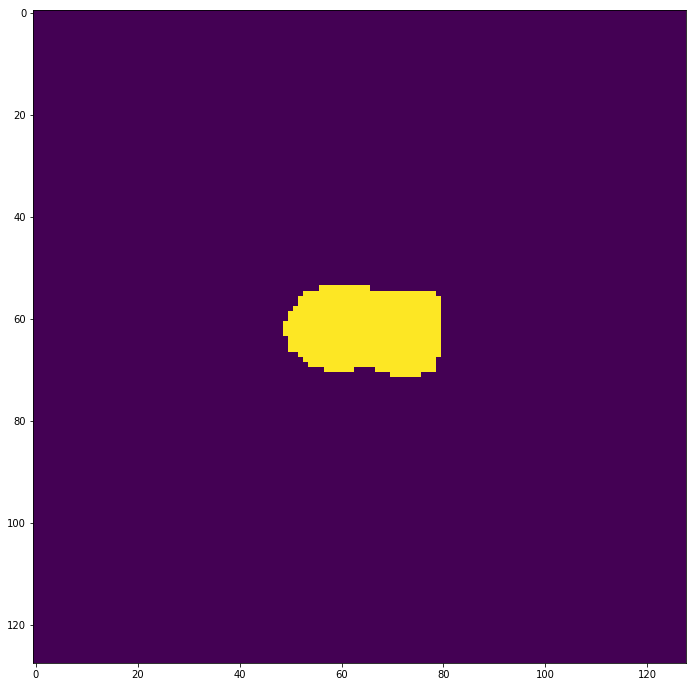

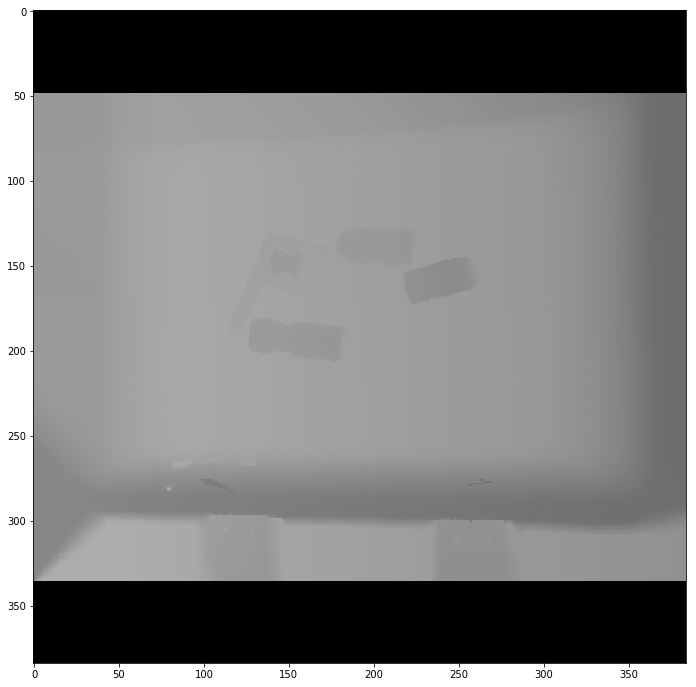

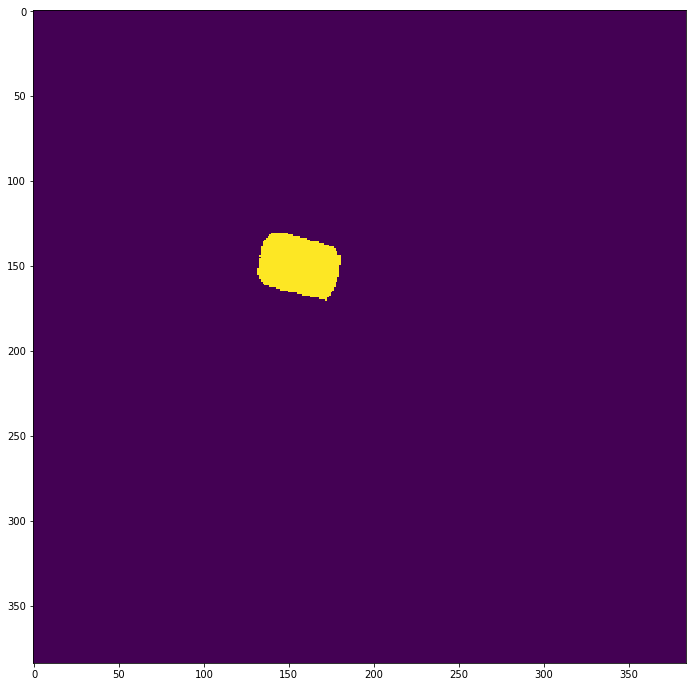

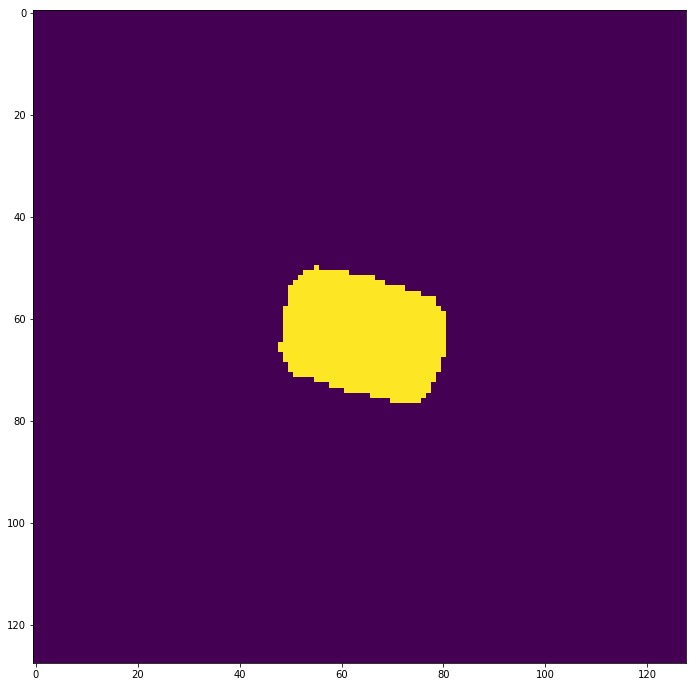

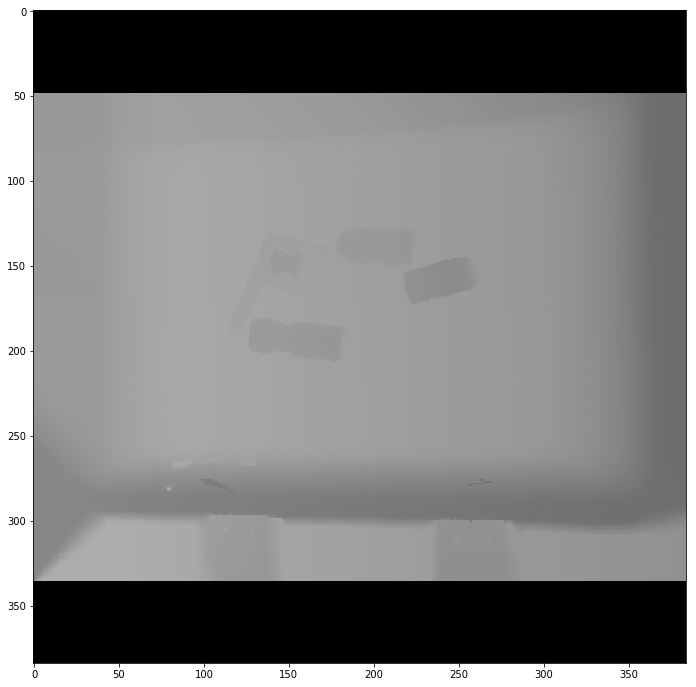

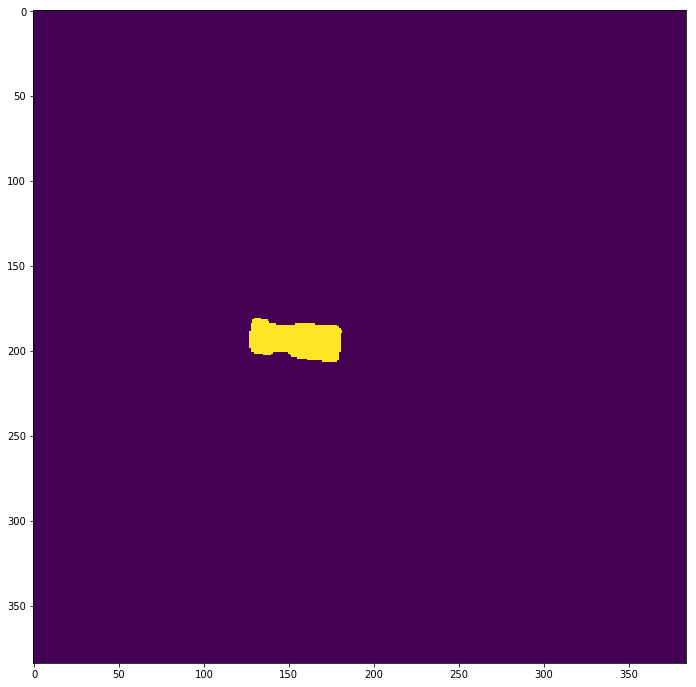

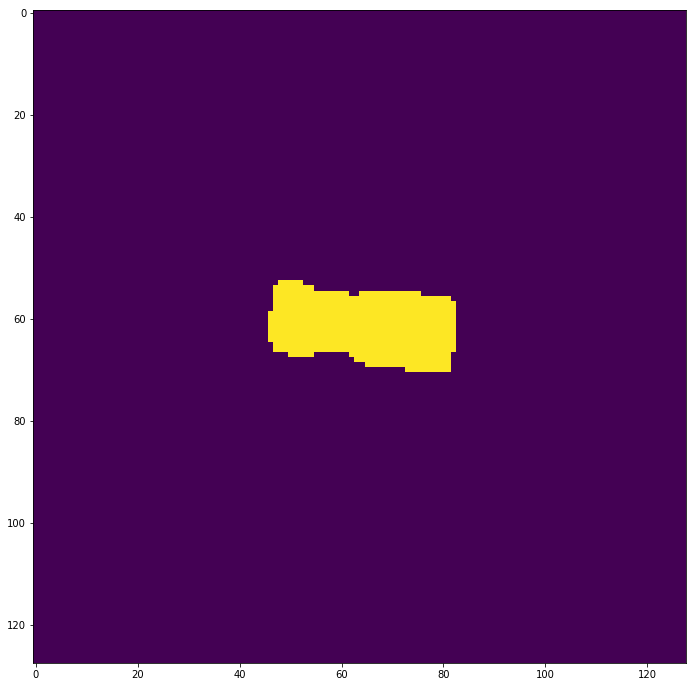

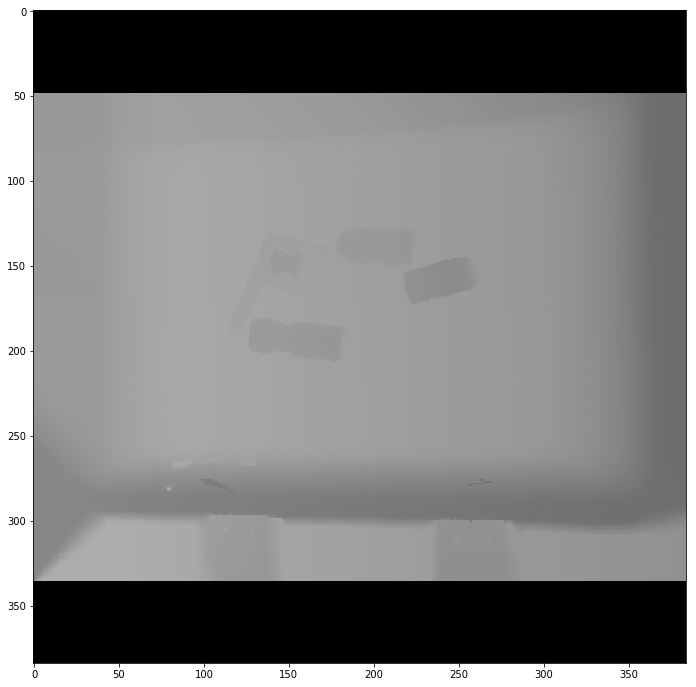

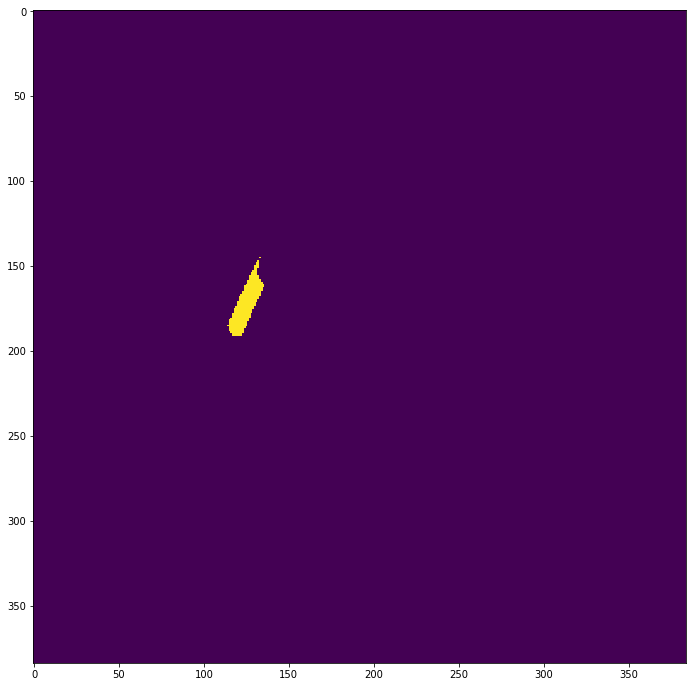

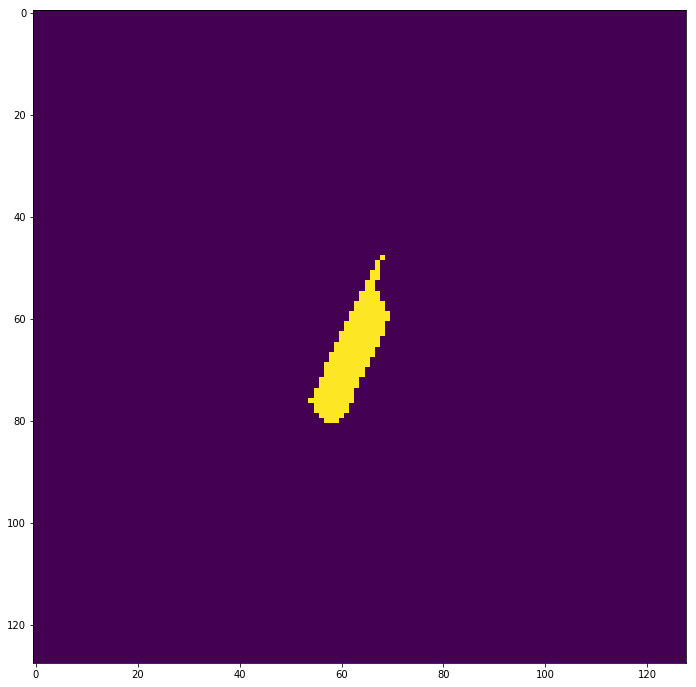

 60%|██████    | 18/30 [00:57<00:38,  3.21s/it]

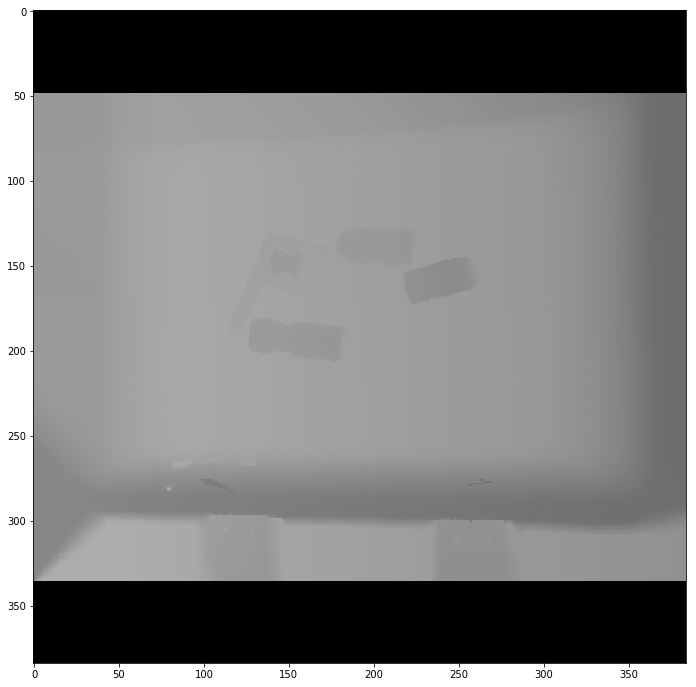

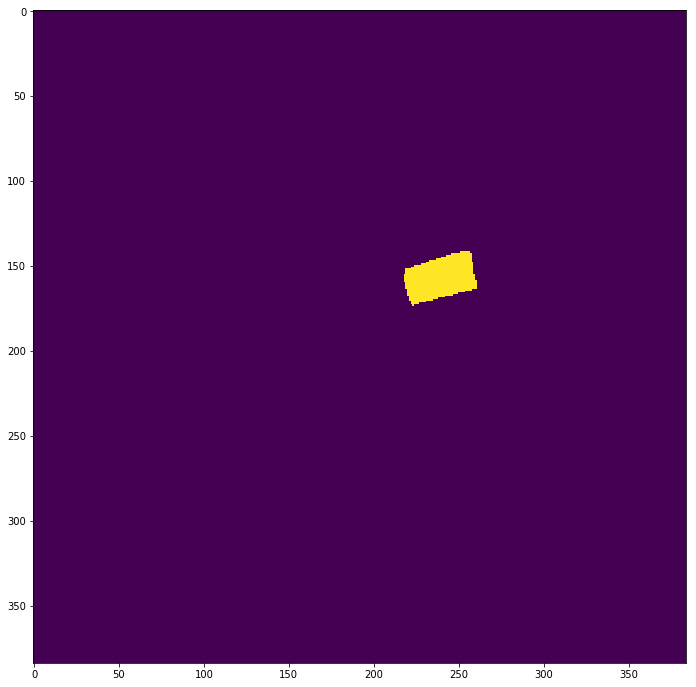

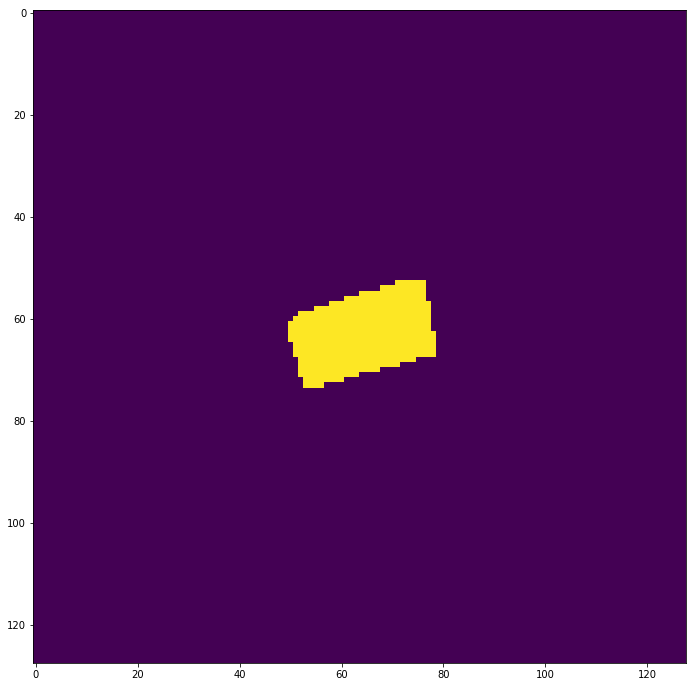

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000018

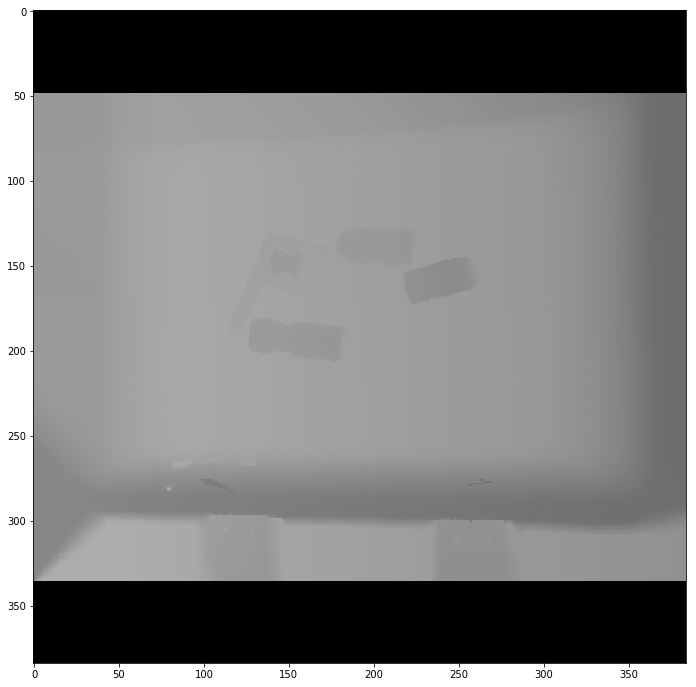

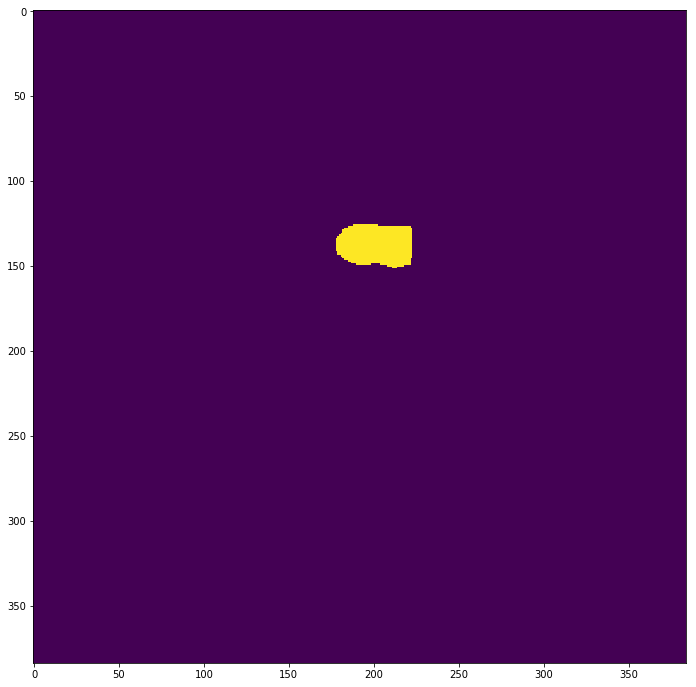

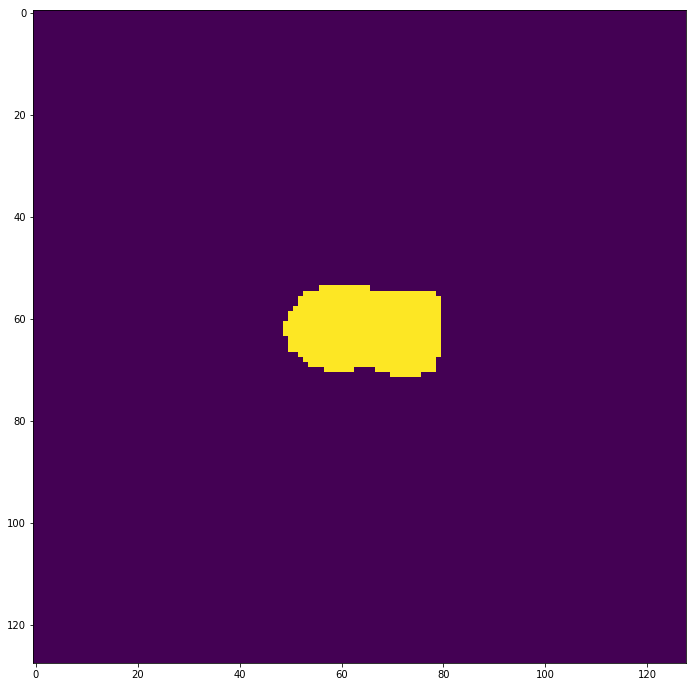

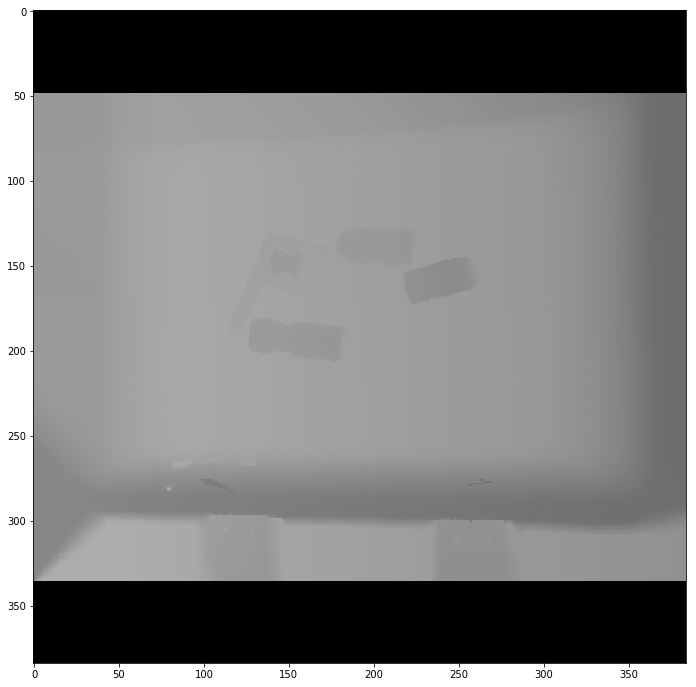

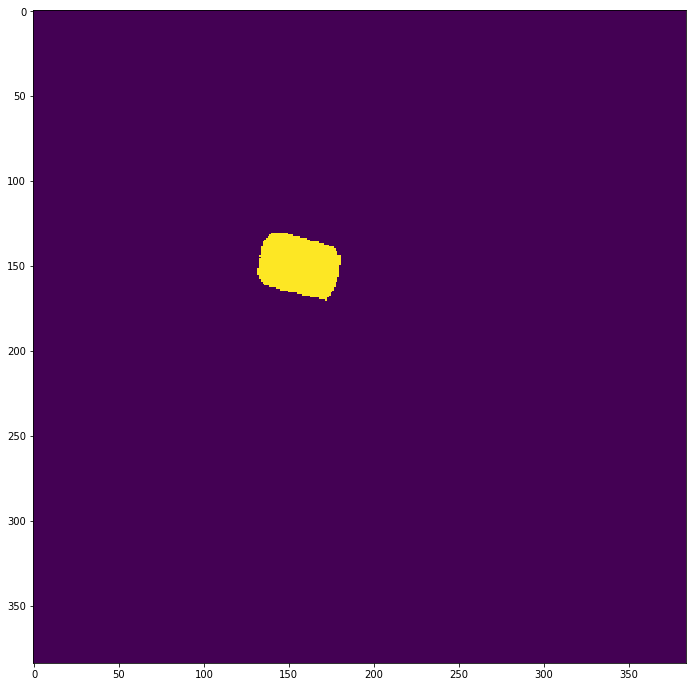

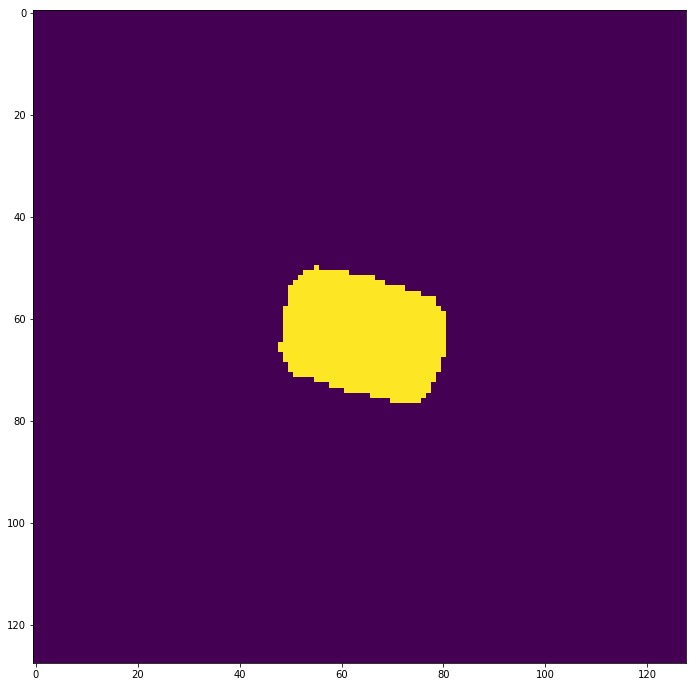

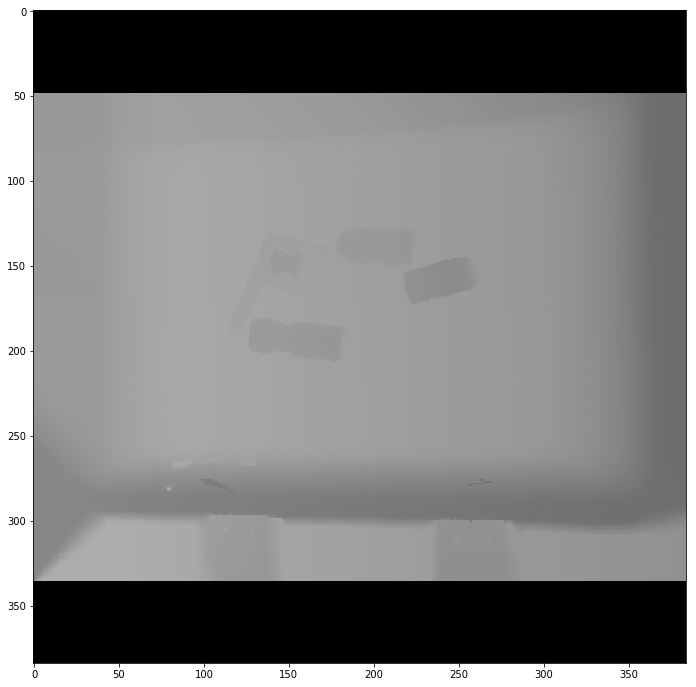

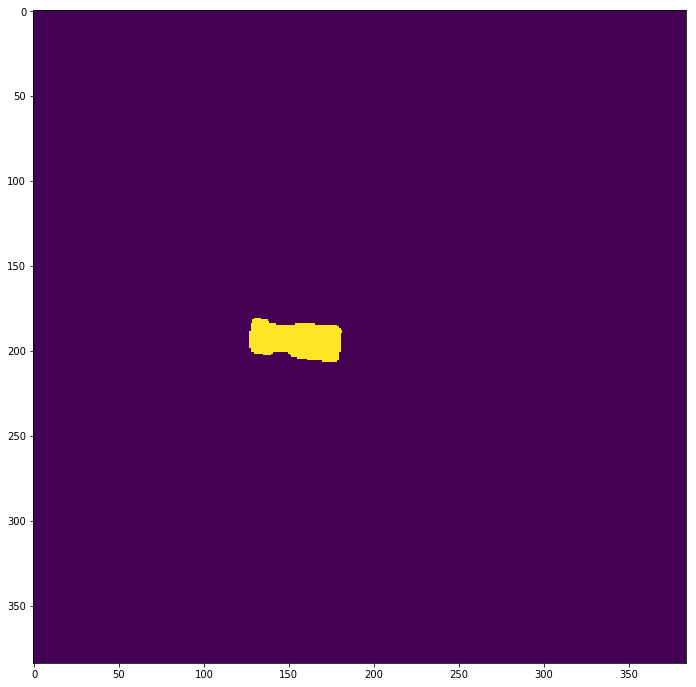

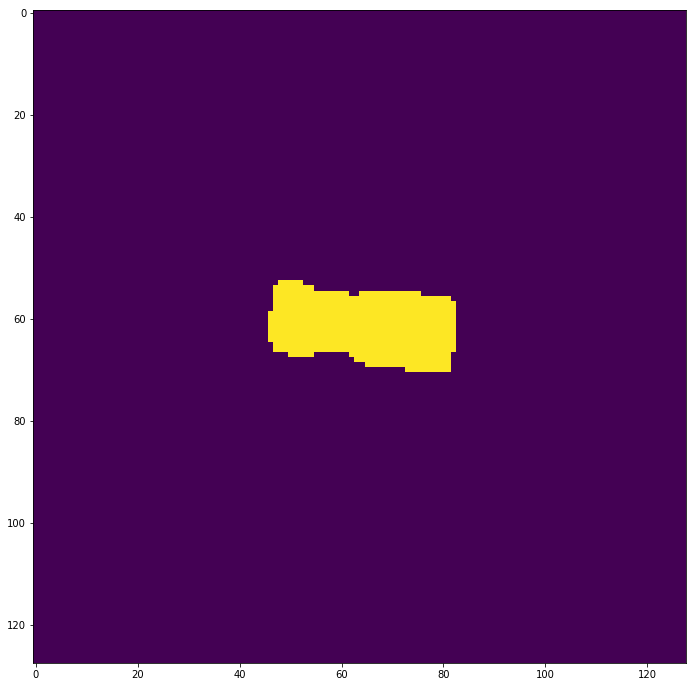

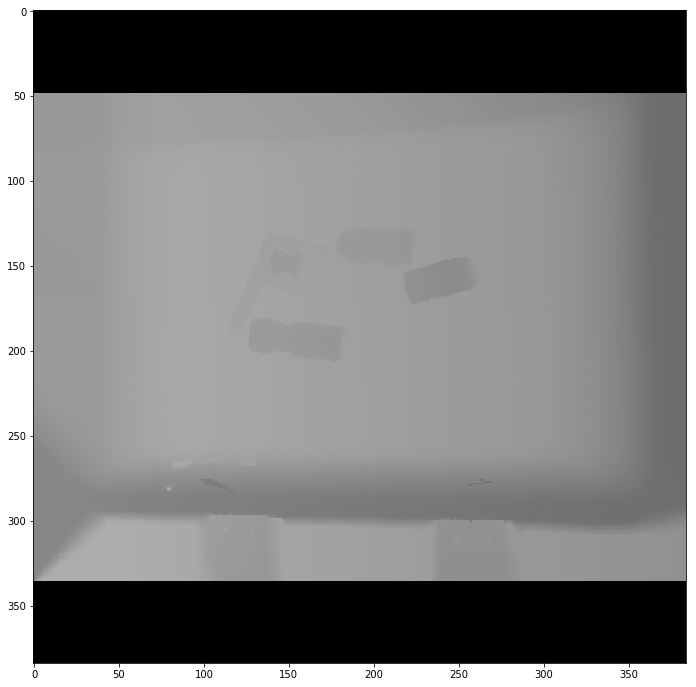

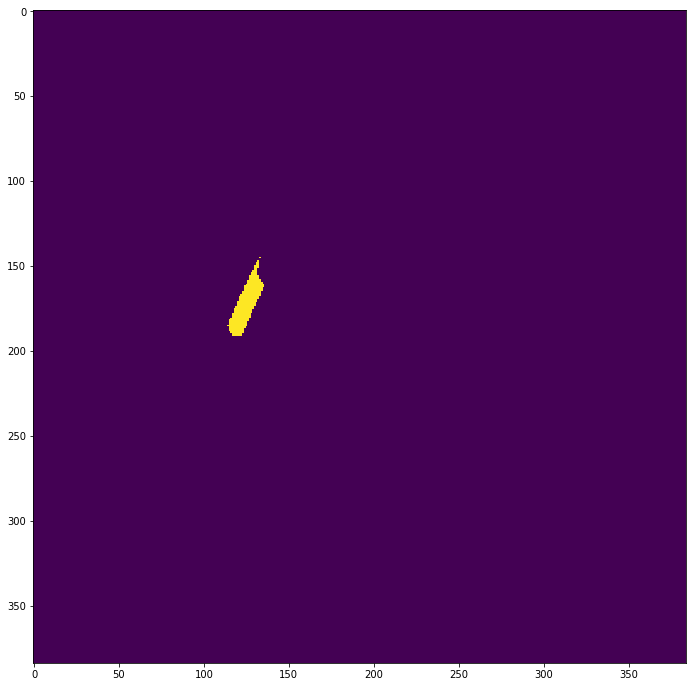

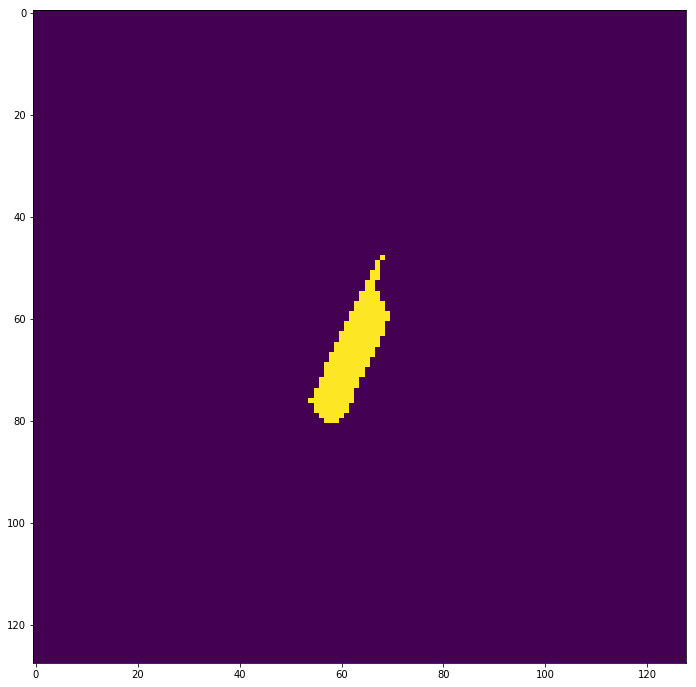

 63%|██████▎   | 19/30 [01:00<00:35,  3.22s/it]

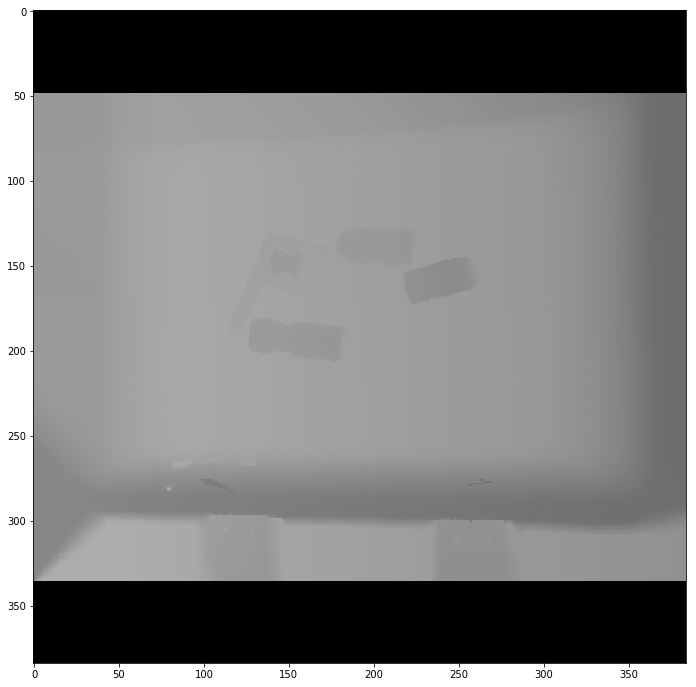

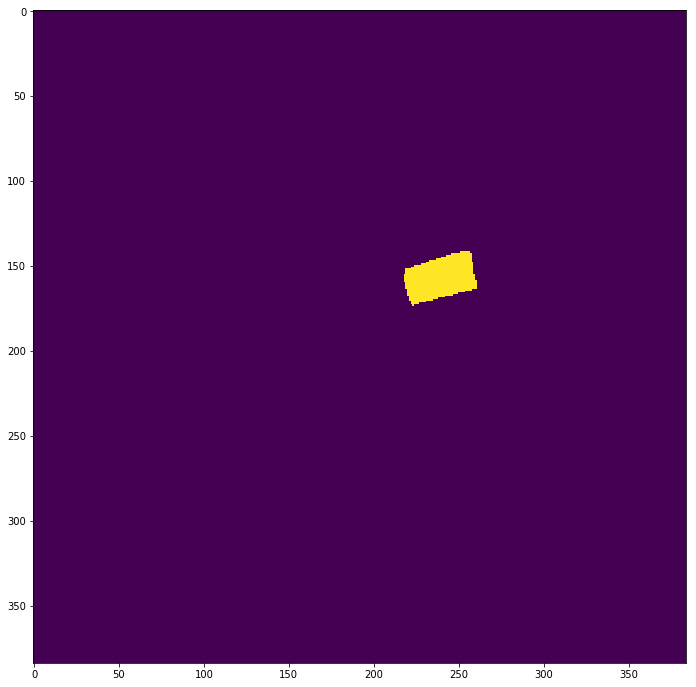

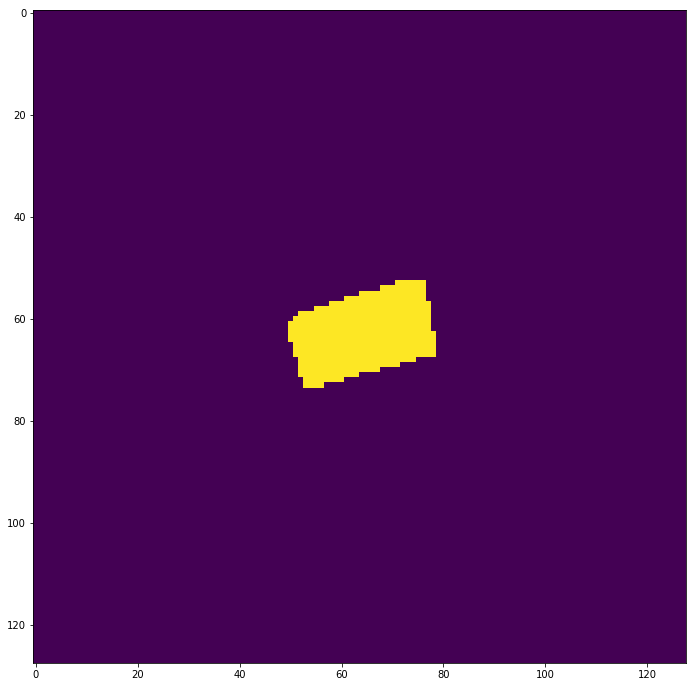

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000019

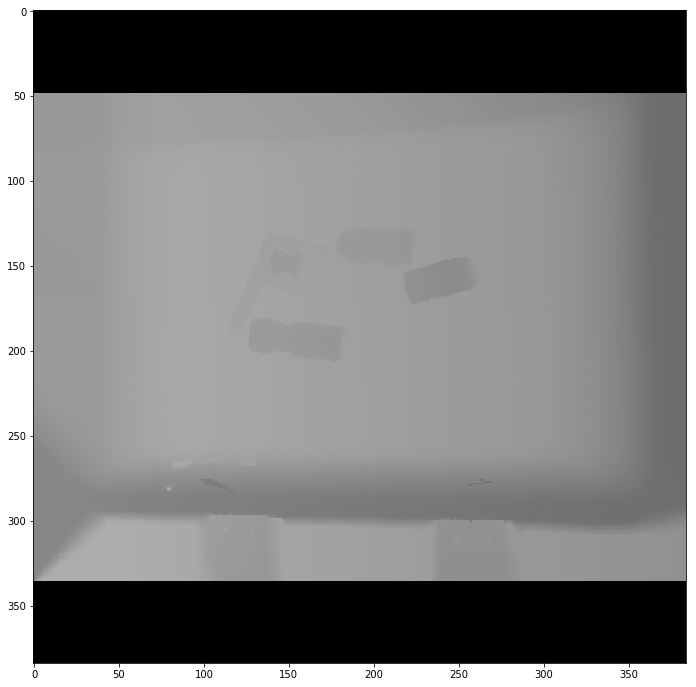

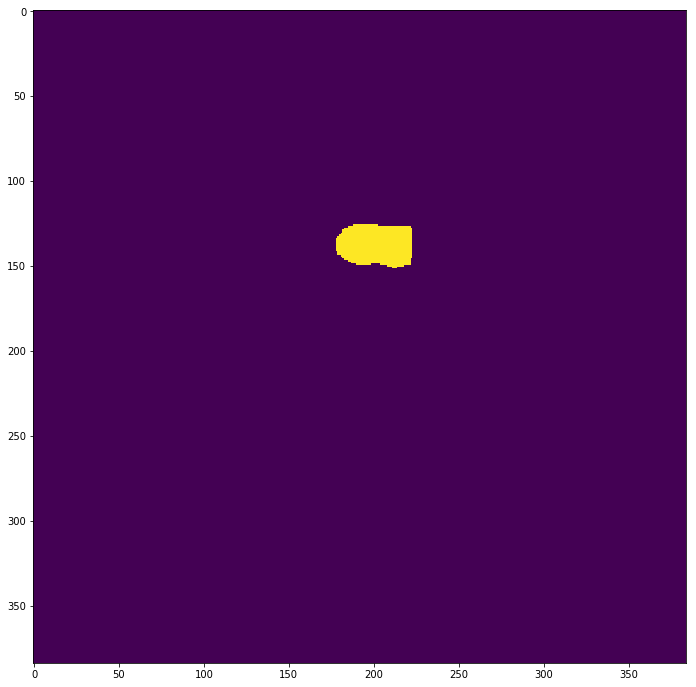

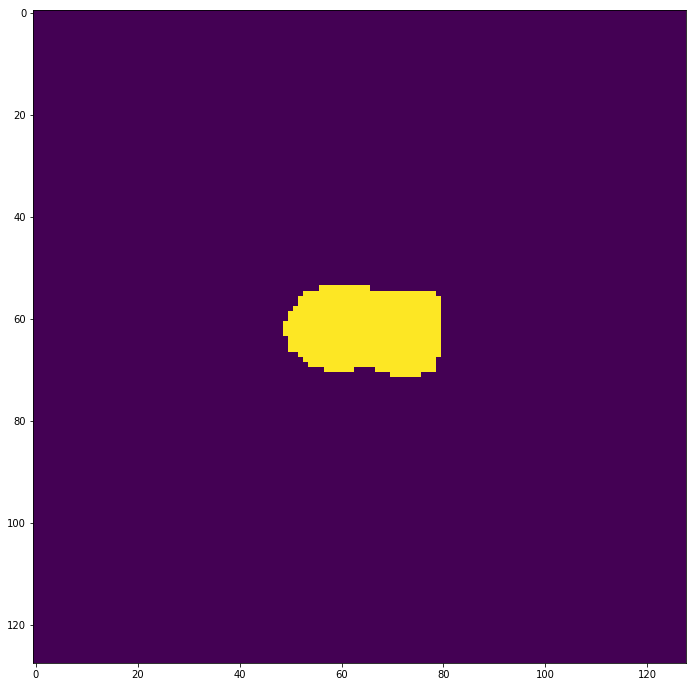

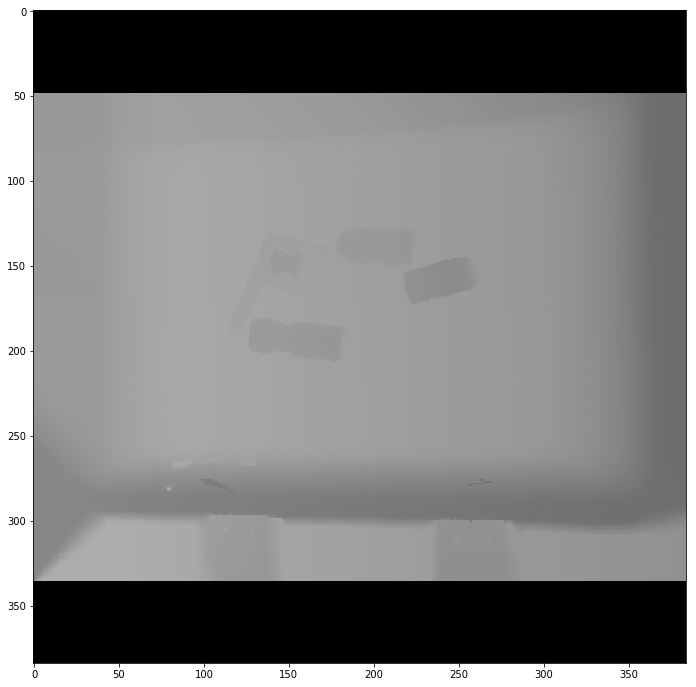

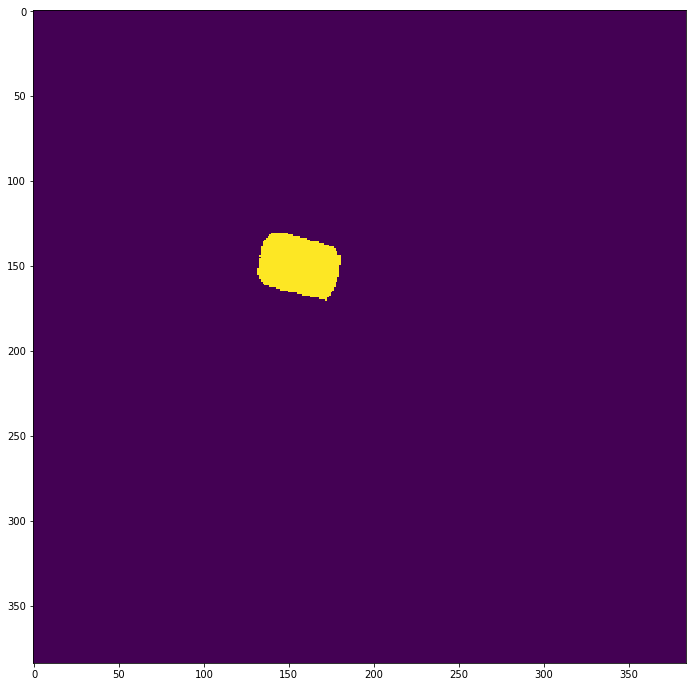

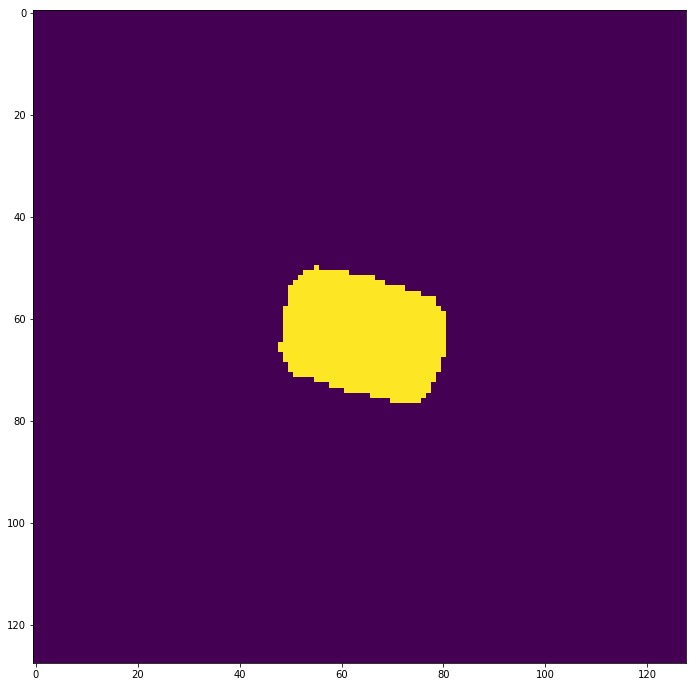

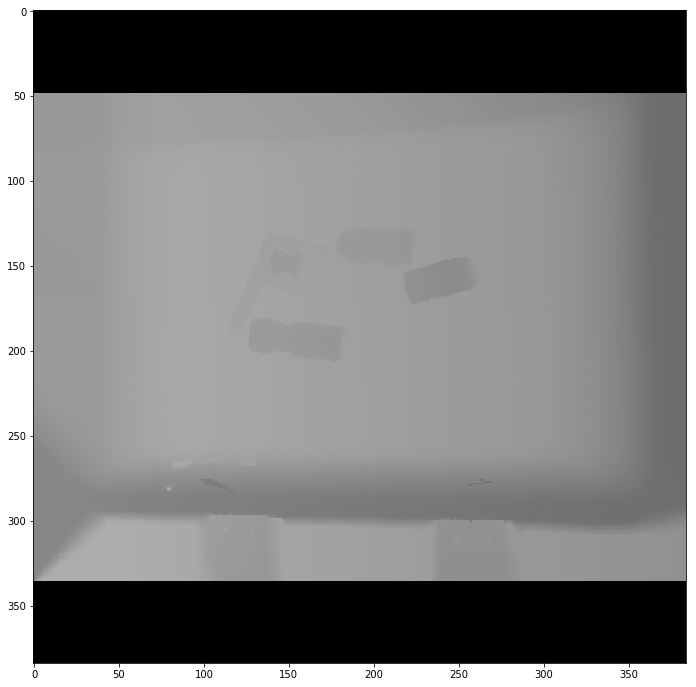

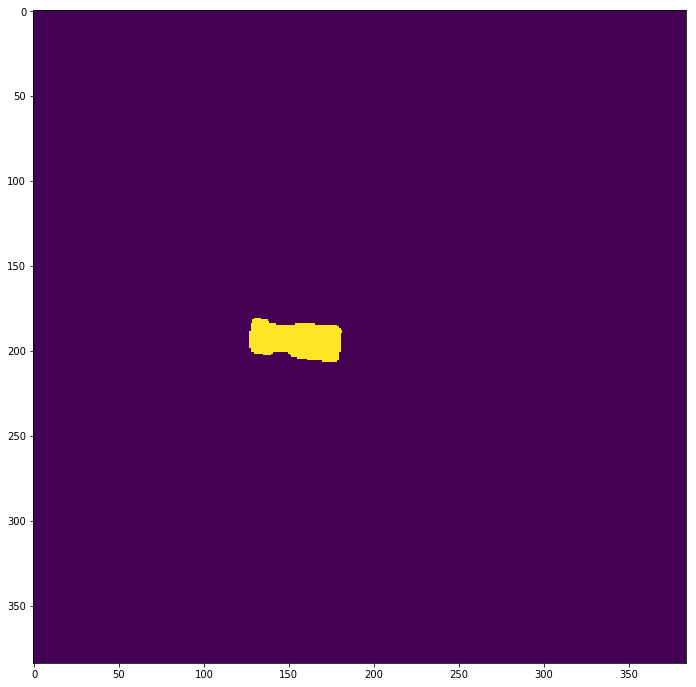

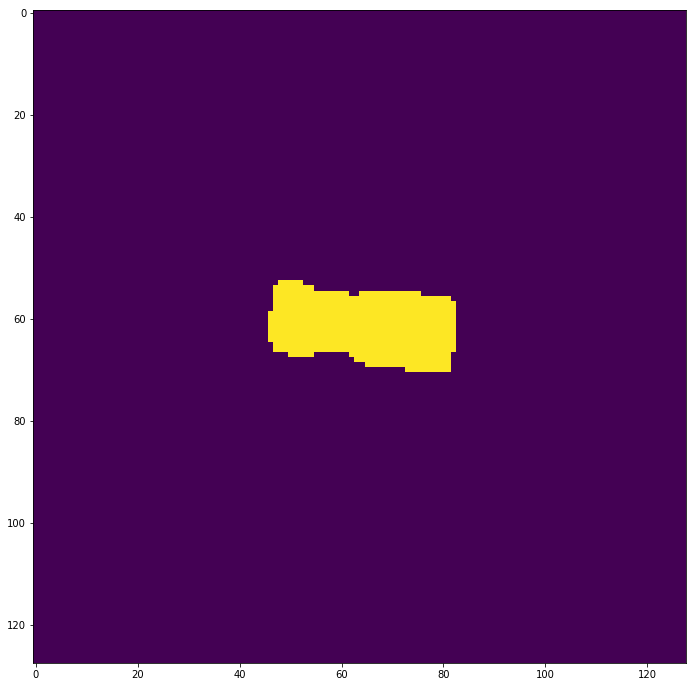

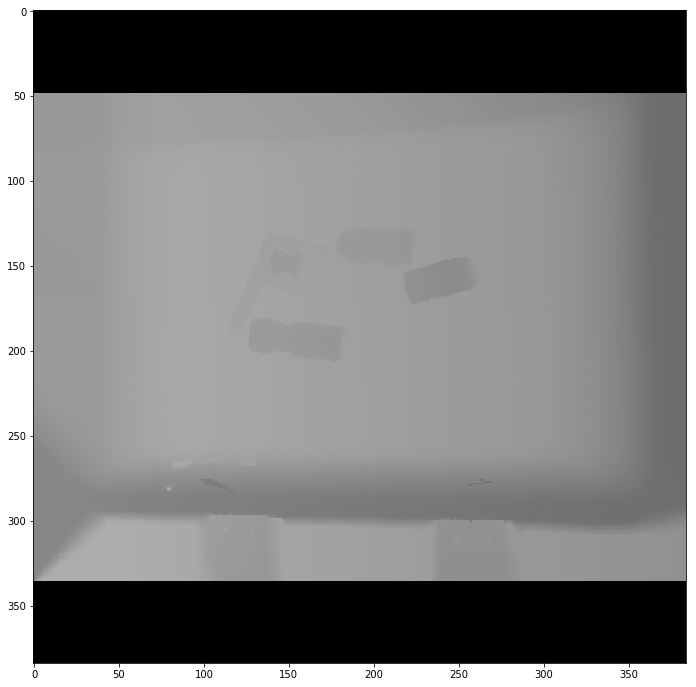

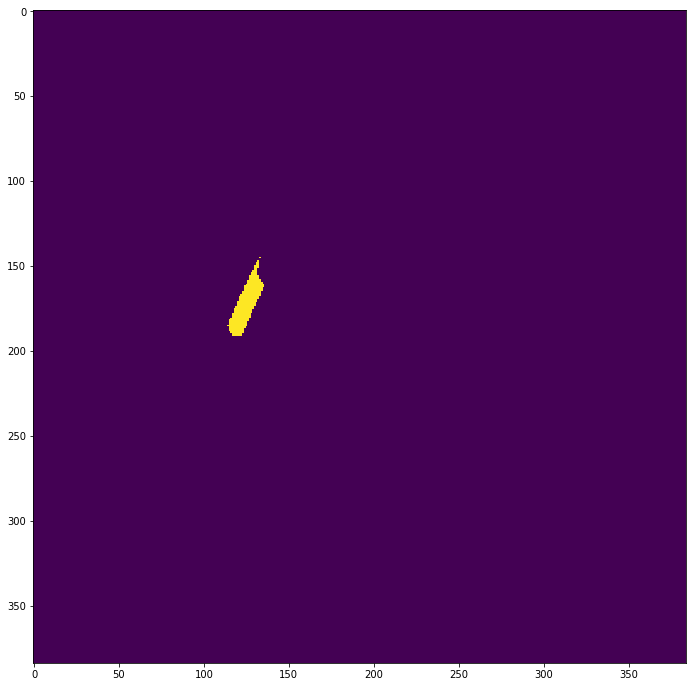

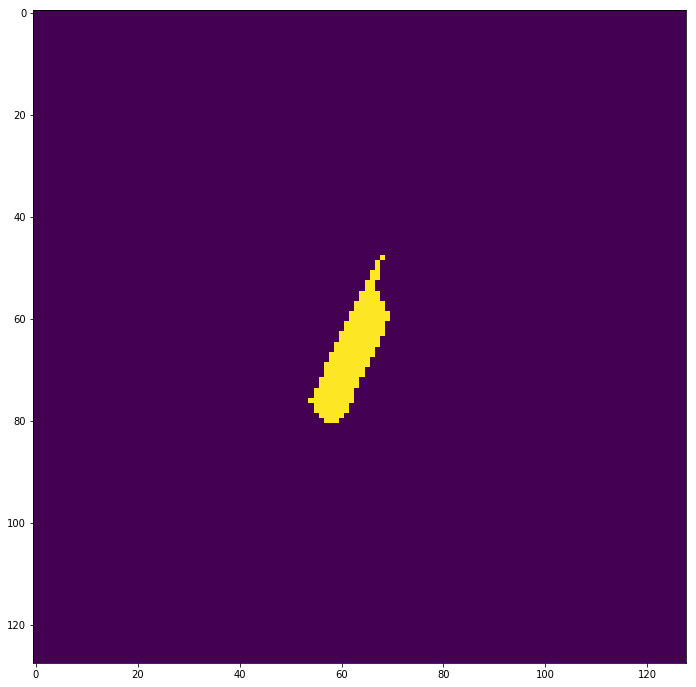

 67%|██████▋   | 20/30 [01:03<00:32,  3.23s/it]

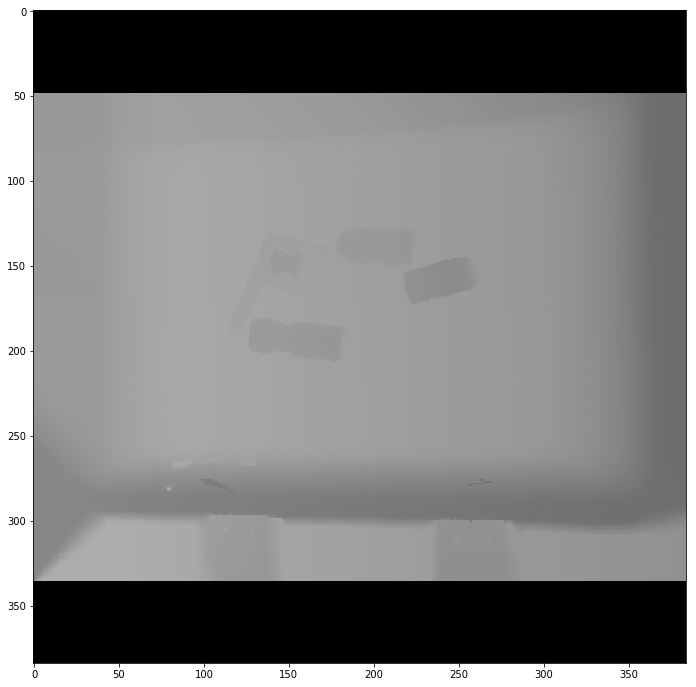

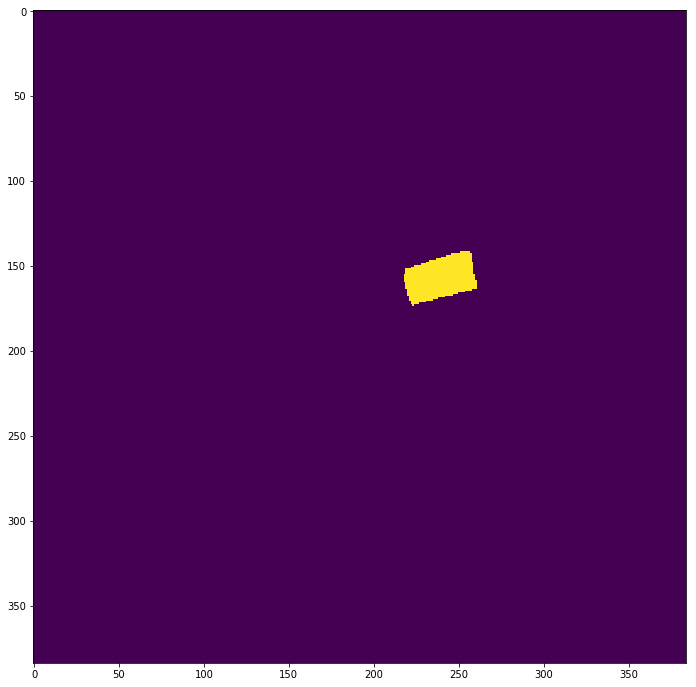

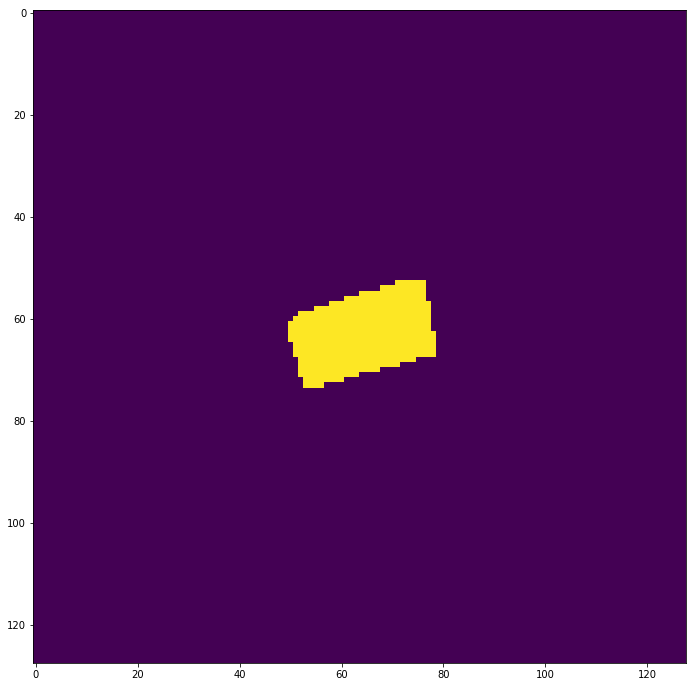

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000020.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000020.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000020.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000020

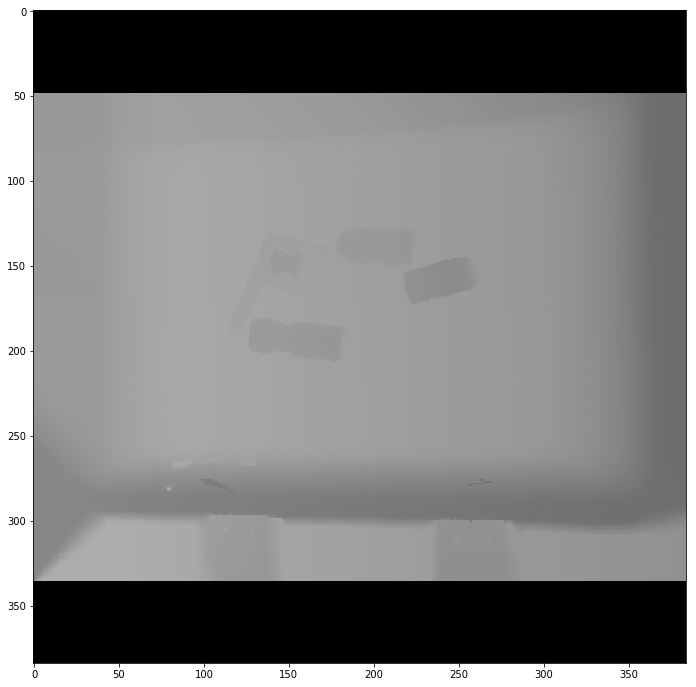

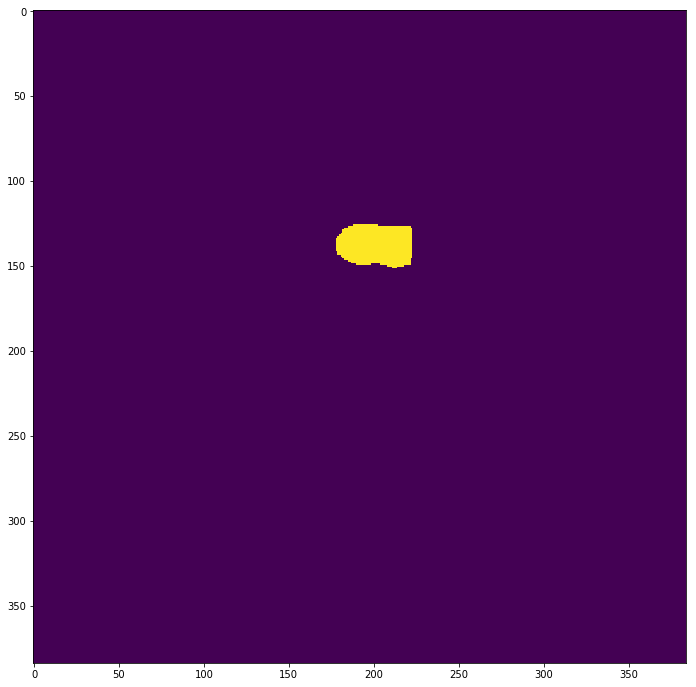

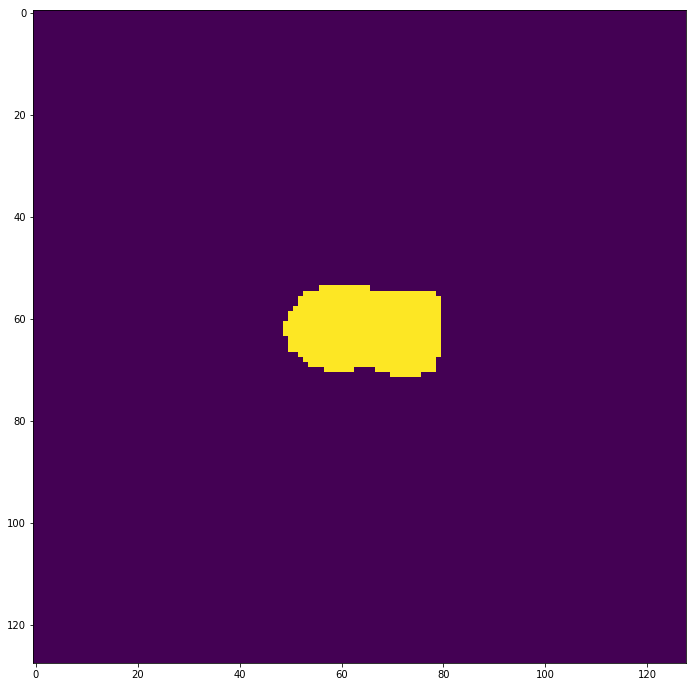

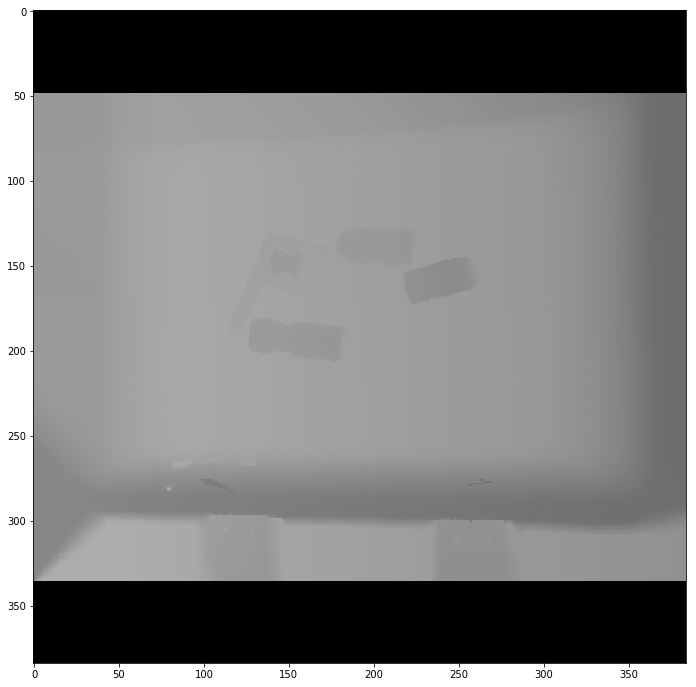

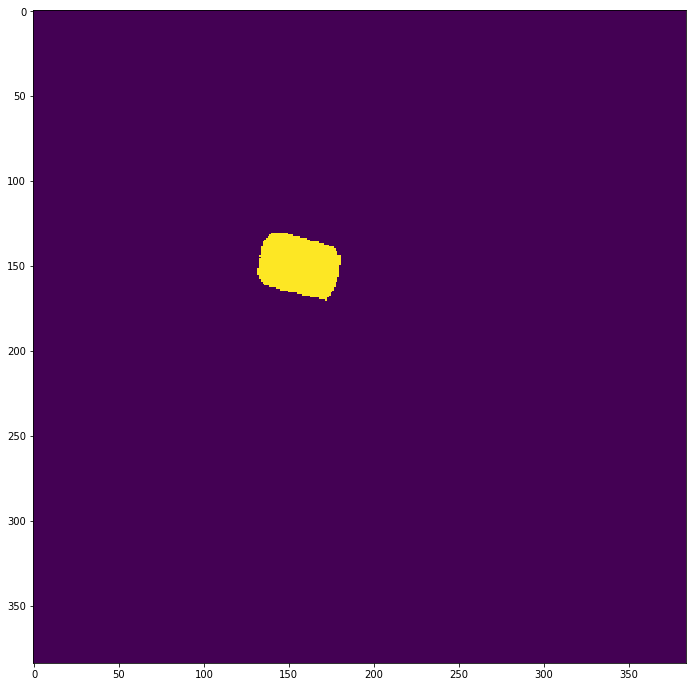

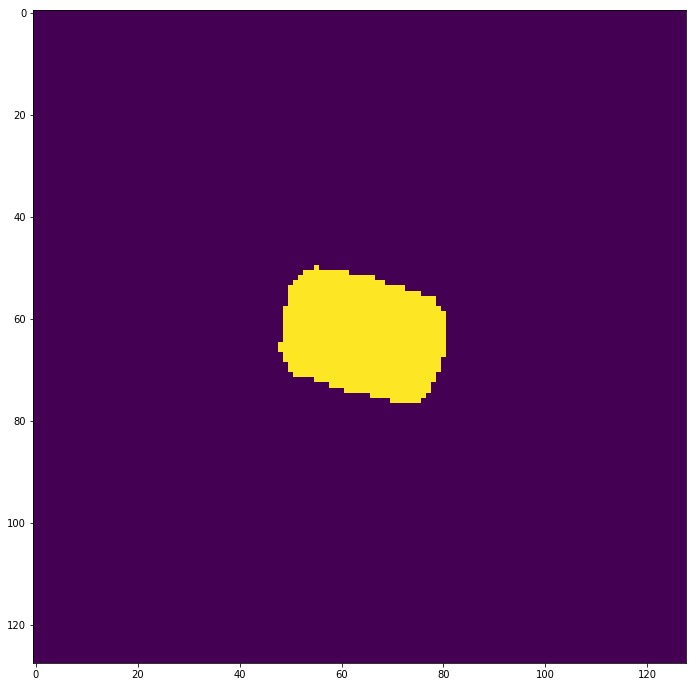

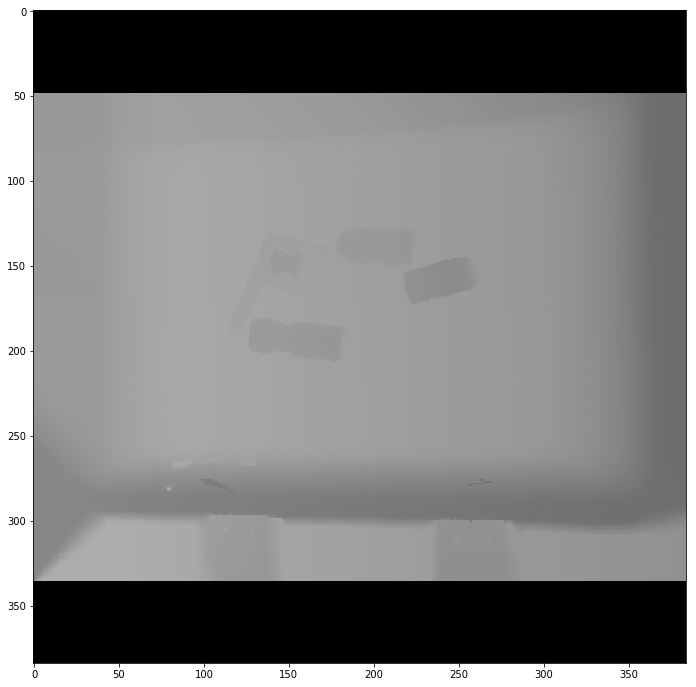

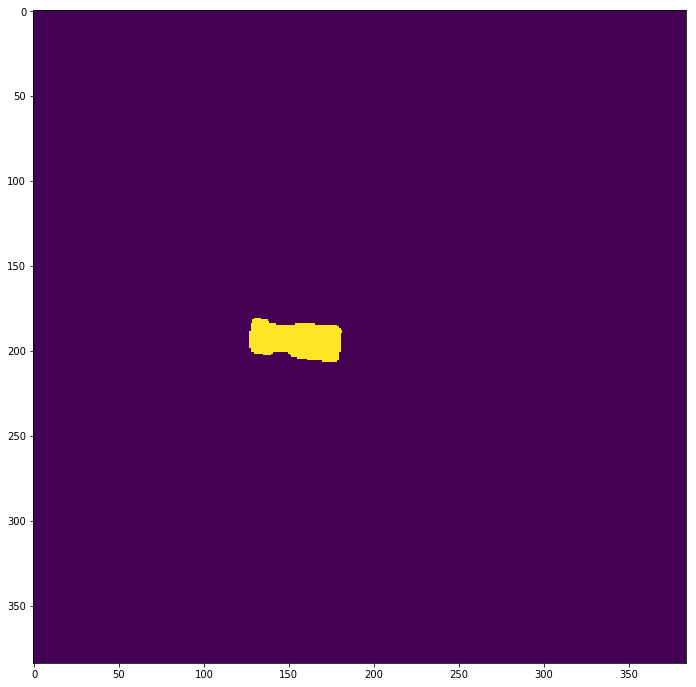

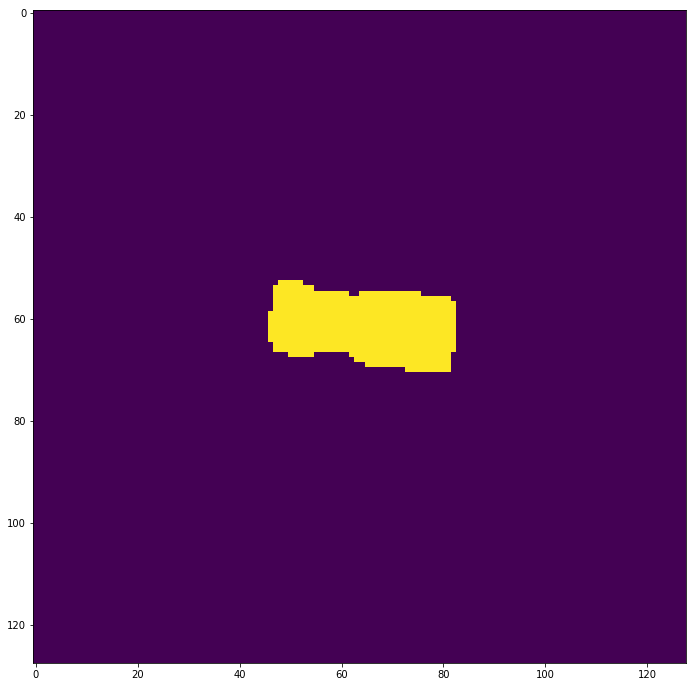

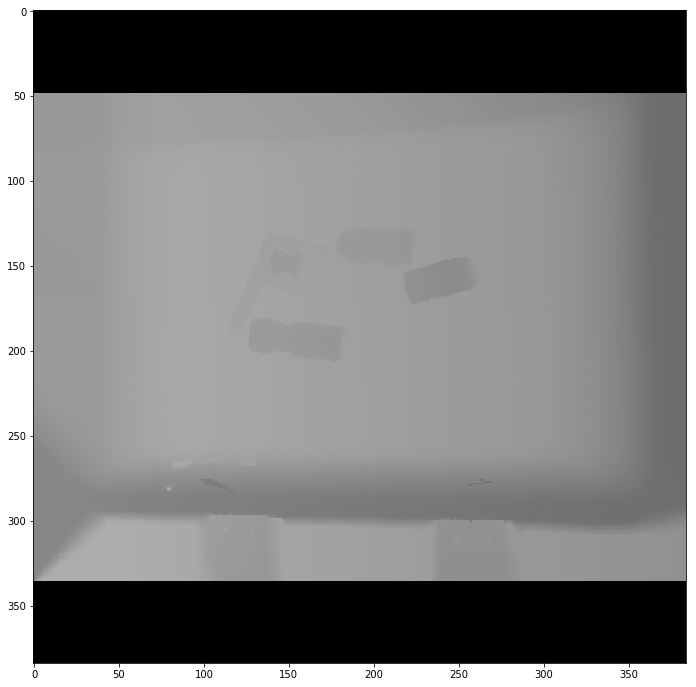

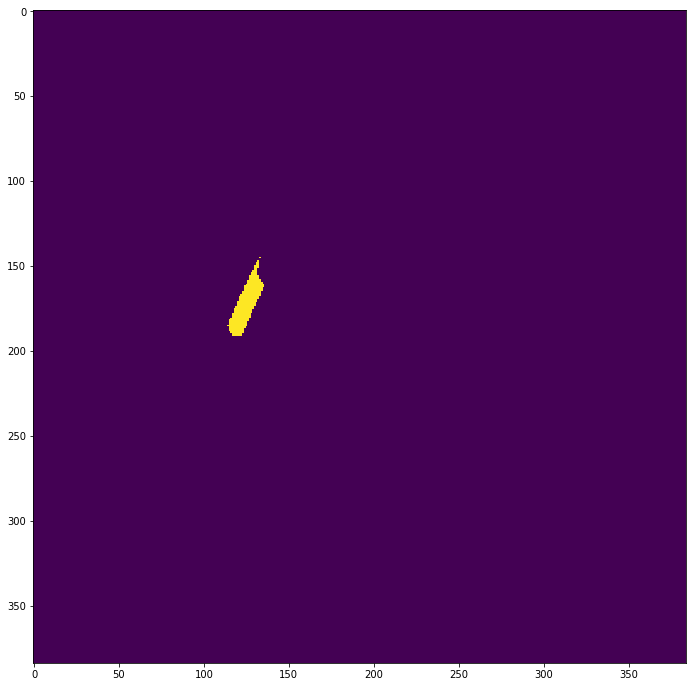

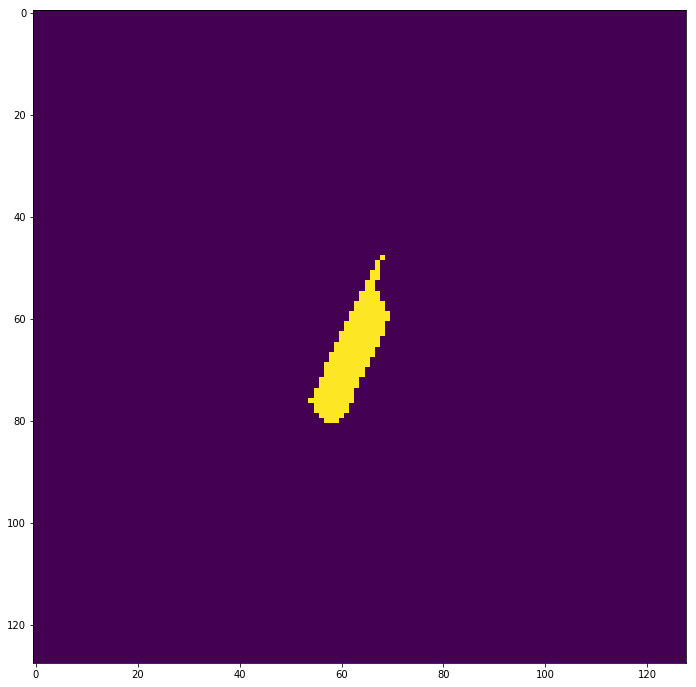

 70%|███████   | 21/30 [01:07<00:28,  3.22s/it]

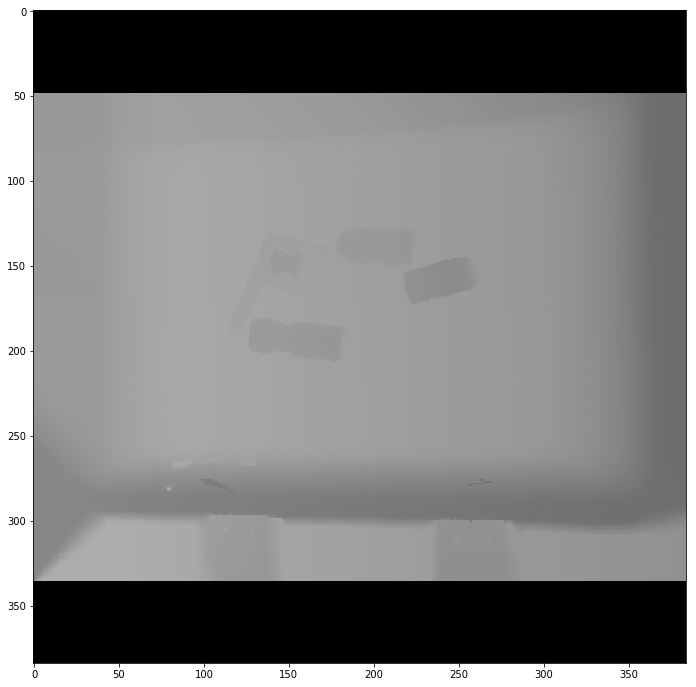

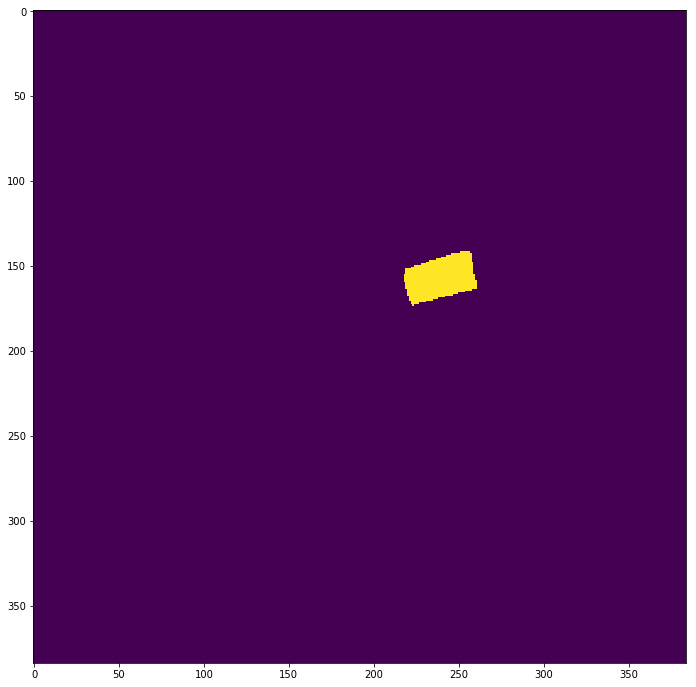

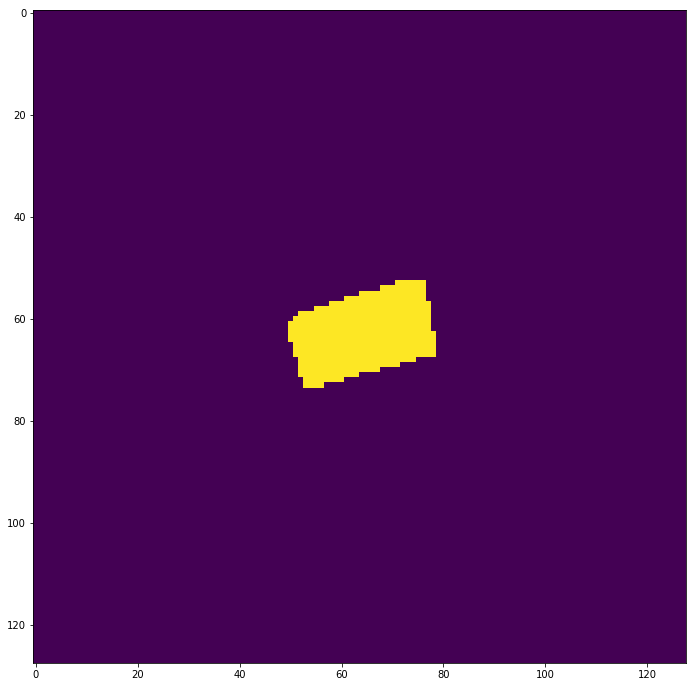

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000021.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000021

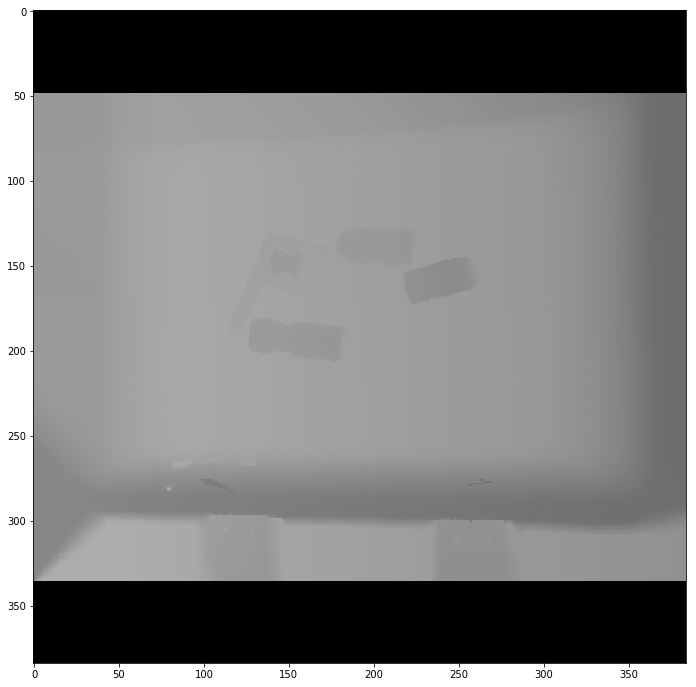

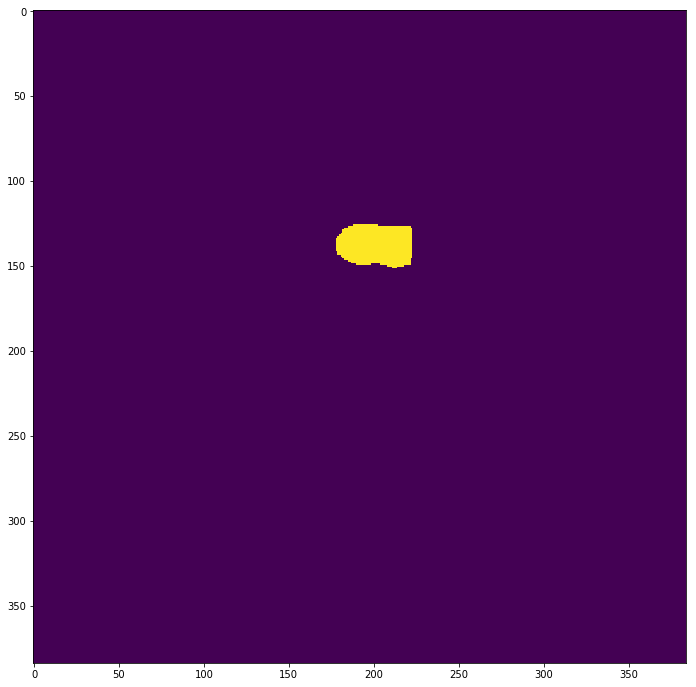

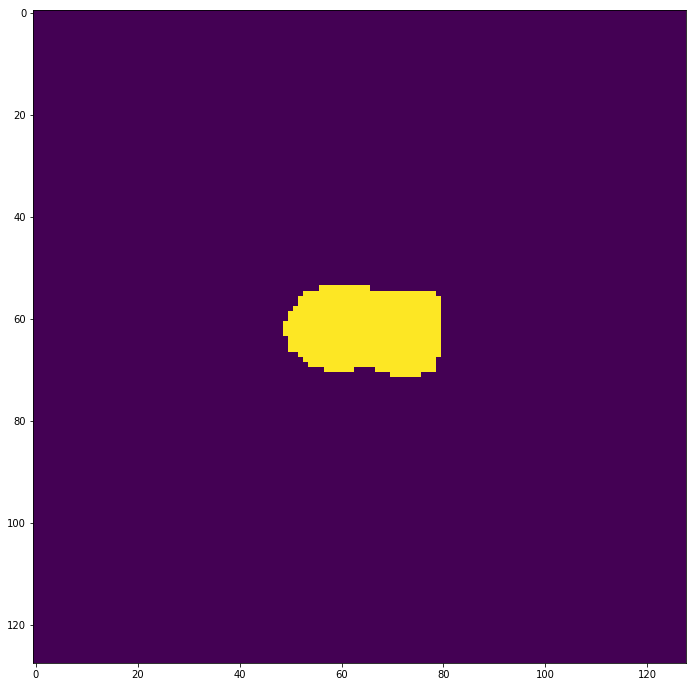

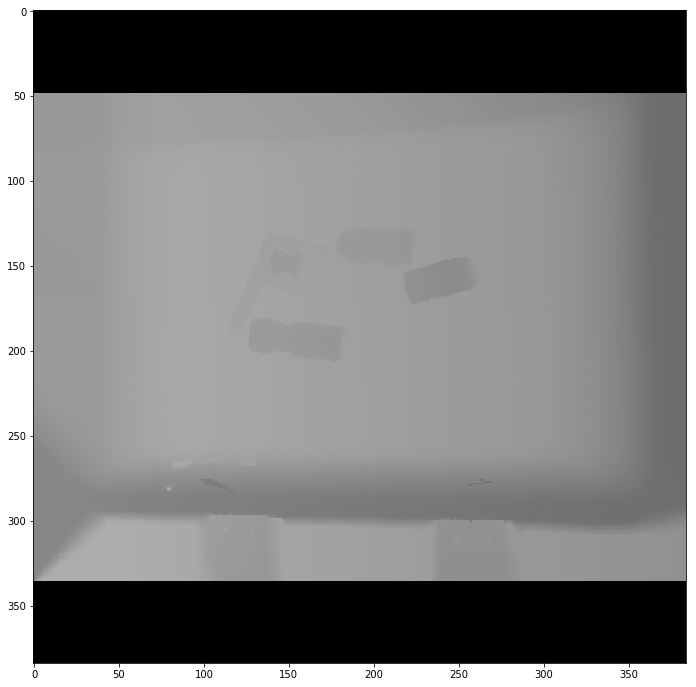

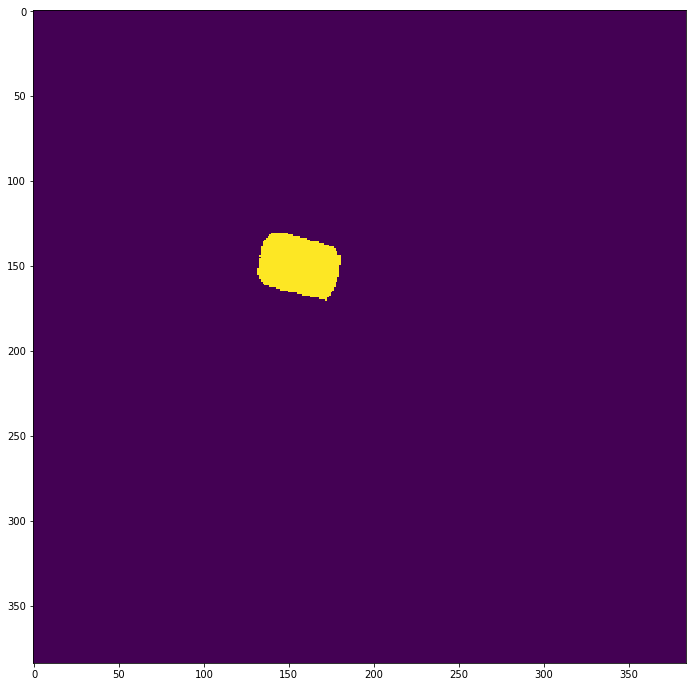

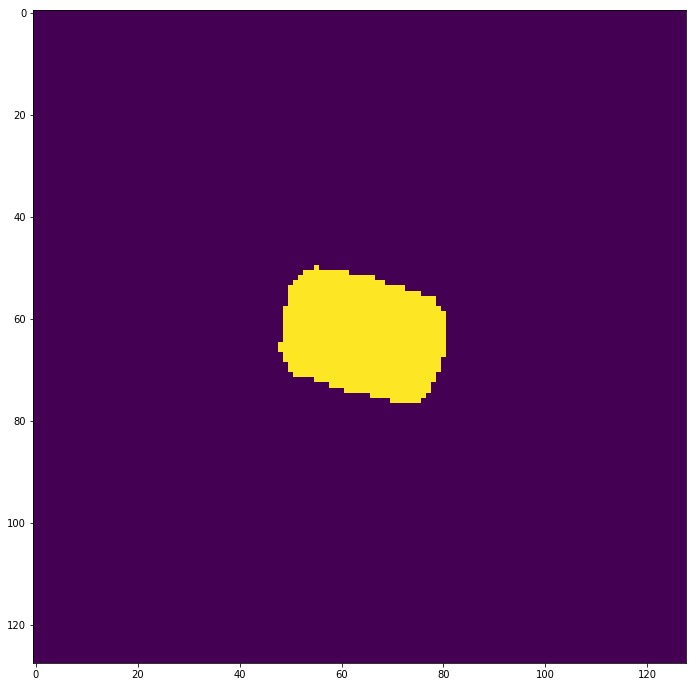

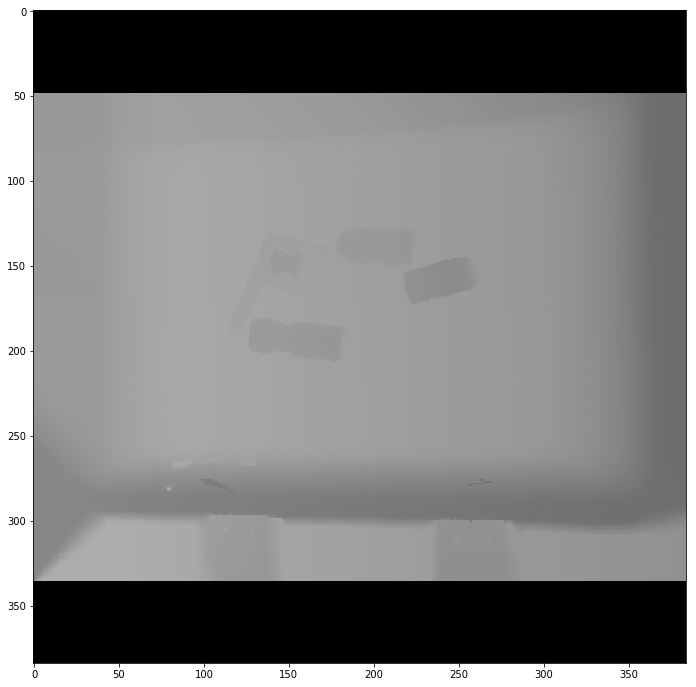

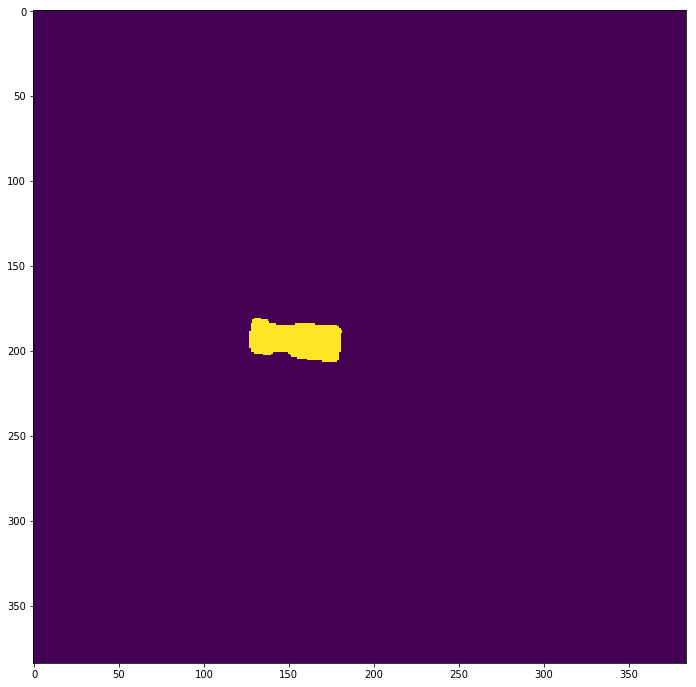

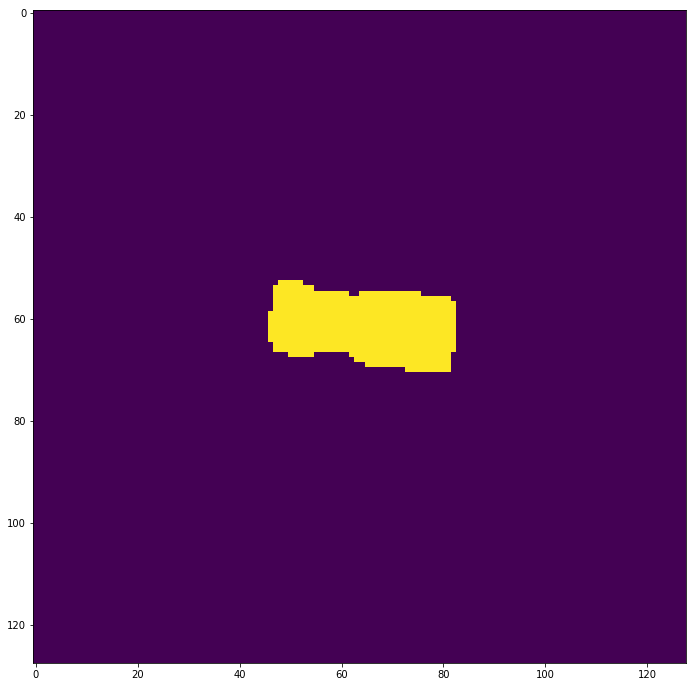

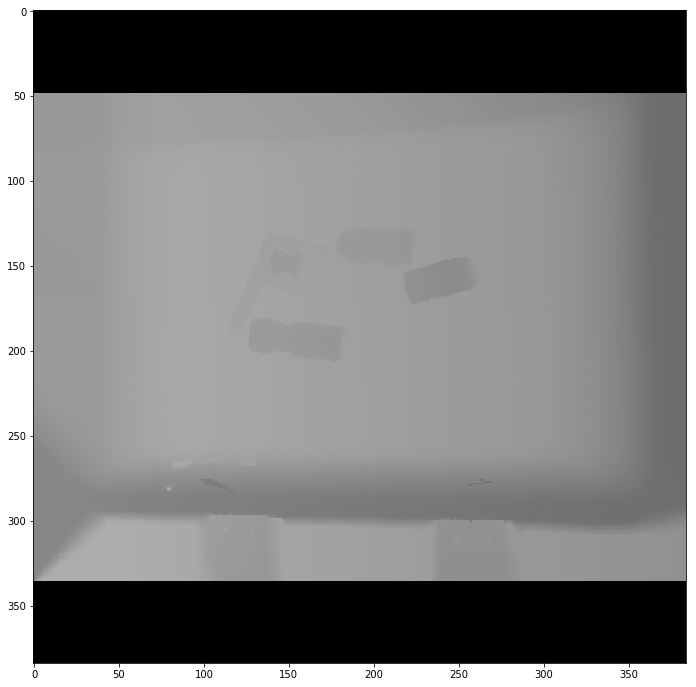

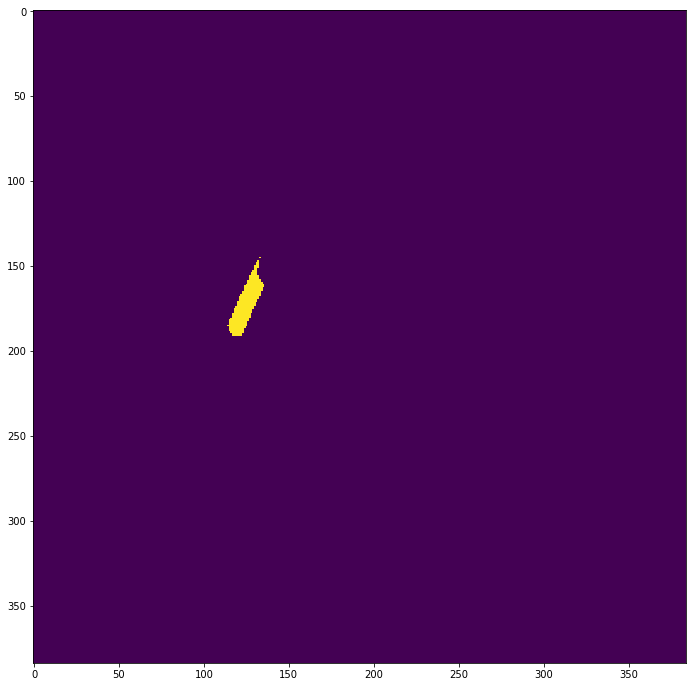

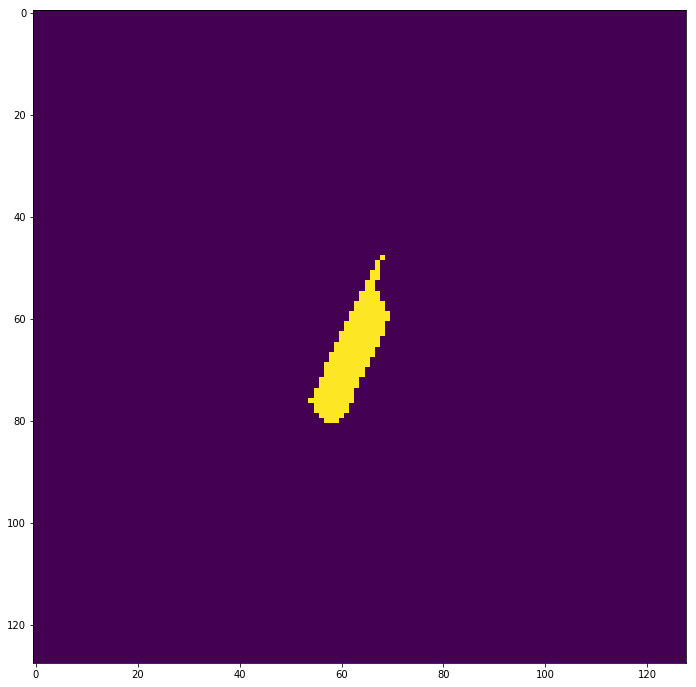

 73%|███████▎  | 22/30 [01:10<00:25,  3.18s/it]

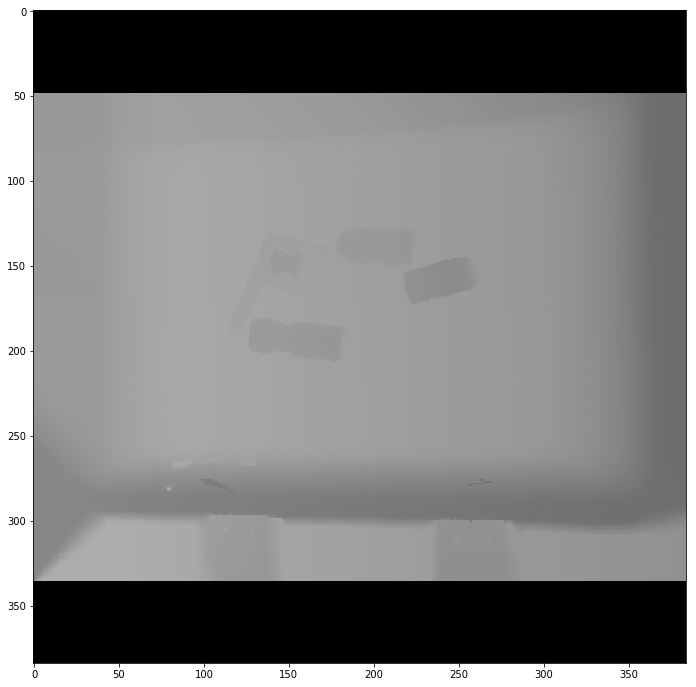

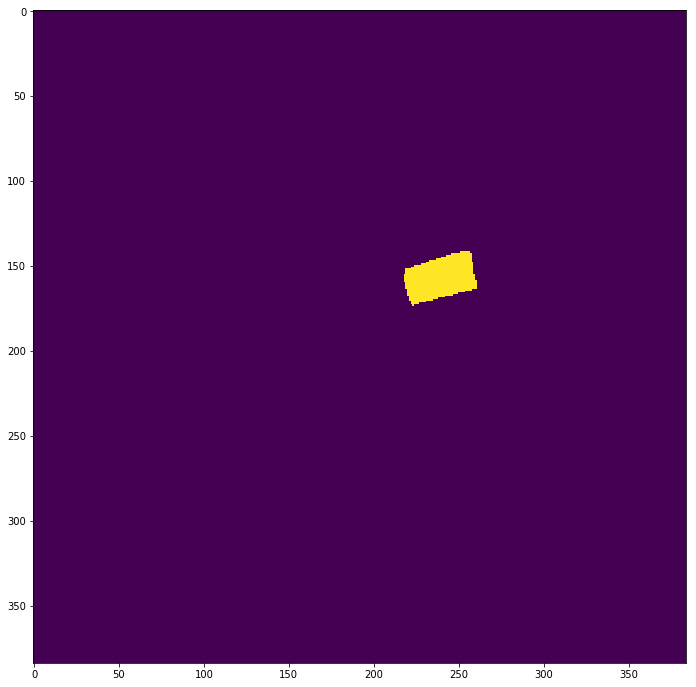

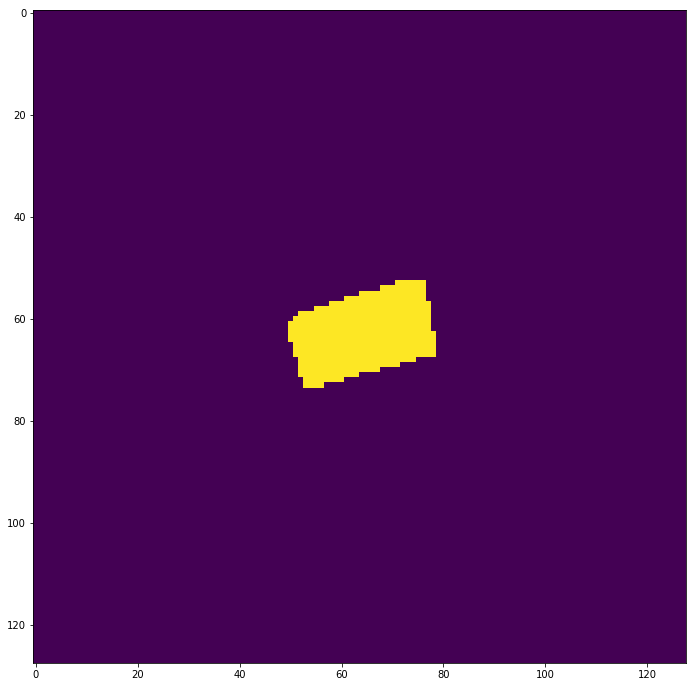

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000022.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000022.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000022.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000022

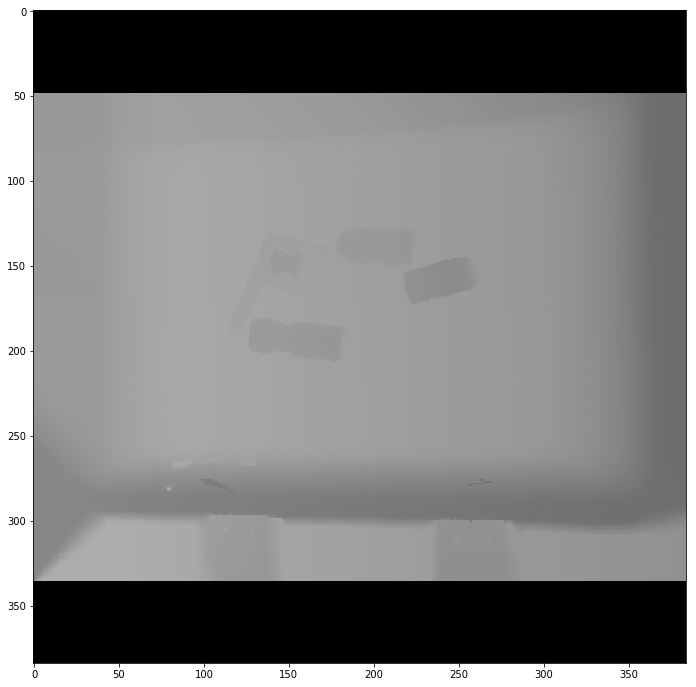

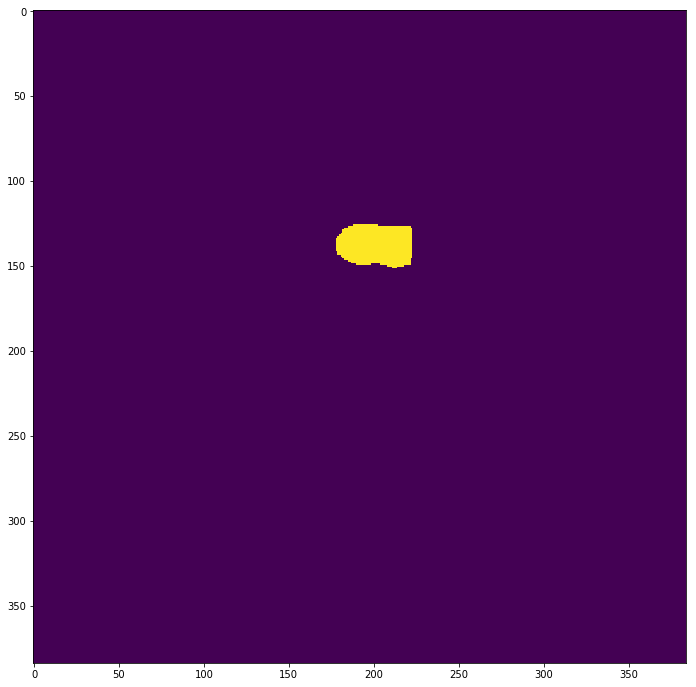

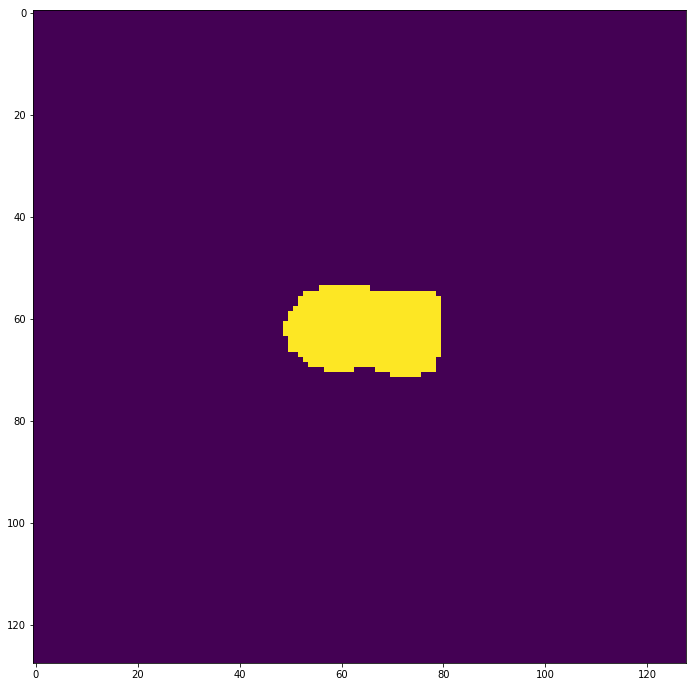

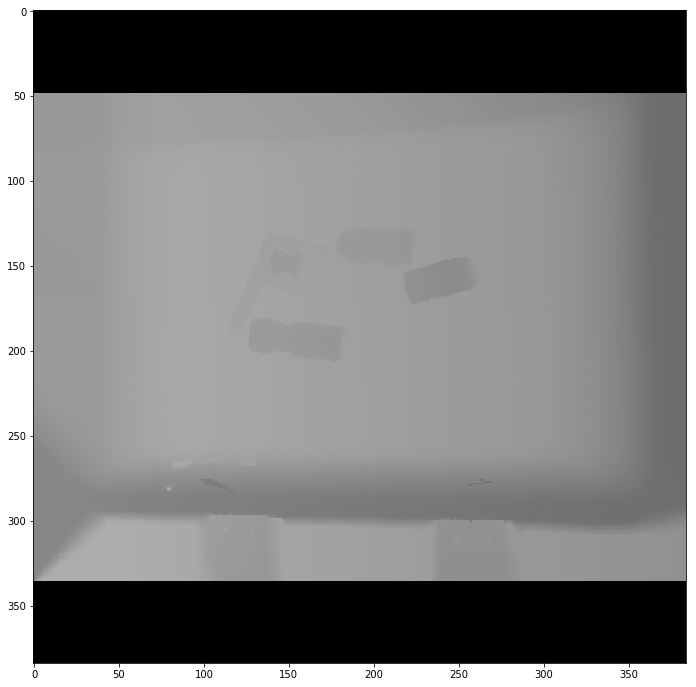

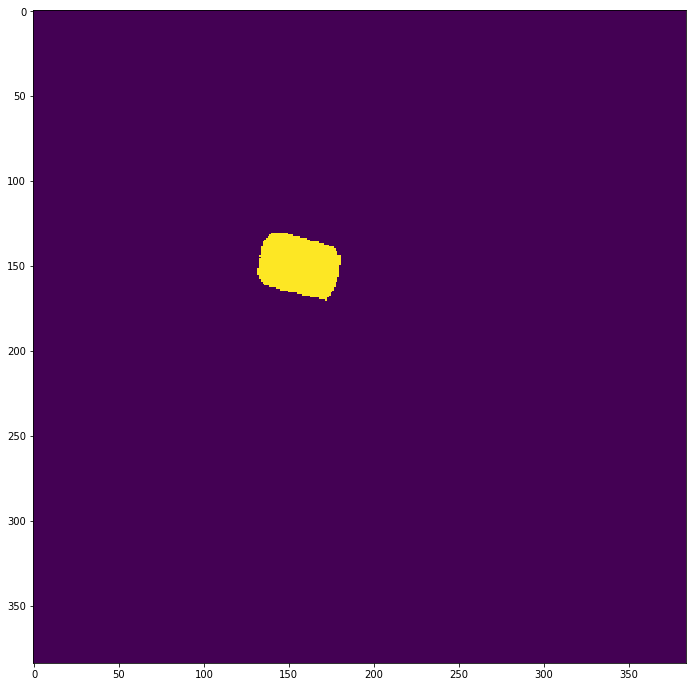

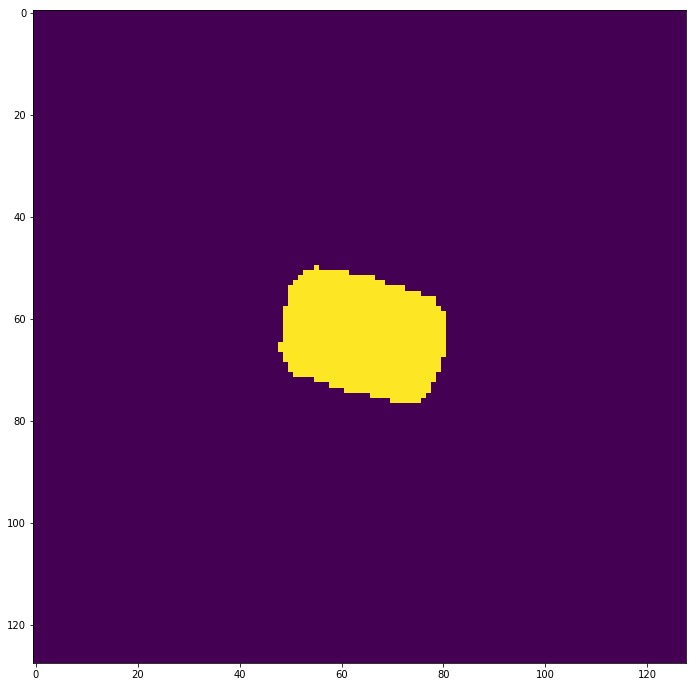

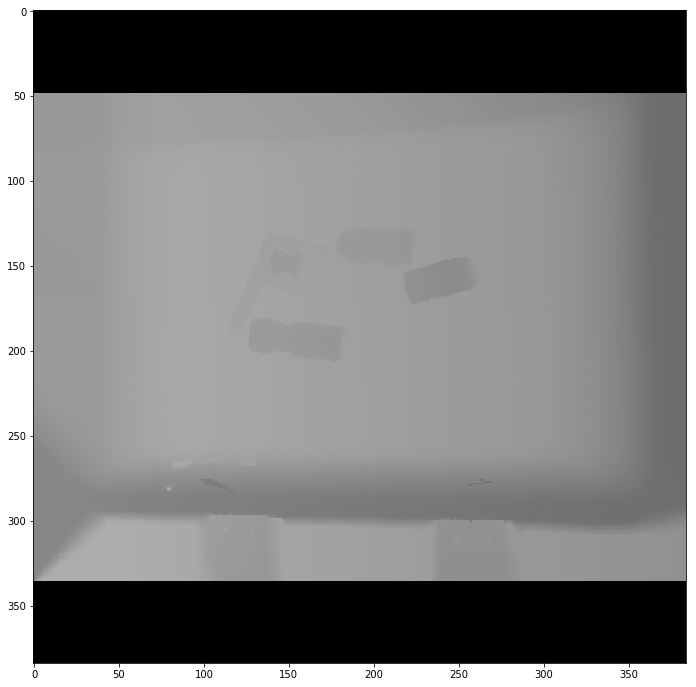

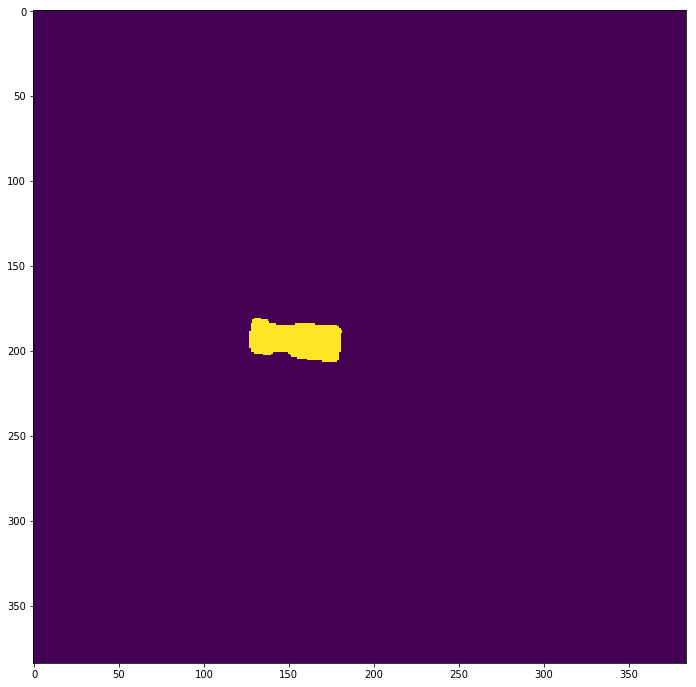

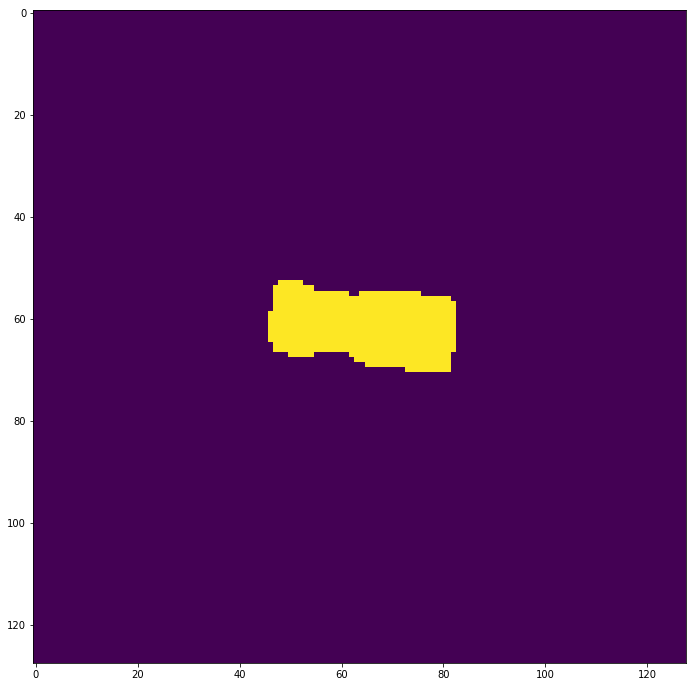

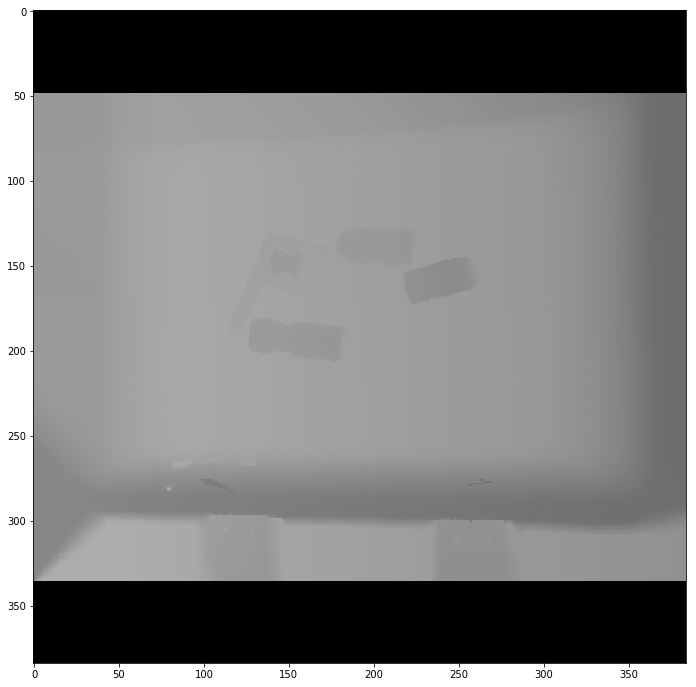

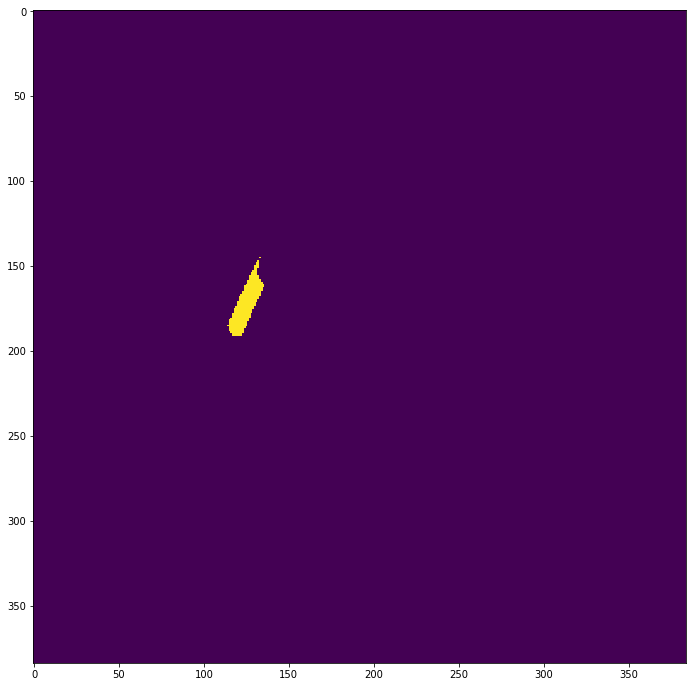

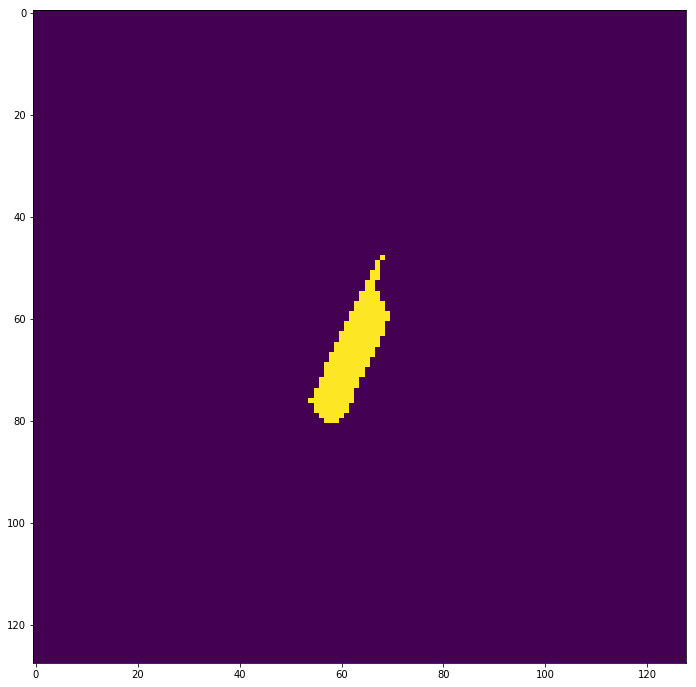

 77%|███████▋  | 23/30 [01:13<00:22,  3.18s/it]

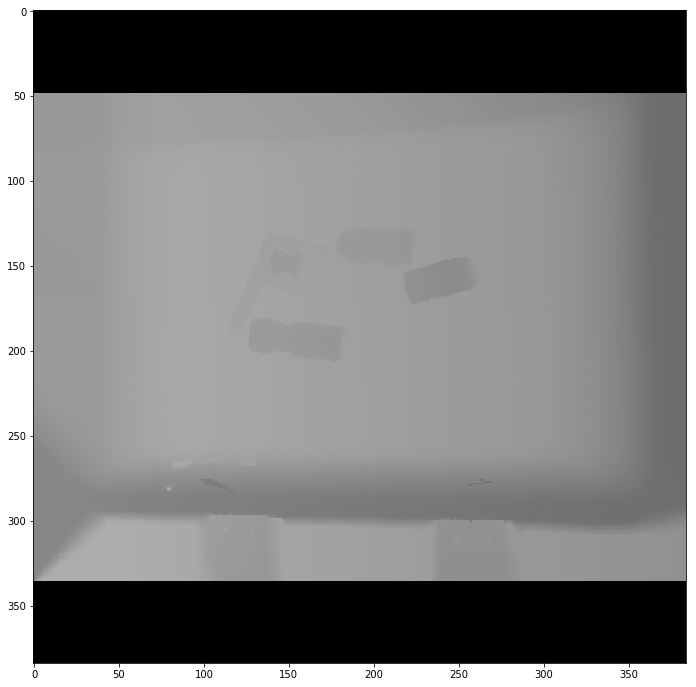

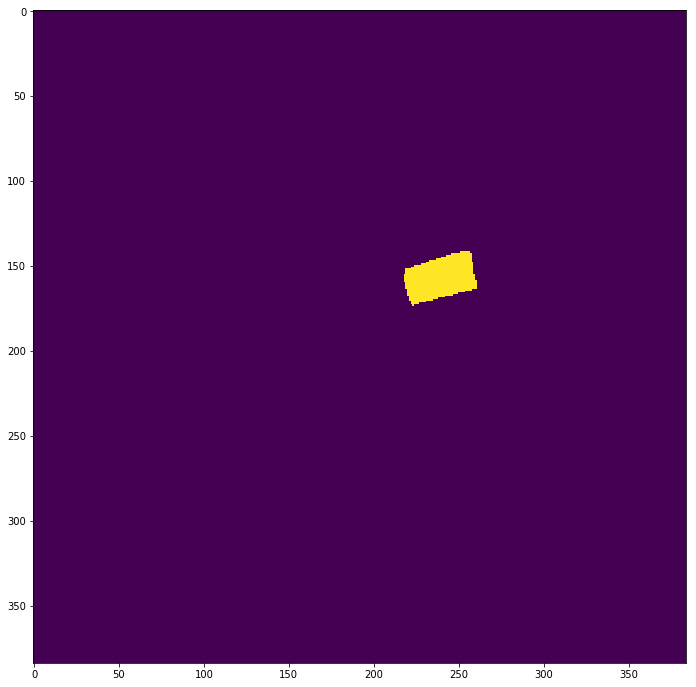

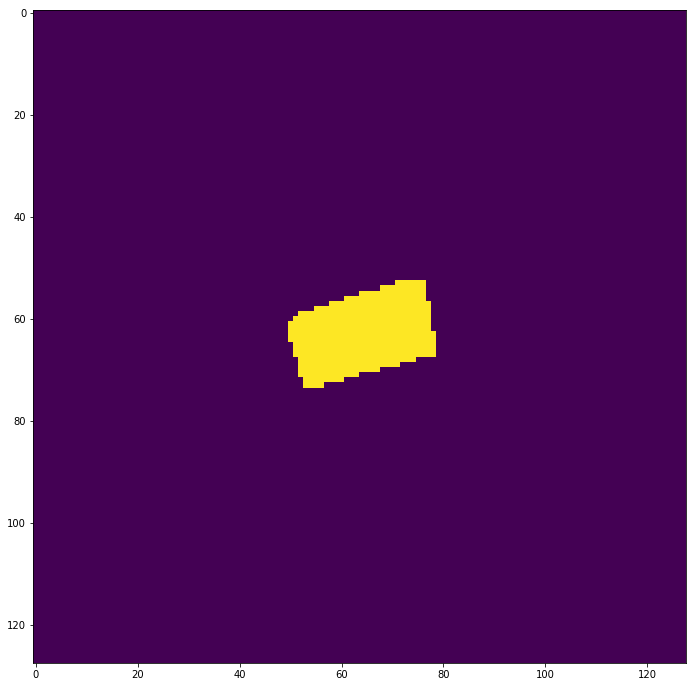

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000023

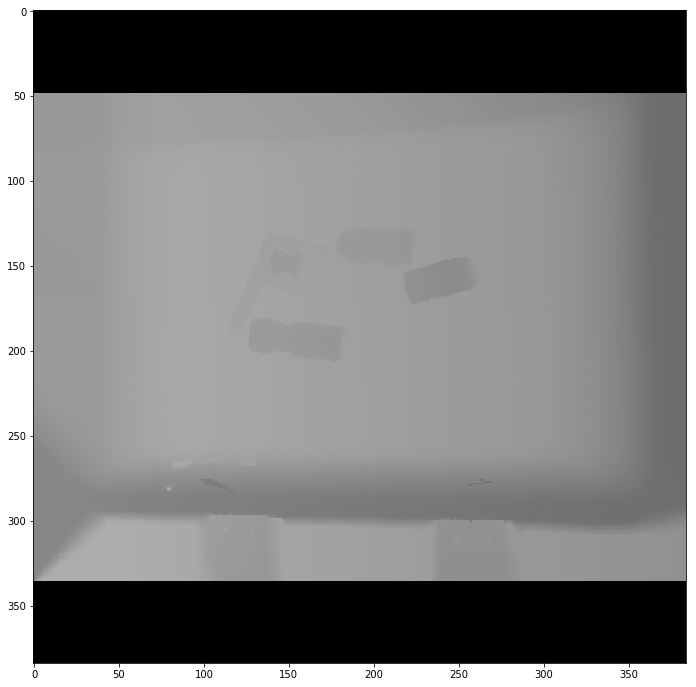

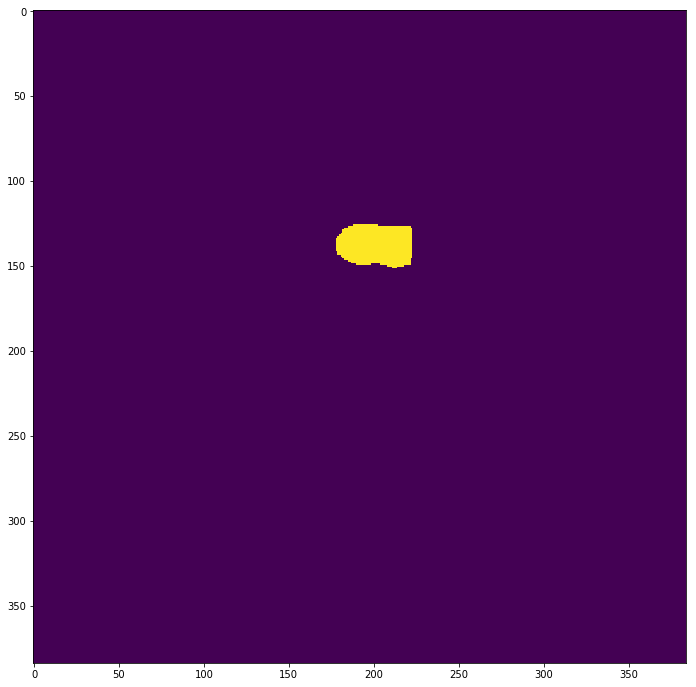

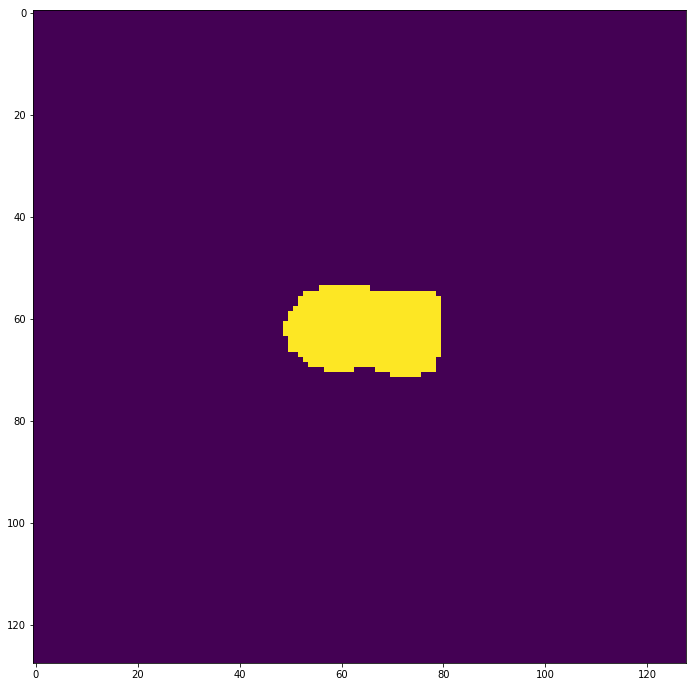

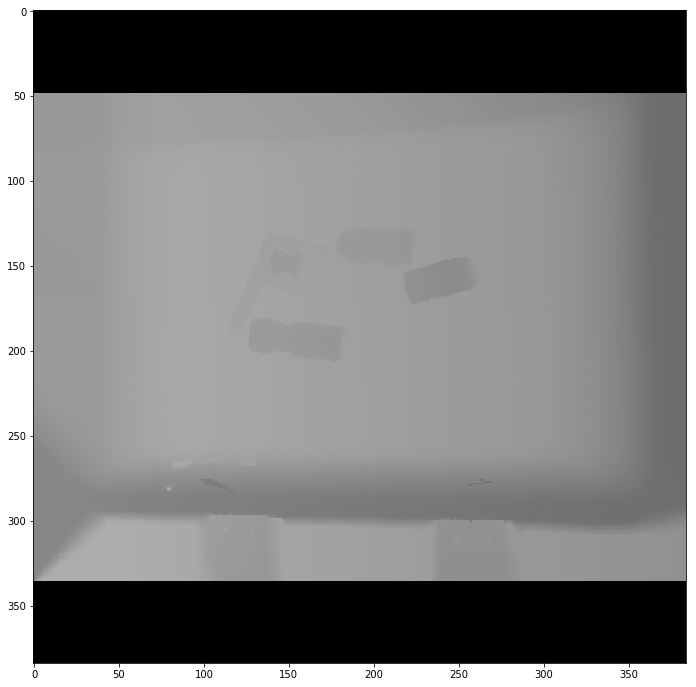

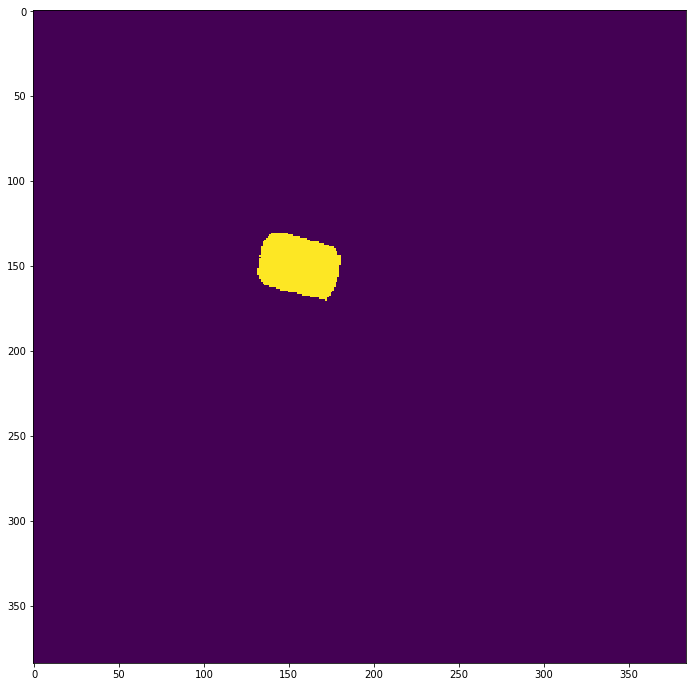

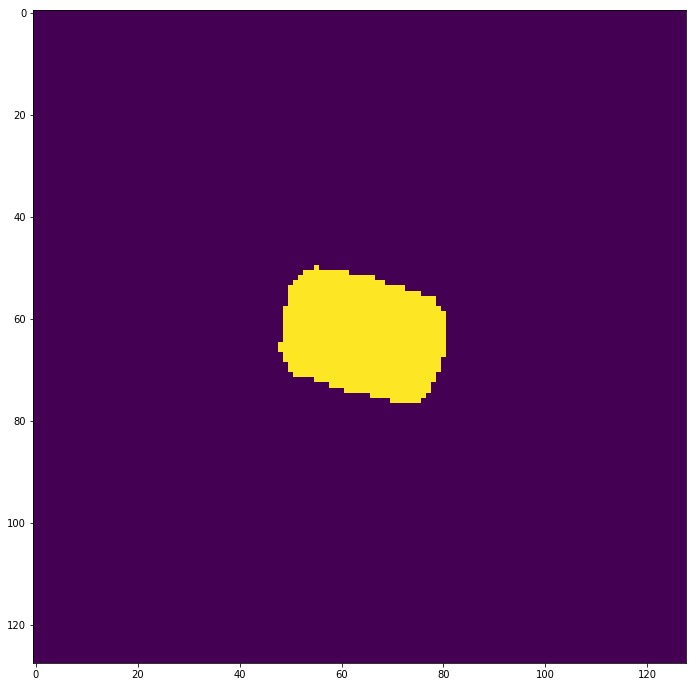

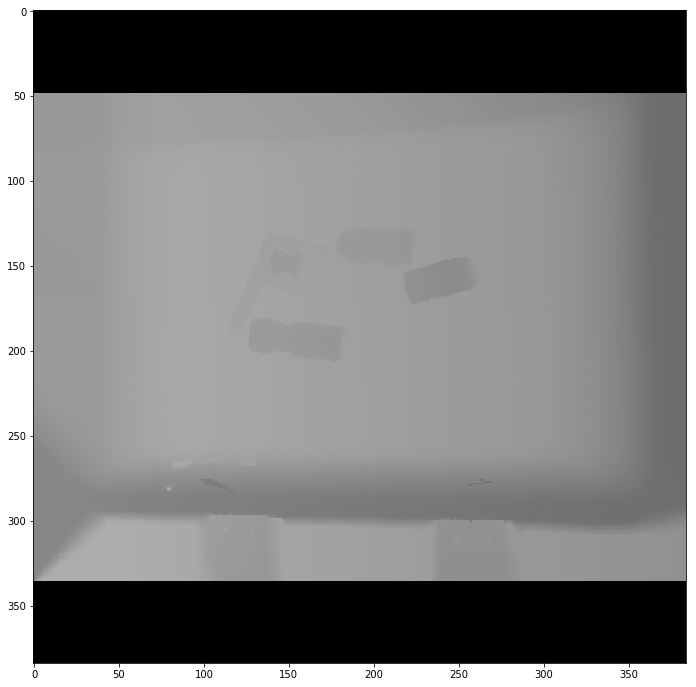

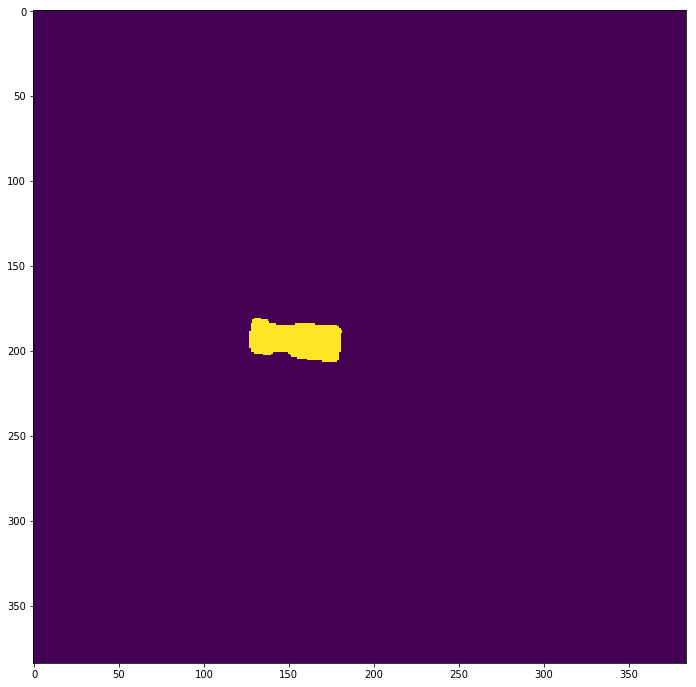

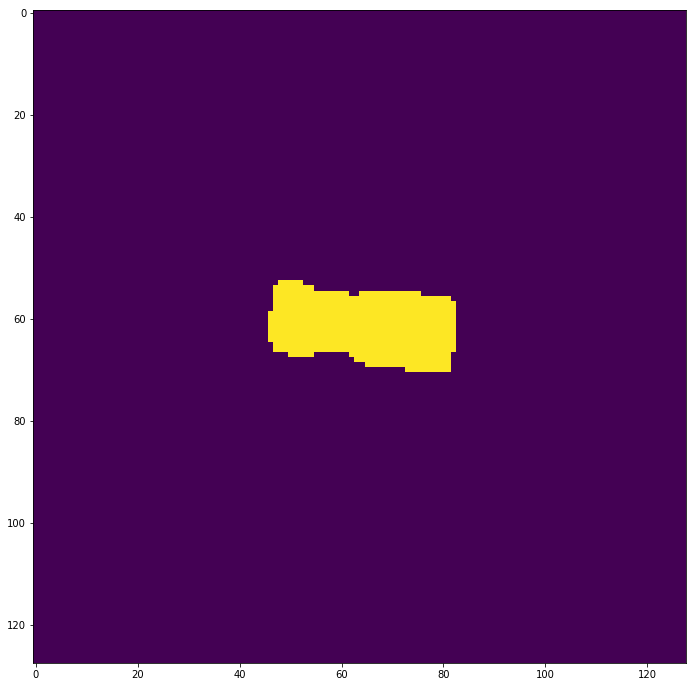

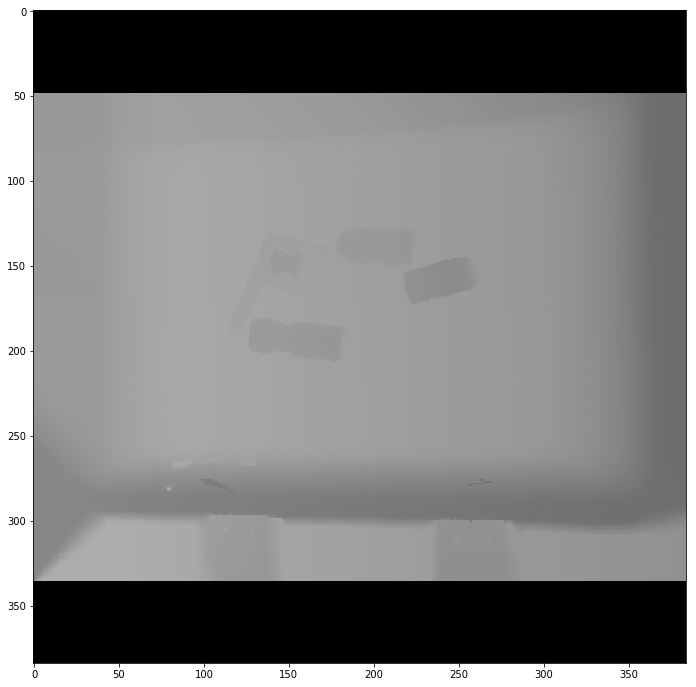

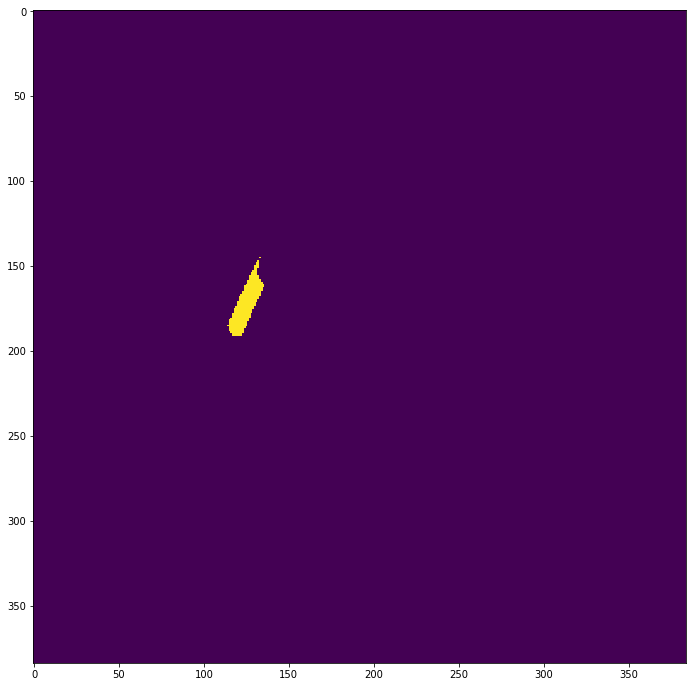

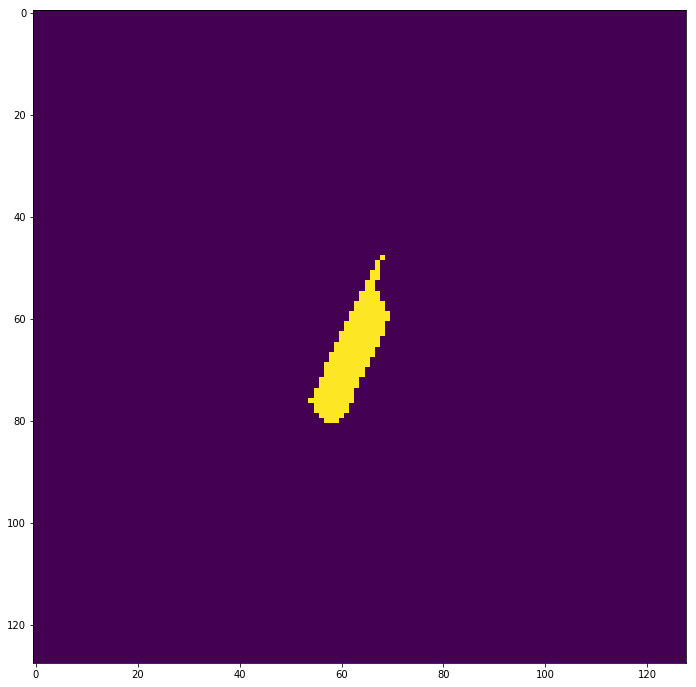

 80%|████████  | 24/30 [01:16<00:18,  3.15s/it]

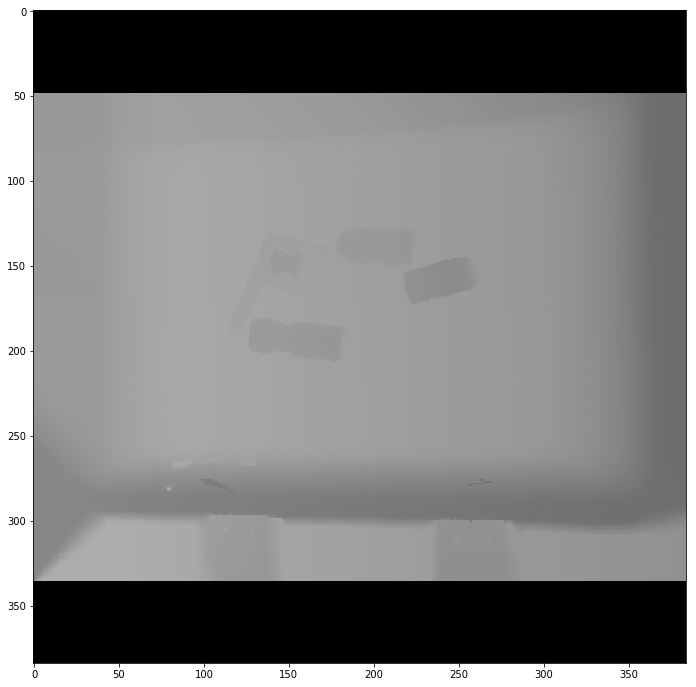

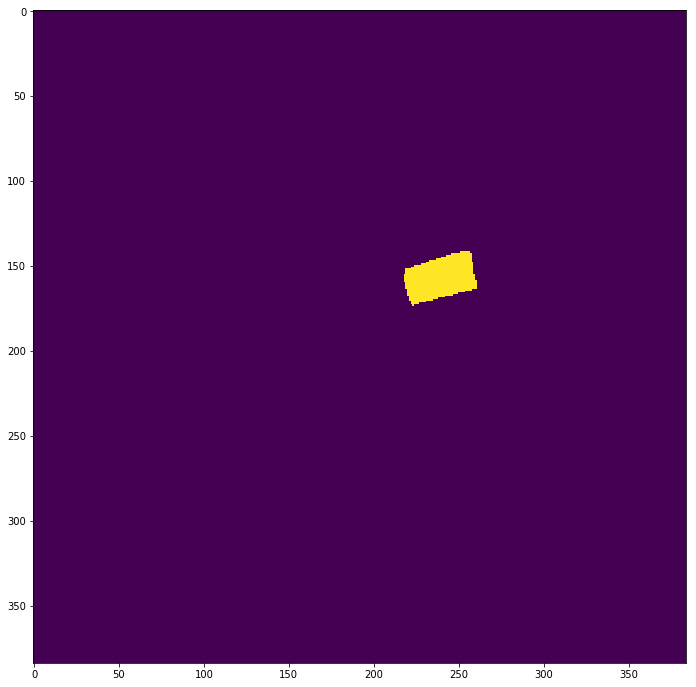

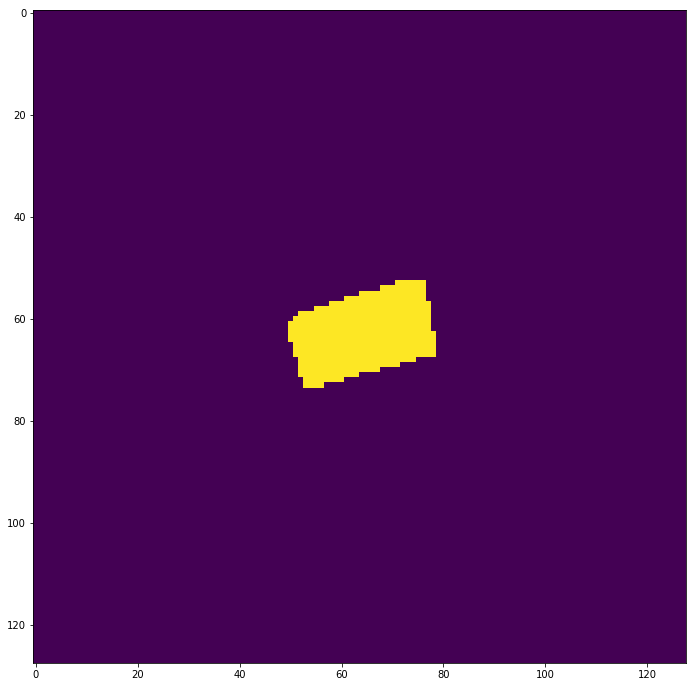

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000024

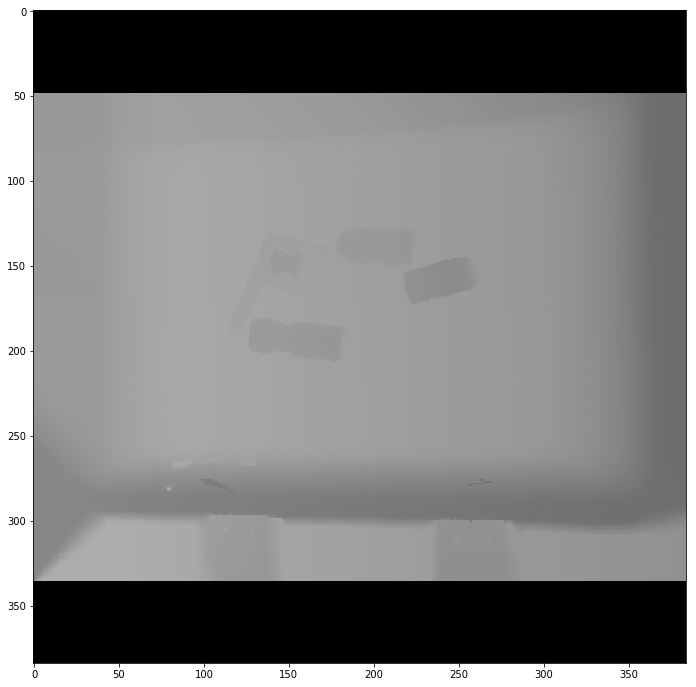

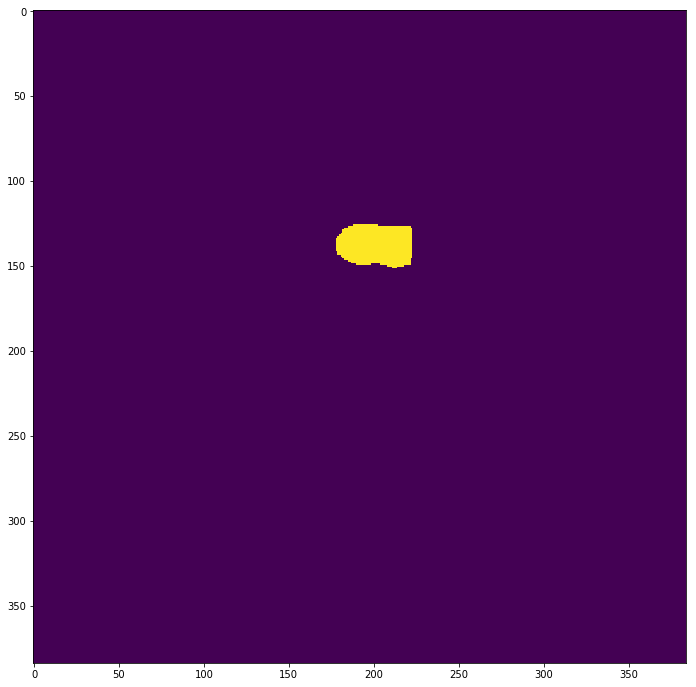

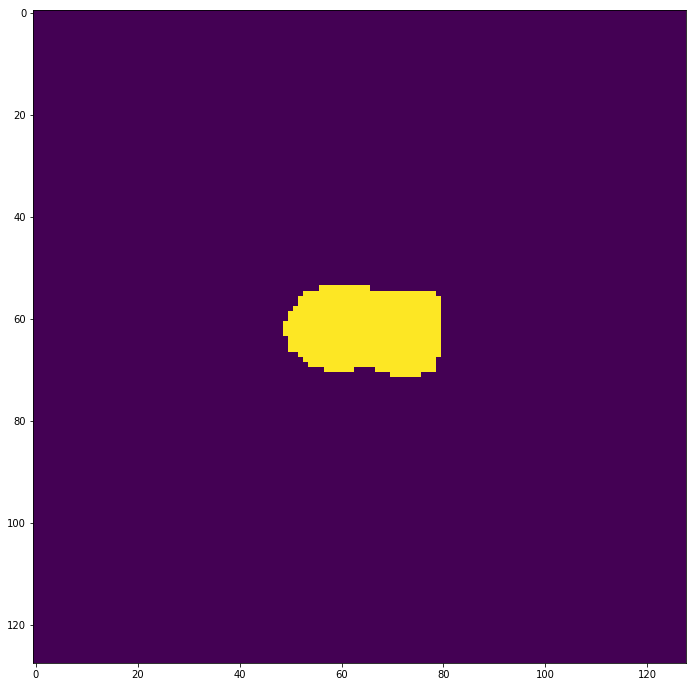

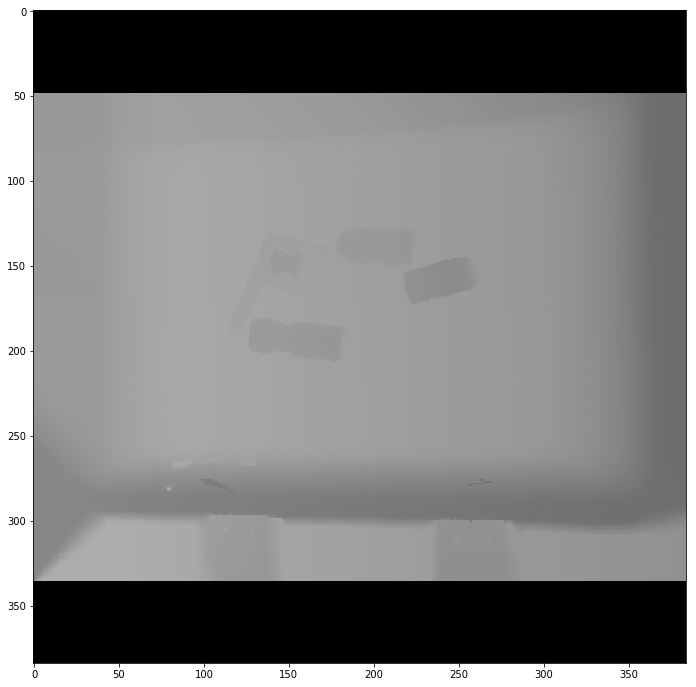

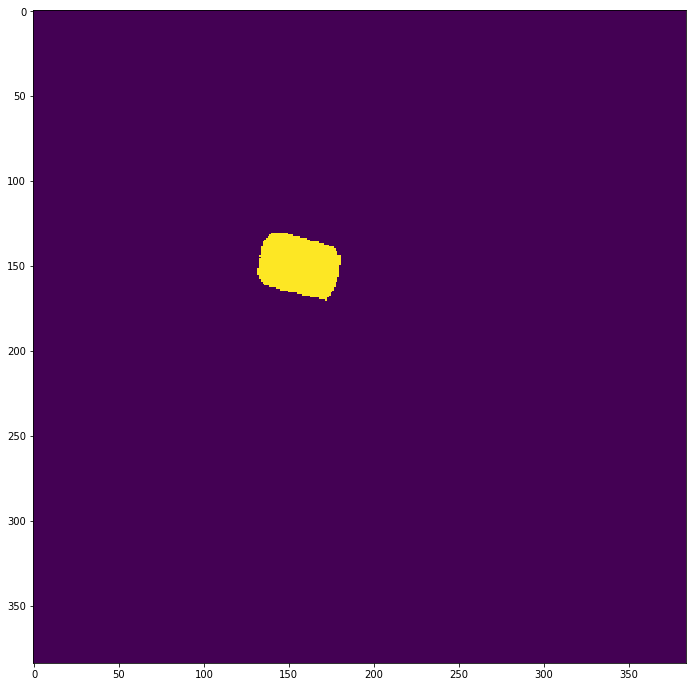

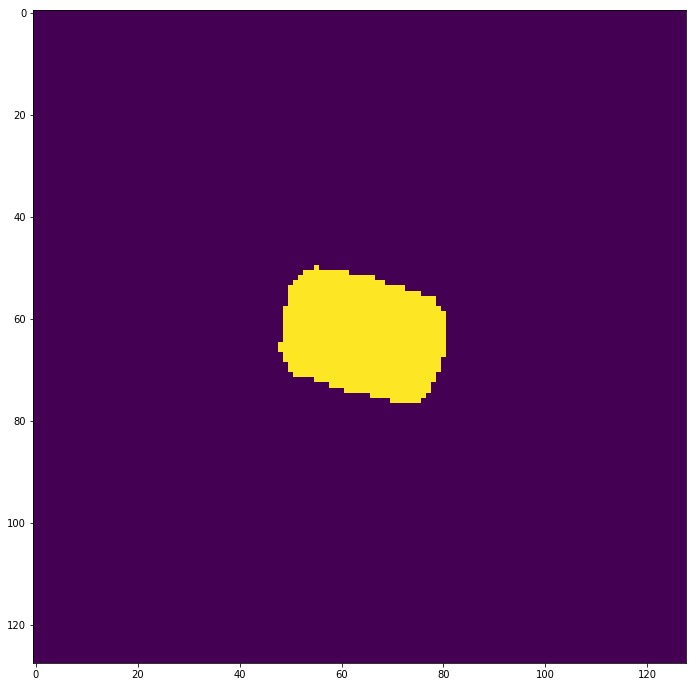

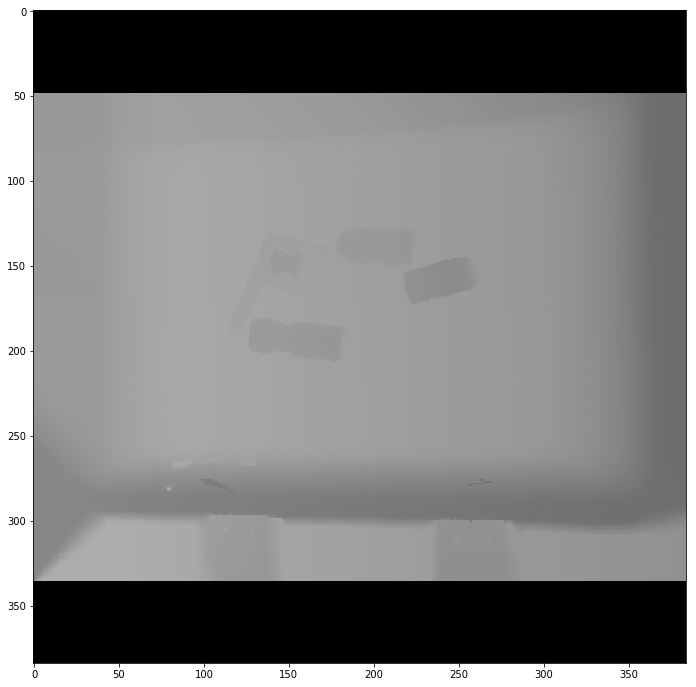

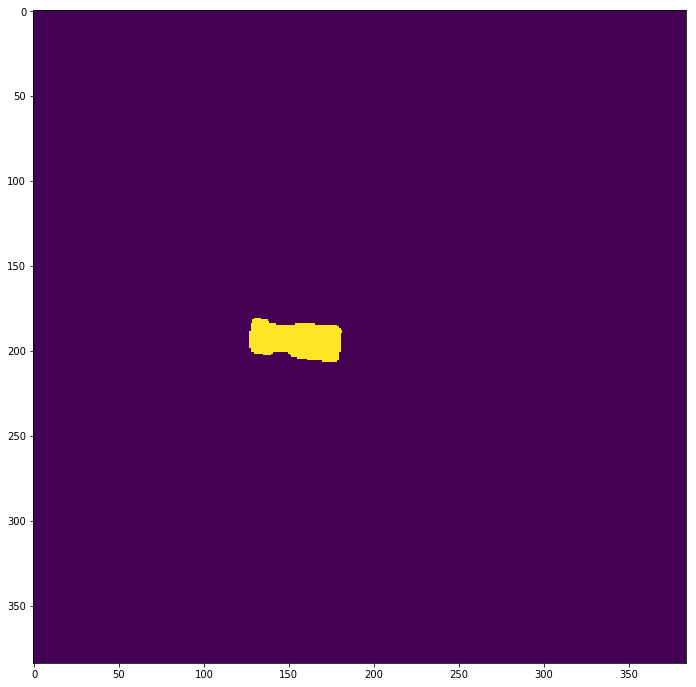

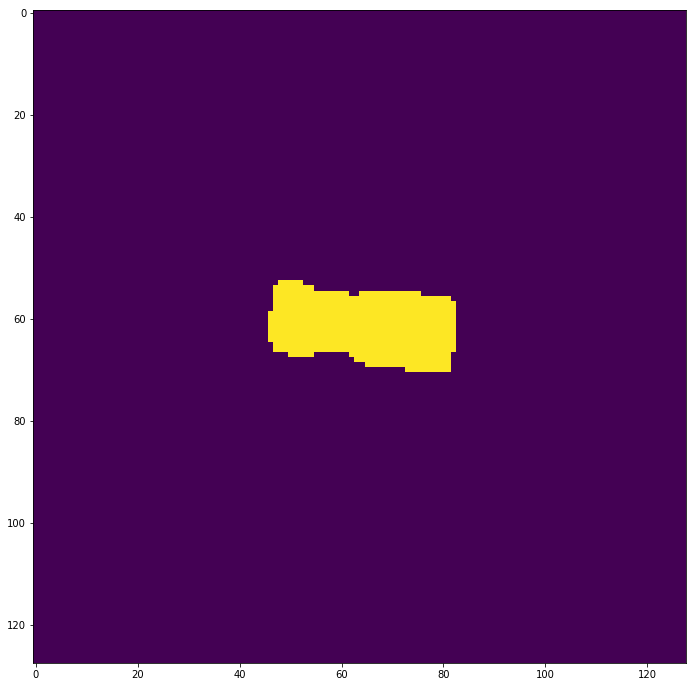

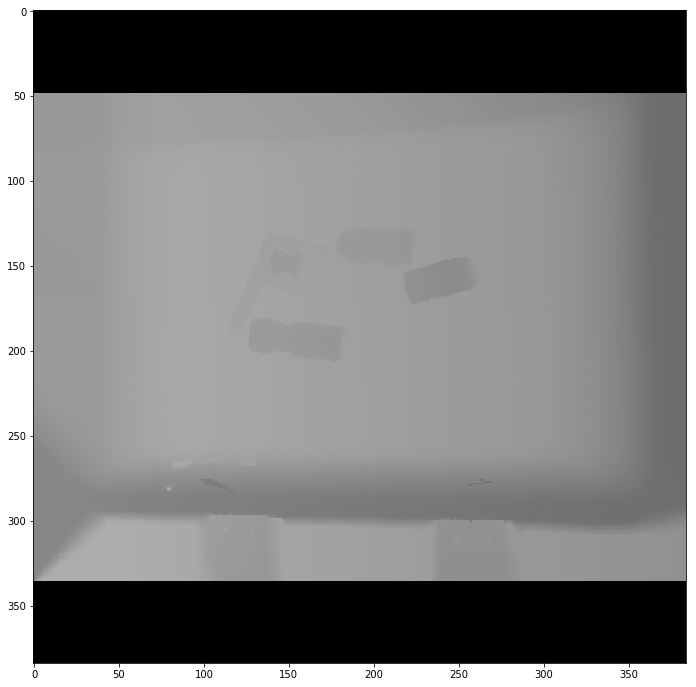

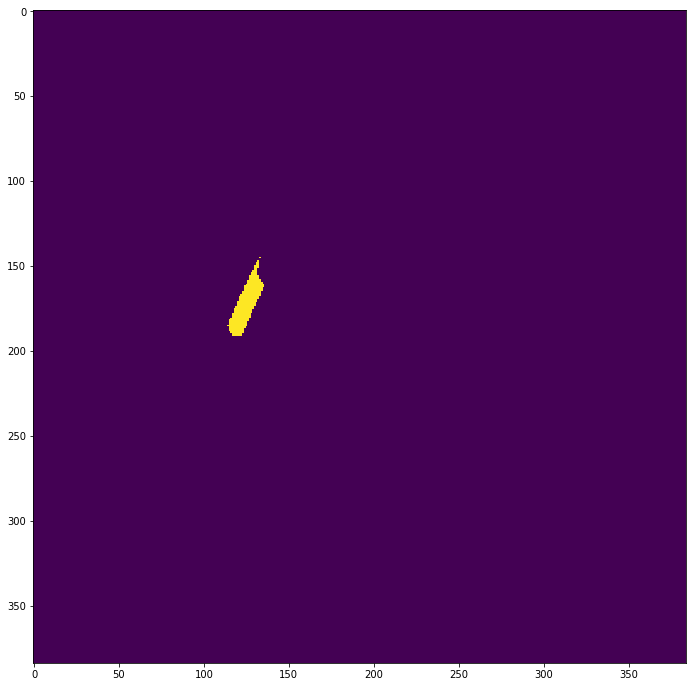

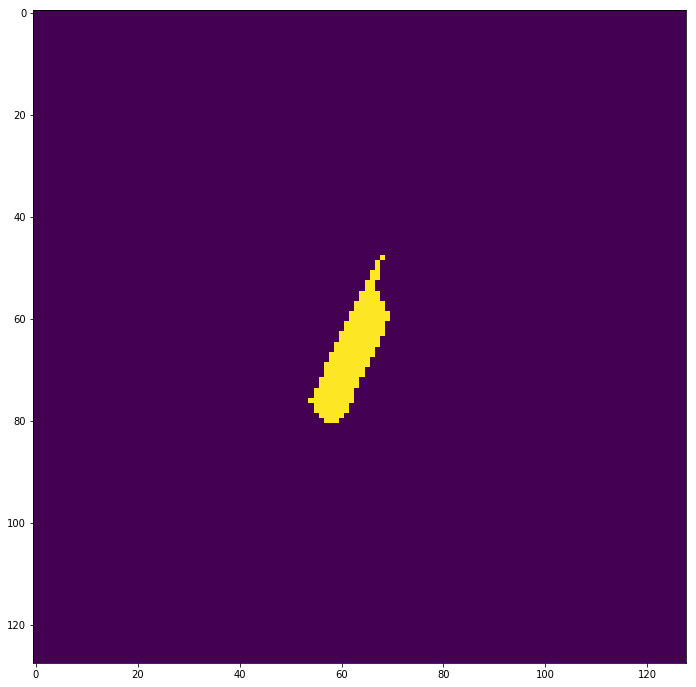

 83%|████████▎ | 25/30 [01:19<00:15,  3.13s/it]

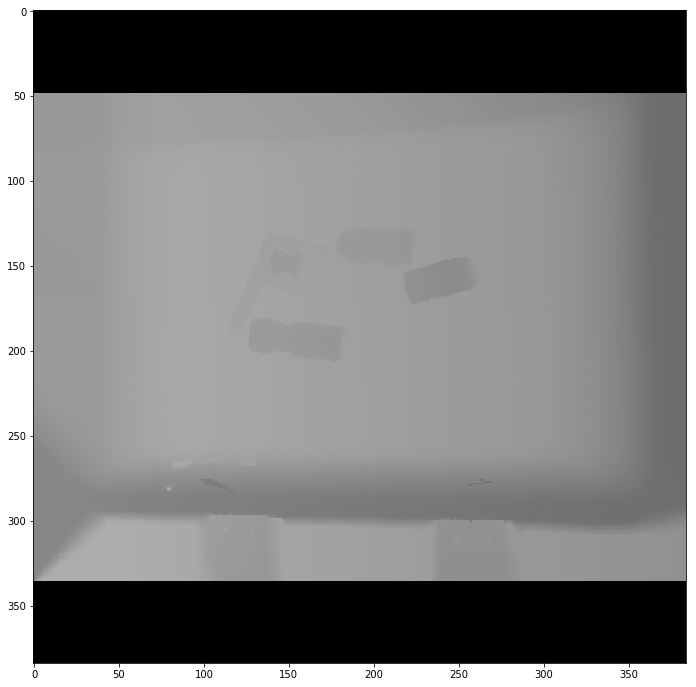

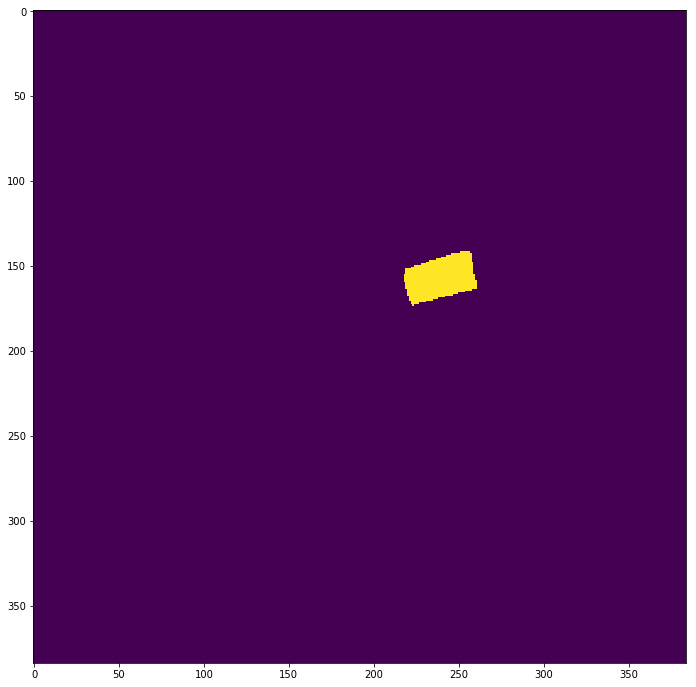

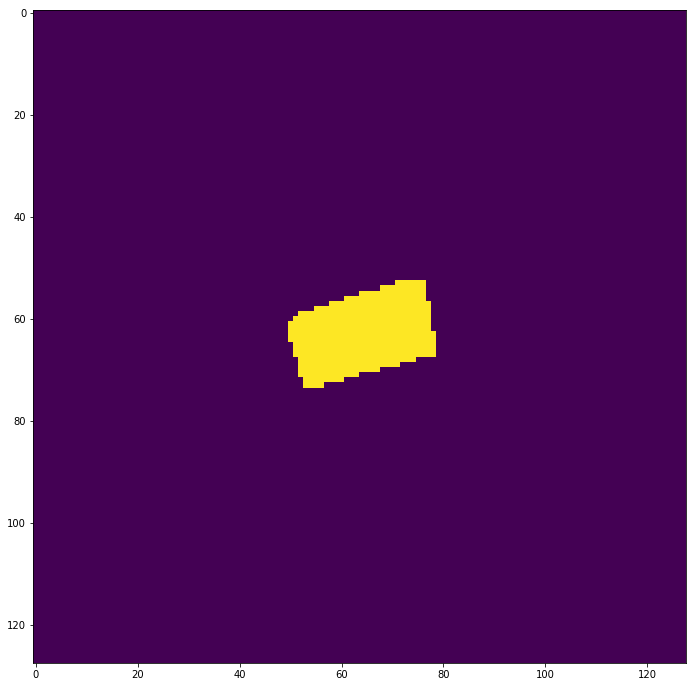

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000025.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000025.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000025.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000025

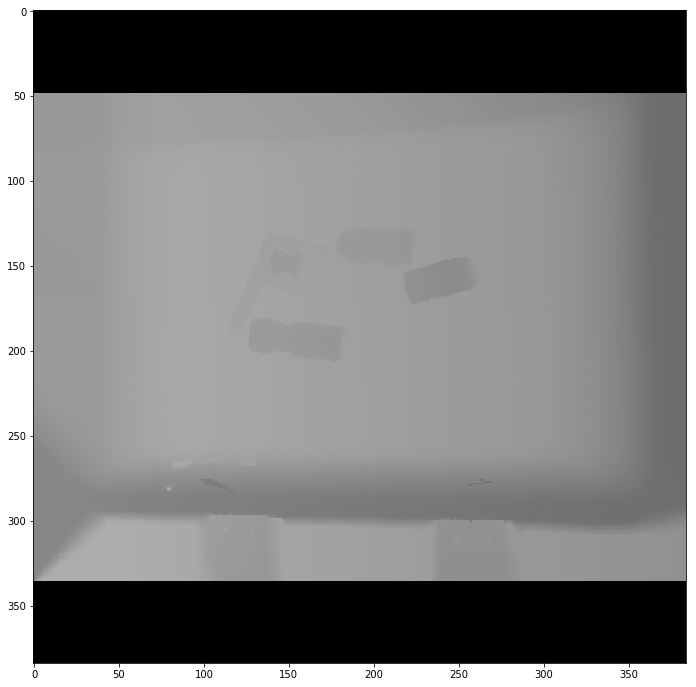

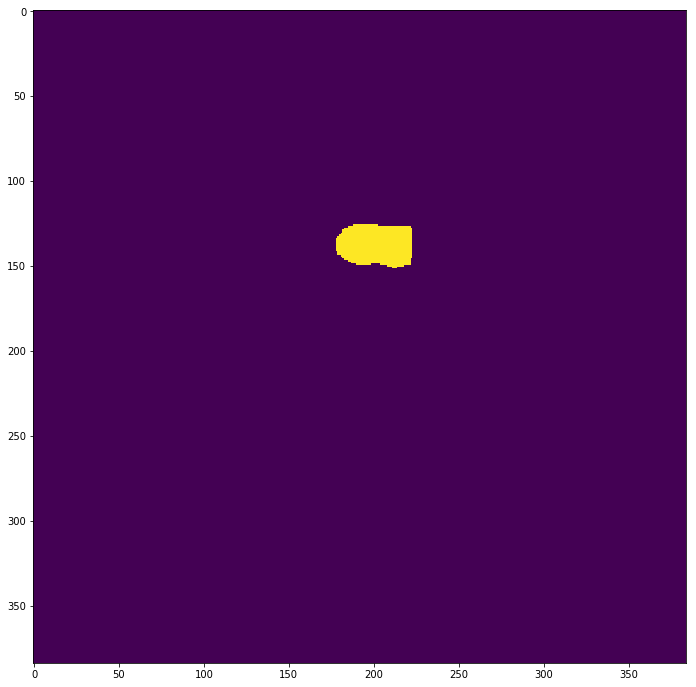

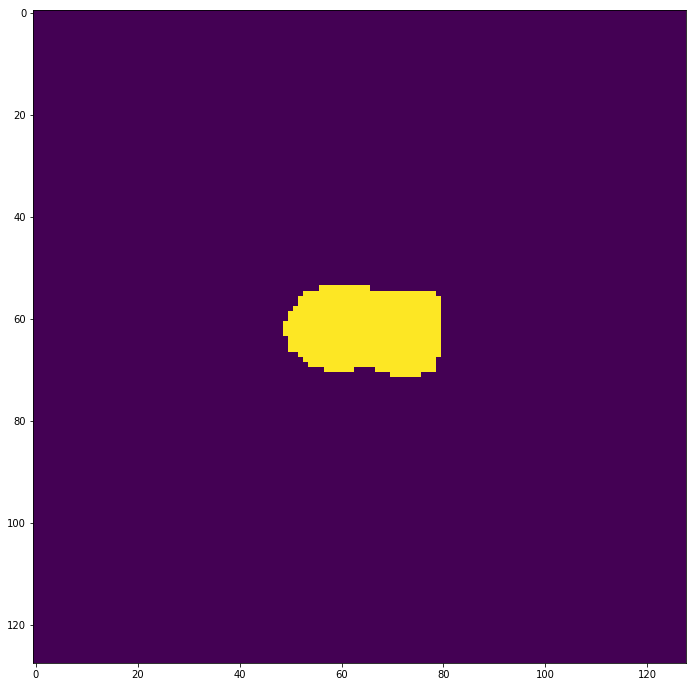

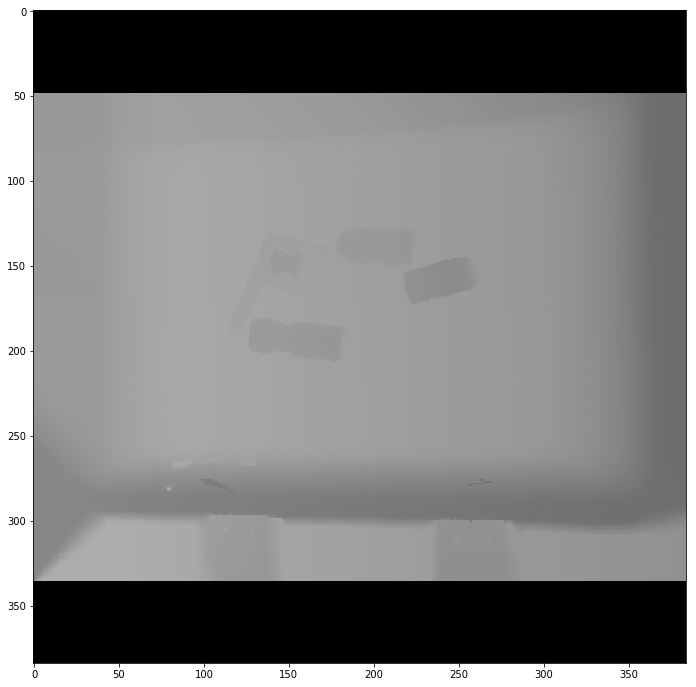

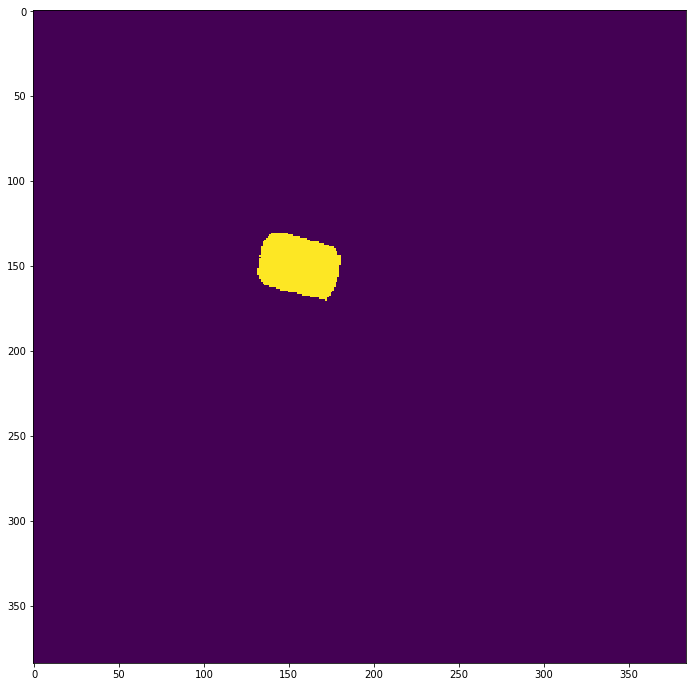

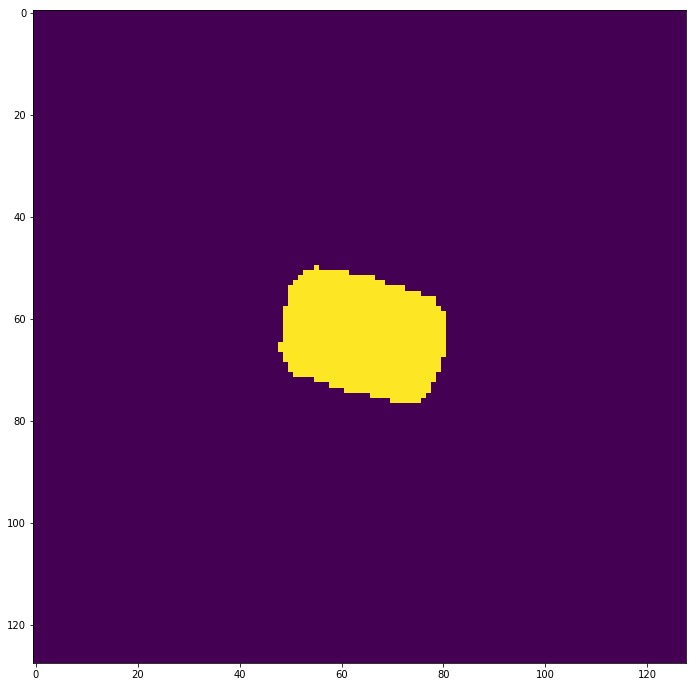

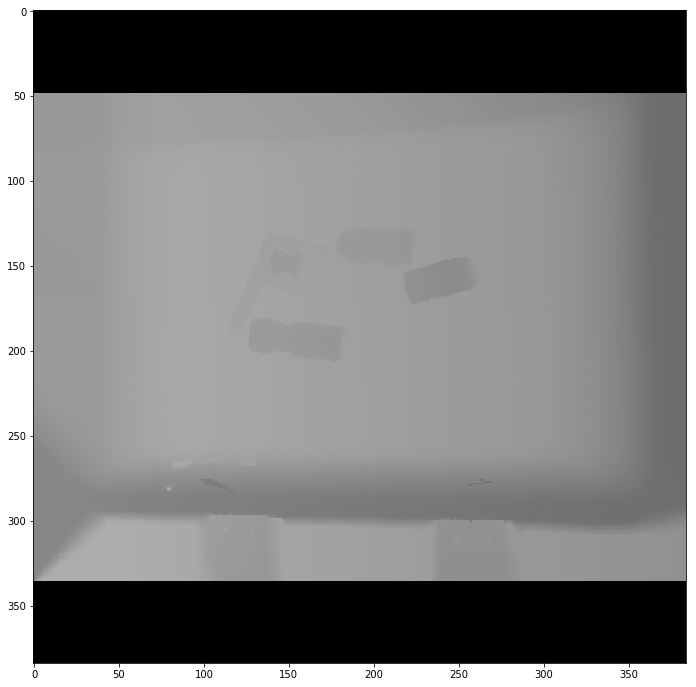

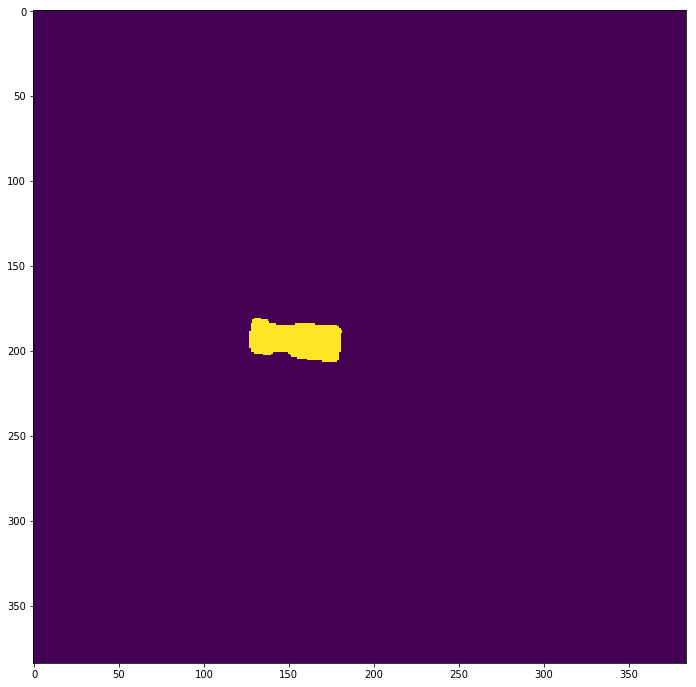

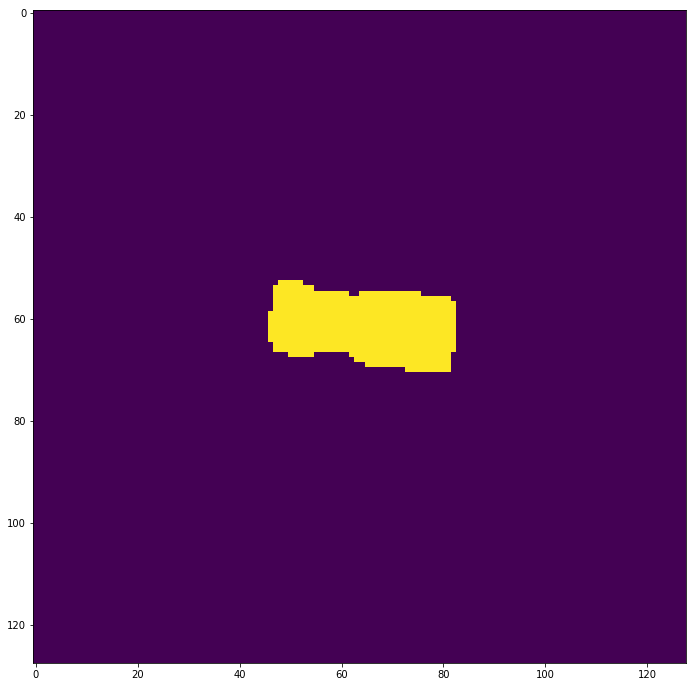

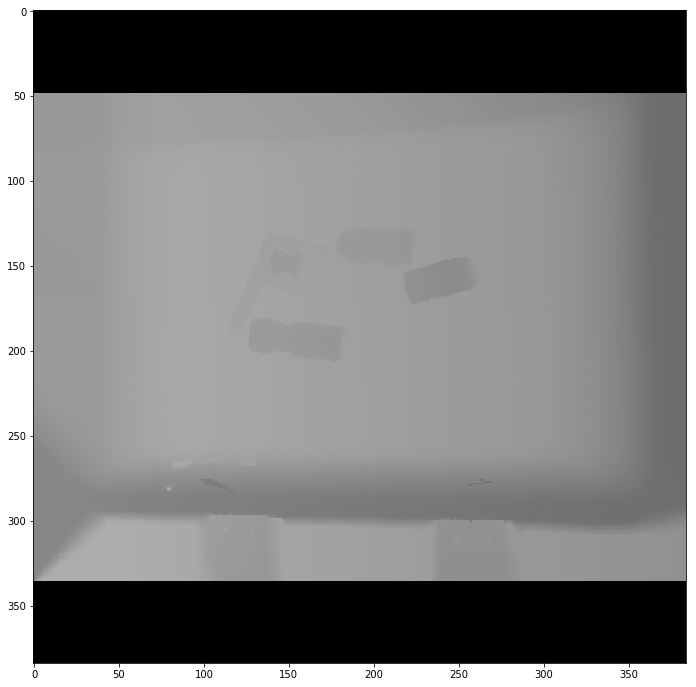

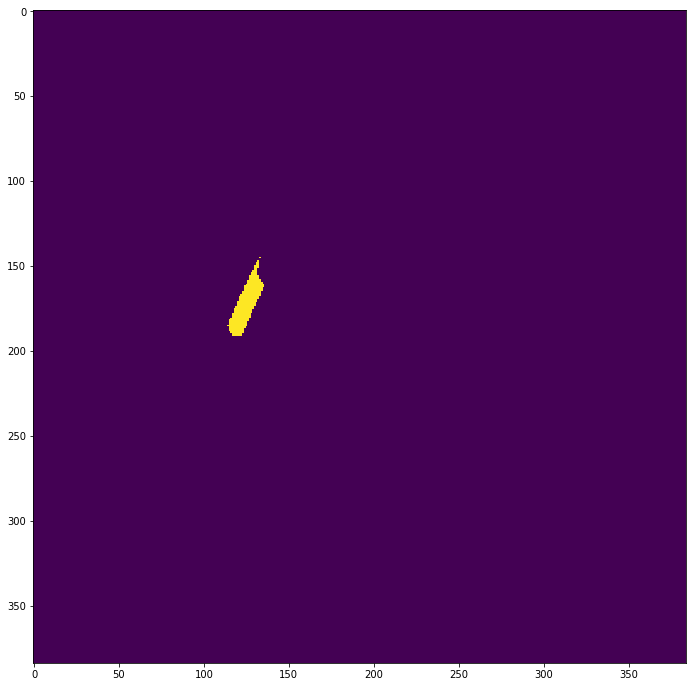

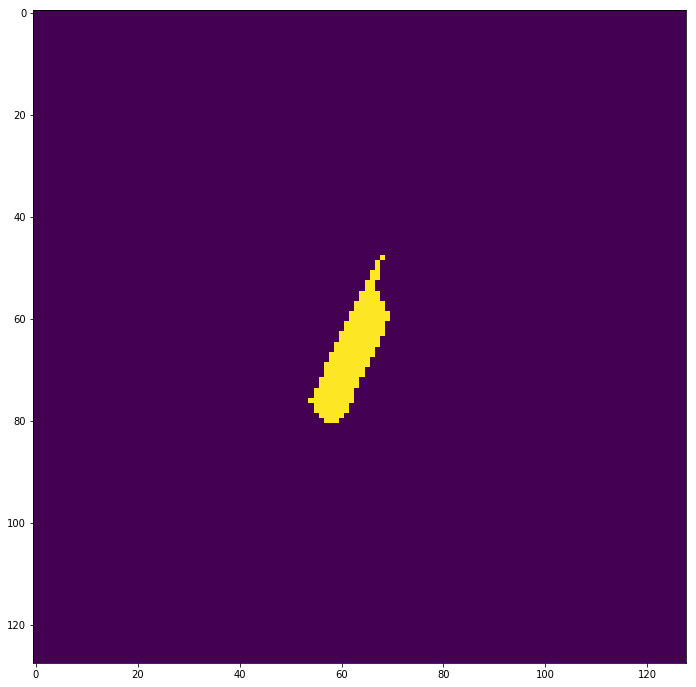

 87%|████████▋ | 26/30 [01:22<00:12,  3.15s/it]

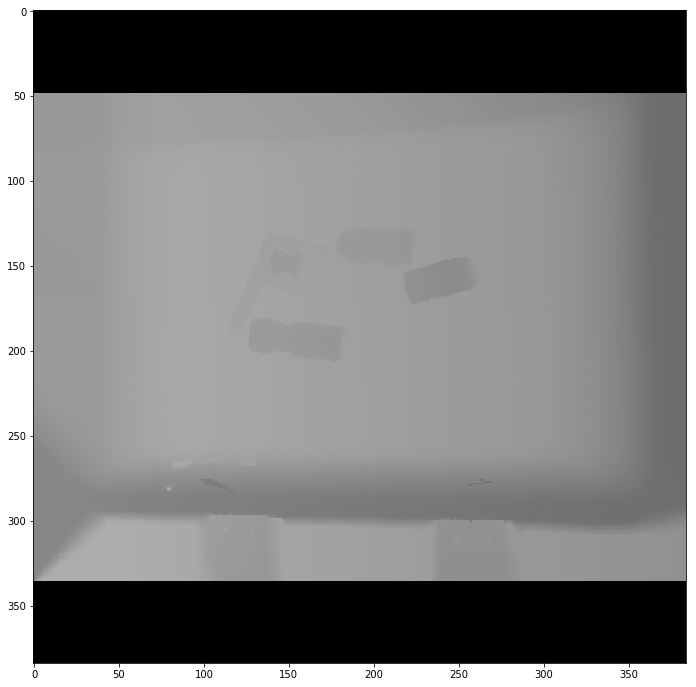

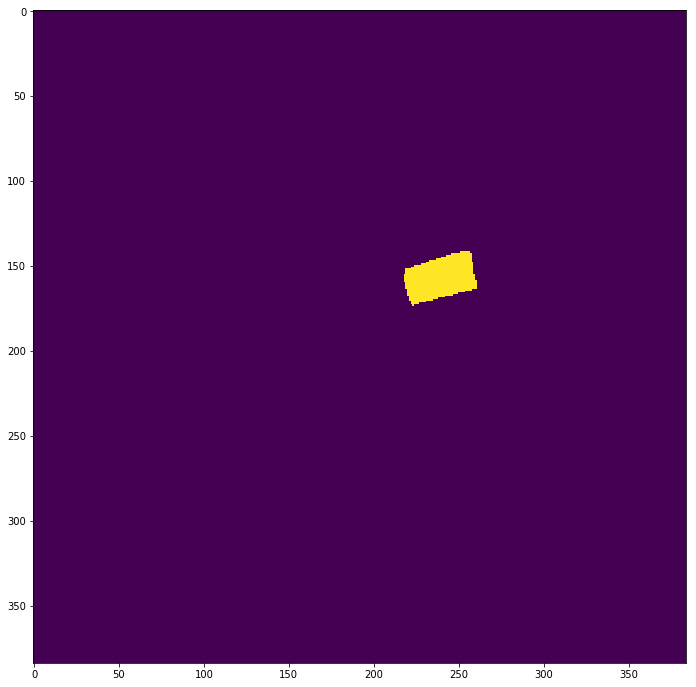

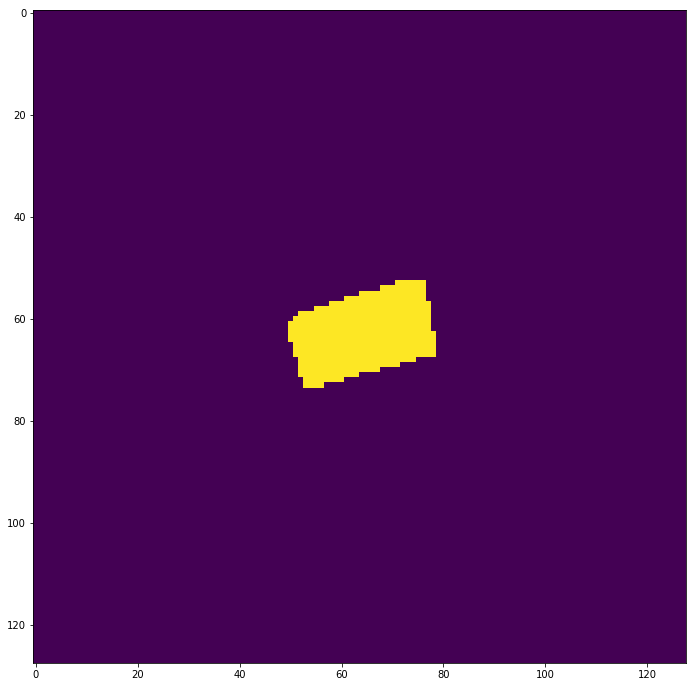

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000026.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000026.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000026.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000026

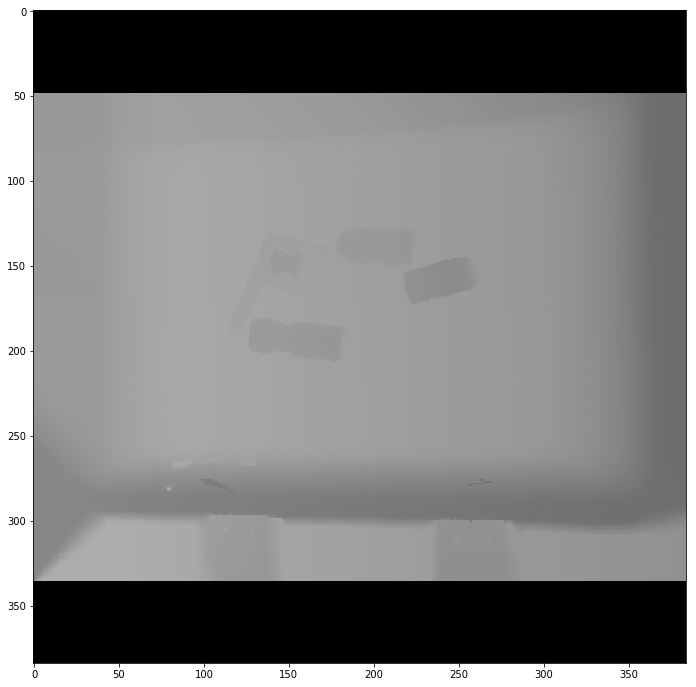

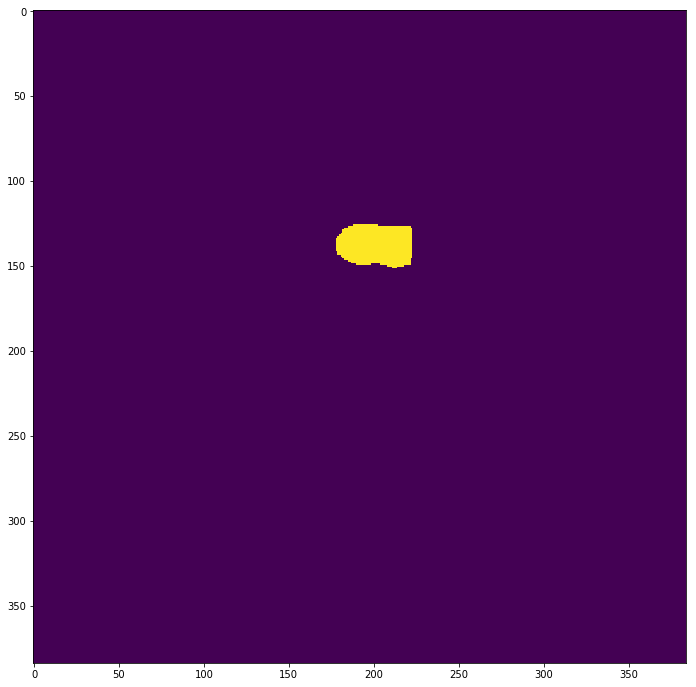

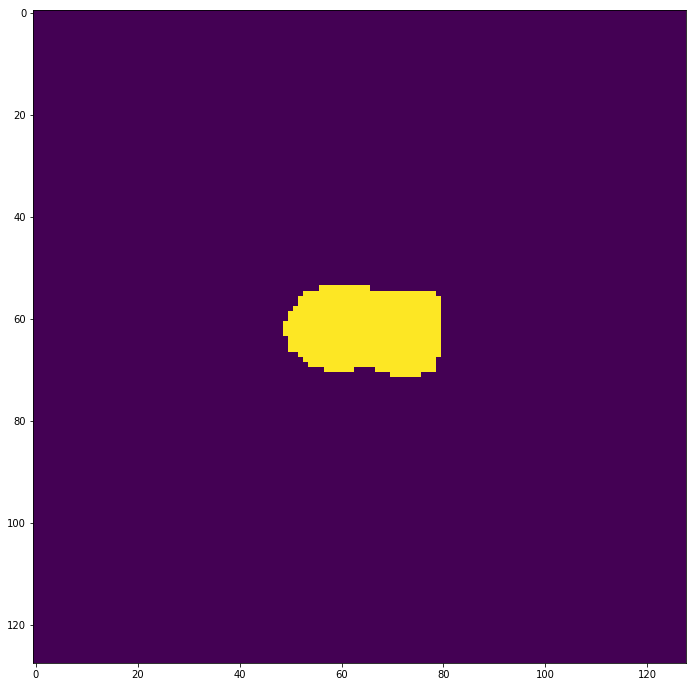

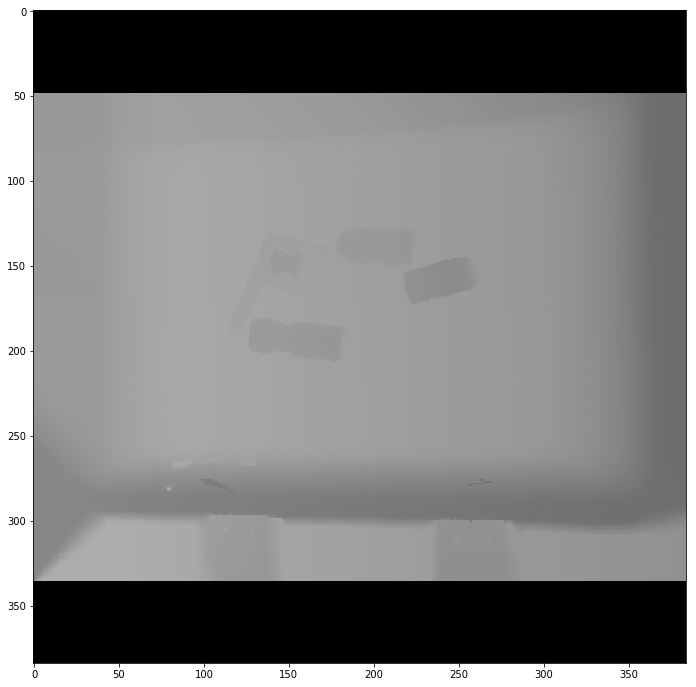

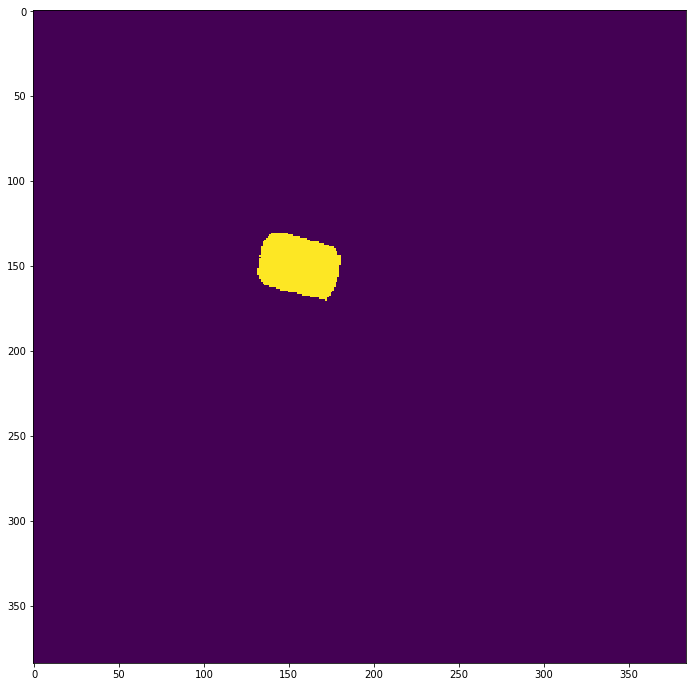

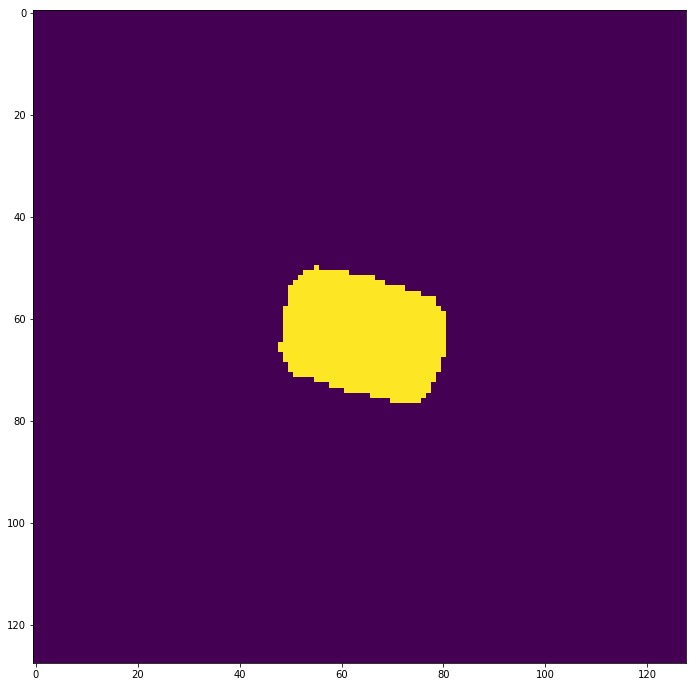

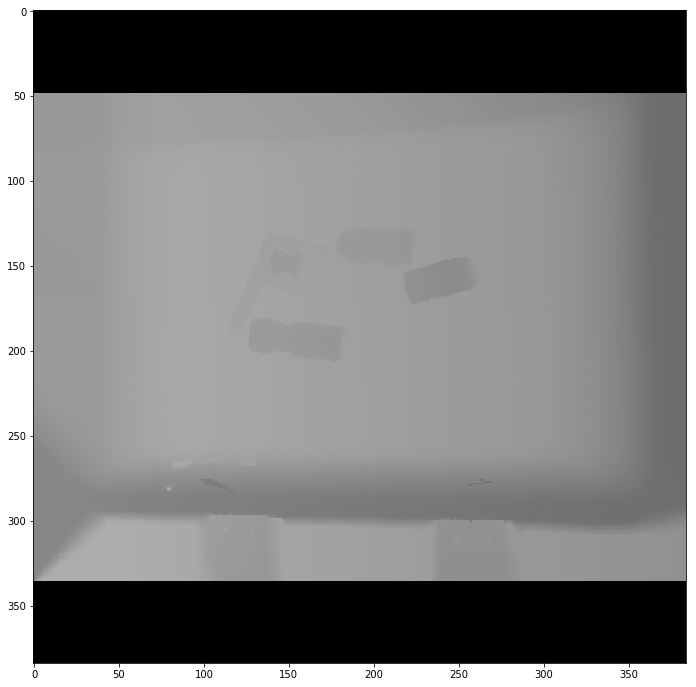

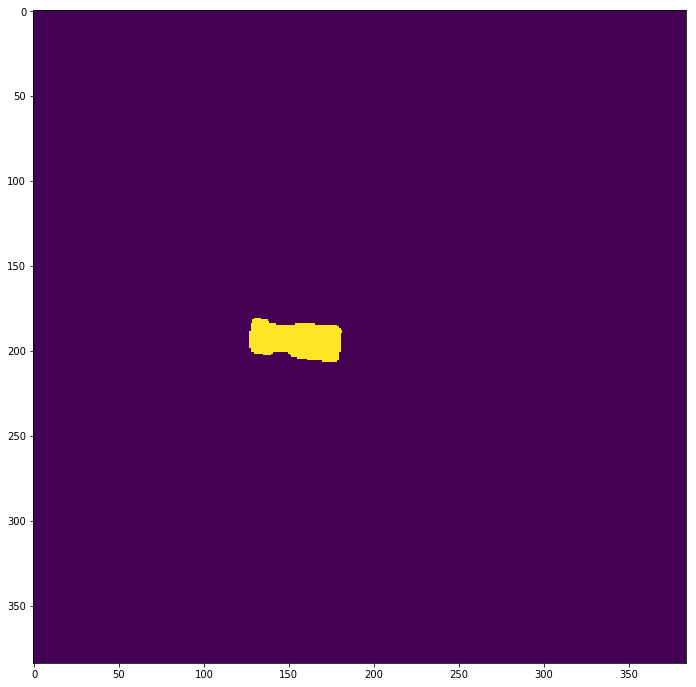

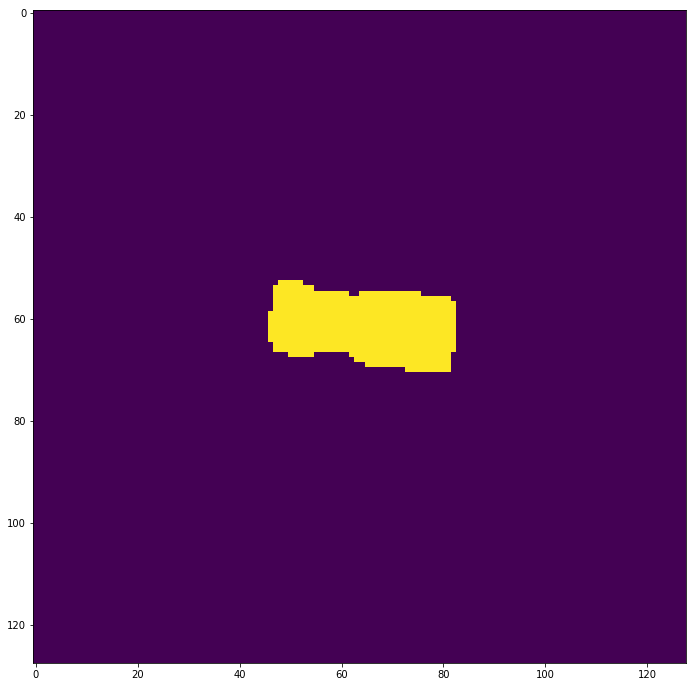

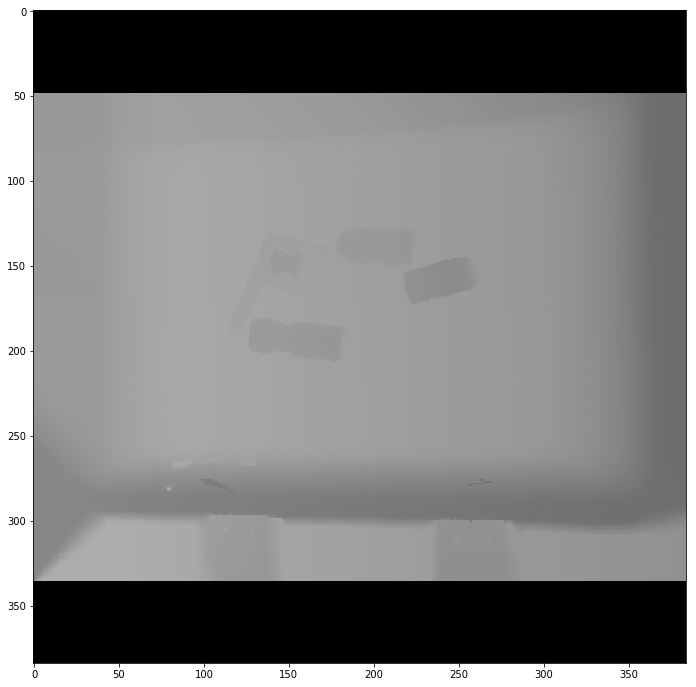

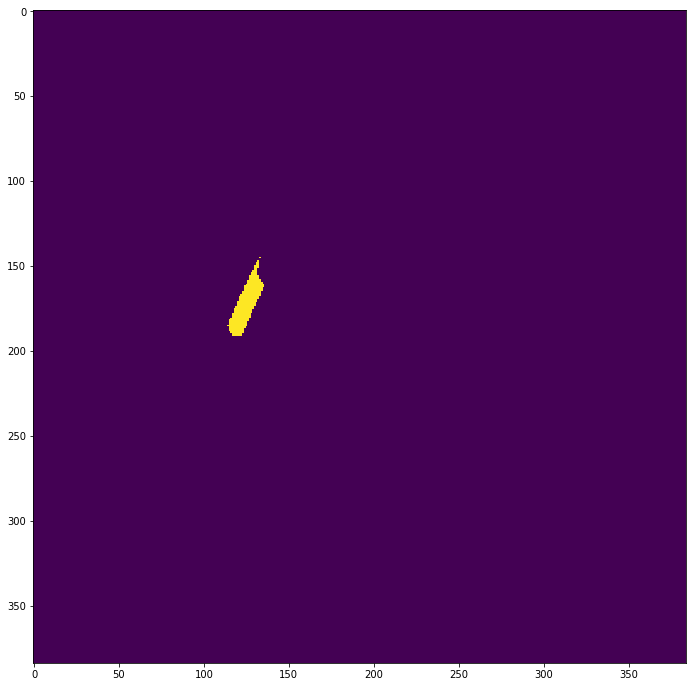

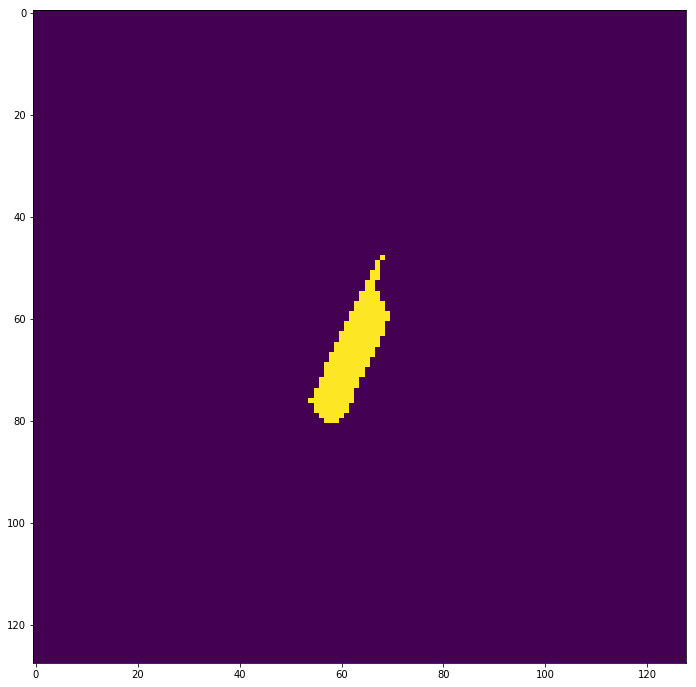

 90%|█████████ | 27/30 [01:26<00:09,  3.16s/it]

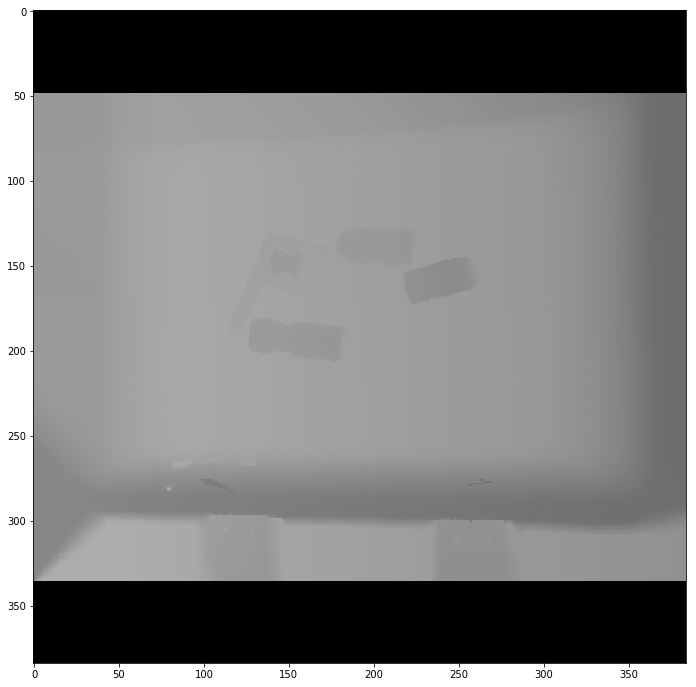

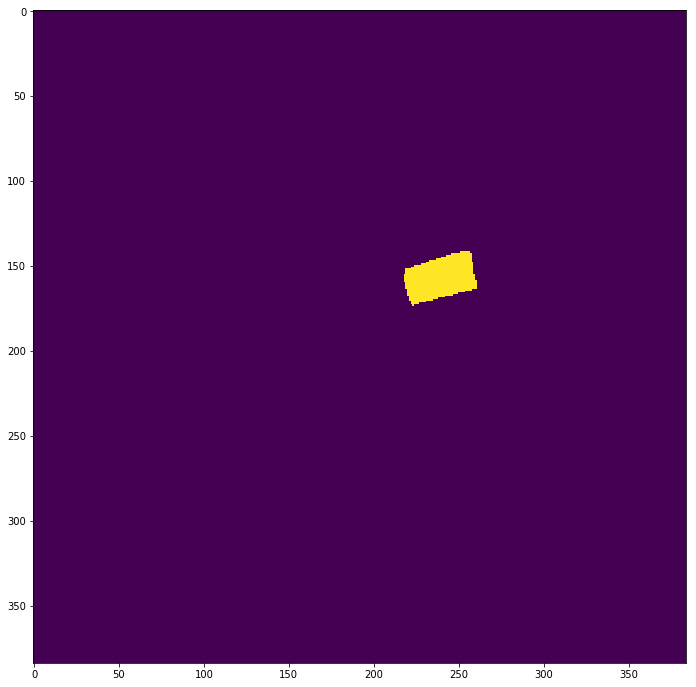

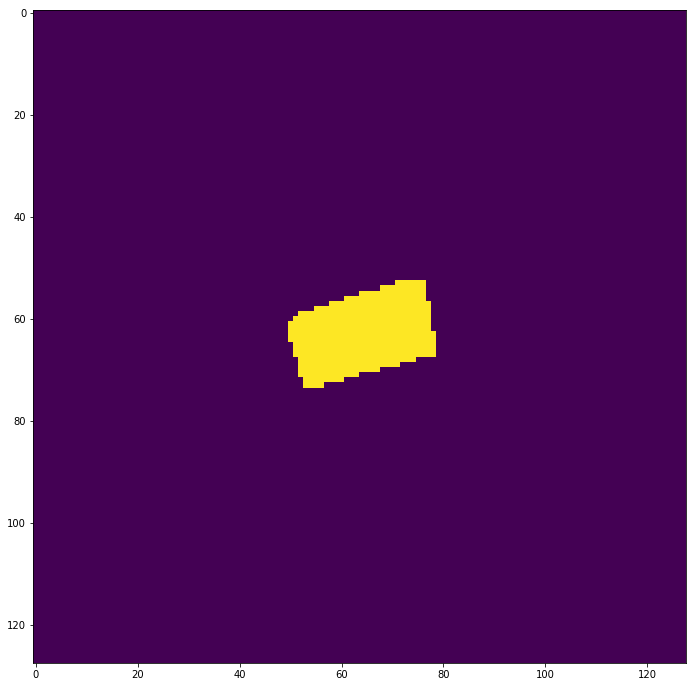

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000027.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000027

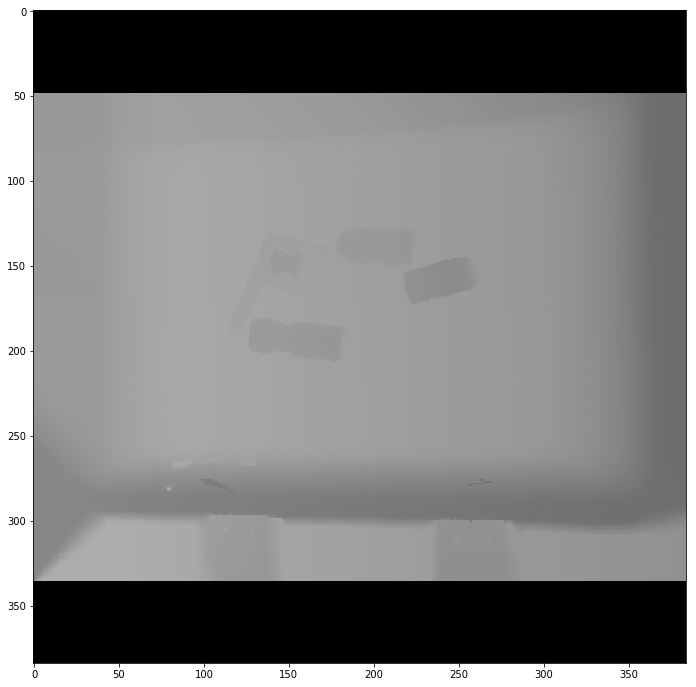

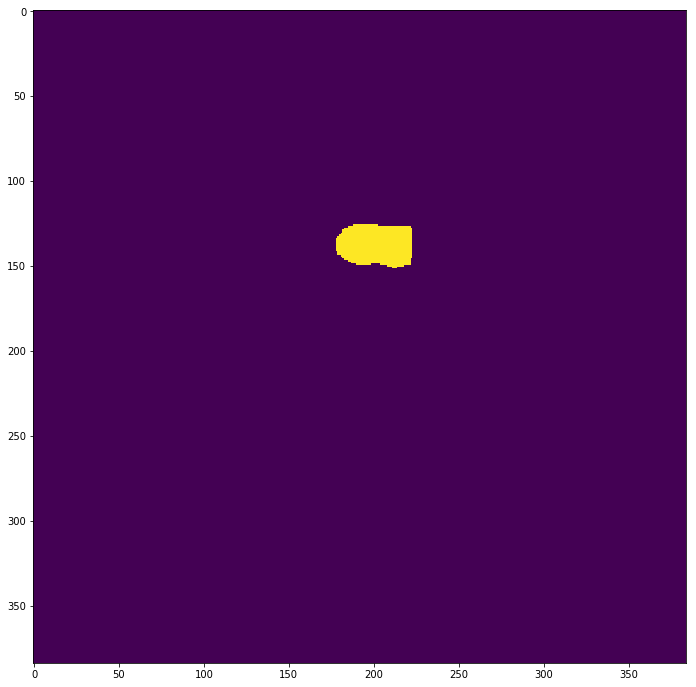

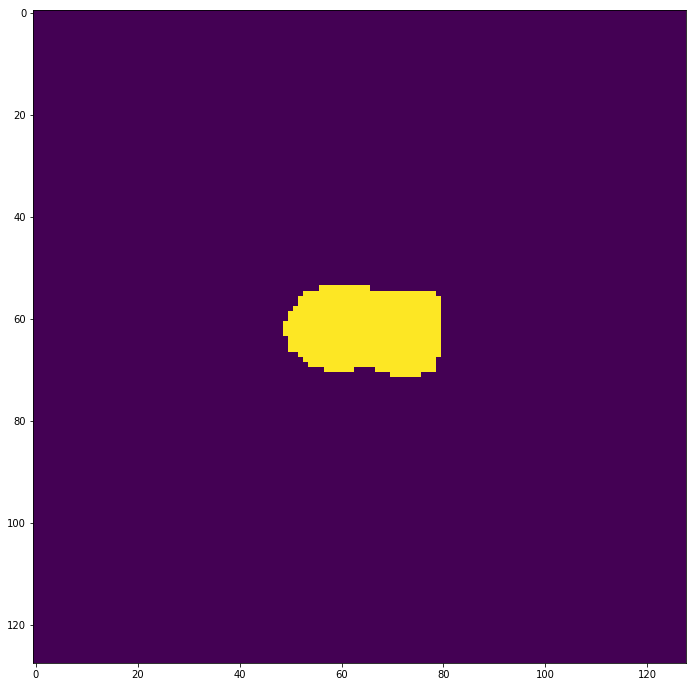

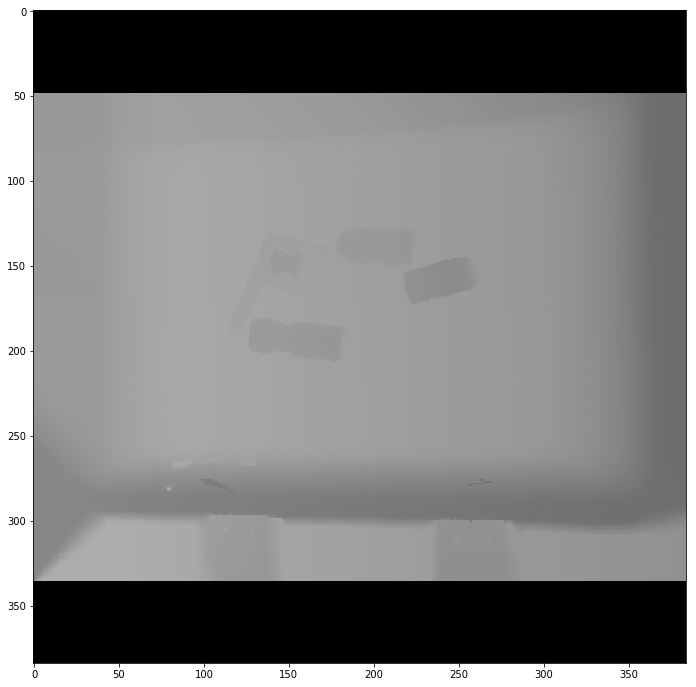

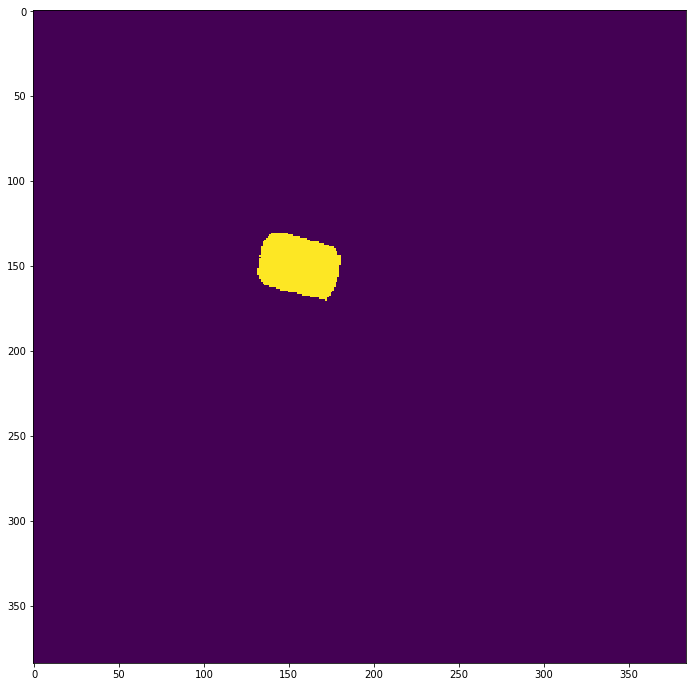

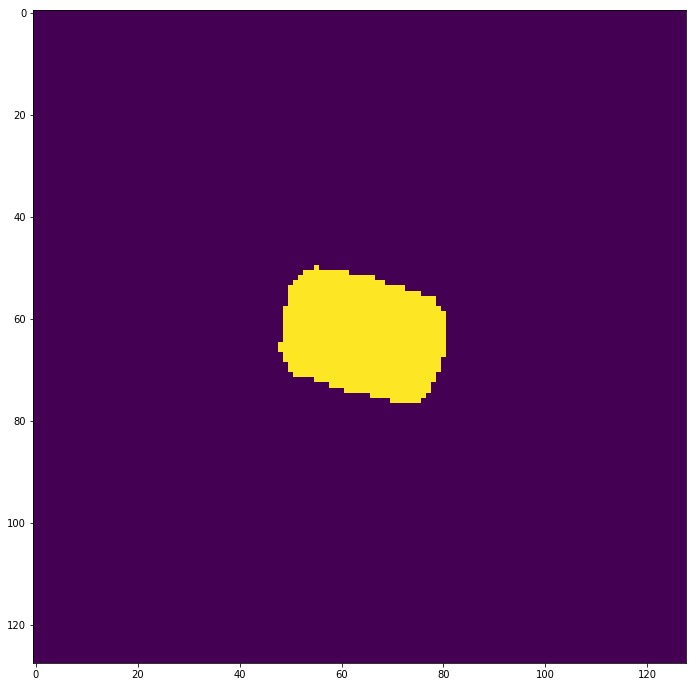

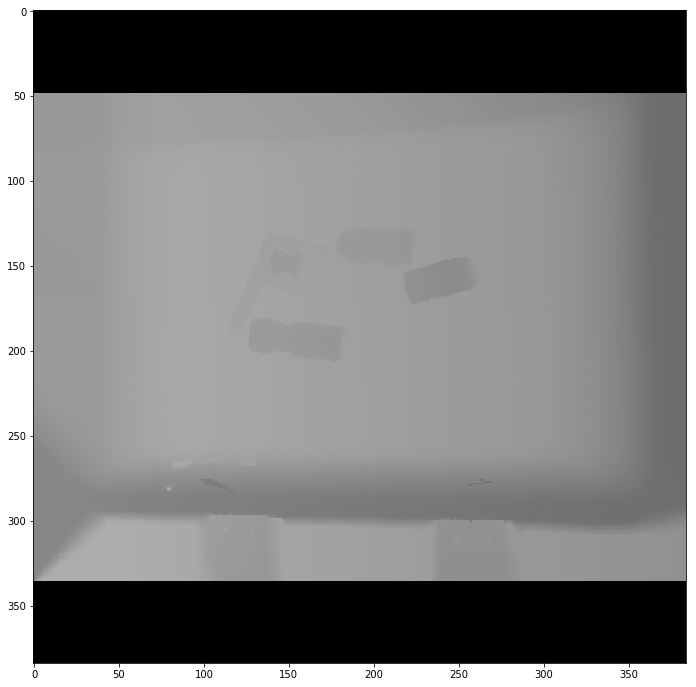

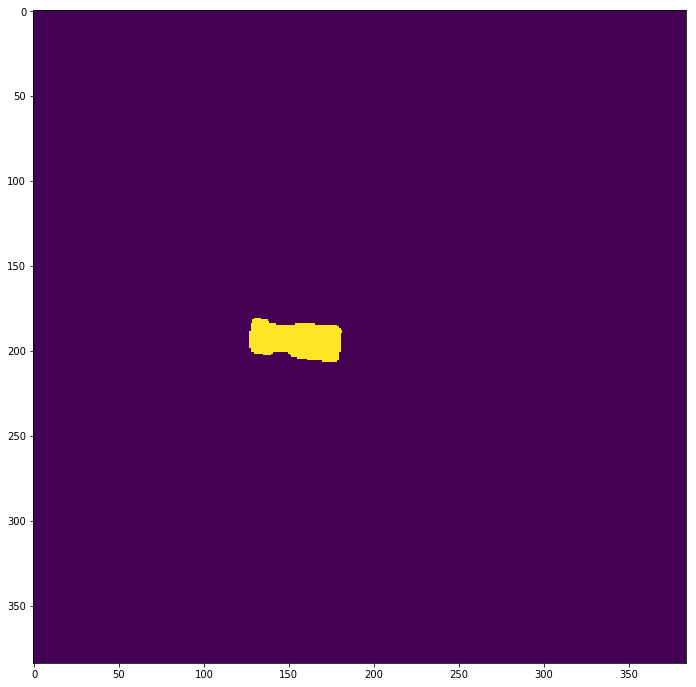

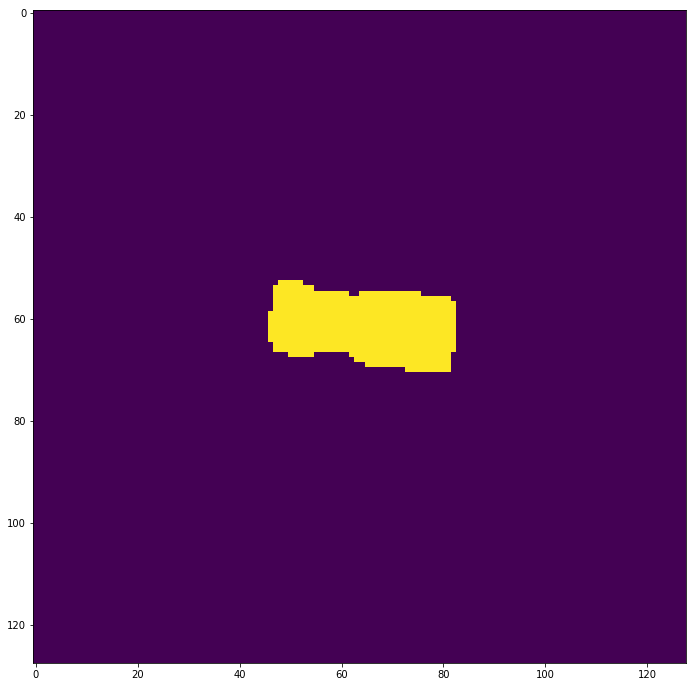

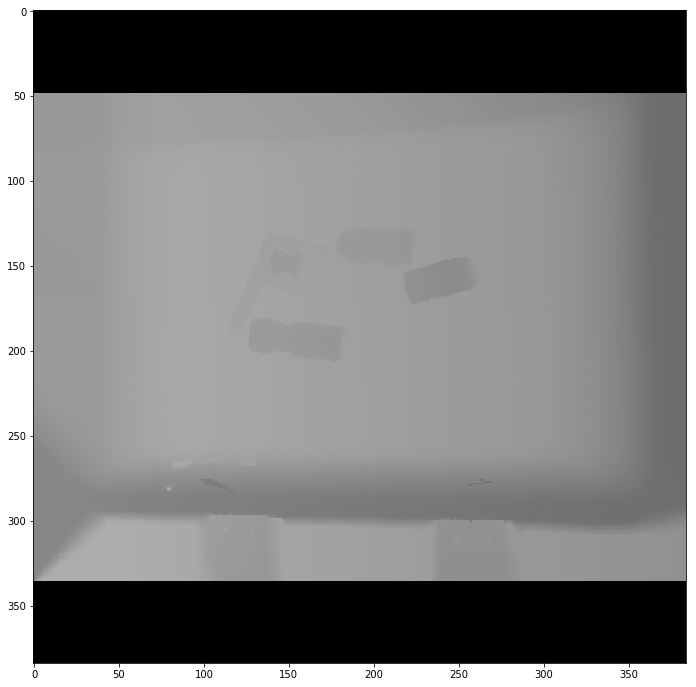

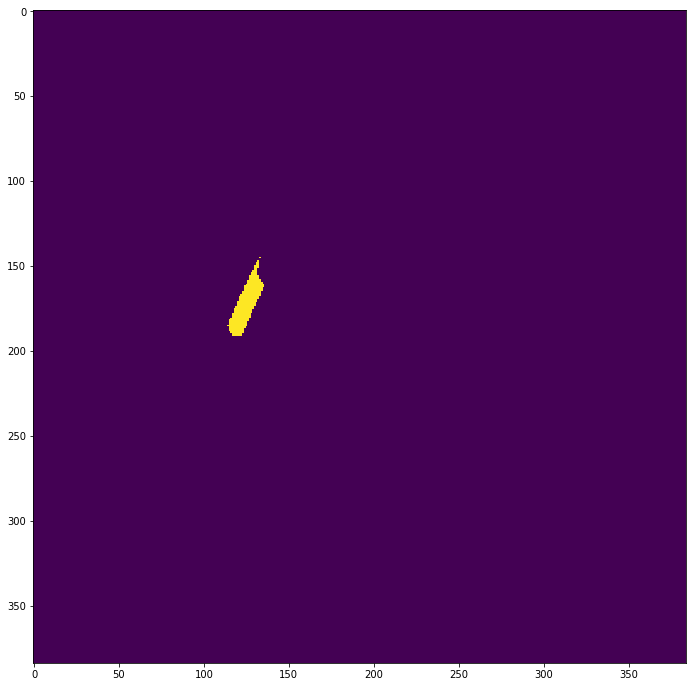

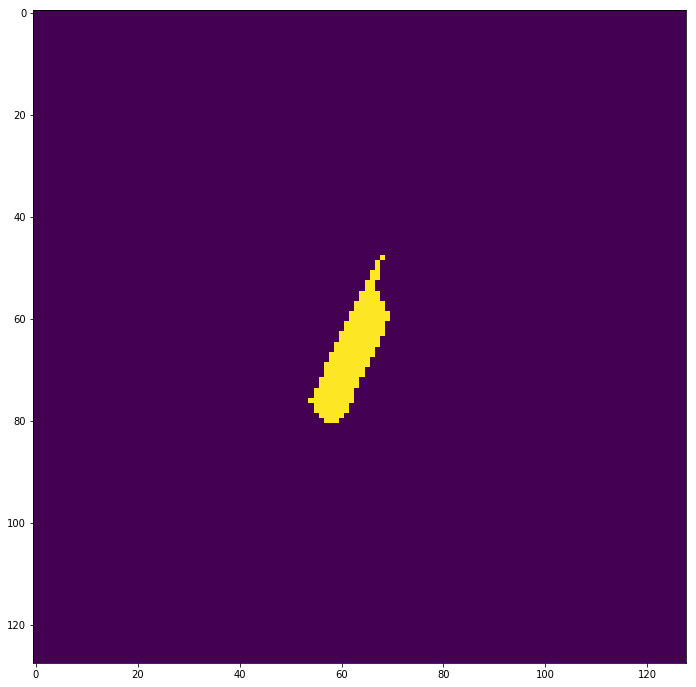

 93%|█████████▎| 28/30 [01:29<00:06,  3.14s/it]

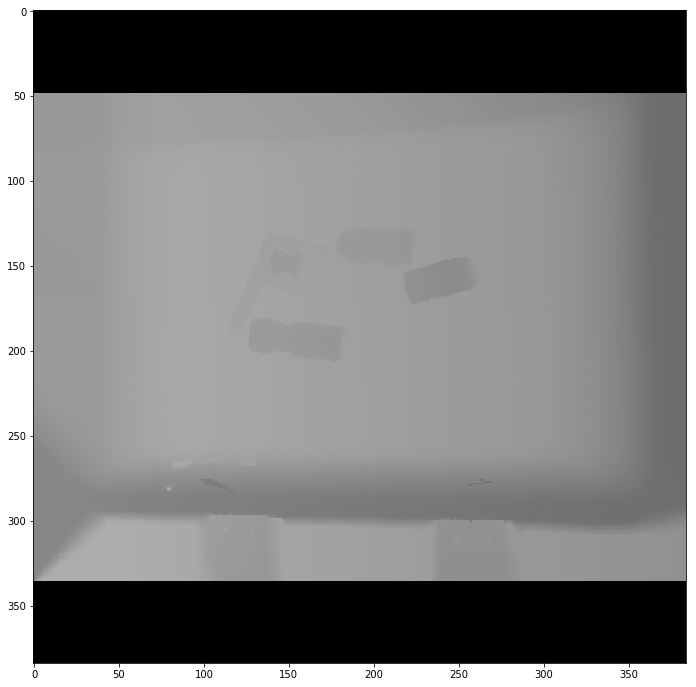

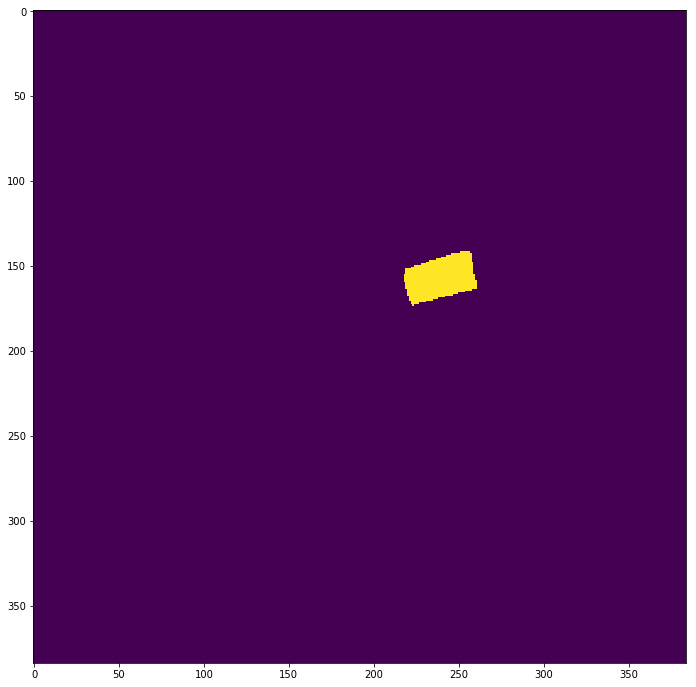

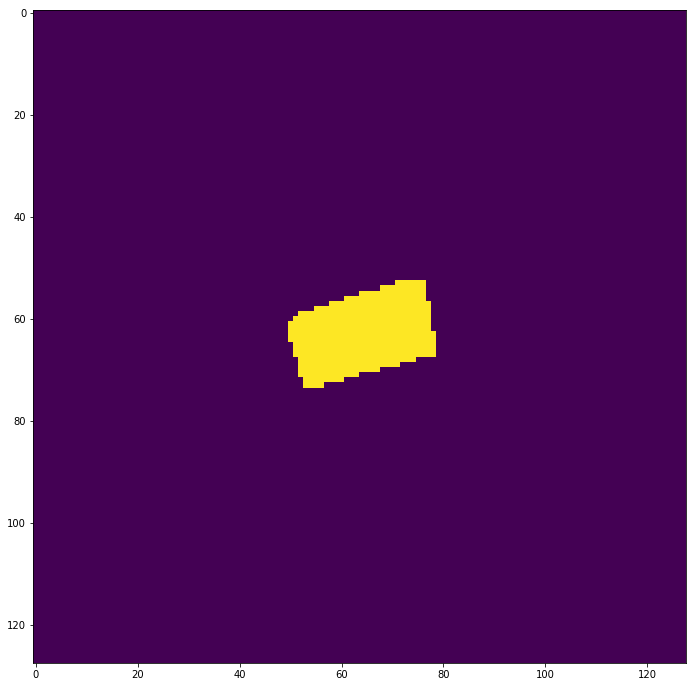

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000028.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000028.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000028.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000028

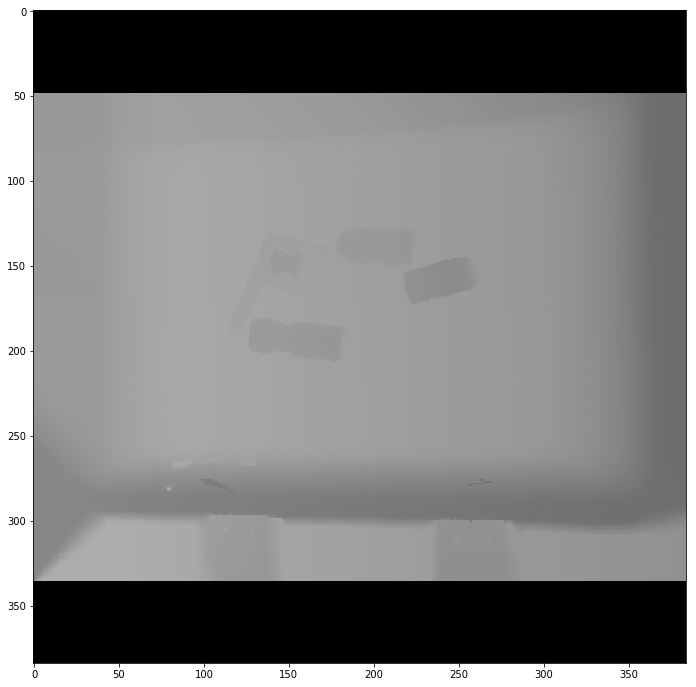

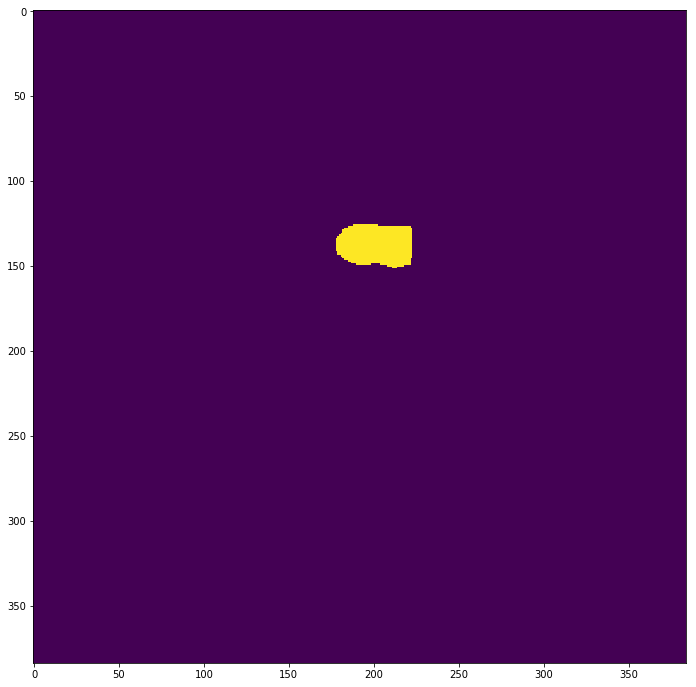

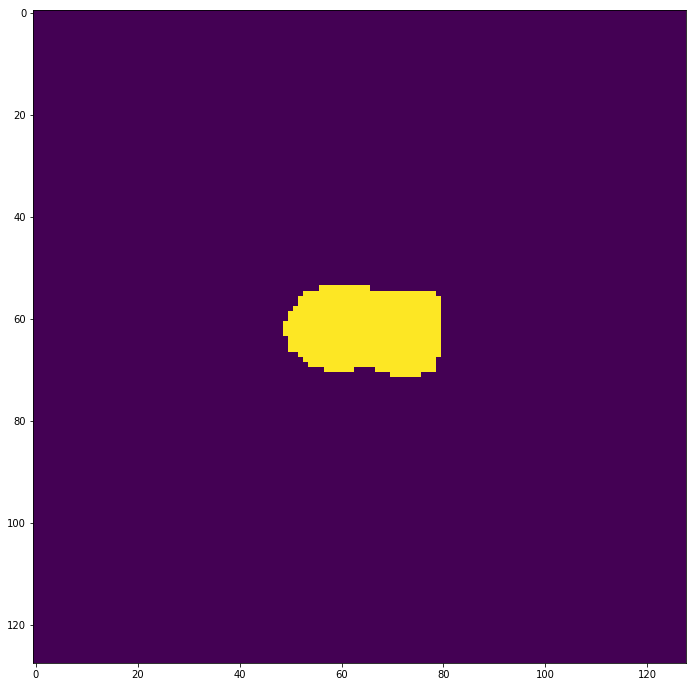

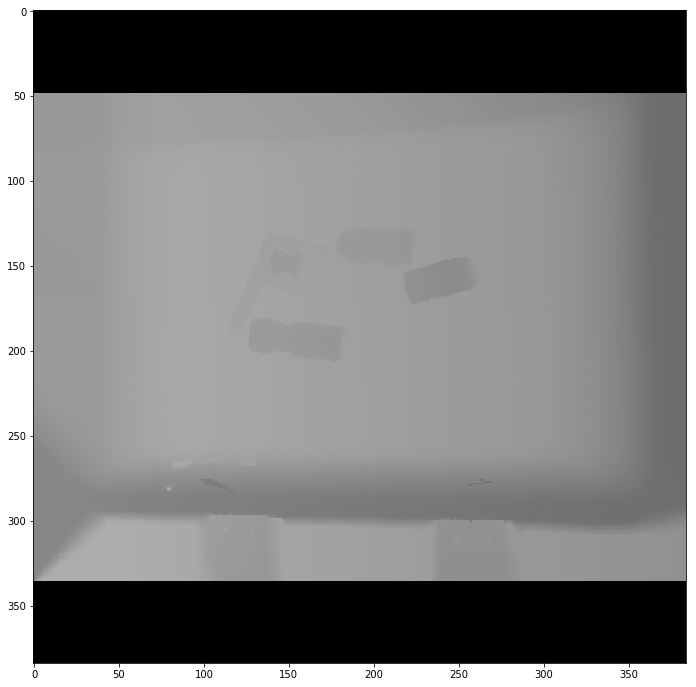

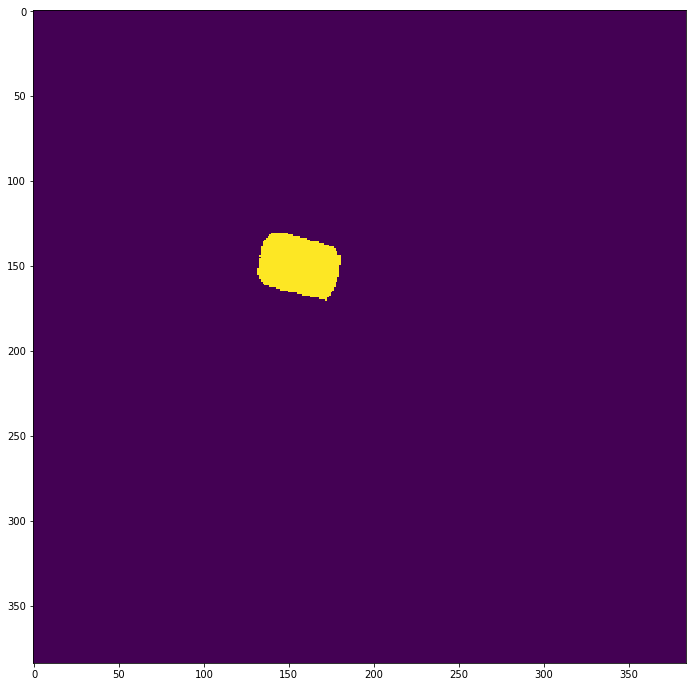

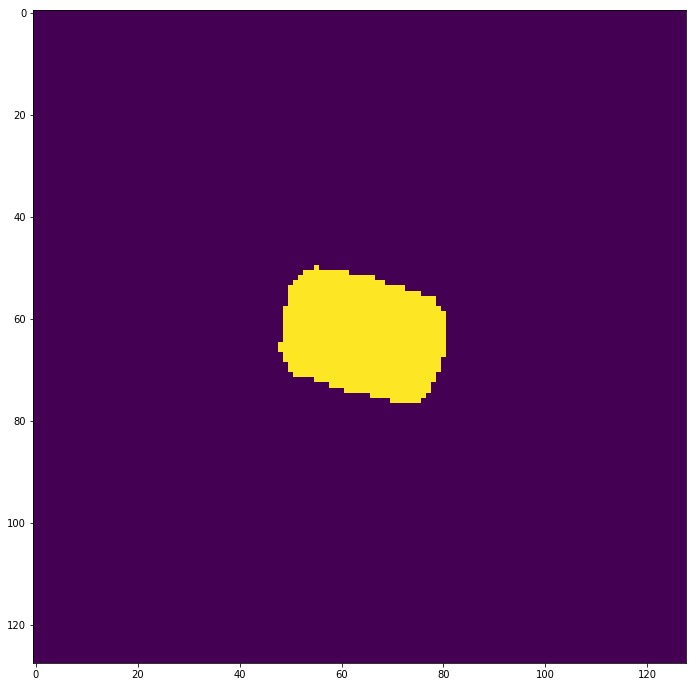

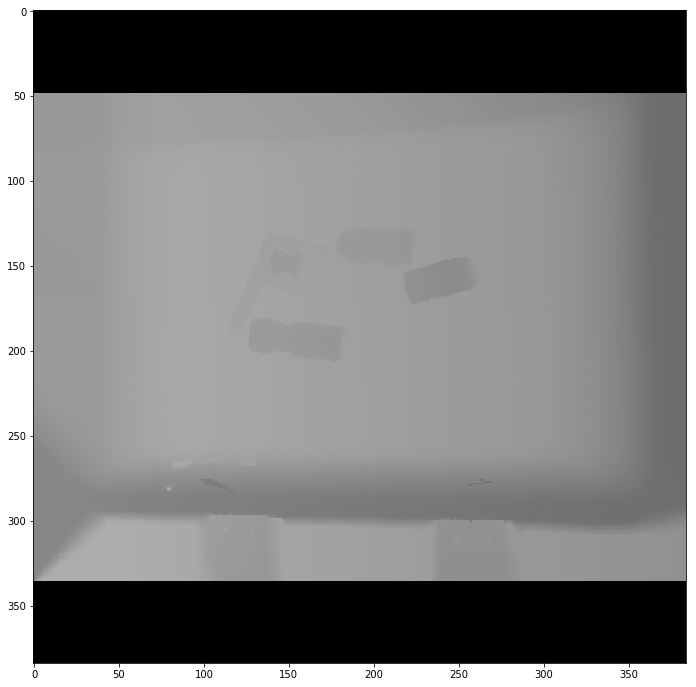

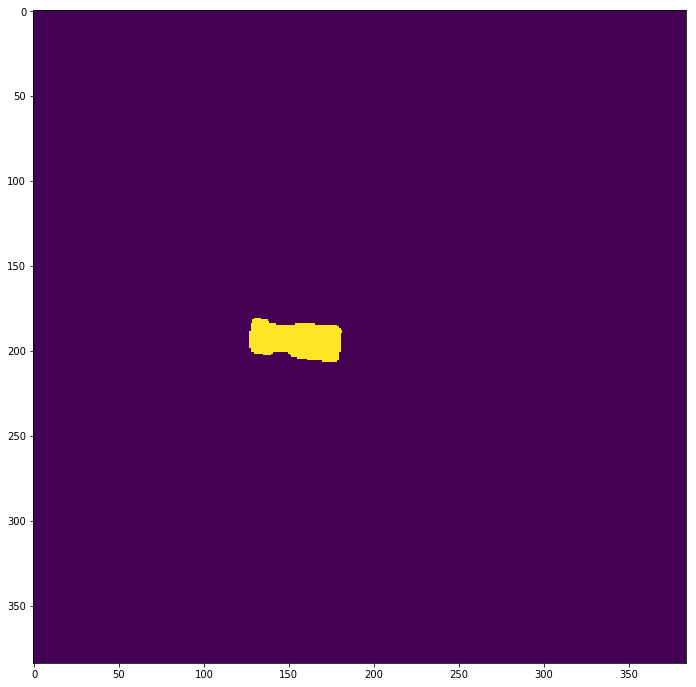

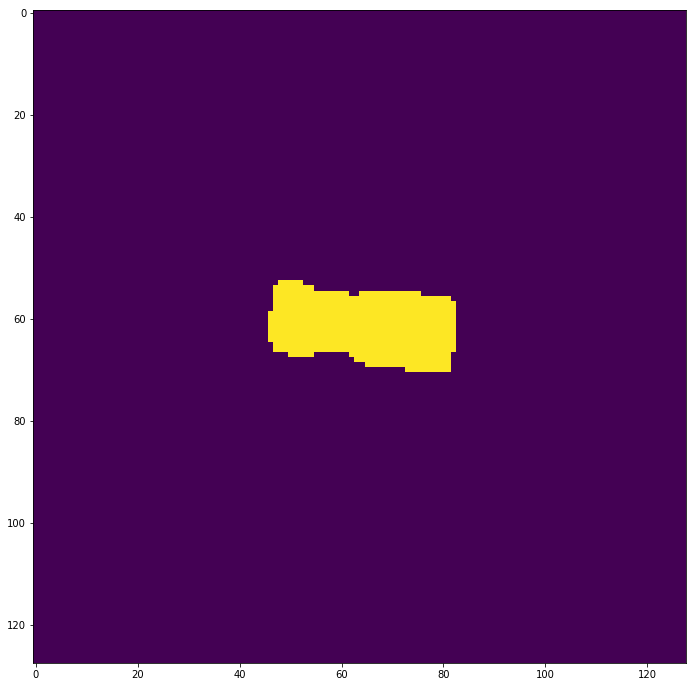

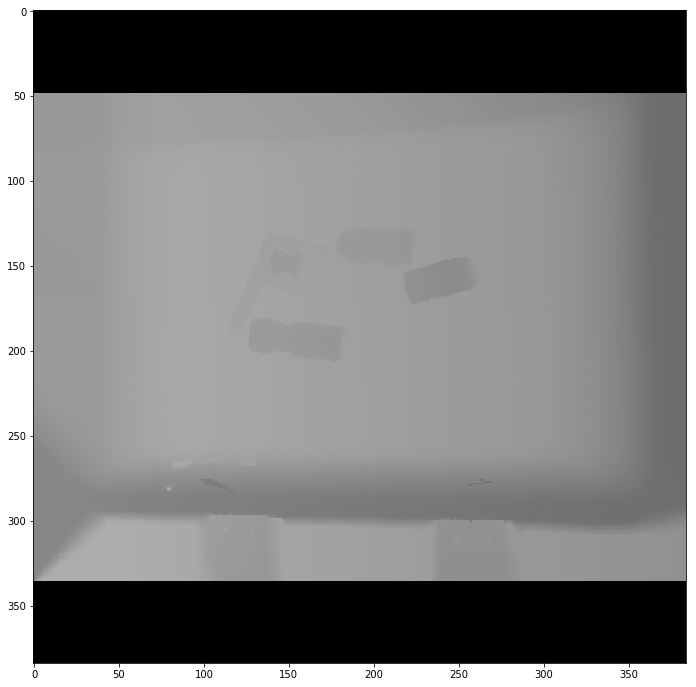

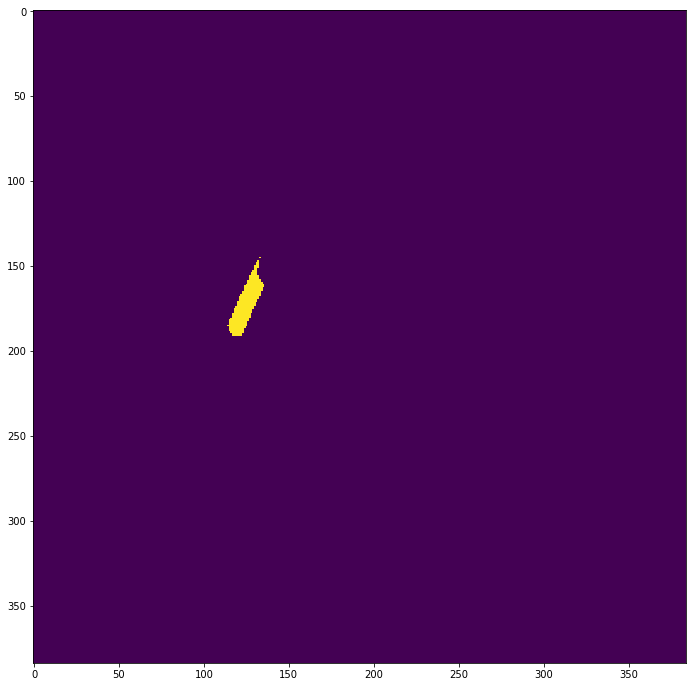

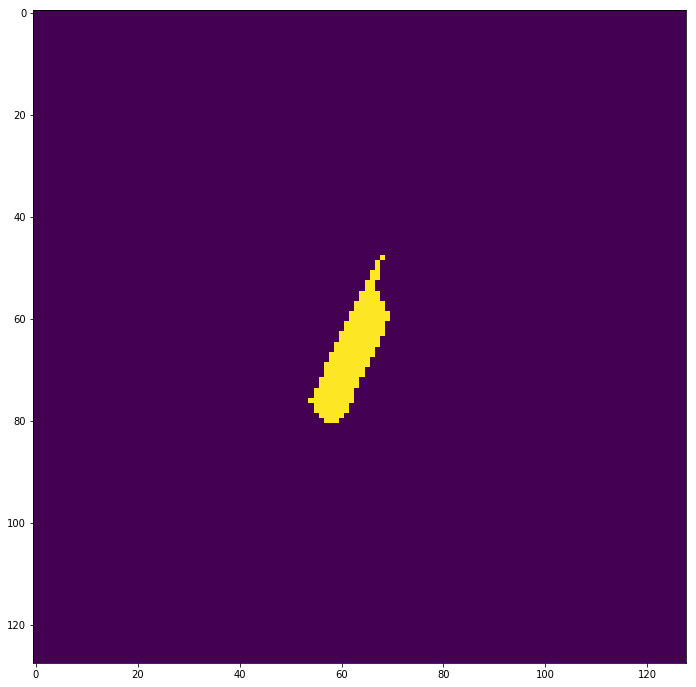

 97%|█████████▋| 29/30 [01:32<00:03,  3.16s/it]

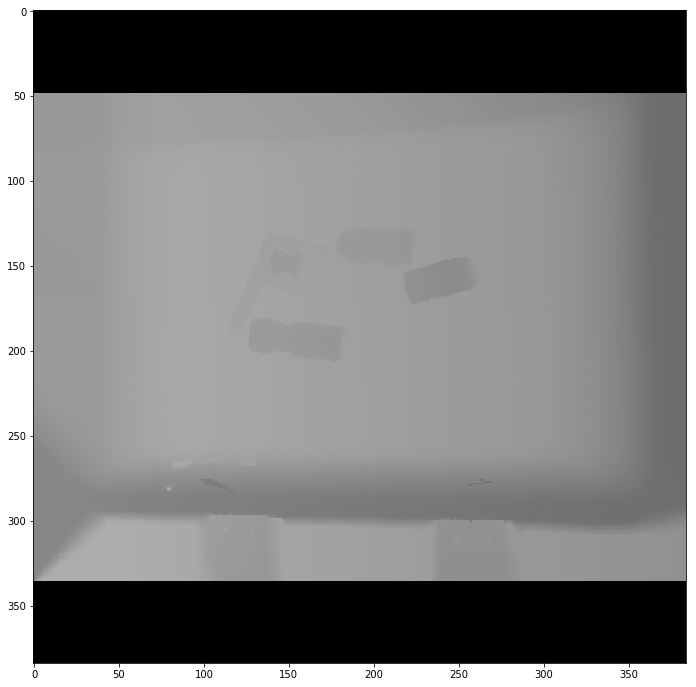

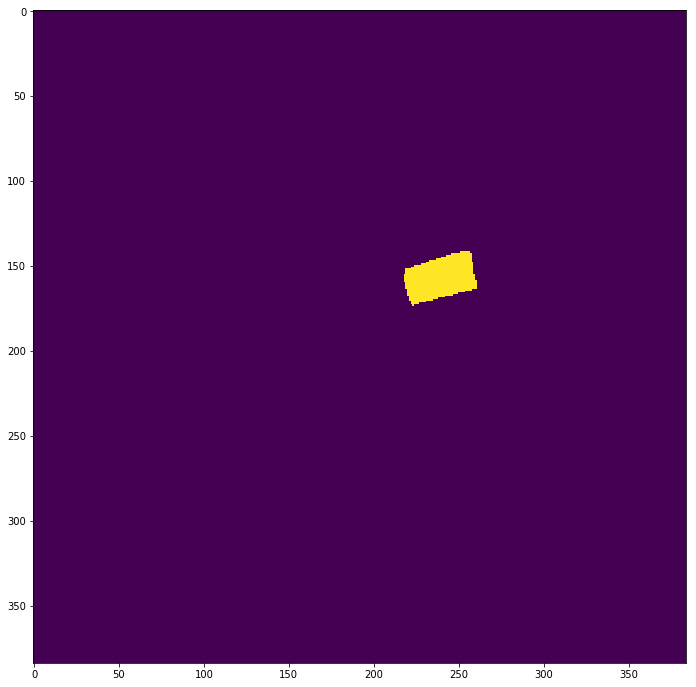

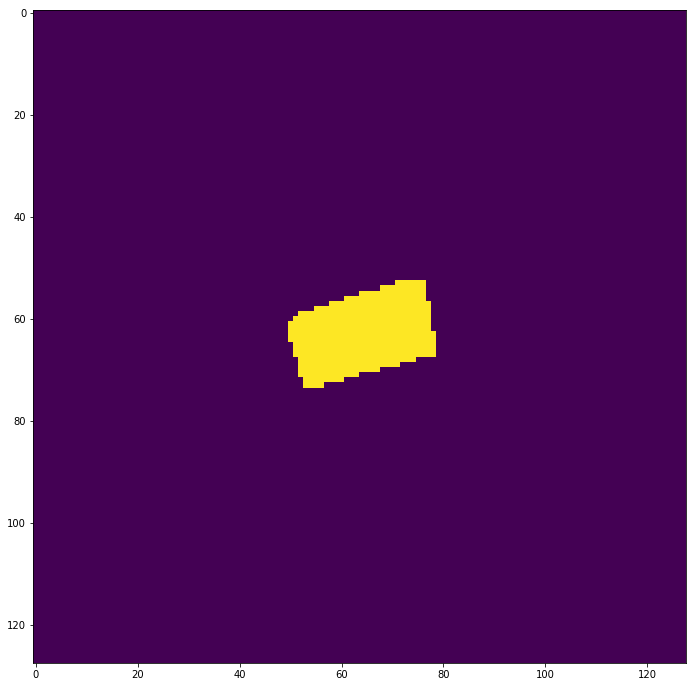

/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/segmentation_00000029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-train/target_00000029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/segmentation_00000029.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/andrewyli/oss/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0001/test-one-shot/target_00000029

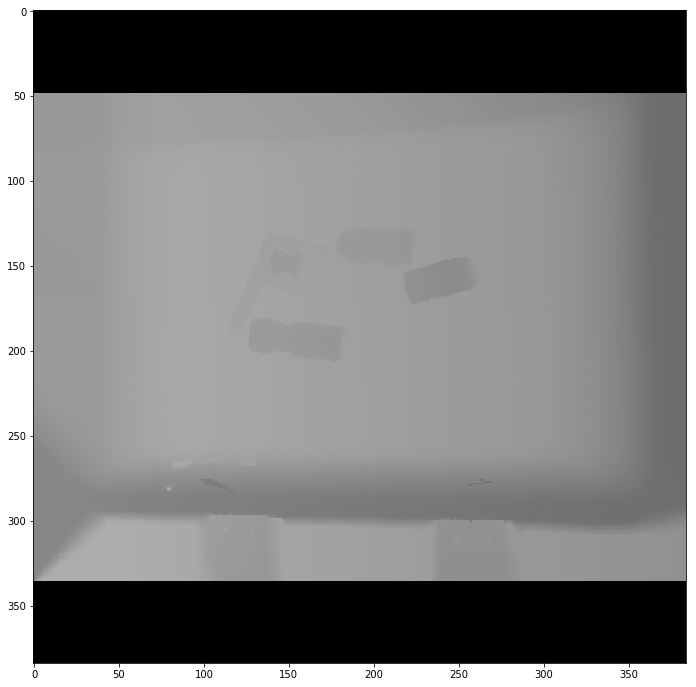

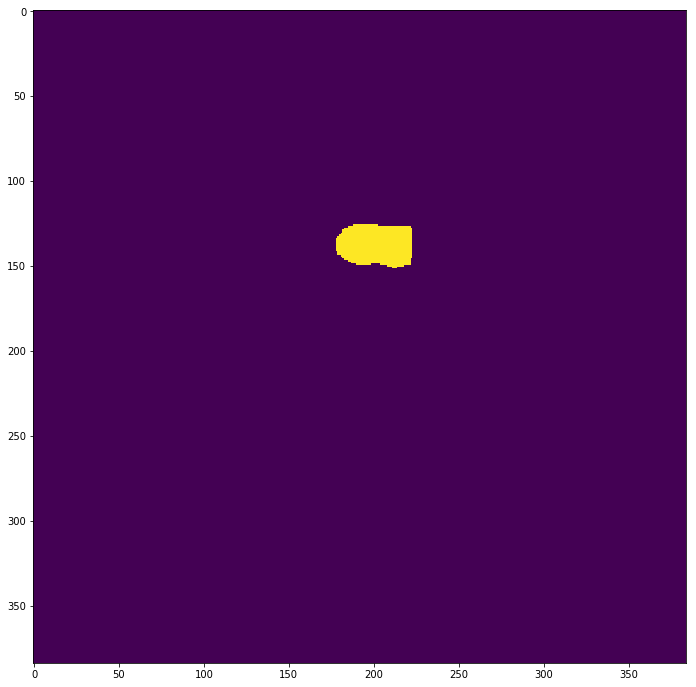

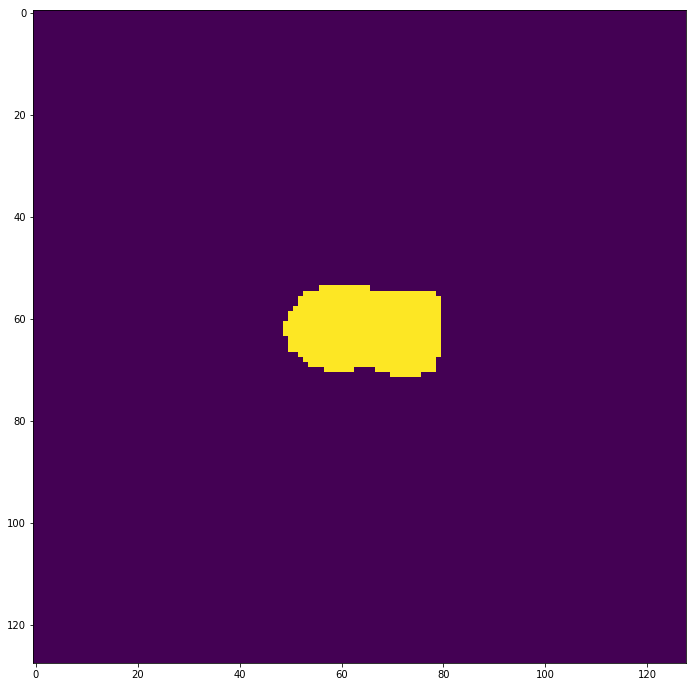

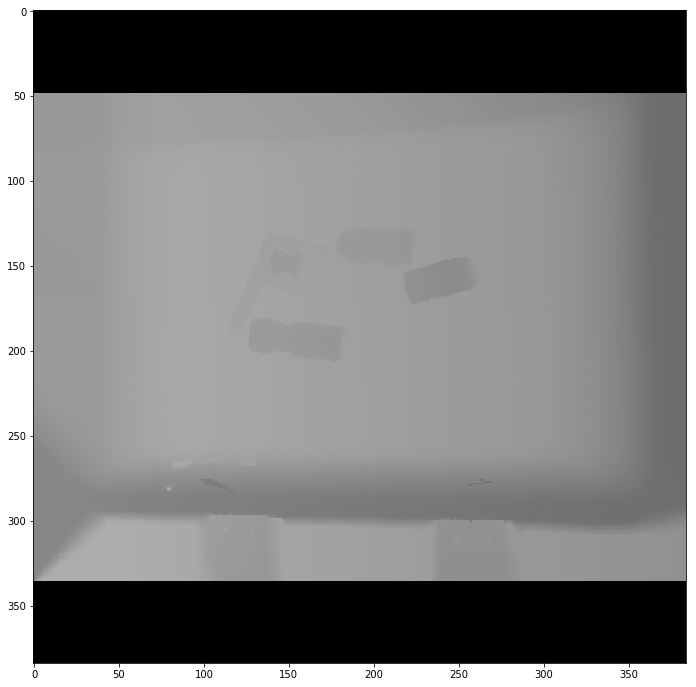

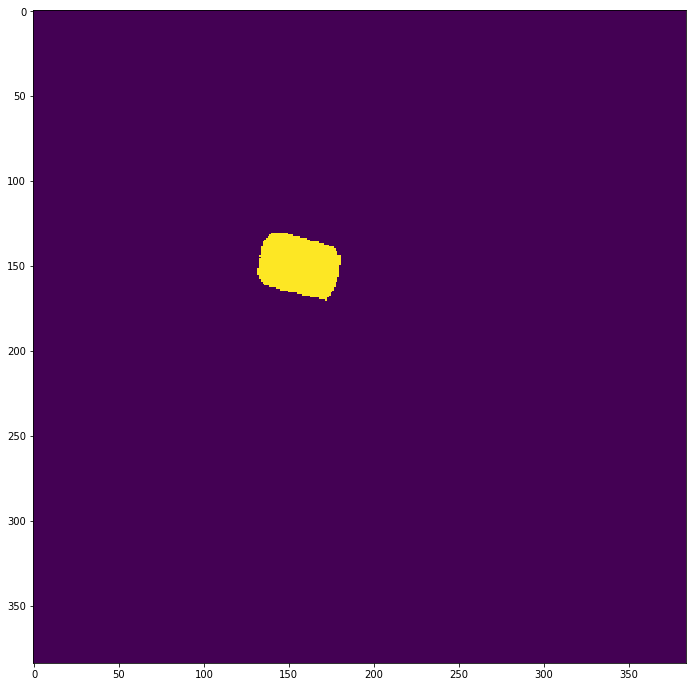

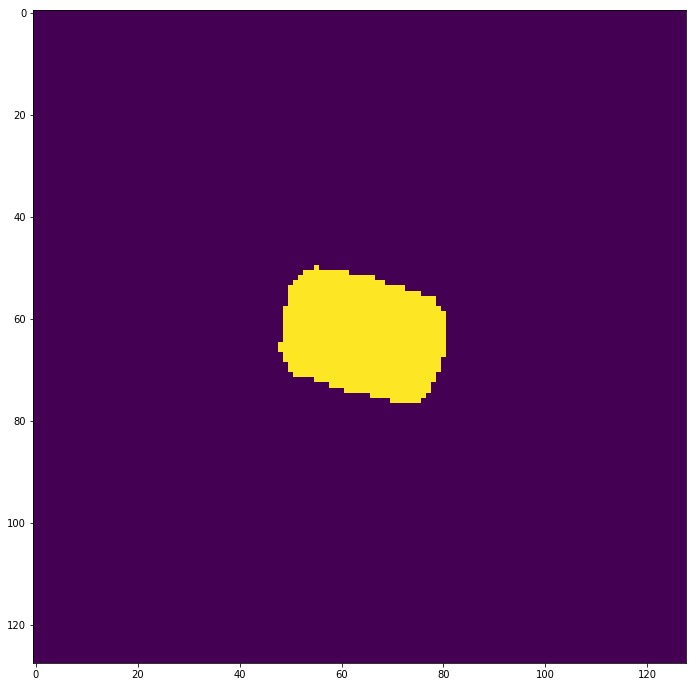

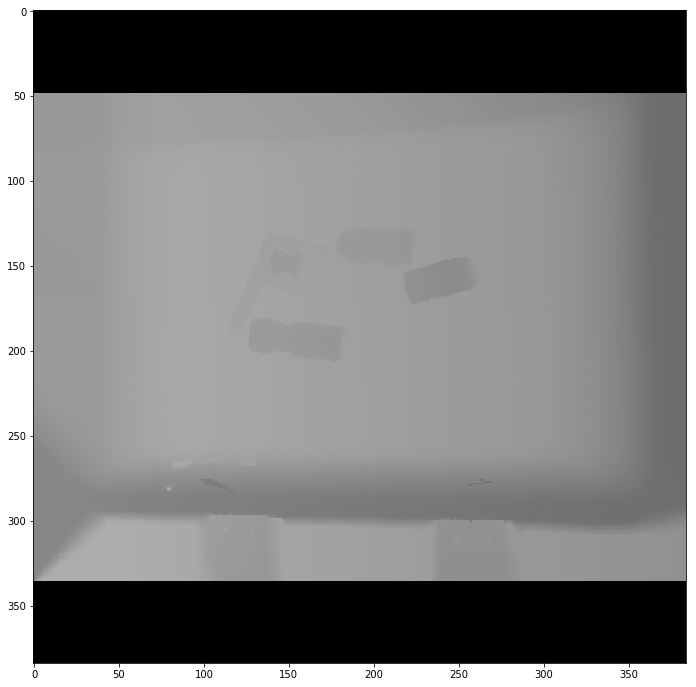

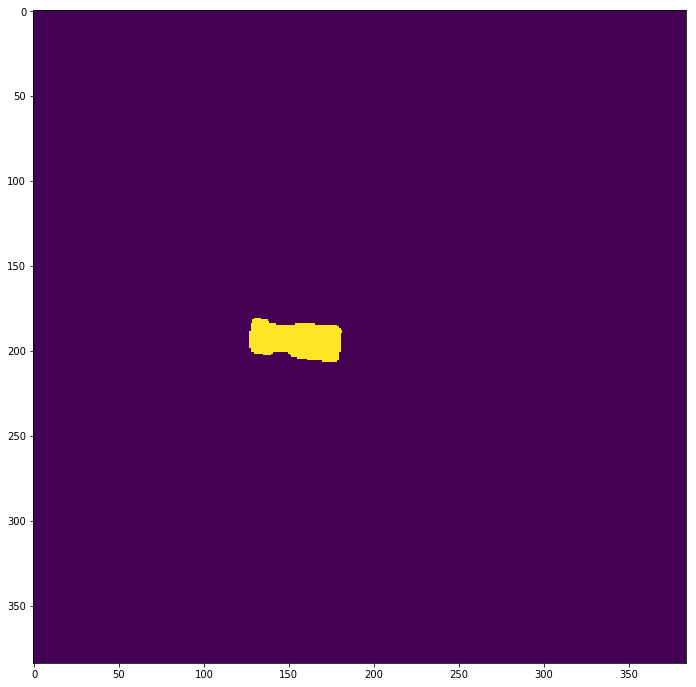

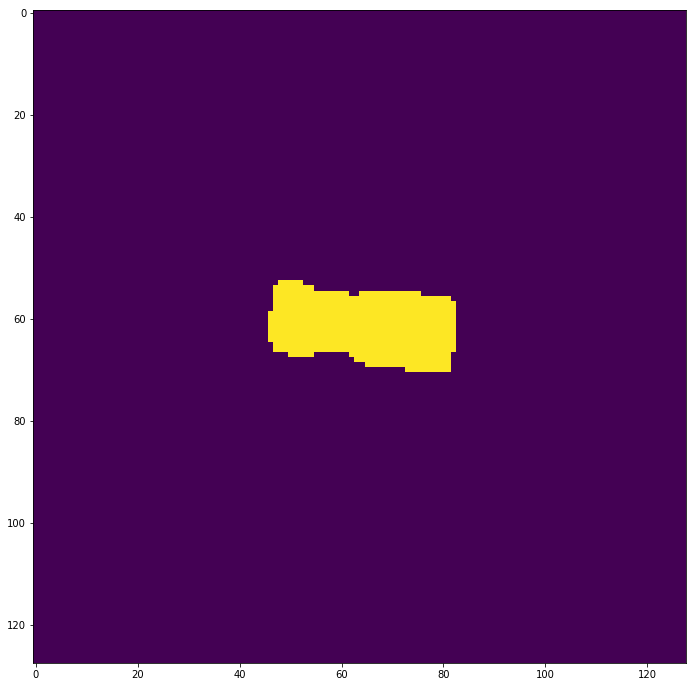

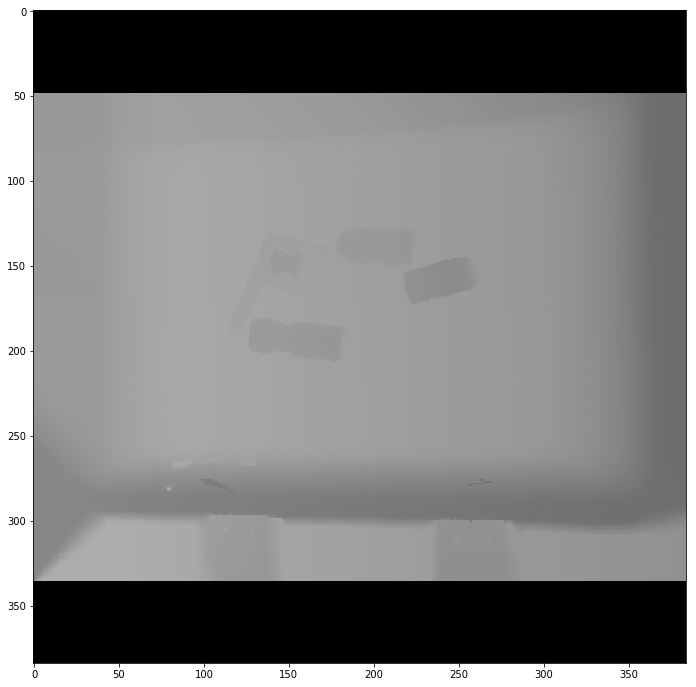

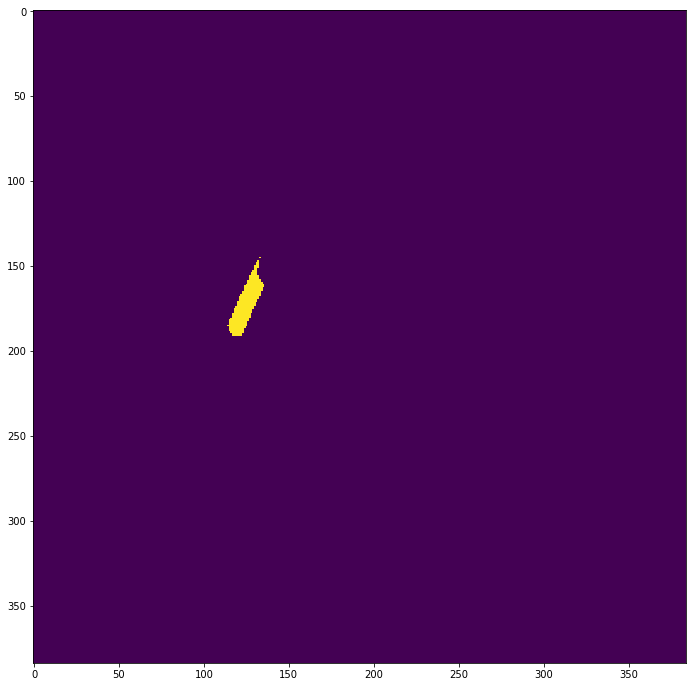

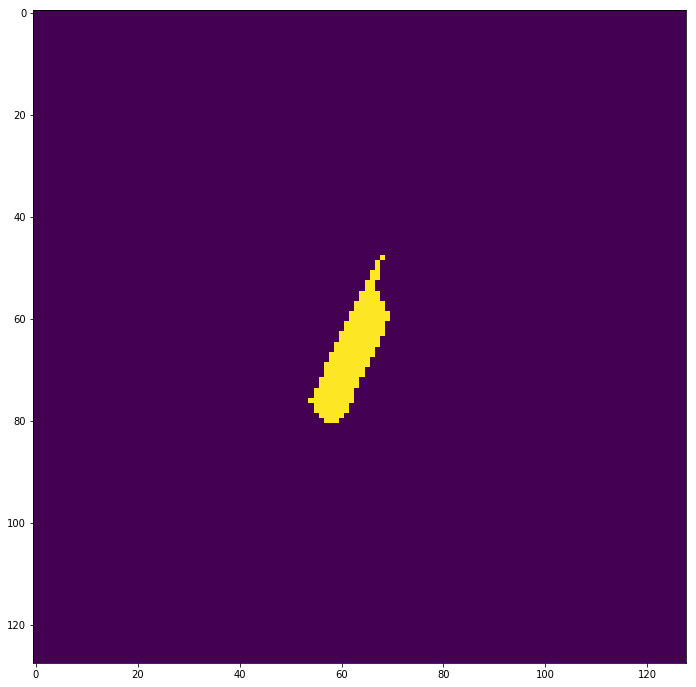

100%|██████████| 30/30 [01:35<00:00,  3.17s/it]


In [5]:
# Looping through all image indices
#   Looping through all labels in the json list
#     Get the name
#     Get the target file corresponding to the name
#     Add the image to the batch
#     Process the segmask from modal_segmasks

data_count = 0
for meta_idx in tqdm(range(NUM_IMS * 30)):
    idx = meta_idx % NUM_IMS
    f = open(os.path.join(JSON_DIR, "image_{:06d}.json".format(idx)))
    json_file = json.load(f)
    scene_path = os.path.join(SCENE_DIR, "image_{:06d}.png".format(idx))
    mask_path = os.path.join(MASK_DIR, "image_{:06d}.png".format(idx))

    # read and blockify scene
    scene_im = io.imread(scene_path)
    scene_im = resize_scene(scene_im)

    # for modal masks
    joint_mask = io.imread(mask_path)
    for label in json_file["labels"]:
        target_name = label["label_class"]
        target_id = label["object_id"]
        target_path = os.path.join(AMODAL_MASK_DIR, 
                                   "image_{:06d}".format(idx), 
                                   "{}.png".format(target_name))
        try:
            target_im = io.imread(target_path)
            # get first (basically equivalent slice)
            target_im = target_im[:, :, 0]
            amodal_mask = make_target(target_im, ANGLE, SHEAR)
            amodal_mask[amodal_mask > 0] = 1
        except:
            continue
        
        modal_mask = np.copy(joint_mask)
        modal_mask[modal_mask != target_id] = 0
        modal_mask = resize_scene(modal_mask)
        modal_mask[modal_mask > 0] = 1
        data_count += 1

        plt.imshow(scene_im)
        plt.show()
        plt.imshow(modal_mask)
        plt.show()
        plt.imshow(amodal_mask)
        plt.show()
        
        """print(modal_mask.shape)
        print(amodal_mask.shape)
        print(scene_im.shape)
        print(np.unique(modal_mask))
        print(np.unique(amodal_mask))
        print(np.unique(scene_im))
        print(modal_mask.dtype)
        print(amodal_mask.dtype)
        print(scene_im.dtype)"""
        
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "image_{:08d}.png".format(meta_idx)),
               scene_im)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "segmentation_{:08d}.png".format(meta_idx)),
               modal_mask)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "target_{:08d}.png".format(meta_idx)),
               amodal_mask)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "image_{:08d}.png".format(meta_idx)),
               scene_im)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "segmentation_{:08d}.png".format(meta_idx)),
               modal_mask)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "target_{:08d}.png".format(meta_idx)),
               amodal_mask)        
        
            
        
        
